# Sommaire :
<br>
<b>Partie 1 : Nettoyage d'une sélection de colonnes</b>
<br> - <a href="#E1">Les 10 premières colonnes</a>
<br> - <a href="#E2">Les colonnes servant au calcul du nutriscore</a>
<br> -- 1 - L'apport énergétique
<br> -- 2 - <a href="#E3">Les sucres</a>
<br> -- 3 - <a href="#E4">Les graisses saturées</a>
<br> -- 4 - <a href="#E5">Le sel</a>
<br> -- 5 - <a href="#E6">Les fibres</a>
<br> -- 6 - <a href="#E7">Les protéïnes</a>

<a href="#E8">**Partie 2 : Imputation des données non valorisées**</a>
 - <a href="#E9">Produits avec nutriscore mais composante(s) manquante(s) (hors fibres)</a>
 - <a href="#E10">Produits avec nutriscore mais composante fibres manquante (seulement)</a>
 - <a href="#E11">Produits sans nutriscore</a>
 
<a href="#E12">**Partie 3 : Analyses complémentaires**</a>
 - Catégorisations des produits
 - <a href="#E13">Analyse de la catégorie 'boisons'</a>
 - <a href="#E14">Analyse de la catégorie 'Jus de fruits' / sucres</a>
 - <a href="#E15">Analyse de la catégorie 'Eaux' / sodium</a>
 - <a href="#E16">Analyse de la masse des constituants</a>
 - <a href="#E17">Retour sur la correlation entre taux de sucre et apport énergétique</a>
 - <a href="#E18">Analyse du taux de sucres par catégorie</a>
 - <a href="#E19">Catégories et 'nutrigrade'</a>
 - <a href="#E20">Approche via ACP</a>

In [1]:
import pandas as pd
data = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='	')
data.info()

C:\Users\jlper\AppData\Local\Temp\ipykernel_11356\3933067510.py:2: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='	')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


In [6]:
data.iloc[1,0:15]

code                                                                   4530
url                       http://world-fr.openfoodfacts.org/produit/0000...
creator                                                     usda-ndb-import
created_t                                                        1489069957
created_datetime                                       2017-03-09T14:32:37Z
last_modified_t                                                  1489069957
last_modified_datetime                                 2017-03-09T14:32:37Z
product_name                                 Banana Chips Sweetened (Whole)
generic_name                                                            NaN
quantity                                                                NaN
packaging                                                               NaN
packaging_tags                                                          NaN
brands                                                                  NaN
brands_tags 

In [7]:
data.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'ph_100g', 'fruits-vegetables-nuts_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=162)

In [8]:
data.columns[15:30]

Index(['categories_tags', 'categories_fr', 'origins', 'origins_tags',
       'manufacturing_places', 'manufacturing_places_tags', 'labels',
       'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags',
       'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places'],
      dtype='object')

**Essai d'une méthode pour voir le début du fichier sans le charger avec pandas**

In [2]:
with open('fr.openfoodfacts.org.products.csv') as bigF :
    datahead = [next(bigF) for x in range(4)]

bigF.close()
datahead

['code\turl\tcreator\tcreated_t\tcreated_datetime\tlast_modified_t\tlast_modified_datetime\tproduct_name\tgeneric_name\tquantity\tpackaging\tpackaging_tags\tbrands\tbrands_tags\tcategories\tcategories_tags\tcategories_fr\torigins\torigins_tags\tmanufacturing_places\tmanufacturing_places_tags\tlabels\tlabels_tags\tlabels_fr\temb_codes\temb_codes_tags\tfirst_packaging_code_geo\tcities\tcities_tags\tpurchase_places\tstores\tcountries\tcountries_tags\tcountries_fr\tingredients_text\tallergens\tallergens_fr\ttraces\ttraces_tags\ttraces_fr\tserving_size\tno_nutriments\tadditives_n\tadditives\tadditives_tags\tadditives_fr\tingredients_from_palm_oil_n\tingredients_from_palm_oil\tingredients_from_palm_oil_tags\tingredients_that_may_be_from_palm_oil_n\tingredients_that_may_be_from_palm_oil\tingredients_that_may_be_from_palm_oil_tags\tnutrition_grade_uk\tnutrition_grade_fr\tpnns_groups_1\tpnns_groups_2\tstates\tstates_tags\tstates_fr\tmain_category\tmain_category_fr\timage_url\timage_small_url\te

Ce n'est pas très lisible mais au moins cela fonctionne et ça donne une idée des données.
<a name="E1">
> **Avant de chercher et éliminer les colonnes qui ne vont pas nous servir en vue d'un système d'aide à la saisie des informations, intéressons nous à la première, qui semble être une 'clé primaire', mais aussi présenter plusieurs datatypes :**

In [27]:
data.duplicated('code').sum()

176

In [17]:
# ce n'est donc pas une clé, voyons si elle a des rangs vides :
data['code'].isna().value_counts()

False    320749
True         23
Name: code, dtype: int64

In [3]:
data['code'] = pd.to_numeric(data['code'], errors='coerce')

In [24]:
data.loc[data['code'].isnull(), ['product_name', 'brands', 'categories_fr', 'labels']]

product_name brands categories_fr labels
189068         Belgique,France    NaN             6    NaN
189103                  France    NaN             6    NaN
189109  Belgique,France,Suisse    NaN             4    NaN
189119                  France    NaN             9    NaN
189152                  France    NaN            10    NaN
189160                  France    NaN             7    NaN
189162                  France    NaN            10    NaN
189168                  France    NaN             2    NaN
189242                  France    NaN             4    NaN
189244                  France    NaN             5    NaN
189248                  France    NaN             1    NaN
189250                  France    NaN             7    NaN
189260                  France    NaN             4    NaN
189262                  France    NaN             5    NaN
189269                  France    NaN             8    NaN
189272                  France    NaN            10    NaN
189345                  France    NaN             6    NaN
189362                  France    NaN             4    NaN
189364                  France    NaN           NaN    NaN
189379                  France    NaN             3    NaN
189404           France,Suisse    NaN             6    NaN
189406                  France    NaN             5    NaN
189417                  France    NaN            10    NaN

In [27]:
# exemple de produits qui ont un nom :
data.loc[data['code'].isin(range(5200,5500)), ['product_name', 'brands', 'categories_fr', 'labels']]

product_name        brands  \
306               Sea Salt Potato Chips  Trader Joe's   
275727            Eismann Zwiebelwürfel           NaN   
277434             Eismann Schnittlauch           NaN   
278808                              NaN           NaN   
280652  Eismann Junge-Erbsen, sehr fein           NaN   

                   categories_fr labels  
306     Chips et frites,en:Chips    NaN  
275727                       NaN    NaN  
277434                       NaN    NaN  
278808                       NaN    NaN  
280652                       NaN    NaN

In [4]:
# supprimons les lignes qui n'ont pas de code car les autres données sont visiblement aussi inintéressantes
li_elim = data.loc[data['code'].isnull(), 'product_name'].index

for ind in li_elim :
    data = data.drop(index=ind, axis=0)
# data = data.loc[~(data['code'].isnull()), :]  <<-- aurait été plus pertinent

In [11]:
# vérification :
data['code'].isna().value_counts()

False    320749
Name: code, dtype: int64

In [29]:
# data.loc[306].duplicated()
# data.loc[306].duplicated()[0]  # 0 correspond à la première colonne : code  HELLAS NE FONCTIONNE PAS pour cette colone
data.loc[306].duplicated()[159]  # champs 159 repéré préalablement comme étant dupliqué pour ce produit. FONCTIONNE BIEN

True

In [32]:
duplic = []
for i in range(320749):
    try :
        if data.loc[i].duplicated()[159] :
            duplic.append(i)
    except :
        continue


In [33]:
len(duplic)

214533

Mais la valeur retournée par len(duplic) est toujours 0 pour 'data.loc(i).duplicated()[0]' !
<br> La recherche des dupliqués fonctionne bien avec certaines colonnes mais pas bien avec 'code'.

In [46]:
duplica = data[data.duplicated('code')]
#data[data.duplicated('code')].index <- fonctionne bien

In [47]:
duplica.shape[0]

176

In [40]:
duplica = duplica.sort_values(by='code')

In [41]:
duplica.iloc[0:10,0:10]

code                                                url  \
174522       1.0  http://world-fr.openfoodfacts.org/produit/1/po...   
9892     11778.0  http://world-fr.openfoodfacts.org/produit/0011...   
481      16117.0  http://world-fr.openfoodfacts.org/produit/0001...   
519      24600.0  http://world-fr.openfoodfacts.org/produit/0002...   
560      31233.0  http://world-fr.openfoodfacts.org/produit/0003...   
632      58001.0  http://world-fr.openfoodfacts.org/produit/0005...   
111072  104456.0  http://world-fr.openfoodfacts.org/produit/0104...   
111515  129725.0  http://world-fr.openfoodfacts.org/produit/0129...   
120240  635646.0  http://world-fr.openfoodfacts.org/produit/0635...   
134825  722810.0  http://world-fr.openfoodfacts.org/produit/0722...   

                           creator   created_t      created_datetime  \
174522             date-limite-app  1491464860  2017-04-06T07:47:40Z   
9892                       beniben  1474489149  2016-09-21T20:19:09Z   
481                usda-ndb-import  1489065258  2017-03-09T13:14:18Z   
519                        tacinte  1435406581  2015-06-27T12:03:01Z   
560     openfoodfacts-contributors  1451914937  2016-01-04T13:42:17Z   
632                        kiliweb  1487432837  2017-02-18T15:47:17Z   
111072                     tacinte  1419611038  2014-12-26T16:23:58Z   
111515                     beniben  1474577519  2016-09-22T20:51:59Z   
120240                     beniben  1474521344  2016-09-22T05:15:44Z   
134825                      ariane  1459668979  2016-04-03T07:36:19Z   

       last_modified_t last_modified_datetime  \
174522      1491464860   2017-04-06T07:47:40Z   
9892        1491142385   2017-04-02T14:13:05Z   
481         1489065258   2017-03-09T13:14:18Z   
519         1435406592   2015-06-27T12:03:12Z   
560         1491146137   2017-04-02T15:15:37Z   
632         1487432838   2017-02-18T15:47:18Z   
111072      1419611919   2014-12-26T16:38:39Z   
111515      1474579523   2016-09-22T21:25:23Z   
120240      1491142371   2017-04-02T14:12:51Z   
134825      1491146173   2017-04-02T15:16:13Z   

                                          product_name  \
174522                            Pot au feu dégraissé   
9892        All Butter Reduced Fat Stem Ginger Cookies   
481              Colossal Olives With Jalapeno Peppers   
519                                                NaN   
560                     Super chicken spinach & quinoa   
632                              Bramley Apple Crumble   
111072                                          Haggis   
111515             British Shortcrust Pastry Steak Pie   
120240             Chargrilled Vegetable & Basil Pesto   
134825  Sea Salt & Balsamic Vinegar hand cooked Crisps   

                                             generic_name quantity  
174522                                                NaN      NaN  
9892                                                  NaN    225 g  
481                                                   NaN      NaN  
519                                                   NaN      NaN  
560                                                   NaN    600 g  
632                                                   NaN      NaN  
111072                                                NaN    454 g  
111515  Tourte en pâte brisée avec du bœuf d'origine b...    200 g  
120240  Pâte à pizza recouverte de sauce tomate, de fr...    476 g  
134825                                                NaN    150 g

In [47]:
data.loc[data['product_name'] == 'Pot au feu dégraissé', 'code']

174522    1.0
Name: code, dtype: float64

In [48]:
data.loc[data['product_name'] == 'Haggis', 'code']

1572      1.044560e+05
111072    1.044560e+05
282917    6.010011e+12
Name: code, dtype: float64

In [49]:
duplica.loc[duplica['product_name'] == 'Haggis', 'code']

111072    104456.0
Name: code, dtype: float64

In [50]:
data.loc[data['code'] == 1.0, 'product_name']

111040    Zero Calories Tea Beverage, Lemon, Raspberry, ...
174522                                 Pot au feu dégraissé
Name: product_name, dtype: object

In [51]:
data.loc[data['code'] == 11778.0, 'product_name']

458                            Stem Ginger Cookies
9892    All Butter Reduced Fat Stem Ginger Cookies
Name: product_name, dtype: object

Nous constatons que 'duplica' ne contient qu'une ligne pour chaque code en duplication.
<br> Les codes dupliqués réfèrent parfois les mêmes produits, parfois des produits différents.
<br> Nous avons aussi le cas d'un même produit qui a plusieurs codes.
<br> Il est souhaitable d'éviter cela, par exemple en affichant un avertissement quand le contributeur entre un code qui existe déjà, pour qu'il vérifie (peut être que l'erreur a eu lieu lors de la saisie précédente).
<br> Toutefois ce problème n'est pas très présent (176 lignes), il existe peut être déjà une sécurité. Nous allons le traiter en utilisant la paire 'code' + 'product_name' :

In [3]:
data.loc[data[['code', 'product_name']].duplicated(keep=False),:].sort_values('code')

code                                                url  \
422       9800800056  http://world-fr.openfoodfacts.org/produit/0000...   
1337      9800800056  http://world-fr.openfoodfacts.org/produit/0009...   
438      11110676177  http://world-fr.openfoodfacts.org/produit/0001...   
2877     11110676177  http://world-fr.openfoodfacts.org/produit/0011...   
440      11110881373  http://world-fr.openfoodfacts.org/produit/0001...   
4547     11110881373  http://world-fr.openfoodfacts.org/produit/0011...   
512      23923201965  http://world-fr.openfoodfacts.org/produit/0002...   
20399    23923201965  http://world-fr.openfoodfacts.org/produit/0023...   
516      24463061163  http://world-fr.openfoodfacts.org/produit/0002...   
21583    24463061163  http://world-fr.openfoodfacts.org/produit/0024...   
28886    33776100896  http://world-fr.openfoodfacts.org/produit/0033...   
229431   33776100896  http://world-fr.openfoodfacts.org/produit/3377...   
34644    37600110754  http://world-fr.openfoodfacts.org/produit/0037...   
581      37600110754  http://world-fr.openfoodfacts.org/produit/0003...   
71872    70650800312  http://world-fr.openfoodfacts.org/produit/0070...   
658      70650800312  http://world-fr.openfoodfacts.org/produit/0007...   
71874    70650800367  http://world-fr.openfoodfacts.org/produit/0070...   
659      70650800367  http://world-fr.openfoodfacts.org/produit/0007...   
79579    72220009989  http://world-fr.openfoodfacts.org/produit/0072...   
671      72220009989  http://world-fr.openfoodfacts.org/produit/0007...   
83165    73214001347  http://world-fr.openfoodfacts.org/produit/0073...   
678      73214001347  http://world-fr.openfoodfacts.org/produit/0007...   
687      74880030013  http://world-fr.openfoodfacts.org/produit/0007...   
87709    74880030013  http://world-fr.openfoodfacts.org/produit/0074...   
67382   637480006835  http://world-fr.openfoodfacts.org/produit/0063...   
120390  637480006835  http://world-fr.openfoodfacts.org/produit/0637...   
67397   639192720092  http://world-fr.openfoodfacts.org/produit/0063...   
120710  639192720092  http://world-fr.openfoodfacts.org/produit/0639...   
126057  688267155079  http://world-fr.openfoodfacts.org/produit/0688...   
68239   688267155079  http://world-fr.openfoodfacts.org/produit/0068...   
72268   707082626325  http://world-fr.openfoodfacts.org/produit/0070...   
128470  707082626325  http://world-fr.openfoodfacts.org/produit/0707...   
137333  734756002024  http://world-fr.openfoodfacts.org/produit/0734...   
84553   734756002024  http://world-fr.openfoodfacts.org/produit/0073...   

                           creator   created_t      created_datetime  \
422                usda-ndb-import  1489061721  2017-03-09T12:15:21Z   
1337    openfoodfacts-contributors  1457659842  2016-03-11T01:30:42Z   
438                usda-ndb-import  1489061722  2017-03-09T12:15:22Z   
2877               usda-ndb-import  1489065957  2017-03-09T13:25:57Z   
440                usda-ndb-import  1489142846  2017-03-10T10:47:26Z   
4547               usda-ndb-import  1489093831  2017-03-09T21:10:31Z   
512                usda-ndb-import  1489061516  2017-03-09T12:11:56Z   
20399              usda-ndb-import  1489061495  2017-03-09T12:11:35Z   
516                usda-ndb-import  1489061794  2017-03-09T12:16:34Z   
21583                      tacinte  1422746252  2015-01-31T23:17:32Z   
28886              usda-ndb-import  1489063590  2017-03-09T12:46:30Z   
229431             usda-ndb-import  1489092892  2017-03-09T20:54:52Z   
34644                     stephane  1442318117  2015-09-15T11:55:17Z   
581                usda-ndb-import  1489061718  2017-03-09T12:15:18Z   
71872              usda-ndb-import  1489057015  2017-03-09T10:56:55Z   
658                usda-ndb-import  1489061796  2017-03-09T12:16:36Z   
71874              usda-ndb-import  1489061874  2017-03-09T12:17:54Z   
659                usda-ndb-import  1489061818  2017-03-09T12:16:58Z   
79579              usd

In [4]:
# nous allons simplement garder la première entrée de chaque duplicatas (argument par défaut) :
data.drop_duplicates(subset=['code', 'product_name'], inplace=True, ignore_index=True)

In [5]:
data.duplicated(['code', 'product_name']).sum()

0

**Maintenant examinons les autres informations générales** (colonnes 1 -> 9 i.e. de la deuxième à la dixième) :

In [53]:
data[['url','creator','created_t','created_datetime','last_modified_t','last_modified_datetime','product_name','generic_name','quantity']].dtypes

url                       object
creator                   object
created_t                 object
created_datetime          object
last_modified_t           object
last_modified_datetime    object
product_name              object
generic_name              object
quantity                  object
dtype: object

In [57]:
# avant de corriger les dtypes, voyons quelques valeurs de ces variables, et leur premières caractéristiques statistiques :
data.iloc[1:15,1:7]

url          creator  \
1   http://world-fr.openfoodfacts.org/produit/0000...  usda-ndb-import   
2   http://world-fr.openfoodfacts.org/produit/0000...  usda-ndb-import   
3   http://world-fr.openfoodfacts.org/produit/0000...  usda-ndb-import   
4   http://world-fr.openfoodfacts.org/produit/0000...  usda-ndb-import   
5   http://world-fr.openfoodfacts.org/produit/0000...  usda-ndb-import   
6   http://world-fr.openfoodfacts.org/produit/0000...  usda-ndb-import   
7   http://world-fr.openfoodfacts.org/produit/0000...  usda-ndb-import   
8   http://world-fr.openfoodfacts.org/produit/0000...  usda-ndb-import   
9   http://world-fr.openfoodfacts.org/produit/0000...  usda-ndb-import   
10  http://world-fr.openfoodfacts.org/produit/0000...  usda-ndb-import   
11  http://world-fr.openfoodfacts.org/produit/0000...  usda-ndb-import   
12  http://world-fr.openfoodfacts.org/produit/0000...  usda-ndb-import   
13  http://world-fr.openfoodfacts.org/produit/0000...  usda-ndb-import   
14  http://world-fr.openfoodfacts.org/produit/0000...  usda-ndb-import   

     created_t      created_datetime last_modified_t last_modified_datetime  
1   1489069957  2017-03-09T14:32:37Z      1489069957   2017-03-09T14:32:37Z  
2   1489069957  2017-03-09T14:32:37Z      1489069957   2017-03-09T14:32:37Z  
3   1489055731  2017-03-09T10:35:31Z      1489055731   2017-03-09T10:35:31Z  
4   1489055653  2017-03-09T10:34:13Z      1489055653   2017-03-09T10:34:13Z  
5   1489055651  2017-03-09T10:34:11Z      1489055651   2017-03-09T10:34:11Z  
6   1489055730  2017-03-09T10:35:30Z      1489055730   2017-03-09T10:35:30Z  
7   1489055711  2017-03-09T10:35:11Z      1489055712   2017-03-09T10:35:12Z  
8   1489055651  2017-03-09T10:34:11Z      1489055651   2017-03-09T10:34:11Z  
9   1489055654  2017-03-09T10:34:14Z      1489055654   2017-03-09T10:34:14Z  
10  1489055731  2017-03-09T10:35:31Z      1489055731   2017-03-09T10:35:31Z  
11  1489055668  2017-03-09T10:34:28Z      1489055668   2017-03-09T10:34:28Z  
12  1489055650  2017-03-09T10:34:10Z      1489055651   2017-03-09T10:34:11Z  
13  1489055651  2017-03-09T10:34:11Z      1489055651   2017-03-09T10:34:11Z  
14  1489055678  2017-03-09T10:34:38Z      1489055678   2017-03-09T10:34:38Z

In [62]:
# l'URL en entier : partie constante puis code puis nom
data.iloc[8,1]

'http://world-fr.openfoodfacts.org/produit/0000000016193/organic-dark-chocolate-minis-equal-exchange'

In [60]:
data.iloc[1:15,7:10]

product_name generic_name quantity
1      Banana Chips Sweetened (Whole)          NaN      NaN
2                             Peanuts          NaN      NaN
3              Organic Salted Nut Mix          NaN      NaN
4                     Organic Polenta          NaN      NaN
5   Breadshop Honey Gone Nuts Granola          NaN      NaN
6       Organic Long Grain White Rice          NaN      NaN
7                      Organic Muesli          NaN      NaN
8        Organic Dark Chocolate Minis          NaN      NaN
9               Organic Sunflower Oil          NaN      NaN
10               Organic Adzuki Beans          NaN      NaN
11                Organic Penne Pasta          NaN      NaN
12                      Zen Party Mix          NaN      NaN
13          Organic Golden Flax Seeds          NaN      NaN
14                Organic Spicy Punks          NaN      NaN

In [65]:
data['url'].isna().value_counts()

False    320749
Name: url, dtype: int64

In [66]:
data['creator'].isna().value_counts()

False    320747
True          2
Name: creator, dtype: int64

In [67]:
data['created_t'].isna().value_counts()

False    320749
Name: created_t, dtype: int64

In [68]:
data['created_datetime'].isna().value_counts()

False    320748
True          1
Name: created_datetime, dtype: int64

In [69]:
data['last_modified_t'].isna().value_counts()

False    320749
Name: last_modified_t, dtype: int64

In [70]:
data['last_modified_datetime'].isna().value_counts()

False    320749
Name: last_modified_datetime, dtype: int64

Le niveau de remplissage de ces colonnes est excellent, on peut peut-être affecter à la 'created_datetime' vide la valeur de la 'last_modified_datetime' de la même ligne ? :

In [72]:
data.loc[data['created_datetime'].isna(), 'last_modified_datetime']

187478    2017-03-08T16:54:15Z
Name: last_modified_datetime, dtype: object

In [74]:
tmp = data.loc[187478]['last_modified_datetime']  # en une etape 'ça rale', essayons en deux étapes : (pareil)
data.loc[187478]['created_datetime'] = tmp

C:\Users\jlper\AppData\Local\Temp\ipykernel_6052\2893938405.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[187478]['created_datetime'] = tmp


In [75]:
data.loc[187478]['created_datetime']

nan

In [76]:
tmp

'2017-03-08T16:54:15Z'

In [77]:
data.iloc[187478,4] = tmp # seul le 'iloc' permet l'affectation individuelle sans souci

In [78]:
data.loc[187478]['created_datetime']

'2017-03-08T16:54:15Z'

Changement de type des données :

In [5]:
data[['url','creator']] = data[['url','creator']].astype("string")

In [6]:
data['created_datetime'] = pd.to_datetime(data['created_datetime'])
data['last_modified_datetime'] = pd.to_datetime(data['last_modified_datetime'])

In [9]:
data['created_t'] = pd.to_numeric(data['created_t'], errors='coerce')
data['last_modified_t'] = pd.to_numeric(data['last_modified_t'], errors='coerce')

In [10]:
# revenons aux colonnes 'générales' non étudiées
data['product_name'].isna().value_counts()

False    302987
True      17762
Name: product_name, dtype: int64

In [11]:
data['generic_name'].isna().value_counts()

True     267976
False     52773
Name: generic_name, dtype: int64

In [12]:
data['quantity'].isna().value_counts()

True     215949
False    104800
Name: quantity, dtype: int64

La quantité n'est pas utile pour le nutriscore si les données nutritionnelles pour 100 g / 100 ml sont bien renseignées.
<br> Par contre **le nom du produit est une réference souhaitable, nous allons tâcher d'en savoir plus sur les articles qui n'en ont pas.**
<br> Le nom générique est très lacunaire, et inutile pour le nutriscore, nous laissons cette colonne de côté pour l'instant.

In [20]:
# quelques produits sans nom :
data.loc[(data['product_name'].isna()) & (data['code'] < 2000.00), ['code','url','creator','created_t','created_datetime','last_modified_t','last_modified_datetime','generic_name','quantity']]

code                                               url  \
11224   1403.0  http://world-fr.openfoodfacts.org/produit/001403   
14215    184.0   http://world-fr.openfoodfacts.org/produit/00184   
111044  1009.0   http://world-fr.openfoodfacts.org/produit/01009   
111122    11.0     http://world-fr.openfoodfacts.org/produit/011   
111602  1402.0   http://world-fr.openfoodfacts.org/produit/01402   
175023   141.0     http://world-fr.openfoodfacts.org/produit/141   
175269    20.0      http://world-fr.openfoodfacts.org/produit/20   
255846     4.0       http://world-fr.openfoodfacts.org/produit/4   

                           creator   created_t          created_datetime  \
11224              date-limite-app  1474839172 2016-09-25 21:32:52+00:00   
14215              date-limite-app  1475234502 2016-09-30 11:21:42+00:00   
111044             date-limite-app  1481416444 2016-12-11 00:34:04+00:00   
111122             date-limite-app  1481416371 2016-12-11 00:32:51+00:00   
111602             date-limite-app  1475230419 2016-09-30 10:13:39+00:00   
175023  openfoodfacts-contributors  1492703331 2017-04-20 15:48:51+00:00   
175269  openfoodfacts-contributors  1473970795 2016-09-15 20:19:55+00:00   
255846             date-limite-app  1478376506 2016-11-05 20:08:26+00:00   

        last_modified_t    last_modified_datetime generic_name quantity  
11224        1474839172 2016-09-25 21:32:52+00:00          NaN      NaN  
14215        1475234502 2016-09-30 11:21:42+00:00          NaN      NaN  
111044       1481416444 2016-12-11 00:34:04+00:00          NaN      NaN  
111122       1481416371 2016-12-11 00:32:51+00:00          NaN      NaN  
111602       1475230420 2016-09-30 10:13:40+00:00          NaN      NaN  
175023       1492703331 2017-04-20 15:48:51+00:00          NaN      NaN  
175269       1473970796 2016-09-15 20:19:56+00:00          NaN      NaN  
255846       1478376507 2016-11-05 20:08:27+00:00          NaN      NaN

In [27]:
# Peut on avoir une idée du niveau de remplissage des données suivantes ?
data.loc[(data['product_name'].isna()) & (data['code'] < 2000.00), :].isna().mean()[10:30]

packaging                    1.0
packaging_tags               1.0
brands                       1.0
brands_tags                  1.0
categories                   1.0
categories_tags              1.0
categories_fr                1.0
origins                      1.0
origins_tags                 1.0
manufacturing_places         1.0
manufacturing_places_tags    1.0
labels                       1.0
labels_tags                  1.0
labels_fr                    1.0
emb_codes                    1.0
emb_codes_tags               1.0
first_packaging_code_geo     1.0
cities                       1.0
cities_tags                  1.0
purchase_places              1.0
dtype: float64

In [28]:
data.loc[(data['product_name'].isna()) & (data['code'] < 2000.00), :].isna().mean()[30:60]

stores                                        1.0
countries                                     0.0
countries_tags                                0.0
countries_fr                                  0.0
ingredients_text                              1.0
allergens                                     1.0
allergens_fr                                  1.0
traces                                        1.0
traces_tags                                   1.0
traces_fr                                     1.0
serving_size                                  1.0
no_nutriments                                 1.0
additives_n                                   1.0
additives                                     1.0
additives_tags                                1.0
additives_fr                                  1.0
ingredients_from_palm_oil_n                   1.0
ingredients_from_palm_oil                     1.0
ingredients_from_palm_oil_tags                1.0
ingredients_that_may_be_from_palm_oil_n       1.0


In [29]:
data.loc[(data['product_name'].isna()) & (data['code'] < 2000.00), :].isna().mean()[60:90]

main_category_fr              1.0
image_url                     1.0
image_small_url               1.0
energy_100g                   1.0
energy-from-fat_100g          1.0
fat_100g                      1.0
saturated-fat_100g            1.0
butyric-acid_100g             1.0
caproic-acid_100g             1.0
caprylic-acid_100g            1.0
capric-acid_100g              1.0
lauric-acid_100g              1.0
myristic-acid_100g            1.0
palmitic-acid_100g            1.0
stearic-acid_100g             1.0
arachidic-acid_100g           1.0
behenic-acid_100g             1.0
lignoceric-acid_100g          1.0
cerotic-acid_100g             1.0
montanic-acid_100g            1.0
melissic-acid_100g            1.0
monounsaturated-fat_100g      1.0
polyunsaturated-fat_100g      1.0
omega-3-fat_100g              1.0
alpha-linolenic-acid_100g     1.0
eicosapentaenoic-acid_100g    1.0
docosahexaenoic-acid_100g     1.0
omega-6-fat_100g              1.0
linoleic-acid_100g            1.0
arachidonic-ac

In [30]:
data.loc[(data['product_name'].isna()) & (data['code'] < 2000.00), :].isna().mean()[90:130]

gamma-linolenic-acid_100g           1.0
dihomo-gamma-linolenic-acid_100g    1.0
omega-9-fat_100g                    1.0
oleic-acid_100g                     1.0
elaidic-acid_100g                   1.0
gondoic-acid_100g                   1.0
mead-acid_100g                      1.0
erucic-acid_100g                    1.0
nervonic-acid_100g                  1.0
trans-fat_100g                      1.0
cholesterol_100g                    1.0
carbohydrates_100g                  1.0
sugars_100g                         1.0
sucrose_100g                        1.0
glucose_100g                        1.0
fructose_100g                       1.0
lactose_100g                        1.0
maltose_100g                        1.0
maltodextrins_100g                  1.0
starch_100g                         1.0
polyols_100g                        1.0
fiber_100g                          1.0
proteins_100g                       1.0
casein_100g                         1.0
serum-proteins_100g                 1.0


In [31]:
data.loc[(data['product_name'].isna()) & (data['code'] < 2000.00), :].isna().mean()[130:]

folates_100g                        1.0
vitamin-b12_100g                    1.0
biotin_100g                         1.0
pantothenic-acid_100g               1.0
silica_100g                         1.0
bicarbonate_100g                    1.0
potassium_100g                      1.0
chloride_100g                       1.0
calcium_100g                        1.0
phosphorus_100g                     1.0
iron_100g                           1.0
magnesium_100g                      1.0
zinc_100g                           1.0
copper_100g                         1.0
manganese_100g                      1.0
fluoride_100g                       1.0
selenium_100g                       1.0
chromium_100g                       1.0
molybdenum_100g                     1.0
iodine_100g                         1.0
caffeine_100g                       1.0
taurine_100g                        1.0
ph_100g                             1.0
fruits-vegetables-nuts_100g         1.0
collagen-meat-protein-ratio_100g    1.0


Sur cet échantillon, il est clair que ces lignes sont inutiles : seulement des info. générales et même pas de nom de produit.
***
<br>Voyons pour l'ensemble des produits sans nom :

In [32]:
data.loc[data['product_name'].isna(), :].isna().mean()[10:50]

packaging                                  0.974721
packaging_tags                             0.974721
brands                                     0.863529
brands_tags                                0.863529
categories                                 0.943700
categories_tags                            0.943700
categories_fr                              0.943700
origins                                    0.995158
origins_tags                               0.995158
manufacturing_places                       0.992287
manufacturing_places_tags                  0.992287
labels                                     0.981984
labels_tags                                0.982040
labels_fr                                  0.982040
emb_codes                                  0.986995
emb_codes_tags                             0.986995
first_packaging_code_geo                   0.993582
cities                                     1.000000
cities_tags                                0.993075
purchase_pla

In [33]:
data.loc[data['product_name'].isna(), :].isna().mean()[50:90]

ingredients_that_may_be_from_palm_oil         1.000000
ingredients_that_may_be_from_palm_oil_tags    0.992343
nutrition_grade_uk                            1.000000
nutrition_grade_fr                            0.845344
pnns_groups_1                                 0.830256
pnns_groups_2                                 0.821642
states                                        0.000000
states_tags                                   0.000000
states_fr                                     0.000000
main_category                                 0.943700
main_category_fr                              0.943700
image_url                                     0.679541
image_small_url                               0.679541
energy_100g                                   0.811958
energy-from-fat_100g                          0.998311
fat_100g                                      0.813816
saturated-fat_100g                            0.835998
butyric-acid_100g                             1.000000
caproic-ac

In [34]:
data.loc[data['product_name'].isna(), :].isna().mean()[90:130]

gamma-linolenic-acid_100g           1.000000
dihomo-gamma-linolenic-acid_100g    1.000000
omega-9-fat_100g                    1.000000
oleic-acid_100g                     1.000000
elaidic-acid_100g                   1.000000
gondoic-acid_100g                   1.000000
mead-acid_100g                      1.000000
erucic-acid_100g                    1.000000
nervonic-acid_100g                  1.000000
trans-fat_100g                      0.992174
cholesterol_100g                    0.992118
carbohydrates_100g                  0.813535
sugars_100g                         0.827666
sucrose_100g                        0.999606
glucose_100g                        0.999550
fructose_100g                       0.999719
lactose_100g                        0.999493
maltose_100g                        0.999944
maltodextrins_100g                  1.000000
starch_100g                         1.000000
polyols_100g                        0.999324
fiber_100g                          0.870566
proteins_1

In [35]:
data.loc[data['product_name'].isna(), :].isna().mean()[130:]

folates_100g                        0.999831
vitamin-b12_100g                    0.996960
biotin_100g                         0.998930
pantothenic-acid_100g               0.998142
silica_100g                         1.000000
bicarbonate_100g                    1.000000
potassium_100g                      0.998311
chloride_100g                       1.000000
calcium_100g                        0.988008
phosphorus_100g                     0.998255
iron_100g                           0.991161
magnesium_100g                      0.997298
zinc_100g                           0.998593
copper_100g                         0.999719
manganese_100g                      0.999831
fluoride_100g                       1.000000
selenium_100g                       0.999156
chromium_100g                       0.999944
molybdenum_100g                     0.999944
iodine_100g                         0.999324
caffeine_100g                       1.000000
taurine_100g                        1.000000
ph_100g   

Nous voyons ici que certaines informations sont assez renseignées, notamment les nutriscores à plus de 15%, ce qui représente plus de 2600 produits parmis tous ceux sans nom (17762). Peut être que ces produits sont identifiables par leurs marques ou leurs photos, il faudrait étudier cela pour pouvoir identifier valablement les lignes inutiles et les supprimer en perdant le moins possible d'information.
<br> Nous remarquons au passage que le document de Santé publique France décrivant les différents champs est incomplet puisqu'un certain nombre de ceux présents dans le fichier 'data' n'y figurent pas !
<br>**Existe t-il des colonnes qui sont toujours vides ?**

In [39]:
data[['cities','allergens_fr','no_nutriments','ingredients_from_palm_oil','ingredients_that_may_be_from_palm_oil','nutrition_grade_uk']].isna().mean()

cities                                   1.0
allergens_fr                             1.0
no_nutriments                            1.0
ingredients_from_palm_oil                1.0
ingredients_that_may_be_from_palm_oil    1.0
nutrition_grade_uk                       1.0
dtype: float64

In [41]:
# Bingo : nous allons pouvoir supprimer ces colonnes; Continuons avec les autres potentiellement révélées par
# l'étude des lignes sans nom de produit, i.e. qui on une 'moyenne' de 100% de 'null':
data[['butyric-acid_100g', 'caproic-acid_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g']].isna().mean()

butyric-acid_100g     1.000000
caproic-acid_100g     1.000000
caprylic-acid_100g    0.999997
capric-acid_100g      0.999994
lauric-acid_100g      0.999988
myristic-acid_100g    0.999997
palmitic-acid_100g    0.999997
stearic-acid_100g     0.999997
dtype: float64

Plûtot que de supprimer seulement les colonnes qui sont totalement vides, nous allons aussi supprimer celles qui le sont presque, et pour lesquelles on ne pourra pas apporter grand chose. Si on fixe la limite à 20 produits sur les 320 700 environ, cela nous fait un 'isna().mean()' de 0,99994 environ, donc les colonnes vues ci-dessus ne seront pas concervées, et nous allons essayer d'automatiser un peu ce nettoyage.

In [42]:
for col in data.columns :
    if data[col].isna().mean() > 0.99994 :
        data = data.drop(col, axis=1)


In [43]:
data.shape  # ci dessus, data = data.loc[data[col].isna().mean() < 0.99994, :] aurait été plus pertinent

(320749, 125)

In [44]:
# on sauvegarde le DF après cette étape qui nous allège de 37 colonnes :
data.reset_index(drop=True)
data.to_csv('fr.openfoodfacts.org.products.csv', sep='	')

<a name="E2">

<br>**Le but principal de ces données est de permettre de calculer le nutriscore à partir des champs requis, nous allons donc nous interesser maintenant prioritairement à ceux-ci; Voyons s'il y en a qui auraient été supprimés par l'opération précédente.**

In [15]:
data.columns[55:]

Index(['image_url', 'image_small_url', 'energy_100g', 'energy-from-fat_100g',
       'fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g',
       'polyunsaturated-fat_100g', 'omega-3-fat_100g',
       'alpha-linolenic-acid_100g', 'eicosapentaenoic-acid_100g',
       'docosahexaenoic-acid_100g', 'omega-6-fat_100g', 'linoleic-acid_100g',
       'omega-9-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'sucrose_100g', 'glucose_100g',
       'fructose_100g', 'lactose_100g', 'starch_100g', 'polyols_100g',
       'fiber_100g', 'proteins_100g', 'casein_100g', 'salt_100g',
       'sodium_100g', 'alcohol_100g', 'vitamin-a_100g', 'beta-carotene_100g',
       'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g',
       'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g',
       'vitamin-b6_100g', 'vitamin-b9_100g', 'folates_100g',
       'vitamin-b12_100g', 'biotin_100g', 'pantothenic-acid_100g',
       'silica_100g', 'bica

Dans les 55 premières colonnes il n'y a pas de donnée utilisée pour le calcul du score, et dans cette deuxième partie nous n'avons pas toutes les colonnes attendues:
<br>-Nous avons 'energy_100g' mais le calcul utilise "energy-kj_100g", il va donc falloir s'assurer de l'unité
<br>-Nous avons 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g' et 'trans-fat_100g'; En principe les trois derniers sont inclus dans le premier, mais le détail par acide (e.g. palmitic-acid_100g) n'est pas assez renseigné pour avoir été conservé.
<br>-Pour les sucres aussi le détail n'est pas complet puisqu'il manque le maltose, mais l'essentiel est d'avoir 'sugars_100g'.
<br>-Nous avons le pourcentage de sel et de sodium, est-ce que le ratio attendu de 2,5 sera exact ?
<br>Les colonnes nécéssaires étant bien présentes, nous allons les étudier plus en détail :
***
## Commençons par chercher et corriger les valeurs abérrantes :
<br>
<br> et en premier lieu, concernant <b>l'apport énergétique**</b>

In [17]:
data['energy_100g'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 320749 entries, 0 to 320748
Series name: energy_100g
Non-Null Count   Dtype  
--------------   -----  
261113 non-null  float64
dtypes: float64(1)
memory usage: 2.4 MB


In [18]:
# Ca fait beaucoup de 'null' ! Voyons quelques données statistiques :
data['energy_100g'].describe()

count    2.611130e+05
mean     1.141915e+03
std      6.447154e+03
min      0.000000e+00
25%      3.770000e+02
50%      1.100000e+03
75%      1.674000e+03
max      3.251373e+06
Name: energy_100g, dtype: float64

(array([2.61112e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([      0. ,  325137.3,  650274.6,  975411.9, 1300549.2, 1625686.5,
        1950823.8, 2275961.1, 2601098.4, 2926235.7, 3251373. ]),
 <BarContainer object of 10 artists>)

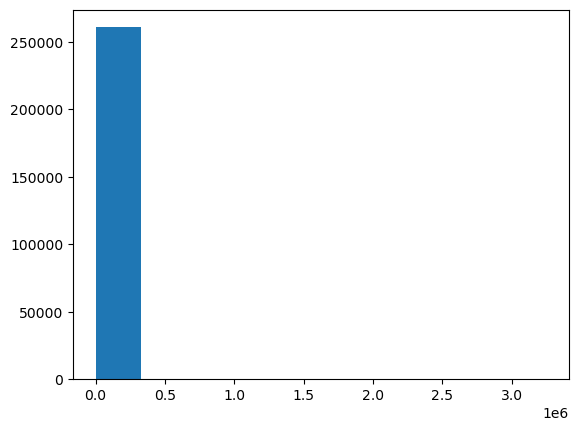

In [3]:
import matplotlib.pyplot as plt
plt.hist(data['energy_100g'])

In [19]:
# Pas très parlant, La valeur max a l'air vraiment forte, voyons de quel produit il s'agit (et similaires) :
data.loc[data['energy_100g'] > 1000000, ['product_name','brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'labels', 'labels_tags', 'labels_fr', 'ingredients_text']]

product_name brands brands_tags   categories categories_tags  \
212905  Pois cassés   Cora        cora  Pois cassés  fr:pois-casses   

       categories_fr      labels   labels_tags   labels_fr ingredients_text  
212905   Pois-casses  Point Vert  en:green-dot  Point Vert     Pois cassés.

In [28]:
# Les pois cassés sont très énergétiques mais guère plus que le riz par exemple, voyons la valeur pour ce dernier:
data.loc[data['product_name'].str[0:3] == 'riz', ['product_name','energy_100g']]

product_name  energy_100g
174834                     riz basmasti          NaN
175628                         riz thai       1496.0
190138                   riz long grain          NaN
190449                   riz long etuve          NaN
229810             riz bashmati complet          NaN
232493                 riz thai parfume          NaN
239701                   riz long grain       1485.0
250188                              riz          NaN
253256       riz de Camargue long blanc          NaN
270490  riz soufflé au goût de chocolat          NaN
270585                     riz&cereales          NaN
277865               riz cuisson rapide          NaN
283939                  riz quinoa coco          NaN
295044           riz au lait & cannelle       1823.0

Il y a donc clairement une erreur d'unité pour les poids cassés, on peut diviser par 1000 la valeur donnée :

In [11]:
data.iloc[212905, 57] = data.iloc[212905, 57] / 1000

In [8]:
data['energy_100g'].describe()

count    261113.000000
mean       1129.475080
std        1052.575658
min           0.000000
25%         377.000000
50%        1100.000000
75%        1674.000000
max      231199.000000
Name: energy_100g, dtype: float64

In [9]:
# On a encore un 'max' très haut ! Mais l'écart type est divisé par 6 !
data.loc[data['energy_100g'] > 100000, ['product_name','brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'labels', 'labels_tags', 'labels_fr', 'ingredients_text']]

product_name    brands  \
112681                     Premium Extra Virgin Olive Oil     Eliki   
249078  Légume Noisettes Carottes, 500 Grammes, Marque...      Iglo   
313483                 Nusco, Chocolate Spread, Chocolate  Brinkers   

       brands_tags categories categories_tags categories_fr labels  \
112681       eliki        NaN             NaN           NaN    NaN   
249078        iglo        NaN             NaN           NaN    NaN   
313483    brinkers        NaN             NaN           NaN    NaN   

       labels_tags labels_fr  \
112681         NaN       NaN   
249078         NaN       NaN   
313483         NaN       NaN   

                                         ingredients_text  
112681                            Extra virgin olive oil.  
249078                                                NaN  
313483  Sugar, vegetable oils, (rapeseed, palm), low f...

In [10]:
data.loc[data['product_name'].str[0:15] == 'Extra virgin ol', ['product_name','energy_100g']]

product_name  energy_100g
117375  Extra virgin olive oil           NaN
270810   Extra virgin olive oil          NaN
275391   Extra virgin olive oil          NaN
307371   Extra virgin olive oil          NaN
318410   Extra virgin olive oil          NaN

In [15]:
data.loc[data['product_name'].str[0:13] == 'Sunflower Oil', ['product_name','energy_100g']]

product_name  energy_100g
5860                                        Sunflower Oil       3586.0
67218                                       Sunflower Oil       3347.0
88127            Sunflower Oil And Extra Virgin Olive Oil       3347.0
90153   Sunflower Oil, Extra Virgin Olive Oil & Grape ...       3347.0
96582                                       Sunflower Oil       3586.0
96583                                       Sunflower Oil       3586.0
165103                                      Sunflower Oil       3707.0
167583                                      Sunflower Oil       3347.0
170651             Sunflower Oil & Extra Virgin Olive Oil       3347.0
170652       Sunflower Oil & Extra Virgin Olive Oil Blend       3347.0
170953                                      Sunflower Oil       3887.0
174459                                      Sunflower Oil       3628.0
268368                                      Sunflower Oil       3887.0
283569                                      Sunflower Oil       3347.0
283577                                      Sunflower Oil       3347.0

In [13]:
data.loc[data['product_name'].str[0:9] == 'Virgin Ol', ['product_name','energy_100g']]

product_name  energy_100g
137174  Virgin Olive Oil       3347.0
155586  Virgin Olive Oil       3699.0

In [12]:
# Nous allons donc attribuer la valeur de 3500 aux huiles d'olives sans 'energy_100g' et aussi à celle 'trop energetique'
data.iloc[112681, 57] = 3500
indList = data.loc[data['product_name'].str[0:15] == 'Extra virgin ol', 'product_name',].index
for i in indList :
    data.iloc[i, 57] = 3500


In [13]:
# pour le deuxième produit, plus compliqué à comparer, on divise le chiffre par 1000
data.iloc[249078, 57] = data.iloc[249078, 57] / 1000

In [23]:
data.loc[data['product_name'].str[0:16] == 'Chocolate Spread', ['product_name','energy_100g']]

product_name  energy_100g
117488  Chocolate Spread       2264.0
140546  Chocolate Spread       1653.0
174136  Chocolate Spread       1674.0

In [14]:
# pour le troisième produit, on peut aussi diviser le chiffre par 1000
data.iloc[313483, 57] = data.iloc[313483, 57] / 1000

In [25]:
data['energy_100g'].describe()

count    261118.000000
mean       1127.526630
std         856.206566
min           0.000000
25%         377.000000
50%        1100.000000
75%        1674.000000
max       94140.000000
Name: energy_100g, dtype: float64

Dans le but de systématiser la correction à tous les produits ayant une valeur excessive, voyons ceux qui sont entre 4000 et 5000 :
<br>Rq: dans les tableaux nutritionnels sérieux (organismes de santé) consultables en ligne, les produits les plus caloriques sont certaines margarines, dont l'apport énergétique ne dépasse pas 4000 KJ / 100g. Les produits au delà de cette valeur sont donc probablement surestimés.

In [28]:
data.loc[(data['energy_100g'] > 4000) & (data['energy_100g'] < 5000), ['product_name','brands', 'brands_tags', 'ingredients_text', 'energy_100g']]

product_name                          brands  \
772     Ginger Candy Sweetened With Raw Cane                    Reed's  Inc.   
14399                          Honey Peanuts               Big Y Foods  Inc.   
19668               Canola & Olive Spray Oil  The Hain Celestial Group  Inc.   
19669            Vegan Non-Aerosol Spray Oil  The Hain Celestial Group  Inc.   
27587                  Hardwood Smoked Bacon          Harmons,  Hill Meat Co   
...                                      ...                             ...   
284350      Ths Super Tea, Organic White Tea  Fujian Blue Lake Foods Co. Ltd   
289548                  Praliné Con Nocciole                  Coop Fine Food   
293165                            Le Convive                             NaN   
304274                Gnocchi E Pasta Fresca                         Stroppa   
320538                Chicken Cup Of Noodles                           Maggi   

                          brands_tags  \
772                        reed-s-inc   
14399                 big-y-foods-inc   
19668    the-hain-celestial-group-inc   
19669    the-hain-celestial-group-inc   
27587            harmons,hill-meat-co   
...                               ...   
284350  fujian-blue-lake-foods-co-ltd   
289548                 coop-fine-food   
293165                            NaN   
304274                        stroppa   
320538                          maggi   

                                         ingredients_text  energy_100g  
772               Diced baby ginger root, raw cane sugar.       4435.0  
14399   Peanuts, sugar, honey, salt, peanut oil, corn ...       4335.0  
19668   Mechanically (expeller) pressed refined canola...       4184.0  
19669   Mechanically (expeller) pressed refined canola...       4184.0  
27587   Cured with: water, salt, brown sugar, sodium p...       4707.0  
...                                                   ...          ...  
284350                         Nop 100% organic white tea       4184.0  
289548                                                NaN       4210.0  
293165                                                NaN       4689.0  
304274                                                NaN       4828.0  
320538                                                NaN       4602.0  

[68 rows x 5 columns]

On a beaucoup de valeurs excessives mais pas avec un facteur 1000; Probablement que certaines ont été mal converties de calories en joules, d'autres mal saisies. Voyons ce qui reste au delà de 5000 :

In [20]:
data.loc[data['energy_100g'] > 5000, ['product_name','brands', 'brands_tags', 'ingredients_text', 'energy_100g']].sort_values('energy_100g')

product_name                     brands  \
183135                        Diot de Savoie               Mont Charvin   
56561                          Tawny' Orange            Wilkin sons ltd   
242076               Sirop Frucci, Thé Pêche                     Frucci   
236490      Madeleines Au Miel (14% De Miel)           GAEC De Merignan   
199660                           Chevre Pane                   Valcrest   
...                                      ...                        ...   
176697                                bubbly                 dairy milk   
153704                       Salsa Hot Sauce  Mayan Foods  S.A. De C.V.   
219279                                   NaN                     Picard   
317148                                   NaN                        NaN   
119184  Sophia, Italian Drink, Squeezed Lime          Sophia Foods Inc.   

                   brands_tags  \
183135            mont-charvin   
56561          wilkin-sons-ltd   
242076                  frucci   
236490        gaec-de-merignan   
199660                valcrest   
...                        ...   
176697              dairy-milk   
153704  mayan-foods-s-a-de-c-v   
219279                  picard   
317148                     NaN   
119184        sophia-foods-inc   

                                         ingredients_text  energy_100g  
183135                                                NaN       5050.0  
56561                                                 NaN       5054.0  
242076                                                NaN       5100.0  
236490                                                NaN       5104.0  
199660                                                NaN       5205.0  
...                                                   ...          ...  
176697                                                NaN      22000.0  
153704  Red habanero peppers, water, spices, xanthan g...      26861.0  
219279                                                NaN      69292.0  
317148                                                NaN      87217.0  
119184  Water, lime juice, acidificant; citric acid, n...      94140.0  

[82 rows x 5 columns]

In [19]:
data.loc[317148][57:70]

energy_100g                   87217.0
energy-from-fat_100g              NaN
fat_100g                          0.0
saturated-fat_100g                NaN
monounsaturated-fat_100g          NaN
polyunsaturated-fat_100g          NaN
omega-3-fat_100g                  NaN
alpha-linolenic-acid_100g         NaN
eicosapentaenoic-acid_100g        NaN
docosahexaenoic-acid_100g         NaN
omega-6-fat_100g                  NaN
linoleic-acid_100g                NaN
omega-9-fat_100g                  NaN
Name: 317148, dtype: object

In [21]:
data.loc[219279][57:70]

energy_100g                   69292.0
energy-from-fat_100g              NaN
fat_100g                          0.5
saturated-fat_100g               0.01
monounsaturated-fat_100g          NaN
polyunsaturated-fat_100g          NaN
omega-3-fat_100g                  NaN
alpha-linolenic-acid_100g         NaN
eicosapentaenoic-acid_100g        NaN
docosahexaenoic-acid_100g         NaN
omega-6-fat_100g                  NaN
linoleic-acid_100g                NaN
omega-9-fat_100g                  NaN
Name: 219279, dtype: object

Nous avons donc 68 + 82 -2 = 148 (nous allons supprimer les deux examinés ci-dessus) produits surestimés concernant l'apport énergétique. Nous allons essayer de les associer à une catégorie ou autre groupe qui permettrait de corriger leurs valeurs avec par exemple la médiane de la catégorie.
<br>Mais avant, comme nous devons supprimer deux lignes, voyons s'il n'y en a pas d'autres inexploitables :

In [22]:
data.loc[data['energy_100g'].isna() & data['saturated-fat_100g'].isna() & data['sugars_100g'].isna() & data['fiber_100g'].isna() & data['proteins_100g'].isna() & data['sodium_100g'].isna() & data['salt_100g'].isna(), 'product_name'].count()

44211

In [6]:
# suppression des lignes inexploitables pour le nutriscore :
li_elim = data.loc[data['energy_100g'].isna() & data['saturated-fat_100g'].isna() & data['sugars_100g'].isna() & data['fiber_100g'].isna() & data['proteins_100g'].isna() & data['sodium_100g'].isna() & data['salt_100g'].isna(), 'product_name'].index
compteur = 0
for ind in li_elim[1:1000] :  # processus long, on commence donc par une petite partie pour évaluer la durée
    data = data.drop(index=ind, axis=0)
    compteur  += 1
    if compteur % 100 == 0 :
        print(str(compteur))


100
200
300
400
500
600
700
800
900


In [7]:
for ind in li_elim[1000:10001] :
    data = data.drop(index=ind, axis=0)
    compteur  += 1
    if compteur % 500 == 0 :
        print(str(compteur))


1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [8]:
for ind in li_elim[10001:30001] :
    data = data.drop(index=ind, axis=0)
    compteur  += 1
    if compteur % 1000 == 0 :
        print(str(compteur))


11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000


In [9]:
for ind in li_elim[30001:] :
    data = data.drop(index=ind, axis=0)
    compteur  += 1
    if compteur % 1000 == 0 :
        print(str(compteur))


31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000


KeyboardInterrupt: 

J'ai interrompu le processus ci-dessus parce qu'il continuait après avoir atteint le 'Count()' de mes lignes (44211) mais finallement c'est normal car le 'Count()' sur une Series (ici la liste des 'product_name' pour mes lignes) retourne le nombre de valeurs NON NULLES, alors que le '.index' retourne tous les index. Donc je continu :

In [10]:
data.shape

(272729, 125)

In [11]:
len(li_elim)

58607

In [12]:
li_elim = data.loc[data['energy_100g'].isna() & data['saturated-fat_100g'].isna() & data['sugars_100g'].isna() & data['fiber_100g'].isna() & data['proteins_100g'].isna() & data['sodium_100g'].isna() & data['salt_100g'].isna(), 'product_name'].index

In [13]:
len(li_elim)

10587

In [14]:
for ind in li_elim :
    data = data.drop(index=ind, axis=0)
    compteur  += 1
    if compteur % 1000 == 0 :
        print(str(compteur))


49000
50000
51000
52000
53000
54000
55000
56000
57000
58000


In [68]:
data.reset_index(drop=True)
data.to_csv('fr.openfoodfacts.org.products.csv', sep='	')

In [18]:
data.loc[data['energy_100g'] > 4000, ['product_name','brands', 'brands_tags', 'ingredients_text', 'energy_100g']].sort_values('energy_100g')

product_name                     brands  \
79650          Italian Black Truffle Almonds      The Squirrel Brand Co   
212696      Mini-bonbons Sans Sucres, Menthe                       Cora   
245541               Assortiment de roulades                     Auchan   
246057              Mini pizza chevre lardon                     Auchan   
184458            Pruneaux d'Agen Dénoyautés               Golden Fruit   
...                                      ...                        ...   
176697                                bubbly                 dairy milk   
153704                       Salsa Hot Sauce  Mayan Foods  S.A. De C.V.   
219279                                   NaN                     Picard   
317148                                   NaN                        NaN   
119184  Sophia, Italian Drink, Squeezed Lime          Sophia Foods Inc.   

                   brands_tags  \
79650    the-squirrel-brand-co   
212696                    cora   
245541                  auchan   
246057                  auchan   
184458            golden-fruit   
...                        ...   
176697              dairy-milk   
153704  mayan-foods-s-a-de-c-v   
219279                  picard   
317148                     NaN   
119184        sophia-foods-inc   

                                         ingredients_text  energy_100g  
79650   Almonds, vegetable oil (peanut, cotton seed, s...       4033.0  
212696                                                NaN       4058.0  
245541                                                NaN       4071.0  
246057                                                NaN       4092.0  
184458  Pruneaux d'Agen très gros - 44 à 55 fruits aux...       4117.0  
...                                                   ...          ...  
176697                                                NaN      22000.0  
153704  Red habanero peppers, water, spices, xanthan g...      26861.0  
219279                                                NaN      69292.0  
317148                                                NaN      87217.0  
119184  Water, lime juice, acidificant; citric acid, n...      94140.0  

[150 rows x 5 columns]

In [19]:
data = data.drop(index=219279, axis=0)
data = data.drop(index=317148, axis=0)

In [21]:
data.loc[data['energy_100g'] > 4000, ['product_name','pnns_groups_1', 'pnns_groups_2', 'main_category', 'main_category_fr', 'energy_100g']].sort_values('energy_100g')

product_name          pnns_groups_1  \
79650                Italian Black Truffle Almonds                    NaN   
212696            Mini-bonbons Sans Sucres, Menthe          Sugary snacks   
245541                     Assortiment de roulades                    NaN   
246057                    Mini pizza chevre lardon                    NaN   
184458                  Pruneaux d'Agen Dénoyautés  Fruits and vegetables   
...                                            ...                    ...   
181668                                         NaN                    NaN   
245288  mini choux goût fromage de chèvre - poivre           Salty snacks   
176697                                      bubbly          Sugary snacks   
153704                             Salsa Hot Sauce                    NaN   
119184        Sophia, Italian Drink, Squeezed Lime                    NaN   

             pnns_groups_2    main_category main_category_fr  energy_100g  
79650                  NaN              NaN              NaN       4033.0  
212696              Sweets       en:candies          Bonbons       4058.0  
245541                 NaN              NaN              NaN       4071.0  
246057                 NaN              NaN              NaN       4092.0  
184458        Dried fruits  en:dried-fruits      Fruits secs       4117.0  
...                    ...              ...              ...          ...  
181668                 NaN              NaN              NaN      16000.0  
245288          Appetizers  en:salty-snacks     Snacks salés      18700.0  
176697  Chocolate products    en:chocolates        Chocolats      22000.0  
153704                 NaN              NaN              NaN      26861.0  
119184                 NaN              NaN              NaN      94140.0  

[148 rows x 6 columns]

In [30]:
data = data.drop(index=181668, axis=0)  # après examen du produit

In [31]:
data.loc[data['main_category_fr'] == 'Bonbons', 'energy_100g'].mean()

1582.8925084364453

In [32]:
data.loc[data['main_category_fr'] == 'Bonbons', 'energy_100g'].median()

1559.0

In [59]:
# on impute une valeur réaliste aux 'bonbons' ayant une valeur erronée :
compteur = 0
ind_list = data.loc[data['energy_100g'] > 4000, 'product_name'].index
for ind in ind_list :
    if data.loc[ind]['main_category_fr'] == 'Bonbons' :
        data.iloc[ind,57] = 1570
        compteur += 1


In [36]:
data.loc[data['main_category_fr'] == 'Fruits secs', 'energy_100g'].mean()

1388.5486880466472

In [37]:
data.loc[data['main_category_fr'] == 'Fruits secs', 'energy_100g'].median()

1283.0

In [61]:
# on impute une valeur réaliste aux fruits secs ayant une valeur erronée :
for ind in ind_list :
    if data.loc[ind]['main_category_fr'] == 'Fruits secs' :
        data.iloc[ind,57] = 1325
        compteur += 1


In [39]:
data.loc[data['main_category_fr'] == 'Snacks salés', 'energy_100g'].mean()

1951.4330412844035

In [40]:
data.loc[data['main_category_fr'] == 'Snacks salés', 'energy_100g'].median()

2008.0

In [63]:
for ind in ind_list :
    if data.loc[ind]['main_category_fr'] == 'Snacks salés' :
        data.iloc[ind,57] = 1980
        compteur += 1


In [43]:
data.loc[data['main_category_fr'] == 'Chocolats', 'energy_100g'].mean()

2274.006271996616

In [44]:
data.loc[data['main_category_fr'] == 'Chocolats', 'energy_100g'].median()

2288.0

In [65]:
for ind in ind_list :
    try :
        if data.loc[ind]['main_category_fr'] == 'Chocolats' :
            data.iloc[ind,57] = 2280
            compteur += 1
    except :
        continue


In [46]:
ind_list[0:20]

Int64Index([  772,  5440, 14399, 15660, 19668, 19669, 20070, 27587, 27849,
            35143, 35308, 35366, 35372, 46967, 55851, 55852, 55878, 55961,
            56561, 66156],
           dtype='int64')

In [67]:
data.loc[data['energy_100g'] > 4000, ['product_name','pnns_groups_1', 'pnns_groups_2', 'main_category', 'main_category_fr', 'energy_100g']].sort_values('energy_100g')

product_name  \
79650                       Italian Black Truffle Almonds   
212696                   Mini-bonbons Sans Sucres, Menthe   
245541                            Assortiment de roulades   
246057                           Mini pizza chevre lardon   
184458                         Pruneaux d'Agen Dénoyautés   
...                                                   ...   
223295  Huiles vierge biologique de Colza - première p...   
245288         mini choux goût fromage de chèvre - poivre   
176697                                             bubbly   
153704                                    Salsa Hot Sauce   
119184               Sophia, Italian Drink, Squeezed Lime   

                pnns_groups_1       pnns_groups_2      main_category  \
79650                     NaN                 NaN                NaN   
212696          Sugary snacks              Sweets         en:candies   
245541                    NaN                 NaN                NaN   
246057                    NaN                 NaN                NaN   
184458  Fruits and vegetables        Dried fruits    en:dried-fruits   
...                       ...                 ...                ...   
223295         Fat and sauces                Fats  en:vegetable-oils   
245288           Salty snacks          Appetizers    en:salty-snacks   
176697          Sugary snacks  Chocolate products      en:chocolates   
153704                    NaN                 NaN                NaN   
119184                    NaN                 NaN                NaN   

       main_category_fr  energy_100g  
79650               NaN       4033.0  
212696          Bonbons       4058.0  
245541              NaN       4071.0  
246057              NaN       4092.0  
184458      Fruits secs       4117.0  
...                 ...          ...  
223295           Huiles      15481.0  
245288     Snacks salés      18700.0  
176697        Chocolats      22000.0  
153704              NaN      26861.0  
119184              NaN      94140.0  

[147 rows x 6 columns]

Pourquoi la liste n'a t'elle pas vraiment changé malgré 3 produits retirés et 4 (au moins) rectifiés donc sortis ??
<br> On recommence après redemarrage du notebook :

In [4]:
data.loc[212696]['main_category_fr']

'Tartes'

In [7]:
ind_list = data.loc[data['energy_100g'] > 4000, 'product_name'].index
compteur = 0
for ind in ind_list :
    if data.loc[ind]['main_category_fr'] == 'Bonbons' :
        data.iloc[ind,57] = 1570
        compteur += 1

compteur

1

In [8]:
for ind in ind_list :
    if data.loc[ind]['main_category_fr'] == 'Fruits secs' :
        data.iloc[ind,57] = 1325
        compteur += 1

compteur

2

In [9]:
for ind in ind_list :
    if data.loc[ind]['main_category_fr'] == 'Snacks salés' :
        data.iloc[ind,57] = 1980
        compteur += 1

compteur

3

In [10]:
for ind in ind_list :
    try :
        if data.loc[ind]['main_category_fr'] == 'Chocolats' :
            data.iloc[ind,57] = 2280
            compteur += 1
    except :
        continue

compteur

5

In [11]:
data.loc[data['energy_100g'] > 4000, ['product_name','pnns_groups_1', 'pnns_groups_2', 'main_category', 'main_category_fr', 'energy_100g']].sort_values('energy_100g')

product_name   pnns_groups_1  \
77434                       Italian Black Truffle Almonds             NaN   
216874                            Assortiment de roulades             NaN   
217304                           Mini pizza chevre lardon             NaN   
205572  Flammekueche Recette Alsacienne U Les Saveurs,...             NaN   
180732                  Confiture de Châtaignes d'Ardèche   Sugary snacks   
...                                                   ...             ...   
111574                              Flave!, Assorted Fish             NaN   
45982                               Instant Aka Miso Soup             NaN   
201991  Huiles vierge biologique de Colza - première p...  Fat and sauces   
148813                                    Salsa Hot Sauce             NaN   
114863               Sophia, Italian Drink, Squeezed Lime             NaN   

       pnns_groups_2      main_category main_category_fr  energy_100g  
77434            NaN                NaN              NaN       4033.0  
216874           NaN                NaN              NaN       4071.0  
217304           NaN                NaN              NaN       4092.0  
205572           NaN                NaN              NaN       4125.0  
180732        Sweets            en:jams       Confitures       4159.0  
...              ...                ...              ...          ...  
111574           NaN                NaN              NaN      14347.0  
45982            NaN                NaN              NaN      14644.0  
201991          Fats  en:vegetable-oils           Huiles      15481.0  
148813           NaN                NaN              NaN      26861.0  
114863           NaN                NaN              NaN      94140.0  

[142 rows x 6 columns]

Maintenant les rectifications entreprises fonctionnent, et les valeurs imputées sont pertinentes, néanmoins ce n'est pas un moyen rapide de correction.

In [12]:
for ind in ind_list :
    if data.loc[ind]['main_category_fr'] == 'Huiles' :
        data.iloc[ind,57] = 3500
        compteur += 1

compteur

6

In [15]:
# reste-t-il beaucoup de categories à traiter ?
data.loc[(data['energy_100g'] > 4000) & ~(data['main_category_fr'].isna()), ['main_category_fr', 'energy_100g']].sort_values('energy_100g')

main_category_fr  energy_100g
180732                 Confitures       4159.0
217703       Sardines en conserve       4268.0
173395                    Lardons       4356.0
198832                 Confitures       4410.0
217704       Sardines en conserve       4485.0
176152                    Pickles       4975.0
194919                   Boissons       5263.0
188366                   Boissons       5268.0
213917           Kit-pour-fajitas       5481.0
214093              Fonds-de-veau       5598.0
180330                   Boissons       5904.0
190359              Snacks sucrés       6109.0
192397  Purées de pommes de terre       6138.0
212771                   Emmental       6803.0
220464         Fromages de France       7029.0
202718                      Pains       9050.0
171709              Snacks sucrés       9983.0

In [16]:
# On ne va pas toutes les corriger maintenant, mais encore 2 ou 3
data.loc[data['main_category_fr'] == 'Confitures', 'energy_100g'].mean()

922.6067979002627

In [18]:
data.loc[data['main_category_fr'] == 'Confitures', 'energy_100g'].median()

983.0

In [19]:
for ind in ind_list :
    if data.loc[ind]['main_category_fr'] == 'Confitures' :
        data.iloc[ind,57] = 950
        compteur += 1

compteur

8

In [20]:
data.loc[data['main_category_fr'] == 'Sardines en conserve', 'energy_100g'].mean()

992.5422053231939

In [21]:
data.loc[data['main_category_fr'] == 'Sardines en conserve', 'energy_100g'].median()

929.0

In [22]:
for ind in ind_list :
    if data.loc[ind]['main_category_fr'] == 'Sardines en conserve' :
        data.iloc[ind,57] = 950
        compteur += 1

compteur

10

In [23]:
data.loc[data['main_category_fr'].str[0:7] == 'Fromage', 'energy_100g'].mean()

1139.1944296070203

In [24]:
data.loc[data['main_category_fr'].str[0:7] == 'Fromage', 'energy_100g'].median()

1210.0

In [25]:
for ind in ind_list :
    if (data.loc[ind]['main_category_fr'] == 'Fromages de France') | (data.loc[ind]['main_category_fr'] == 'Emmental') :
        data.iloc[ind,57] = 1190
        compteur += 1

compteur

12

In [26]:
# Pour ceux qui restent, on met le champ à Nan (on verra plus tard pour traiter les valeurs manquantes) :
compteur = 0
import numpy as np
for ind in ind_list :
    if data.loc[ind]['energy_100g'] > 4000 :
        data.iloc[ind,57] = np.NaN
        compteur += 1

compteur

135

In [28]:
# Notons qu'on a une excellente corréraltion entre la présence d'une 'main_category_fr' et la présence des autres groupes :
data.loc[(data['energy_100g'].isna()) & ~(data['main_category_fr'].isna()), ['pnns_groups_1', 'pnns_groups_2', 'main_category_fr', 'main_category_fr']]

pnns_groups_1          pnns_groups_2  main_category_fr  \
18439          Fish Meat Eggs         Processed meat         Saucisses   
23069    Cereals and potatoes               Potatoes   Pommes de terre   
23090    Cereals and potatoes               Potatoes   Pommes de terre   
24372    Cereals and potatoes      Breakfast cereals   Petit-déjeuners   
65581   Fruits and vegetables             Vegetables         Conserves   
...                       ...                    ...               ...   
260660                unknown                unknown  en:Bottled-water   
260678        Composite foods         One-dish meals            Soupes   
260832              Beverages  Non-sugared beverages          Boissons   
260954              Beverages  Non-sugared beverages         Infusions   
262000  Fruits and vegetables                 Fruits            Fruits   

        main_category_fr  
18439          Saucisses  
23069    Pommes de terre  
23090    Pommes de terre  
24372    Petit-déjeuners  
65581          Conserves  
...                  ...  
260660  en:Bottled-water  
260678            Soupes  
260832          Boissons  
260954         Infusions  
262000            Fruits  

[387 rows x 4 columns]

In [37]:
# Nous nous sommes intéressé aux apports énergétiques surestimés, mais sont ils parfois sousestimés ?
data.loc[data['energy_100g'] == 0.0, ['product_name','brands', 'brands_tags', 'ingredients_text','main_category_fr']][150:170]

product_name  \
3078  Liquid Water Enhancer With Vitamins B3 B6 B12,...   
3127                            Black Tea, Orange Spice   
3135         Energy Liquid Water Enhancer With Caffeine   
3136                              Liquid Water Enhancer   
3141                                     Yellow Mustard   
3150                                     Yellow Mustard   
3151                                     Yellow Mustard   
3214  Zero Calorie Vitamin Enhanced Water Beverage, ...   
3215                     Green Tea Pods, Jasmine, Lemon   
3216       Vitamin Enhanced Water Beverage, Mango Melon   
3243                Psst..., 100 Decaffeinated Tea Bags   
3246                     Hamburger Dill Fast Food Chips   
3279                             100% Natural Green Tea   
3289                             Stevia Blend Sweetener   
3292                                 Coarse Kosher Salt   
3339                                       Kosher Dills   
3340                                        Dill Slices   
3341                                 Kosher Dill Spears   
3389                    Sugar Free Bread & Butter Chips   
3406                                Earl Grey Black Tea   

                                  brands                      brands_tags  \
3078             Kroger,  The Kroger Co.             kroger,the-kroger-co   
3127                   Private Selection                private-selection   
3135                              Kroger                           kroger   
3136                              Kroger                           kroger   
3141                              Kroger                           kroger   
3150                           Fredmeyer                        fredmeyer   
3151                           Fredmeyer                        fredmeyer   
3214             Kroger,  The Kroger Co.             kroger,the-kroger-co   
3215  Private Selection,  The Kroger Co.  private-selection,the-kroger-co   
3216             Kroger,  The Kroger Co.             kroger,the-kroger-co   
3243                             Psst...                             psst   
3246                              Kroger                           kroger   
3279                              Kroger                           kroger   
3289                              Kroger                           kroger   
3292                              Kroger                           kroger   
3339                             Psst...                             psst   
3340                                P$$T                              p-t   
3341                             Psst...                             psst   
3389                              Kroger                           kroger   
3406                   Private Selection                private-selection   

                                       ingredients_text main_category_fr  
3078  Water, propylene glycol, malic acid, citric ac...              NaN  
3127  Black tea, orange peels, cloves, natural flavo...              NaN  
3135  Water, citric acid, propylene glycol, caffeine...              NaN  
3136  Water, propylene glycol, malic acid, citric ac...              NaN  
3141  Vinegar, water, mustard seed, salt, turmeric, ...              NaN  
3150  Vinegar, water, mustard seed, salt, turmeric, ...              NaN  
3151  Vinegar, water, mustard seed, salt, turmeric, ...              NaN  
3214  Reverse osmosis water, erythritol, natural fla...              NaN  
3215  Green tea, spearmint, lemon grass, blackberry ...              NaN  
3216  Reverse osmosis water, erythritol, natural fla...              NaN  
3243                           Decaffeinated black tea.              NaN  
3246  Cucumbers, water, vinegar, salt, alum, calcium...              NaN  
3279                                         Green tea.              NaN  
3289                Erythritol, reb a* natural flavors.              NaN  
3292  Salt, yellow prussiate of soda (anti-caking ag...     

A part de rares produits contenant du jus de fruit ou du blé, aprés examen d'un echantillon il semble que les produits déclarés sans calorie soient effectivement très peu caloriques. L'unité globale de l'apport énergétique est ici le kcal, il faudra donc multiplier les valeurs par 4,18 lors du calcul du nutriscore.

(array([7.3393e+04, 3.6848e+04, 4.1480e+04, 5.2090e+04, 2.9847e+04,
        8.6780e+03, 2.0000e+03, 2.6760e+03, 1.9500e+02, 1.0000e+00]),
 array([   0.   ,  475.831,  951.662, 1427.493, 1903.324, 2379.155,
        2854.986, 3330.817, 3806.648, 4282.479, 4758.31 ]),
 <BarContainer object of 10 artists>)

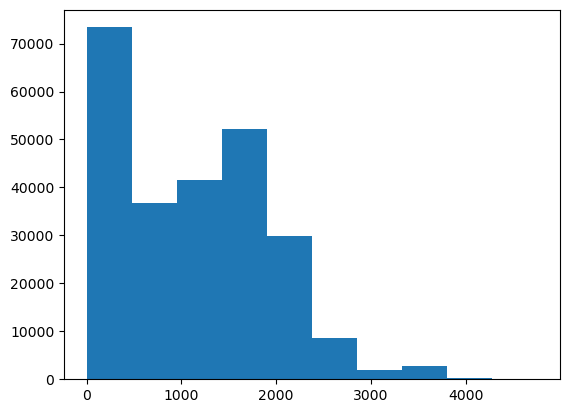

In [4]:
# import matplotlib.pyplot as plt
plt.hist(data['energy_100g'])

Cet histogramme est quand même meilleur qu'avant le nettoyage !
<br>
<br>Cherchons maintenant les valeurs érronées concernant **la contenance en sucres :** <a name="E3">

In [40]:
data['sugars_100g'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 262139 entries, 0 to 262138
Series name: sugars_100g
Non-Null Count   Dtype  
--------------   -----  
244969 non-null  float64
dtypes: float64(1)
memory usage: 2.0 MB


In [4]:
data['sugars_100g'].describe()

count    244971.000000
mean         16.003484
std          22.327284
min         -17.860000
25%           1.300000
50%           5.710000
75%          24.000000
max        3520.000000
Name: sugars_100g, dtype: float64

(array([2.4497e+05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ -17.86 ,  335.926,  689.712, 1043.498, 1397.284, 1751.07 ,
        2104.856, 2458.642, 2812.428, 3166.214, 3520.   ]),
 <BarContainer object of 10 artists>)

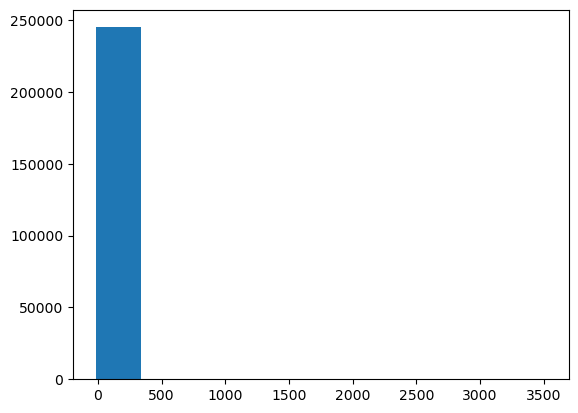

In [5]:
plt.hist(data['sugars_100g'])

In [44]:
# Encore bizarre cet histogramme ! On met à 0 les valeurs négatives :
compteur = 0
for i in range(262139) :
    if data.iloc[i,73] < 0.0 :
        data.iloc[i,73] = 0.0
        compteur += 1

compteur

7

In [45]:
data['sugars_100g'].describe()

count    244969.000000
mean         16.003680
std          22.327224
min           0.000000
25%           1.300000
50%           5.710000
75%          24.000000
max        3520.000000
Name: sugars_100g, dtype: float64

In [46]:
data.loc[data['sugars_100g'] == 100.0, ['product_name','brands','sucrose_100g','glucose_100g','fructose_100g','ingredients_text','main_category_fr']]

product_name  \
35      Sweeteners, Demerara Turbinado Sugar   
69      Sweeteners, Organic Fair Trade Sugar   
163        Organic Unrefined Mascobado Sugar   
362                      Tnt Exploding Candy   
363                          Exploding Candy   
...                                      ...   
260088       Iq Accessories, Inc., Sprinkles   
260101                       Sucre Vanilliné   
261465                Australian White Sugar   
261711                           White Sugar   
261784                      Pure Icing Sugar   

                                  brands  sucrose_100g  glucose_100g  \
35      Wholesome,  Wholesome Sweeteners           NaN           NaN   
69      Wholesome,  Wholesome Sweeteners           NaN           NaN   
163                            Alter Eco           NaN           NaN   
362                          Angry Birds           NaN           NaN   
363                          Angry Birds           NaN           NaN   
...                                  ...           ...           ...   
260088              Iq Accessories  Inc.           NaN           NaN   
260101                     Alsa,Unilever           NaN           NaN   
261465                             Coles           NaN           NaN   
261711                Bundaberg,Bonsucro           NaN           NaN   
261784                               CSR           NaN           NaN   

        fructose_100g                                   ingredients_text  \
35                NaN                           Raw cane demerara sugar.   
69                NaN                     Organic evaporated cane juice.   
163               NaN                 Organic unrefined mascobado sugar.   
362               NaN  Sucrose, lactose (milk), corn syrup solids, na...   
363               NaN  Sucrose, lactose (milk), corn syrup solids, na...   
...               ...                                                ...   
260088            NaN                Sugar, fd&c red 3 and carnauba wax.   
260101            NaN                              Sucre, arôme vanille.   
261465            NaN                              Australian Cane Sugar   
261711            NaN                                         Cane Sugar   
261784            NaN                                        Cane Sugar.   

       main_category_fr  
35                  NaN  
69                  NaN  
163                 NaN  
362                 NaN  
363                 NaN  
...                 ...  
260088              NaN  
260101           Sucres  
261465           Sucres  
261711           Sucres  
261784           Sucres  

[1011 rows x 7 columns]

In [48]:
data.loc[data['sugars_100g'] > 100.0, ['product_name','brands','sugars_100g','sucrose_100g','glucose_100g','fructose_100g','ingredients_text','main_category_fr']]

product_name                    brands  \
108502                              Tomato Ketchup                     Heinz   
129002                              Mango Jalapeno  California Flavored Nuts   
150871  Tamarind Juice With Nata De Coco, Tamarind               Kelly Jelly   
186649                      Sirop d'Agave brun bio                     Bjorg   
212177                               Sirop d'agave             Carrefour Bio   
225841                            Agave Syrup dark                     Allos   
225842                           Sirop d agave pur                     Allos   
225850                              Agavendicksaft                     Allos   
228452                              Agavendicksaft                   enerBIO   
228453                       Agavendicksaft Dunkel                  ener Bio   
258655          Nusco, Chocolate Spread, Chocolate                  Brinkers   
259912                                         NaN                Sodastream   

        sugars_100g  sucrose_100g  glucose_100g  fructose_100g  \
108502       134.00           NaN           NaN            NaN   
129002       110.71           NaN           NaN            NaN   
150871       166.67           NaN           NaN            NaN   
186649       104.00           NaN           NaN          101.0   
212177       105.00           NaN           NaN            NaN   
225841       103.50           NaN           NaN            NaN   
225842       103.50           NaN           NaN            NaN   
225850       103.50           NaN           NaN            NaN   
228452       103.50           NaN           NaN            NaN   
228453       103.00           NaN           NaN            NaN   
258655      3520.00           NaN           NaN            NaN   
259912       100.80           NaN           NaN            NaN   

                                         ingredients_text  \
108502  Tomato concentrate from red ripe tomatoes, dis...   
129002  Mangoes, sulfur dioxide (used as a preservativ...   
150871  Tamarind juice 10% sugar 10% nata de coco 20% ...   
186649                                100% sirop d'agave.   
212177  Sirop d'agave concentré issu de l'agriculture ...   
225841                          konzentrierter Agavensaft   
225842                                                NaN   
225850                         Konzentrierter Agavensaft.   
228452                          konzentrierter Agavensaft   
228453                       Konzetrierter Bio Agavensaft   
258655  Sugar, vegetable oils, (rapeseed, palm), low f...   
259912                                                NaN   

                  main_category_fr  
108502                    Epicerie  
129002                         NaN  
150871                         NaN  
186649                 Édulcorants  
212177  Produits à tartiner sucrés  
225841                 Édulcorants  
225842                 Édulcorants  
225850                 Édulcorants  
228452                 Édulcorants  
228453                 Édulcorants  
258655                         NaN  
259912                         NaN

In [50]:
data.loc[258655][57:77]

energy_100g                   0.231199
energy-from-fat_100g               NaN
fat_100g                           NaN
saturated-fat_100g               550.0
monounsaturated-fat_100g           NaN
polyunsaturated-fat_100g           NaN
omega-3-fat_100g                   NaN
alpha-linolenic-acid_100g          NaN
eicosapentaenoic-acid_100g         NaN
docosahexaenoic-acid_100g          NaN
omega-6-fat_100g                   NaN
linoleic-acid_100g                 NaN
omega-9-fat_100g                   NaN
trans-fat_100g                     NaN
cholesterol_100g                   NaN
carbohydrates_100g                 NaN
sugars_100g                     3520.0
sucrose_100g                       NaN
glucose_100g                       NaN
fructose_100g                      NaN
Name: 258655, dtype: object

In [52]:
# corrigeons ce produit :
data.iloc[258655,57] = 2312.0
data.iloc[258655,73] = np.NaN  # taux de sucre

In [53]:
# et les autres, pas très nombreux :
data.loc[data['product_name'].str[0:14] == 'Tomato Ketchup', 'sugars_100g'].mean()

22.85205128205129

In [54]:
data.iloc[108502,73] = 22.50  # le ketchup

In [55]:
data.iloc[129002,73] = np.NaN

In [56]:
data.iloc[150871,73] = 10.0

In [57]:
data.iloc[259912,73] = np.NaN

Pour tous les sirops d'agave, on a une comptabilisation du sucre spécifique, on laisse donc comme cela.

In [58]:
data['sugars_100g'].describe()

count    244966.000000
mean         15.987549
std          21.170126
min           0.000000
25%           1.300000
50%           5.710000
75%          24.000000
max         105.000000
Name: sugars_100g, dtype: float64

In [59]:
# les produits non sucrés ?
data.loc[data['sugars_100g'] < 1.0, ['product_name','brands','sucrose_100g','glucose_100g','fructose_100g','ingredients_text','main_category_fr']]

product_name  \
170                                          Salade Cesar   
175                                       Quiche Lorraine   
191                            Freshly Baked Italian Loaf   
200     La Brea Bakery Ciabatta Loaf Freshly Baked In ...   
207     Naturally Flavored Beverage Enhancer With Othe...   
...                                                   ...   
262113                        tuna chunks in spring water   
262121                     Fisherman's Friend Miel-Citron   
262136                                 Thé vert Earl grey   
262137  Mint Melange Tea A Blend Of Peppermint, Lemon ...   
262138                    Sugar Free Drink Mix, Peach Tea   

                       brands  sucrose_100g  glucose_100g  fructose_100g  \
170        Kirkland Signature           NaN           NaN            NaN   
175        Kirkland Signature           NaN           NaN            NaN   
191              Fresh & Easy           NaN           NaN            NaN   
200              Fresh & Easy           NaN           NaN            NaN   
207     Easter Unlimited Inc.           NaN           NaN            NaN   
...                       ...           ...           ...            ...   
262113                princes           NaN           NaN            NaN   
262121     Fisherman's Friend           NaN           NaN            NaN   
262136                Lobodis           NaN           NaN            NaN   
262137           Trader Joe's           NaN           NaN            NaN   
262138          Market Pantry           NaN           NaN            NaN   

                                         ingredients_text main_category_fr  
170     INGREDIENTS : LAITUE. VINAIGRETTE (HUILE DE CA...    Légumes frais  
175     INGRÉDIENTS : GARNITURE (SUBSTANCES LAITIÈRES....   Plats préparés  
191     Enriched wheatflour (wheat flour, niacin, redu...              NaN  
200     Unbleached enriched flour (wheat flour, malted...              NaN  
207     Apple juice from concentrate (43%), water, bla...              NaN  
...                                                   ...              ...  
262113                                 Tuna, spring water            Thons  
262121  Édulcorants : sorbitols, sucralose, acésulfame...          Bonbons  
262136  thé vert, arôme naturel bergamote avec autres ...       Thés verts  
262137  Organic peppermint, organic lemon grass, organ...              NaN  
262138  Citric acid, maltodextrin, instant tea, aspart...              NaN  

[54526 rows x 7 columns]

In [61]:
data['sucrose_100g'].count()

72

In [62]:
data['glucose_100g'].count()

26

In [63]:
data['fructose_100g'].count()

38

Nous ne pourrons guère compter sur le détail de l'apport en sucre pour nous aider à valoriser les 'sugars_100g' à NaN !

(array([144577.,  35827.,  20120.,  15238.,  11723.,   8402.,   4874.,
          3375.,   1763.,   1309.]),
 array([  0. ,  10.5,  21. ,  31.5,  42. ,  52.5,  63. ,  73.5,  84. ,
         94.5, 105. ]),
 <BarContainer object of 10 artists>)

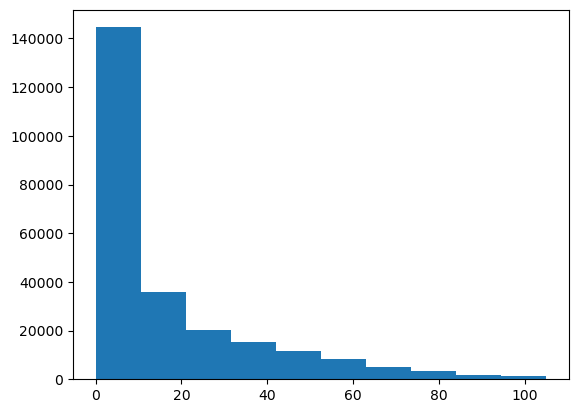

In [5]:
plt.hist(data['sugars_100g'])

De nouveau, l'histogramme est nettement plus parlant après le nettoyage.
<br>
<br>Interessons nous maintenant aux apports en **matières grasses saturées :** <a name="E4">

In [64]:
data['fat_100g'].count()

243470

In [65]:
data['saturated-fat_100g'].count()

229553

In [66]:
data['monounsaturated-fat_100g'].count()

22823

In [67]:
data['polyunsaturated-fat_100g'].count()

22859

In [74]:
for fat_type in ['omega-3-fat_100g','alpha-linolenic-acid_100g','eicosapentaenoic-acid_100g','docosahexaenoic-acid_100g','omega-6-fat_100g','linoleic-acid_100g','omega-9-fat_100g','trans-fat_100g','cholesterol_100g'] :
    print(fat_type + '---' + str(data[fat_type].count()))


omega-3-fat_100g---838
alpha-linolenic-acid_100g---186
eicosapentaenoic-acid_100g---29
docosahexaenoic-acid_100g---51
omega-6-fat_100g---188
linoleic-acid_100g---149
omega-9-fat_100g---21
trans-fat_100g---143295
cholesterol_100g---144088


In [75]:
data['saturated-fat_100g'].describe()

count    229553.000000
mean          5.129955
std           8.014248
min           0.000000
25%           0.000000
50%           1.790000
75%           7.140000
max         550.000000
Name: saturated-fat_100g, dtype: float64

(array([2.28764e+05, 7.87000e+02, 0.00000e+00, 2.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  0.,  55., 110., 165., 220., 275., 330., 385., 440., 495., 550.]),
 <BarContainer object of 10 artists>)

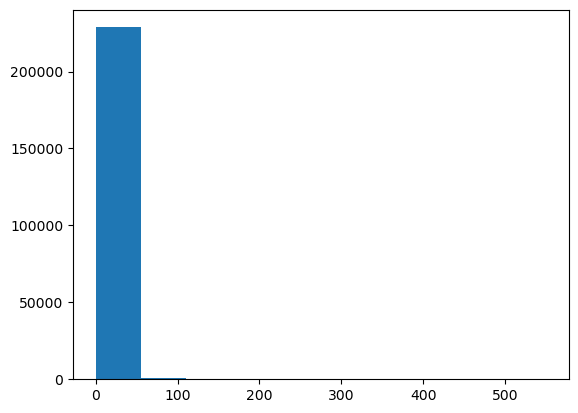

In [6]:
plt.hist(data['saturated-fat_100g'])

In [76]:
data.loc[data['saturated-fat_100g'] == 100.0, ['product_name','brands','monounsaturated-fat_100g','polyunsaturated-fat_100g','trans-fat_100g','ingredients_text','main_category_fr']]

product_name                   brands  \
71595                   Ez Thun Dipping Aid                   Wilton   
109259       Premium Extra Virgin Olive Oil                    Eliki   
135483                   Pure Grapeseed Oil  Overseas Food Dist Inc.   
140048                          Coconut Oil                     Desi   
140049                          Coconut Oil                     Desi   
158202             St. Jamaica, Coconut Oil        St Jamaica Legend   
170654                    Frites & Fritures                Vita d'Or   
174642                             Jog'Frit                 Jog'Frit   
199878  Huile De Tournesol Végétale 2 Litre                Carrefour   
233975         Végétaline (offre familiale)               Végétaline   
238653                                  Eau                    Vital   
243711                                 test                      NaN   

        monounsaturated-fat_100g  polyunsaturated-fat_100g  trans-fat_100g  \
71595                        NaN                       NaN             NaN   
109259                    557.14                     57.14             0.0   
135483                     20.00                     66.67             0.0   
140048                       NaN                       NaN             0.0   
140049                       NaN                       NaN             0.0   
158202                       NaN                       NaN             0.0   
170654                       NaN                       NaN             NaN   
174642                       NaN                       NaN             NaN   
199878                       NaN                       NaN             NaN   
233975                       NaN                       NaN             NaN   
238653                       NaN                       NaN             NaN   
243711                       NaN                       NaN             NaN   

                                         ingredients_text  \
71595   Partially hydrogenated palm kernel oil, soy le...   
109259                            Extra virgin olive oil.   
135483                            100% pure grapeseed oil   
140048                                        Coconut oil   
140049                                        Coconut oil   
158202                                   Pure coconut oil   
170654              Huile de coprah totalement hydrogénée   
174642       Huile de noix de coco totalement hydrogénée.   
199878                                                NaN   
233975                                                NaN   
238653                                                NaN   
243711                                                NaN   

                  main_category_fr  
71595                          NaN  
109259                         NaN  
135483                         NaN  
140048                         NaN  
140049                         NaN  
158202                         NaN  
170654  Matières grasses végétales  
174642  Matières grasses végétales  
199878                         NaN  
233975                      Huiles  
238653                         NaN  
243711                         NaN

In [77]:
data.loc[238653][0:15]

code                                                        6091035082004.0
url                       http://world-fr.openfoodfacts.org/produit/6091...
creator                                                             kiliweb
created_t                                                        1487698302
created_datetime                                  2017-02-21 17:31:42+00:00
last_modified_t                                                  1487698304
last_modified_datetime                            2017-02-21 17:31:44+00:00
product_name                                                            Eau
generic_name                                                            NaN
quantity                                                                NaN
packaging                                                               NaN
packaging_tags                                                          NaN
brands                                                                Vital
brands_tags 

In [78]:
# suppression de produits inutiles
data = data.drop(index=238653, axis=0)
data = data.drop(index=243711, axis=0)

In [80]:
# En vue de la correction du produit 109259 :
data.loc[data['product_name'].str[0:15] == 'Extra virgin ol', ['product_name','brands','saturated-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g','trans-fat_100g','main_category_fr']]

product_name               brands  saturated-fat_100g  \
113098  Extra virgin olive oil   Member's selection                  NaN   
231573   Extra virgin olive oil           Morrissons                 NaN   
234087   Extra virgin olive oil              koronis                 NaN   
255100   Extra virgin olive oil          La Española                 NaN   
261392   Extra virgin olive oil          Super value                 NaN   

        monounsaturated-fat_100g  polyunsaturated-fat_100g  trans-fat_100g  \
113098                       NaN                       NaN             NaN   
231573                       NaN                       NaN             NaN   
234087                       NaN                       NaN             NaN   
255100                       NaN                       NaN             NaN   
261392                       NaN                       NaN             NaN   

              main_category_fr  
113098                     NaN  
231573  Huiles d'olive vierges  
234087                     NaN  
255100                     NaN  
261392                     NaN

In [82]:
data.loc[data['main_category_fr'].str[0:14] == 'Huiles d\'olive', ['product_name','brands','saturated-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g','trans-fat_100g','main_category_fr']]

product_name  \
30874   Olive oil, basil and garlic tomato sauce    
36062                                   Olive Oil   
52337             Bertolli Extra Virgin Olive Oil   
80841                     Original Pure Olive Oil   
98112      Organic Italian Extra Virgin Olive Oil   
...                                           ...   
257838                         Azeite tradicional   
259783                 Huile d'Olive vierge extra   
261308                     Natives Olivenöl extra   
261394    Griechisches natives Bio-Olivenöl extra   
261696                 Moro Light Taste Olive Oil   

                                          brands  saturated-fat_100g  \
30874                                   Bertolli                 0.0   
36062   I can't believe it's not butter,Unilever                14.3   
52337                Bertolli,  Deoleo Usa  Inc.                13.3   
80841                                       Star                13.3   
98112                            Marks & Spencer                14.0   
...                                          ...                 ...   
257838                                       Dia                12.0   
259783                               La Bio Idea                11.0   
261308                                    Clever                14.0   
261394                            Spar Natur*pur                13.0   
261696                                      Moro                13.0   

        monounsaturated-fat_100g  polyunsaturated-fat_100g  trans-fat_100g  \
30874                        NaN                       NaN             0.0   
36062                       10.7                      17.9             0.0   
52337                       66.7                      13.3             0.0   
80841                       66.7                      10.0             0.2   
98112                        NaN                       NaN             NaN   
...                          ...                       ...             ...   
257838                       NaN                       NaN             NaN   
259783                       NaN                       NaN             NaN   
261308                       NaN                       NaN             NaN   
261394                       NaN                       NaN             NaN   
261696                       7.1                       7.0             0.1   

       main_category_fr  
30874    Huiles d'olive  
36062    Huiles d'olive  
52337    Huiles d'olive  
80841    Huiles d'olive  
98112    Huiles d'olive  
...                 ...  
257838   Huiles d'olive  
259783   Huiles d'olive  
261308   Huiles d'olive  
261394   Huiles d'olive  
261696   Huiles d'olive  

[274 rows x 7 columns]

In [84]:
data.loc[data['main_category_fr'].str[0:14] == 'Huiles d\'olive', 'saturated-fat_100g'].mean()

14.498195488721805

In [85]:
# et correction :
data.iloc[109259,60] = 14.5
data.iloc[109259,61] = np.NaN
data.iloc[109259,62] = np.NaN

In [86]:
# pour les huiles d'olives ayant 'saturated-fat_100g' = 0, on leur affecte la valeur moyenne :
data.loc[(data['main_category_fr'].str[0:14] == 'Huiles d\'olive') & (data['saturated-fat_100g'] == 0.0), 'saturated-fat_100g'] = data.loc[data['main_category_fr'].str[0:14] == 'Huiles d\'olive', 'saturated-fat_100g'].mean()

In [11]:
data.reset_index(drop=True)
data.to_csv('fr.openfoodfacts.org.products.csv', sep='	')

In [13]:
data.loc[data['saturated-fat_100g'] == 550.0, ['product_name','brands','monounsaturated-fat_100g','polyunsaturated-fat_100g','trans-fat_100g','ingredients_text','main_category_fr']]

product_name    brands  \
258653  Nusco, Chocolate Spread, Chocolate  Brinkers   

        monounsaturated-fat_100g  polyunsaturated-fat_100g  trans-fat_100g  \
258653                       NaN                       NaN             NaN   

                                         ingredients_text main_category_fr  
258653  Sugar, vegetable oils, (rapeseed, palm), low f...              NaN

In [14]:
data.loc[data['product_name'].str[0:16] == 'Chocolate Spread', 'saturated-fat_100g'].mean()

13.92

In [16]:
data.iloc[258653,60] = 14.0

In [17]:
data.loc[data['saturated-fat_100g'] > 100.0, ['product_name','brands','monounsaturated-fat_100g','polyunsaturated-fat_100g','trans-fat_100g','ingredients_text','main_category_fr']]

product_name    brands  \
115049  Raw 100% Cacao, With Bits Of Delicate Dates  Antidote   
216657   mini choux goût fromage de chèvre - poivre    Auchan   

        monounsaturated-fat_100g  polyunsaturated-fat_100g  trans-fat_100g  \
115049                       NaN                       NaN             NaN   
216657                       NaN                       NaN             NaN   

                                         ingredients_text main_category_fr  
115049                Cacao beans*, dates, cacao butter*.              NaN  
216657  matières grasses végétales de palme et de palm...     Snacks salés

In [19]:
data.iloc[115049,60] = np.NaN
data.iloc[216657,60] = np.NaN

In [20]:
data['saturated-fat_100g'].describe()

count    229549.000000
mean          5.124850
std           7.906338
min           0.000000
25%           0.000000
50%           1.790000
75%           7.140000
max         100.000000
Name: saturated-fat_100g, dtype: float64

(array([2.06763e+05, 2.93740e+04, 8.72800e+03, 9.27000e+02, 2.22000e+02,
        8.01000e+02, 1.22000e+02, 2.40000e+01, 1.58000e+02, 8.90000e+01]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

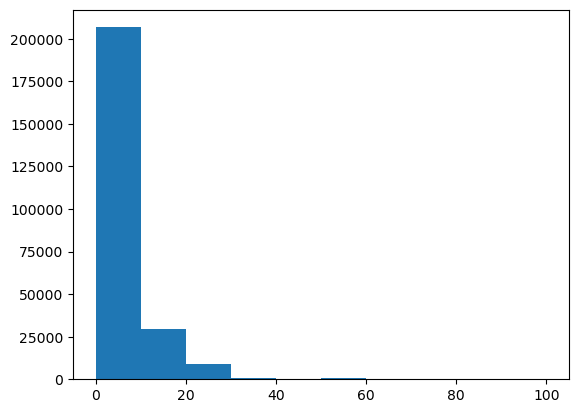

In [6]:
plt.hist(data['saturated-fat_100g'])  # ajouté tardivement, après imputation des valeurs manquantes

Avons nous des outliers concernant **l'apport en sel ?**  <a name="E5">

In [21]:
data['salt_100g'].describe()

count    255507.000000
mean          2.028640
std         128.270207
min           0.000000
25%           0.063500
50%           0.581660
75%           1.374140
max       64312.800000
Name: salt_100g, dtype: float64

In [22]:
# En effet ! voyons si c'est meilleur en sodium :
data['sodium_100g'].describe()

count    255460.000000
mean          0.798822
std          50.504724
min           0.000000
25%           0.025000
50%           0.229000
75%           0.541000
max       25320.000000
Name: sodium_100g, dtype: float64

In [23]:
data.loc[data['salt_100g'] > 100.0, ['product_name','brands','salt_100g','sodium_100g','ingredients_text','main_category_fr']]

product_name         brands  \
430                               Mediterranean Sea Salt  Olde Thompson   
1268                                 Dill Pickle Cashews        Emerald   
3292                                  Coarse Kosher Salt         Kroger   
6849                                       Fine Sea Salt       Shurfine   
7781                                        Butter Beans        Spartan   
...                                                  ...            ...   
239158                                     Bamboo Shoots        Slender   
241550                                               NaN            NaN   
241551                                               NaN            NaN   
249753                                      Kids Cristal          Aproz   
253736  Tartufi Di Fassia, Grey Salt With White Truffles     D.O.S. Srl   

        salt_100g  sodium_100g  \
430     105.83418    41.667000   
1268    870.85678   342.857000   
3292    101.60000    40.000000   
6849    101.60000    40.000000   
7781    781.53768   307.692000   
...           ...          ...   
239158  448.23634   176.471000   
241550  103.00000    40.551181   
241551  103.00000    40.551181   
249753  930.00000   366.141732   
253736  106.68000    42.000000   

                                         ingredients_text main_category_fr  
430                               Mediterranean sea salt.              NaN  
1268    Cashews, seasoning (maltodextrin, salt, garlic...              NaN  
3292    Salt, yellow prussiate of soda (anti-caking ag...              NaN  
6849                                            Sea salt.              NaN  
7781    Prepared large lima beans, water, sugar, salt,...              NaN  
...                                                   ...              ...  
239158                      Slender bamboo shoots, water.              NaN  
241550  sucre, farine de blé, noisettes, huiles végéta...              NaN  
241551                                                NaN              NaN  
249753                                                NaN              NaN  
253736  Grey salt from guerande, dried white truffles ...              NaN  

[158 rows x 6 columns]

In [24]:
data.loc[(data['salt_100g'] > 100.0) & (data['product_name'].str[-4:] == 'Salt'), ['product_name','brands','salt_100g','sodium_100g','ingredients_text','main_category_fr']]

product_name         brands  salt_100g  sodium_100g  \
430            Mediterranean Sea Salt  Olde Thompson  105.83418       41.667   
3292               Coarse Kosher Salt         Kroger  101.60000       40.000   
6849                    Fine Sea Salt       Shurfine  101.60000       40.000   
18328          Mediterranean Sea Salt  Olde Thompson  105.83418       41.667   
18331             Himalayan Pink Salt  Olde Thompson  106.68000       42.000   
...                               ...            ...        ...          ...   
170768      Applewood Smoked Sea Salt   Fresh & Easy  101.60000       40.000   
170769            Himalayan Pink Salt   Fresh & Easy  106.68000       42.000   
170772  Mediterranean Coarse Sea Salt   Fresh & Easy  105.83418       41.667   
174431            Himalayan Pink Salt   World Market  106.68000       42.000   
236730              Organic Dill Salt      Aromasong  100.51034       39.571   

                                         ingredients_text main_category_fr  
430                               Mediterranean sea salt.              NaN  
3292    Salt, yellow prussiate of soda (anti-caking ag...              NaN  
6849                                            Sea salt.              NaN  
18328                              Mediterranean sea salt              NaN  
18331                                 Himalayan pink salt              NaN  
...                                                   ...              ...  
170768                         Applewood smoked sea salt.              NaN  
170769                               Himalayan pink salt.              NaN  
170772                                          Sea salt.              NaN  
174431                                Himalayan pink salt              NaN  
236730                Natural dead sea salt, organic dill              NaN  

[80 rows x 6 columns]

In [25]:
data.loc[(data['salt_100g'] > 100.0) & (data['product_name'].str[-4:] == 'Salt'), ['product_name','brands','salt_100g','sodium_100g','ingredients_text','main_category_fr']][0:20]

product_name                           brands  \
430                   Mediterranean Sea Salt                    Olde Thompson   
3292                      Coarse Kosher Salt                           Kroger   
6849                           Fine Sea Salt                         Shurfine   
18328                 Mediterranean Sea Salt                    Olde Thompson   
18331                    Himalayan Pink Salt                    Olde Thompson   
18334  Olde Thompson, Mediterranean Sea Salt              Olde Thompson  Inc.   
18339                    Himalayan Pink Salt                    Olde Thompson   
18340                 Mediterranean Sea Salt                    Olde Thompson   
18341                    Himalayan Pink Salt                     Old Thompson   
18342                    Himalayan Pink Salt                    Olde Thompson   
18352                 Mediterranean Sea Salt              Olde Thompson  Inc.   
18359                 Mediterranean Sea Salt                    Olde Thompson   
18360                    Himalayan Pink Salt                    Olde Thompson   
21037            Fine Mediterranean Sea Salt                           Morton   
21044                               Sea Salt                           Morton   
21050                     Coarse Kosher Salt                           Morton   
21051                            Kosher Salt                           Morton   
21052                     Coarse Kosher Salt                           Morton   
21053                     Coarse Kosher Salt                           Morton   
24960                          Fine Sea Salt  Giant Eagle,  Giant Eagle  Inc.   

       salt_100g  sodium_100g  \
430    105.83418       41.667   
3292   101.60000       40.000   
6849   101.60000       40.000   
18328  105.83418       41.667   
18331  106.68000       42.000   
18334  101.60000       40.000   
18339  106.68000       42.000   
18340  101.60000       40.000   
18341  105.66400       41.600   
18342  106.68000       42.000   
18352  101.60000       40.000   
18359  105.83418       41.667   
18360  106.68000       42.000   
21037  101.60000       40.000   
21044  103.41356       40.714   
21050  102.00000       40.000   
21051  101.60000       40.000   
21052  101.60000       40.000   
21053  101.60000       40.000   
24960  101.60000       40.000   

                                        ingredients_text main_category_fr  
430                              Mediterranean sea salt.              NaN  
3292   Salt, yellow prussiate of soda (anti-caking ag...              NaN  
6849                                           Sea salt.              NaN  
18328                             Mediterranean sea salt              NaN  
18331                                Himalayan pink salt              NaN  
18334                            Mediterranean sea salt.              NaN  
18339                               Himalayan pink salt.              NaN  
18340                             Mediterranean sea salt              NaN  
18341                                Himalayan pink salt              NaN  
18342                                Himalayan pink salt              NaN  
18352                            Mediterranean sea salt.              NaN  
18359                            Mediterranean sea salt.              NaN  
18360                                Himalayan pink salt              NaN  
21037  Sea salt, yellow prussiate of soda (anticaking...              NaN  
21044                                           Sea salt              NaN  
21050  Salt, Yellow Prussiate of Soda (Anti-caking ag...             Sels  
21051  Salt, yellow prussiate of soda (anti-caking ag...              NaN  
21052  Salt, yellow prussiate of soda (anticaking age...              NaN  
21053  Salt, yellow prussiate of soda (anticaking age...              NaN  
24960                                          Sea salt.              NaN

In [26]:
data.loc[(data['salt_100g'] > 100.0) & (data['product_name'].str[-4:] == 'Salt'), ['product_name','brands','salt_100g','sodium_100g','ingredients_text','main_category_fr']][20:40]

product_name  \
28010       Fratelli Comino, Tochetti With Sea Salt   
32786                       Hawaiian Black Sea Salt   
38718                                   Garlic Salt   
39435  Fleur De Sel, Hand-Harvested French Sea Salt   
39436                                 Grey Sea Salt   
39437                        Fine Crystals Sea Salt   
39438                      Coarse Crystals Sea Salt   
42070          Premium Spice Blends, Seasoning Salt   
42793                            Coarse Kosher Salt   
42794                                 Fine Sea Salt   
48978                        Mediterranean Sea Salt   
48980                           Himalayan Pink Salt   
62530                          Steak Seasoning Salt   
63863                                          Salt   
66501                                   Kosher Salt   
72100                                 Fine Sea Salt   
72514                               Coarse Sea Salt   
72515                          All Natural Sea Salt   
72516                               Kosher Sea Salt   
76946                       Pickling & Canning Salt   

                              brands  salt_100g  sodium_100g  \
28010  International Nut Corporation  177.80000       70.000   
32786                      Food Club  103.55326       40.769   
38718                     Price Rite  234.95000       92.500   
39435                         Roland  101.60000       40.000   
39436                         Roland  101.60000       40.000   
39437                         Roland  101.60000       40.000   
39438                         Roland  101.60000       40.000   
42070              Twin Tree Gardens  124.46000       49.000   
42793             Essential Everyday  101.60000       40.000   
42794             Essential Everyday  101.60000       40.000   
48978                           Weis  105.83418       41.667   
48980                           Weis  106.68000       42.000   
62530                 Spice Classics  104.14000       41.000   
63863                   Trader Joe's  104.14000       41.000   
66501                    Best Choice  101.60000       40.000   
72100                      Centrella  101.60000       40.000   
72514                         Alessi  101.60000       40.000   
72515    Alessi,  Vigo Importing Co.  101.60000       40.000   
72516                         Alessi  101.60000       40.000   
76946                     Mrs. Wages  100.01250       39.375   

                                        ingredients_text main_category_fr  
28010  Wheat flour, water, extravirgin olive oil 10%,...              NaN  
32786                   Sea salt and activated charcoal.              NaN  
38718  Salt, garlic powder, granulated garlic, calciu...              NaN  
39435   Sea salt hand-harvested from france's ile de re.             Sels  
39436   Sea salt hand-harvested from france's ile de re.              NaN  
39437  Natural sea salt, magnesium carbonate (2% maxi...              NaN  
39438                                  Natural sea salt.              NaN  
42070  Salt, paprika, soy, msg, ground celery, ground...              NaN  
42793  Salt, yellow prussiate of soda (anti-caking ag...              NaN  
42794  Salt, yellow prussiate of soda (anti-caking ag...              NaN  
48978                            Mediterranean sea salt.              NaN  
48980                               Himalayan pink salt.              NaN  
62530  Salt, spices (including black pepper), onion, ...              NaN  
63863                                          Sea salt.              NaN  
66501                                              Salt.              NaN  
72100                                           Sea salt              NaN  
72514                              All natural sea salt.              NaN  
72515                              All natural sea salt.              NaN  
72516                                          Sea salt.              NaN  
76946             

In [30]:
data.iloc[28010,83] = np.NaN
data.iloc[28010,84] = np.NaN
data.iloc[42070,83] = np.NaN
data.iloc[42070,84] = np.NaN
data.iloc[38718,83] = np.NaN
data.iloc[38718,84] = np.NaN

In [35]:
data.columns[83]

'salt_100g'

In [31]:
data.loc[(data['salt_100g'] > 100.0) & (data['product_name'].str[-4:] == 'Salt'), ['product_name','brands','salt_100g','sodium_100g','ingredients_text','main_category_fr']][37:57]

product_name  \
88644                              Coarse Kosher Salt   
88647            Nature's Supreme, Pure Fine Sea Salt   
91534                       La Flor, Grinder Sea Salt   
103672                                  Fine Sea Salt   
103673                                Coarse Sea Salt   
103837                                       Sea Salt   
104153                                   Popcorn Salt   
106346                            Himalayan Pink Salt   
107986                                       Sea Salt   
111100                           All Natural Sea Salt   
111657                            Himalayan Pink Salt   
111663                        Himalayan Pink Sea Salt   
113390                                       Sea Salt   
114864                       Premium Iodized Sea Salt   
116410                             Coarse Kosher Salt   
116554  Evolution Salt Co, Gourmet Pink Himalaya Salt   
116602                                 Seasoning Salt   
117300                  Primordial Himalayan Sea Salt   
117301                  Primordial Himalayan Sea Salt   
121391                         Mediterranean Sea Salt   

                                               brands  salt_100g  sodium_100g  \
88644           Clover Valley,  Gel Spice Company Inc  101.60000       40.000   
88647                              Gel Spice Co.  Inc  101.60000       40.000   
91534                         La Flor Products Co Inc  101.60000       40.000   
103672                                       Racconto  113.32210       44.615   
103673                                       Racconto  113.32210       44.615   
103837                                       Frontier  107.04322       42.143   
104153                                     Mighty Pop  114.30000       45.000   
106346                             Kirkland Signature  107.00000       42.000   
107986  365 Everyday Value,  Whole Foods Market  Inc.  103.41356       40.714   
111100                                  Earth's Pride  105.83418       41.667   
111657                                        Raley's  106.68000       42.000   
111663                                        Raley's  106.68000       42.000   
113390                       Mustapha's Mediterranean  149.86000       59.000   
114864                                         Sophia  101.60000       40.000   
116410                               Old World Flavor  101.60000       40.000   
116554                    Buck Creek Ostrich Products  254.00000      100.000   
116602                                Anisa's Secrets  677.33418      266.667   
117300                                    Himala Salt  112.18418       44.167   
117301                               No  Manufacturer  107.69600       42.400   
121391                                          Ahold  101.60000       40.000   

                                         ingredients_text main_category_fr  
88644   Salt, yellow prussiate of soda (anticaking age...              NaN  
88647                                            Sea salt              NaN  
91534                                            Sea salt              NaN  
103672                                          Sea salt.              NaN  
103673                                          Sea salt.              NaN  
103837                              Sea salt coarse grind              NaN  
104153            Salt, colour, artificial butter flavour              NaN  
106346                                Himalayan Pink Salt             Sels  
107986                                          Sea salt.              NaN  
111100                             Mediterranean sea salt              NaN  
111657                               Himalayan pink salt.              NaN  
111663                               Himalayan pink salt.              NaN  
113390                              100% natural sea salt              NaN  
114864  Natural sea salt, potassium iodate 0,0051%, e5...      

In [32]:
data.iloc[116602,83] = np.NaN
data.iloc[116602,84] = np.NaN

In [33]:
data.loc[(data['salt_100g'] > 100.0) & (data['product_name'].str[-4:] == 'Salt'), ['product_name','brands','salt_100g','sodium_100g','ingredients_text','main_category_fr']][56:]

product_name  \
126873                   Gold, Mediterranean Sea Salt   
136644                                  Seasoned Salt   
136645                                  Seasoned Salt   
136646                                Pegs, Pink Salt   
137708                          Fine Iodized Sea Salt   
143020                                 Truffle & Salt   
147900                            Himalayan Pink Salt   
160315                                     Bacon Salt   
160316                                Molten Hot Salt   
160317                       Garlic And Rosemary Salt   
160318                         Mountain Mushroom Salt   
161077                                      Pink Salt   
165757  Gold, Adjustable Grinder, Pink Himalayan Salt   
169534                            Himalayan Pink Salt   
170767                                       Sea Salt   
170768                      Applewood Smoked Sea Salt   
170769                            Himalayan Pink Salt   
170772                  Mediterranean Coarse Sea Salt   
174431                            Himalayan Pink Salt   
236730                              Organic Dill Salt   

                               brands  salt_100g  sodium_100g  \
126873                         Meijer  105.83418       41.667   
136644                     Peg's Salt  111.76000       44.000   
136645                      Pegs Salt  111.76000       44.000   
136646  Humongous Entertainment  Inc.  121.92000       48.000   
137708                 La Santa Maria  103.71582       40.833   
143020               Sabatino Tartufi  109.22000       43.000   
147900                        Wbm Llc  106.68000       42.000   
160315                          Amola  118.11000       46.500   
160316                          Amola  118.36400       46.600   
160317                          Amola  118.11000       46.500   
160318                          Amola  118.11000       46.500   
161077                 Himalayan Chef  106.68000       42.000   
165757           Meijer,  Meijer Gold  106.68000       42.000   
169534                  Olde Thompson  106.68000       42.000   
170767                   Fresh & Easy  105.83418       41.667   
170768                   Fresh & Easy  101.60000       40.000   
170769                   Fresh & Easy  106.68000       42.000   
170772                   Fresh & Easy  105.83418       41.667   
174431                   World Market  106.68000       42.000   
236730                      Aromasong  100.51034       39.571   

                                         ingredients_text main_category_fr  
126873                                          Sea salt.              NaN  
136644  Kosher salt, garlic, spices, parsley, yellow p...              NaN  
136645  Kosher salt, garlic, spices, parsley, yellow p...              NaN  
136646  Pink himalayan salt, sea salt, garlic, spices,...              NaN  
137708                                           Sea salt              NaN  
143020                  Sea salt, black truffles, flavors              NaN  
147900                       Natural himalayan pink salt.              NaN  
160315          Sea salt, smoked sea salt, heritage pork.              NaN  
160316  Sea salt, cayenne pepper, bhut jolokia, habane...              NaN  
160317                         Sea salt, garlic, rosemary              NaN  
160318  Sea salt, lobster mushrooms, chanterelle mushr...              NaN  
161077                   100% natural himalayan pink salt              NaN  
165757                               Himalayan pink salt.              NaN  
169534                               Himalayan pink salt.              NaN  
170767                                          Sea salt.              NaN  
170768                         Applewood smoked sea salt.              NaN  
170769                               Himalayan pink salt.              NaN  
170772                                          Sea salt.              NaN  
174431        

In [36]:
data.iloc[136644,83] = np.NaN
data.iloc[136644,84] = np.NaN
data.iloc[143020,83] = np.NaN
data.iloc[143020,84] = np.NaN
data.iloc[160315,83] = np.NaN
data.iloc[160315,84] = np.NaN
data.iloc[160316,83] = np.NaN
data.iloc[160316,84] = np.NaN
data.iloc[160317,83] = np.NaN
data.iloc[160317,84] = np.NaN
data.iloc[160318,83] = np.NaN
data.iloc[160318,84] = np.NaN
data = data.drop(index=136645, axis=0) # en double

In [37]:
# après avoir corrigé des cas particuliers, nous allons restifier la valeur
# pour tous les produits ne contenant quasiment que du sel

ind_list = data.loc[(data['salt_100g'] > 100.0) & (data['product_name'].str[-4:] == 'Salt'), 'product_name'].index
for ind in ind_list :
    data.iloc[ind,83] = 100.0
    data.iloc[ind,84] = 40.0


In [38]:
data.loc[data['salt_100g'] > 100.0, ['product_name','brands','salt_100g','sodium_100g','ingredients_text','main_category_fr']]

product_name  \
1268                                  Dill Pickle Cashews   
7781                                         Butter Beans   
10823                             Autumn Cookie Selection   
18073                      Mediterranean Sea Salt Grinder   
18495   Adolph's, Prime Cut, Tenderizer Seasoned With ...   
...                                                   ...   
239158                                      Bamboo Shoots   
241550                                                NaN   
241551                                                NaN   
249753                                       Kids Cristal   
253736   Tartufi Di Fassia, Grey Salt With White Truffles   

                          brands  salt_100g  sodium_100g  \
1268                     Emerald  870.85678   342.857000   
7781                     Spartan  781.53768   307.692000   
10823   Caldo International Inc.  327.74128   129.032000   
18073                 Winn Dixie  105.83418    41.667000   
18495          Lawry's Foods Llc  101.60000    40.000000   
...                          ...        ...          ...   
239158                   Slender  448.23634   176.471000   
241550                       NaN  103.00000    40.551181   
241551                       NaN  103.00000    40.551181   
249753                     Aproz  930.00000   366.141732   
253736                D.O.S. Srl  106.68000    42.000000   

                                         ingredients_text main_category_fr  
1268    Cashews, seasoning (maltodextrin, salt, garlic...              NaN  
7781    Prepared large lima beans, water, sugar, salt,...              NaN  
10823   Wheat flour (bleached wheat flour enriched (ni...              NaN  
18073                             Mediterranean sea salt.              NaN  
18495   Salt, sugar, spices, (including turmeric), oni...              NaN  
...                                                   ...              ...  
239158                      Slender bamboo shoots, water.              NaN  
241550  sucre, farine de blé, noisettes, huiles végéta...              NaN  
241551                                                NaN              NaN  
249753                                                NaN              NaN  
253736  Grey salt from guerande, dried white truffles ...              NaN  

[88 rows x 6 columns]

In [39]:
# il reste encore 88 produits ...
data = data.drop(index=241551, axis=0) # en double

In [40]:
data.loc[data['salt_100g'] > 100.0, ['product_name','brands','salt_100g','sodium_100g','ingredients_text','main_category_fr']][0:20]

product_name  \
1268                                 Dill Pickle Cashews   
7781                                        Butter Beans   
10823                            Autumn Cookie Selection   
18073                     Mediterranean Sea Salt Grinder   
18495  Adolph's, Prime Cut, Tenderizer Seasoned With ...   
20248                      Special Blend, Peas & Carrots   
21045                       Mediterranean Sea Salt, Fine   
21300  Marie Sharp's, Orange Pulp Habanero Pepper Sau...   
22954                            Original Barbecue Sauce   
31530                 Light & Fit Greek Crunch - S'mores   
39439                                          Sea Sa;Lt   
49495                                  Premium Ice Cream   
50335                 Crispy Fried Onions, White Cheddar   
54455               Pure Carrot With Organic Lemon Juice   
56862                               String Cheese Snacks   
60324                                   Sea Salt Grinder   
66374  Rhodes, Bake N Serv, Cinnamon Rolls With Cream...   
66383  Rhodes, Bake N Serv, Cinnamon Rolls With Cream...   
73649                       Crawfish, Shrimp & Crab Boil   
73650                       Crawfish, Shrimp & Crab Boil   

                                          brands   salt_100g  sodium_100g  \
1268                                     Emerald   870.85678      342.857   
7781                                     Spartan   781.53768      307.692   
10823                   Caldo International Inc.   327.74128      129.032   
18073                                 Winn Dixie   105.83418       41.667   
18495                          Lawry's Foods Llc   101.60000       40.000   
20248                                  Del Monte   714.37500      281.250   
21045                                     Morton   101.60000       40.000   
21300                          Melinda's Limited   594.86800      234.200   
22954                        Billy Sims Barbecue  2032.00000      800.000   
31530                                     Dannon   153.00000       60.300   
39439                                     Roland   101.60000       40.000   
49495                                    Belmont   130.73634       51.471   
50335                                   French's  2177.14322      857.143   
54455  Lakewood,  Florida Bottling Company  Inc.   158.75000       62.500   
56862                                   Sargento  1799.16582      708.333   
60324                                Gold Emblem   101.60000       40.000   
66374                         Rhodes Bake-N-Serv  1098.37728      432.432   
66383                         Rhodes Bake-N-Serv   858.59112      338.028   
73649                                 Zatarain's   101.60000       40.000   
73650                                 Zatarain's   101.60000       40.000   

                                        ingredients_text main_category_fr  
1268   Cashews, seasoning (maltodextrin, salt, garlic...              NaN  
7781   Prepared large lima beans, water, sugar, salt,...              NaN  
10823  Wheat flour (bleached wheat flour enriched (ni...              NaN  
18073                            Mediterranean sea salt.              NaN  
18495  Salt, sugar, spices, (including turmeric), oni...              NaN  
20248  Vegetables (peas, carrots), water, sugar, sea ...              NaN  
21045  Sea salt, yellow prussiate of soda (anticaking...              NaN  
21300  Select yellow habanero peppers, orange pulp, o...              NaN  
22954  Tomato ketchup (red ripe tomatoes, distilled v...              NaN  
31530                                                NaN              NaN  
39439                                  Natural sea salt.              NaN  
49495  Cream, nonfat milk, sugar, corn syrup, cocoa (...              NaN  
50335  Onions, palm oil, wheat flour, white cheddar s...              NaN  
54455  Contains only: organic juice and organic puree...              NaN  
56862   Pasteurized milk,

In [41]:
data.iloc[18073,83] = 100.0
data.iloc[18073,84] = 40.0
data.iloc[21045,83] = 100.0
data.iloc[21045,84] = 40.0
data.iloc[39439,83] = 100.0
data.iloc[39439,84] = 40.0

In [42]:
data.loc[data['salt_100g'] > 100.0, ['product_name','brands','salt_100g','sodium_100g','ingredients_text','main_category_fr']][17:37]

product_name  \
73653                      Crawfish, Shrimp And Crab Boil   
79131                        Adobo Seasoning With Pimento   
79132              All Purpose Adobo Seasoning With Sazon   
88592                                       Sea Salt Fine   
91535                   Alderwood Smoked Sea Salt Grinder   
92246   Swiss Recipe Smoked Almonds & Sea Salt In Dark...   
102380                             Bastoncini Whole Wheat   
103642          Small Potato Dumplings, Potato Gnocchetti   
103838                               Sea Salt, Fine Grind   
105606                            Natural Yogurt Pretzels   
106301                     Mediterranean Sea Salt Grinder   
106386                     Lisy, Seasoned Meat Tenderizer   
109581                        Himalayan Pink Salt Grinder   
109643                     Mediterranean Sea Salt Grinder   
111656                            Mediterranean Sea Saalt   
114865                                    Coarse Crystals   
115491                             Flower Of Salt, Smoked   
115494                            Natural Sea Salt, Spicy   
116560                          Granlund's, Gummi Peaches   
116568                           Granlund's, Peco Brittle   

                                     brands   salt_100g  sodium_100g  \
73653                            Zatarain's   101.60000       40.000   
79131                              Vitarroz   190.50000       75.000   
79132                              Vitarroz   190.50000       75.000   
88592                 Gel Spice Company Inc   101.60000       40.000   
91535                        La Flor Spices   101.60000       40.000   
92246                               Wegmans  1318.38192      519.048   
102380                      Clemente Bakery  2452.41318      965.517   
103642                             Racconto  1139.15190      448.485   
103838                             Frontier   106.68000       42.000   
105606  Lipari Foods Operating Company  Llc   666.75000      262.500   
106301                   Kirkland Signature   105.83418       41.667   
106386                     Lisy Corporation   101.60000       40.000   
109581                           Winn-Dixie   106.68000       42.000   
109643                           Winn-Dixie   105.83418       41.667   
111656                              Raley's   105.83418       41.667   
114865                               Sophia   101.60000       40.000   
115491                                Silva   108.71200       42.800   
115494                                Silva   100.33000       39.500   
116560                Keeler & Dunkel  Inc.   123.90120       48.780   
116568                Keeler & Dunkel  Inc.   136.07034       53.571   

                                         ingredients_text main_category_fr  
73653   Contains: salt, dextrose, spices (including re...              NaN  
79131   Salt, spices (including paprika and turmeric),...              NaN  
79132   Salt, spices (including paprika and turmeric),...              NaN  
88592                                           Sea salt.              NaN  
91535              Natural sea salt smoked over alderwood              NaN  
92246   Sugar, chocolate liquor processed with alkali,...              NaN  
102380  Whole wheat and enriched flour, water, soybean...              NaN  
103642  70% potato puree (reconstituted potatoes with ...              NaN  
103838  Sea salt, magnesium hydrogen carbonate, magnes...              NaN  
105606  Natural yogurt (sucrose, fractionated palm ker...              NaN  
106301                            Mediterranean sea salt.              NaN  
106386  Salt, monosodium glutamate, dextrose, onion, p...              NaN  
109581                               Himalayan pink salt.              NaN  
109643                            Mediterranean sea salt.              NaN  
111656                            Mediterranean sea salt.              NaN  
114865  Natural se

In [43]:
data.iloc[88592,83] = 100.0
data.iloc[88592,84] = 40.0
data.iloc[91535,83] = 100.0
data.iloc[91535,84] = 40.0
data.iloc[106301,83] = 100.0
data.iloc[106301,84] = 40.0
data.iloc[109581,83] = 100.0
data.iloc[109581,84] = 40.0
data.iloc[109643,83] = 100.0
data.iloc[109643,84] = 40.0
data.iloc[111656,83] = 100.0
data.iloc[111656,84] = 40.0
data.iloc[114865,83] = 100.0
data.iloc[114865,84] = 40.0
data.iloc[115491,83] = 100.0
data.iloc[115491,84] = 40.0

In [44]:
data.loc[data['salt_100g'] > 100.0, ['product_name','brands','salt_100g','sodium_100g','ingredients_text','main_category_fr']][30:50]

product_name  \
116604          Anisa's Secrets, Rosemary Lemon Pepper   
116607                 Anisa's Secrets, Moroccan Spice   
116613              Anisa's Secrets, Poultry Seasoning   
116614                     Anisa's Secrets, Lemon Dill   
117484               Inc., California Thompson Raisins   
117646                            Smokey Tomato Speard   
127537  Roasted Garlic & Himalayan Pink Salt Seasoning   
127539        Habanero & Himalayan Pink Salt Seasoning   
127540                   Himalayan Pink Salt Seasoning   
127543        Sriracha & Himalayan Pink Salt Seasoning   
130487                          Chiles Habaneros Rojos   
132994                             Piri-Piri Hot Sauce   
134943                                Sauce & Marinade   
135954    Gold Raw & Dry Roasted Combo Trail Mix Blend   
136646                                 Pegs, Pink Salt   
137708                           Fine Iodized Sea Salt   
141056                                   Prickly Syrup   
141996      Pur Beverages, Energy Beverage, Acai Berry   
144074             Sweet Goodies White Chocolate Balls   
144241          Jim Kelly, Sea Salt Adjustable Grinder   

                                                brands    salt_100g  \
116604                   Universal Caddy Products Inc.    677.33418   
116607                   Universal Caddy Products Inc.    677.33418   
116613                   Universal Caddy Products Inc.    677.33418   
116614                   Universal Caddy Products Inc.    677.33418   
117484  Dsd Merchandisers,  D.S.D. Merchandisers  Inc.    317.50000   
117646                                Bader Publishing    604.76130   
127537                                    Dean Jacob's    107.10418   
127539                                  Dean & Jacob's    101.23678   
127540                                    Dean Jacob's    112.18418   
127543                                    Dean Jacob's    104.86644   
130487                                           Marin   3556.00000   
132994                               Taste Of Portugal    187.96000   
134943                                       Got Jerk!   3048.00000   
135954                       Perfect Balance Trail Mix    421.83812   
136646                   Humongous Entertainment  Inc.    121.92000   
137708                                  La Santa Maria    103.71582   
141056                               K. Benson Company  64312.80000   
141996           Mr. Beverages Old Time Cocktail Mixes    100.85324   
144074                                           Shefa    181.42966   
144241                                   Jim Kelly Inc    100.01250   

        sodium_100g                                   ingredients_text  \
116604      266.667  Rosemary, lemon peel, crushed red pepper flake...   
116607      266.667  Ground cumin, ground coriander, ground black p...   
116613      266.667  Ground sage, ground rosemary, thyme marjoram, ...   
116614      266.667  Dill leaf, lemon granules, sumac granulated ga...   
117484      125.000  California thompson seedless select raisins, s...   
117646      238.095  Ingredients: tomatoes (peeled ground tomatoes,...   
127537       42.167                   Himalayan salt, *roasted garlic.   
127539       39.857  Himalayan salt, sea salt, *onion, sugar, *garl...   
127540       44.167  Himalayan salt, *garlic, sea salt, *red bell p...   
127543       41.286  Himalayan salt, sea salt, chili pepper, *garli...   
130487     1400.000  Selected red habanero peppers, water, carrots,...   
132994       74.000  Hot peppers, water, salt, vinegar and sodium b...   
134943     1200.000  Onion, water, garlic, white vinegar, light bro...   
135954      166.078  Raw dried cranberries (cranberries, sugar, sun...   
136646       48.000  Pink himalayan salt, sea salt, garlic, spices,...   
137708       40.833                                           Sea salt   
141056    25320.000  Prickly pear juice, corn syrup, citric acid, f...   

In [45]:
data.iloc[137708,83] = 100.0
data.iloc[137708,84] = 40.0
data.iloc[144241,83] = 100.0
data.iloc[144241,84] = 40.0

In [46]:
data.loc[data['salt_100g'] > 100.0, ['product_name','brands','salt_100g','sodium_100g','ingredients_text','main_category_fr']][50:]

product_name  \
145861                              Quinoa Pasta Fusilli   
145862                         Quinoa Curvo Rigate Pasta   
147899       Himalayan Chef, Himalayan Pink Salt Grinder   
147900                               Himalayan Pink Salt   
150871        Tamarind Juice With Nata De Coco, Tamarind   
155704           Sausage Patties, Veggie Sausage Patties   
160295                               Dressing & Marinade   
161077                                         Pink Salt   
165757     Gold, Adjustable Grinder, Pink Himalayan Salt   
166904                                         Seasoning   
167332                                  Bruschetta Blend   
167336           Sweet Bread & Butter Pickling Seasoning   
169534                               Himalayan Pink Salt   
170359                                             flake   
170360                                         herdhey's   
170767                                          Sea Salt   
170772                     Mediterranean Coarse Sea Salt   
174431                               Himalayan Pink Salt   
207575                                         Keeny Bio   
208214                       Sel de Guérande Label Rouge   
233796                                     Cheese salad    
236730                                 Organic Dill Salt   
239158                                     Bamboo Shoots   
241550                                               NaN   
249753                                      Kids Cristal   
253736  Tartufi Di Fassia, Grey Salt With White Truffles   

                      brands   salt_100g  sodium_100g  \
145861                 Pereg   133.68528    52.632000   
145862                 Pereg   133.68528    52.632000   
147899               Wbm Llc   106.68000    42.000000   
147900               Wbm Llc   106.68000    42.000000   
150871           Kelly Jelly   147.32000    58.000000   
155704  Heritage Health Food  1669.14322   657.143000   
160295           Simple Girl  1016.00000   400.000000   
161077        Himalayan Chef   106.68000    42.000000   
165757  Meijer,  Meijer Gold   106.68000    42.000000   
166904              Unilever   147.32000    58.000000   
167332         Fire & Flavor   381.00000   150.000000   
167336         Fire & Flavor   296.33418   116.667000   
169534         Olde Thompson   106.68000    42.000000   
170359                   NaN   276.86000   109.000000   
170360                   NaN   124.46000    49.000000   
170767          Fresh & Easy   105.83418    41.667000   
170772          Fresh & Easy   105.83418    41.667000   
174431          World Market   106.68000    42.000000   
207575            Bio Soleil   211.00000    83.000000   
208214         Le guerandais   125.00000    49.212598   
233796                   NaN   297.60000   117.165354   
236730             Aromasong   100.51034    39.571000   
239158               Slender   448.23634   176.471000   
241550                   NaN   103.00000    40.551181   
249753                 Aproz   930.00000   366.141732   
253736            D.O.S. Srl   106.68000    42.000000   

                                         ingredients_text  \
145861  Whole grain quinoa flour, potato starch (2%), ...   
145862  Whole grain quinoa flour, potato starch (2%), ...   
147899                       Natural himalayan pink salt.   
147900                       Natural himalayan pink salt.   
150871  Tamarind juice 10% sugar 10% nata de coco 20% ...   
155704  Water, textured wheat gluten, soy protein conc...   
160295  Filtered water, apple cider vinegar, mustard (...   
161077                   100% natural himalayan pink salt   
165757                               Himalayan pink salt.   
166904  Iodized salt, flavor enhancer monosodium gluta...   
167332  Salt, garlic, dried herbs, sugar, and vinegar ...   
167336                   Salt, spices, and chili peppers.   
169534                               Himalayan pink salt.   
170359                       

In [47]:
data.iloc[147889,83] = 100.0
data.iloc[147889,84] = 40.0
data.iloc[147900,83] = 100.0
data.iloc[147900,84] = 40.0
data.iloc[165757,83] = 100.0
data.iloc[165757,84] = 40.0
data.iloc[169534,83] = 100.0
data.iloc[169534,84] = 40.0
data.iloc[170767,83] = 100.0
data.iloc[170767,84] = 40.0
data.iloc[170772,83] = 100.0
data.iloc[170772,84] = 40.0
data.iloc[174431,83] = 100.0
data.iloc[174431,84] = 40.0
data.iloc[208214,83] = 100.0
data.iloc[208214,84] = 40.0

In [49]:
# pour les autres on passe les valeurs à NaN :
ind_list = data.loc[data['salt_100g'] > 100.0, 'product_name'].index
for ind in ind_list :
    data.iloc[ind,83] = np.NaN
    data.iloc[ind,84] = np.NaN


In [50]:
data['salt_100g'].describe()

count    255421.000000
mean          1.897521
std         127.498993
min           0.000000
25%           0.063500
50%           0.581660
75%           1.374140
max       64312.800000
Name: salt_100g, dtype: float64

Pourquoi a t'on encore cette valeur pour le max ?? De nouveau Jupyter qui bug on dirait ...

In [51]:
data.loc[data['salt_100g'] > 100.0, ['product_name','brands','salt_100g','sodium_100g','ingredients_text','main_category_fr']]

product_name  \
136646                                   Pegs, Pink Salt   
137708                             Fine Iodized Sea Salt   
141056                                     Prickly Syrup   
141996        Pur Beverages, Energy Beverage, Acai Berry   
144074               Sweet Goodies White Chocolate Balls   
144241            Jim Kelly, Sea Salt Adjustable Grinder   
145861                              Quinoa Pasta Fusilli   
147899       Himalayan Chef, Himalayan Pink Salt Grinder   
150871        Tamarind Juice With Nata De Coco, Tamarind   
155704           Sausage Patties, Veggie Sausage Patties   
160295                               Dressing & Marinade   
161077                                         Pink Salt   
165757     Gold, Adjustable Grinder, Pink Himalayan Salt   
166904                                         Seasoning   
167332                                  Bruschetta Blend   
167336           Sweet Bread & Butter Pickling Seasoning   
169534                               Himalayan Pink Salt   
170359                                             flake   
170767                                          Sea Salt   
170772                     Mediterranean Coarse Sea Salt   
174431                               Himalayan Pink Salt   
207575                                         Keeny Bio   
208214                       Sel de Guérande Label Rouge   
233796                                     Cheese salad    
236730                                 Organic Dill Salt   
239158                                     Bamboo Shoots   
241550                                               NaN   
249753                                      Kids Cristal   
253736  Tartufi Di Fassia, Grey Salt With White Truffles   

                                       brands    salt_100g   sodium_100g  \
136646          Humongous Entertainment  Inc.    121.92000     48.000000   
137708                         La Santa Maria    103.71582     40.833000   
141056                      K. Benson Company  64312.80000  25320.000000   
141996  Mr. Beverages Old Time Cocktail Mixes    100.85324     39.706000   
144074                                  Shefa    181.42966     71.429000   
144241                          Jim Kelly Inc    100.01250     39.375000   
145861                                  Pereg    133.68528     52.632000   
147899                                Wbm Llc    106.68000     42.000000   
150871                            Kelly Jelly    147.32000     58.000000   
155704                   Heritage Health Food   1669.14322    657.143000   
160295                            Simple Girl   1016.00000    400.000000   
161077                         Himalayan Chef    106.68000     42.000000   
165757                   Meijer,  Meijer Gold    106.68000     42.000000   
166904                               Unilever    147.32000     58.000000   
167332                          Fire & Flavor    381.00000    150.000000   
167336                          Fire & Flavor    296.33418    116.667000   
169534                          Olde Thompson    106.68000     42.000000   
170359                                    NaN    276.86000    109.000000   
170767                           Fresh & Easy    105.83418     41.667000   
170772                           Fresh & Easy    105.83418     41.667000   
174431                           World Market    106.68000     42.000000   
207575                             Bio Soleil    211.00000     83.000000   
208214                          Le guerandais    125.00000     49.212598   
233796                                    NaN    297.60000    117.165354   
236730                              Aromasong    100.51034     39.571000   
239158                                Slender    448.23634    176.471000   
241550                                    NaN    103.00000     40.551181   
249753                                  Aproz    930.00000    366.141732   
253736                             D.O.

En effet, certaines instructions n'ont pas été exécutées, va falloir recommencer =(
<br> Donc après un redemarrage de Jupyter ... :

In [3]:
data.loc[data['salt_100g'] > 100.0, ['product_name','brands','salt_100g','sodium_100g','ingredients_text','main_category_fr']]

product_name  \
136645                                Pegs, Pink Salt   
137707                          Fine Iodized Sea Salt   
141055                                  Prickly Syrup   
141995     Pur Beverages, Energy Beverage, Acai Berry   
144073            Sweet Goodies White Chocolate Balls   
144240         Jim Kelly, Sea Salt Adjustable Grinder   
145860                           Quinoa Pasta Fusilli   
147898    Himalayan Chef, Himalayan Pink Salt Grinder   
150870     Tamarind Juice With Nata De Coco, Tamarind   
155703        Sausage Patties, Veggie Sausage Patties   
160294                            Dressing & Marinade   
161076                                      Pink Salt   
165756  Gold, Adjustable Grinder, Pink Himalayan Salt   
166903                                      Seasoning   
167331                               Bruschetta Blend   
167335        Sweet Bread & Butter Pickling Seasoning   
169533                            Himalayan Pink Salt   
170358                                          flake   
170766                                       Sea Salt   
170771                  Mediterranean Coarse Sea Salt   
174430                            Himalayan Pink Salt   
207574                                      Keeny Bio   
208213                    Sel de Guérande Label Rouge   
233795                                  Cheese salad    
236729                              Organic Dill Salt   
239157                                  Bamboo Shoots   
241549                                            NaN   

                                       brands    salt_100g   sodium_100g  \
136645          Humongous Entertainment  Inc.    121.92000     48.000000   
137707                         La Santa Maria    103.71582     40.833000   
141055                      K. Benson Company  64312.80000  25320.000000   
141995  Mr. Beverages Old Time Cocktail Mixes    100.85324     39.706000   
144073                                  Shefa    181.42966     71.429000   
144240                          Jim Kelly Inc    100.01250     39.375000   
145860                                  Pereg    133.68528     52.632000   
147898                                Wbm Llc    106.68000     42.000000   
150870                            Kelly Jelly    147.32000     58.000000   
155703                   Heritage Health Food   1669.14322    657.143000   
160294                            Simple Girl   1016.00000    400.000000   
161076                         Himalayan Chef    106.68000     42.000000   
165756                   Meijer,  Meijer Gold    106.68000     42.000000   
166903                               Unilever    147.32000     58.000000   
167331                          Fire & Flavor    381.00000    150.000000   
167335                          Fire & Flavor    296.33418    116.667000   
169533                          Olde Thompson    106.68000     42.000000   
170358                                    NaN    276.86000    109.000000   
170766                           Fresh & Easy    105.83418     41.667000   
170771                           Fresh & Easy    105.83418     41.667000   
174430                           World Market    106.68000     42.000000   
207574                             Bio Soleil    211.00000     83.000000   
208213                          Le guerandais    125.00000     49.212598   
233795                                    NaN    297.60000    117.165354   
236729                              Aromasong    100.51034     39.571000   
239157                                Slender    448.23634    176.471000   
241549                                    NaN    103.00000     40.551181   

                                         ingredients_text main_category_fr  
136645  Pink himalayan salt, sea salt, garlic, spices,...              NaN  
137707                                           Sea salt              NaN  
141055  Prickly pear juice, corn syrup, citric acid, f...              NaN  
141995 

In [7]:
data.iloc[137707,83] = 100.0
data.iloc[137707,84] = 40.0
data.iloc[144240,83] = 100.0
data.iloc[144240,84] = 40.0
data.iloc[147898,83] = 100.0
data.iloc[147898,84] = 40.0
data.iloc[161076,83] = 100.0
data.iloc[161076,84] = 40.0
data.iloc[165756,83] = 100.0
data.iloc[165756,84] = 40.0
data.iloc[169533,83] = 100.0
data.iloc[169533,84] = 40.0
data.iloc[170766,83] = 100.0
data.iloc[170766,84] = 40.0
data.iloc[170771,83] = 100.0
data.iloc[170771,84] = 40.0
data.iloc[174430,83] = 100.0
data.iloc[174430,84] = 40.0
data.iloc[208213,83] = 100.0
data.iloc[208213,84] = 40.0

In [11]:
ind_list = data.loc[data['salt_100g'] > 100.0, 'product_name'].index
for ind in ind_list :
    data.iloc[ind,83] = np.NaN
    data.iloc[ind,84] = np.NaN


In [12]:
data.loc[data['salt_100g'] > 100.0, 'product_name'].count()

0

In [13]:
data['salt_100g'].describe()

count    241785.000000
mean          1.638757
std           6.572668
min           0.000000
25%           0.063500
50%           0.591820
75%           1.384300
max         100.000000
Name: salt_100g, dtype: float64

(array([2.42443e+05, 1.91400e+03, 8.22000e+02, 3.94000e+02, 2.98000e+02,
        3.01000e+02, 2.23000e+02, 1.40000e+02, 2.15000e+02, 4.58000e+02]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

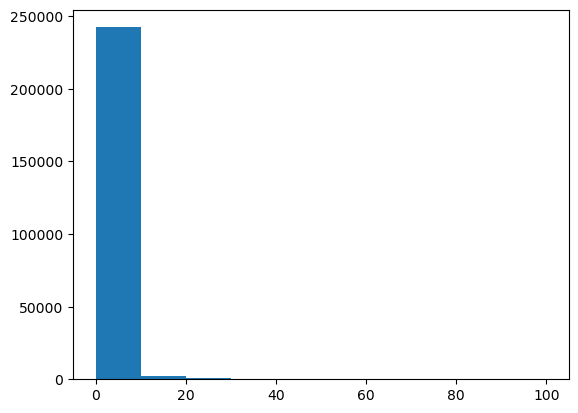

In [7]:
plt.hist(data['salt_100g'])

In [17]:
data.columns[80:82]

Index(['fiber_100g', 'proteins_100g'], dtype='object')

<a name="E6">

In [18]:
# =========== PASSONS AUX FIBRES ============= :
data['fiber_100g'].describe()

count    190344.000000
mean          2.835528
std           4.635725
min          -6.700000
25%           0.000000
50%           1.500000
75%           3.600000
max         250.000000
Name: fiber_100g, dtype: float64

(array([2.00885e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  -6.7 ,  531.97, 1070.64, 1609.31, 2147.98, 2686.65, 3225.32,
        3763.99, 4302.66, 4841.33, 5380.  ]),
 <BarContainer object of 10 artists>)

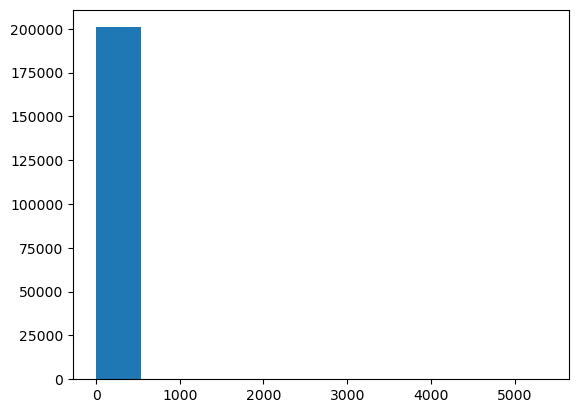

In [7]:
plt.hist(data['fiber_100g'])

In [20]:
# on met à 0 les valeurs négatives :
compteur = 0
for i in range(247242) :
    if data.iloc[i,80] < 0.0 :
        data.iloc[i,80] = 0.0
        compteur += 1

compteur

1

In [21]:
data.loc[data['fiber_100g'] > 100.0, ['product_name','brands','fiber_100g','ingredients_text','main_category_fr']]

product_name            brands  \
63042              Chef Merito, Creole Style Adobo  Chef Merito Inc.   
150870  Tamarind Juice With Nata De Coco, Tamarind       Kelly Jelly   

        fiber_100g                                   ingredients_text  \
63042        166.7  Salt, msg (a natural flavor enhancer derived f...   
150870       250.0  Tamarind juice 10% sugar 10% nata de coco 20% ...   

       main_category_fr  
63042               NaN  
150870              NaN

In [22]:
data.iloc[63042,80] = np.NaN
data.iloc[150870,80] = np.NaN

In [23]:
data['fiber_100g'].describe()

count    190342.000000
mean          2.833403
std           4.585598
min           0.000000
25%           0.000000
50%           1.500000
75%           3.600000
max         100.000000
Name: fiber_100g, dtype: float64

In [24]:
data.loc[data['fiber_100g'] == 100.0, ['product_name','brands','fiber_100g','ingredients_text','main_category_fr']]

product_name  \
10241                                          Sweeteners   
84326                        Yamashin, Powdered Agar-Agar   
123026                            Savarez - Jeu De Cordes   
152492                         Powdered Sweetener Packets   
152493  Premium Organic Stevia, Powdered Sweetener Pac...   
165050  Harry Potter & The Deathly Hallows Radcliffe /...   
216176                                        Noix sèches   
233161  Le Hobbit : La Bataille Des Cinq Armés - Versi...   
239805                              Marshall - Major Noir   

                             brands  fiber_100g  \
10241                     Wholesome       100.0   
84326   Wismettac Asian Foods  Inc.       100.0   
123026                      Savarez       100.0   
152492                        Pyure       100.0   
152493                        Pyure       100.0   
165050                      Harry's       100.0   
216176                     Pepinoix       100.0   
233161                      Blu Ray       100.0   
239805                         Sony       100.0   

                                         ingredients_text main_category_fr  
10241   Organic agave inulin, organic stevia extract (...              NaN  
84326                                            Seaweed.              NaN  
123026                                                NaN              NaN  
152492  Organic agave inulin, organic stevia leaf extr...              NaN  
152493  Organic agave inulin, organic stevia leaf extr...              NaN  
165050                                                NaN  Non alimentaire  
216176                                        Noix sèches              NaN  
233161                                                NaN              NaN  
239805                                                NaN              NaN

In [26]:
data.iloc[216176,80] = np.NaN
data.iloc[239805, 10:20]

packaging                NaN
packaging_tags           NaN
brands                  Sony
brands_tags             sony
categories               NaN
categories_tags          NaN
categories_fr            NaN
origins                  NaN
origins_tags             NaN
manufacturing_places     NaN
Name: 239805, dtype: object

In [27]:
# élimination des produits non-alimentaires :
data = data.drop(index=123026, axis=0)
data = data.drop(index=165050, axis=0)
data = data.drop(index=233161, axis=0)
data = data.drop(index=239805, axis=0)

In [28]:
data.loc[data['main_category_fr'] == 'Non alimentaire', ['product_name','brands']]

product_name   brands
201656  Lingettes pocket pour visage et mains, biodégr...  Biolane
218574                                       Hibiscus bio  Ushuaïa
218575                                          shampoing      NaN

In [29]:
data = data.drop(index=201656, axis=0)
data = data.drop(index=218574, axis=0)
data = data.drop(index=218575, axis=0)

(array([2.34479e+05, 1.04940e+04, 1.36200e+03, 5.68000e+02, 1.94000e+02,
        4.60000e+01, 2.50000e+01, 1.80000e+01, 1.50000e+01, 7.00000e+00]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

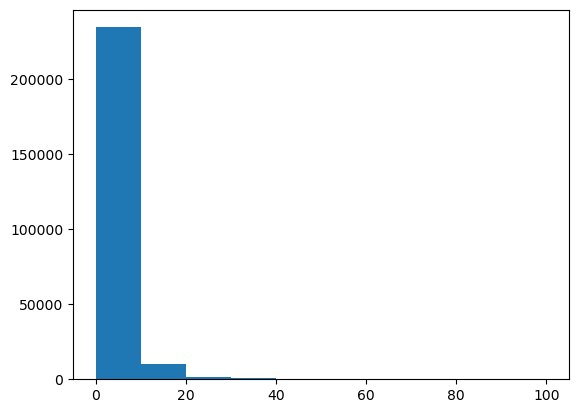

In [8]:
plt.hist(data['fiber_100g']) # ajouté tardivement, après imputation des valeurs manquantes

In [76]:
data.reset_index(drop=True)   # A SUPPRIMER DANS LIVRAISON ?
data.to_csv('fr.openfoodfacts.org.products.csv', sep='	')

<a name="E7">

In [4]:
# ================== ET ENFIN AUX PROTEINES =================== :
data['proteins_100g'].describe()

count    245215.000000
mean          7.096937
std           8.413191
min        -800.000000
25%           0.600000
50%           4.710000
75%          10.000000
max         100.000000
Name: proteins_100g, dtype: float64

In [5]:
data.loc[data['proteins_100g'] < 0.0, ['product_name','brands','proteins_100g','ingredients_text','main_category_fr']]

product_name          brands  \
32937                              Whole Cashews       Food Club   
111149  Gourmet Blends, Seasoning, Garlic Pepper   Spice Islands   
164064                    Lightly Dried Cilantro  Gourmet Garden   

        proteins_100g                                   ingredients_text  \
32937           -3.57  Cashews, vegetable oil (peanut, cottonseed, so...   
111149        -500.00  Dehydrated garlic, black pepper, salt, sugar, ...   
164064        -800.00  Organic cilantro, organic canola oil, sea salt...   

       main_category_fr  
32937               NaN  
111149              NaN  
164064              NaN

In [7]:
data.iloc[32937,81] = np.NaN
data.iloc[111149,81] = np.NaN
data.iloc[164064,81] = np.NaN

In [8]:
data.loc[data['proteins_100g'] == 100.0, ['product_name','brands','proteins_100g','ingredients_text','main_category_fr']]

product_name                   brands  proteins_100g  \
2688           Unflavored Gelatin  Kroger,  The Kroger Co.          100.0   
40059          Unflavored Gelatin                   Meijer          100.0   
40060                     Gelatin                   Meijer          100.0   
68938          Unflavored Gelatin              Winco Foods          100.0   
87784               Garlic Powder                   Iberia          100.0   
145220  Tcho-A-Day Dark Chocolate                     Tcho          100.0   
163782                  Sprinkles           Iq Accessories          100.0   

                                         ingredients_text main_category_fr  
2688                                             Gelatin.              NaN  
40059                                            Gelatin.              NaN  
40060                                            Gelatin.              NaN  
68938                                            Gelatin.              NaN  
87784                           Granulated garlic powder.              NaN  
145220  Cacao beans*, cane sugar*, cocoa butter*, soy ...              NaN  
163782  Sugar, fd&c red 40 lake, carnauba wax and conf...              NaN

In [9]:
data.iloc[87784,81] = np.NaN
data.iloc[145220,81] = np.NaN
data.iloc[163782,81] = np.NaN

In [10]:
data['proteins_100g'].describe()

count    245209.000000
mean          7.101203
std           8.183655
min           0.000000
25%           0.600000
50%           4.710000
75%          10.000000
max         100.000000
Name: proteins_100g, dtype: float64

(array([1.82452e+05, 4.18380e+04, 1.91860e+04, 2.24200e+03, 8.75000e+02,
        3.34000e+02, 1.42000e+02, 7.00000e+01, 5.30000e+01, 1.60000e+01]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

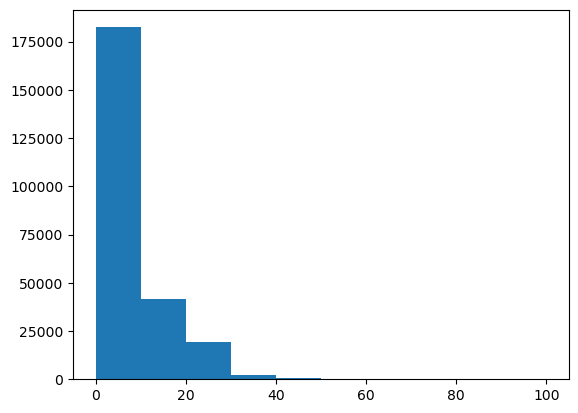

In [9]:
plt.hist(data['proteins_100g'])

<a name="E8"></a>
## Nous allons maintenant chercher à valoriser les informations manquantes pour les champs utilisés pour le calcul du nutriscore.
<br>
<br>Puisque nous avons supprimé les lignes "vides", j'aimerais savoir si maintenant les lignes ont bien tous les champs du nutriscore renseignés, y compris ce dernier. Sinon, y a-t-il des champs mieux associés (par exemple l'apport énergétique est donné chaque fois que l'apport en sucre est donné) ?

<Axes: >

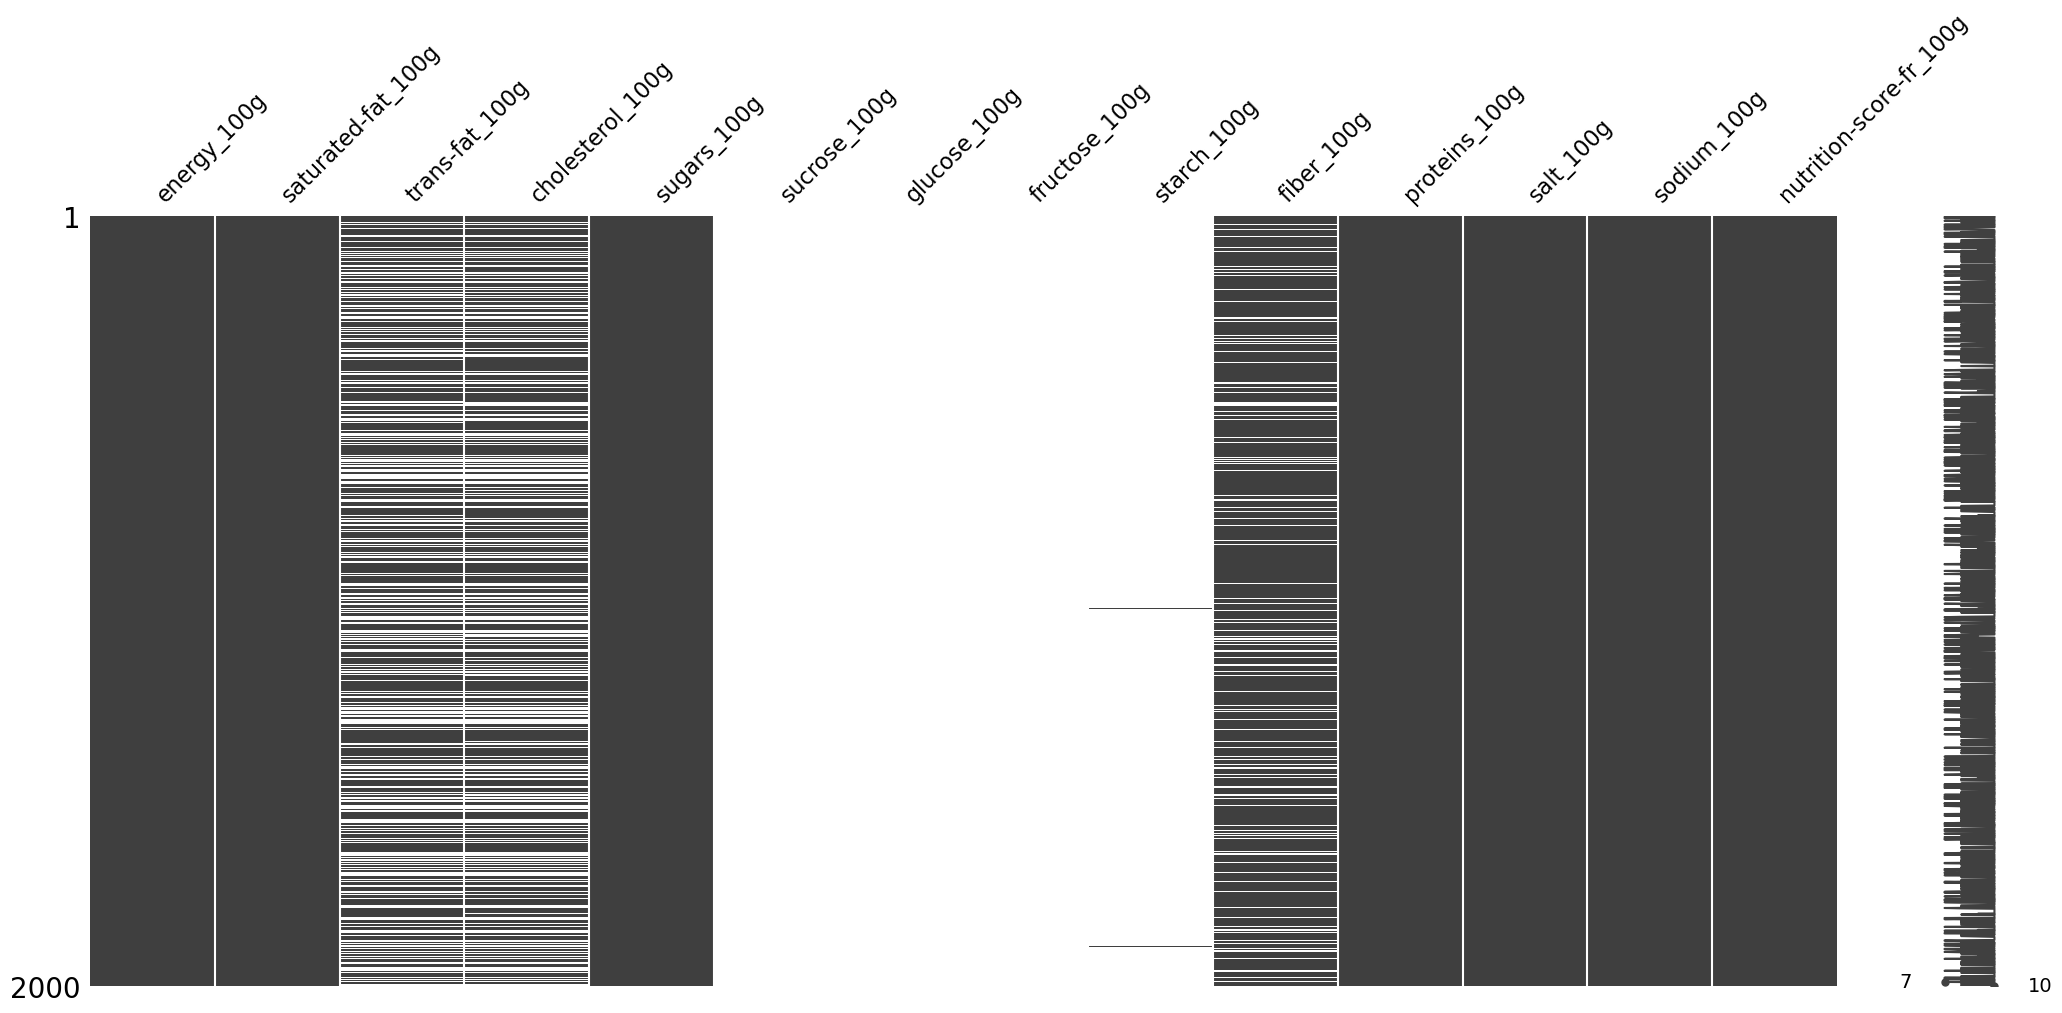

In [17]:
# Un premier coup d'oeil avec une matrice missingno :
import missingno as msn
msn.matrix(data.loc[data['nutrition-score-fr_100g'] > 0,['energy_100g','saturated-fat_100g','trans-fat_100g','cholesterol_100g','sugars_100g','sucrose_100g','glucose_100g','fructose_100g','starch_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g','nutrition-score-fr_100g']].sample(2000))

<Axes: >

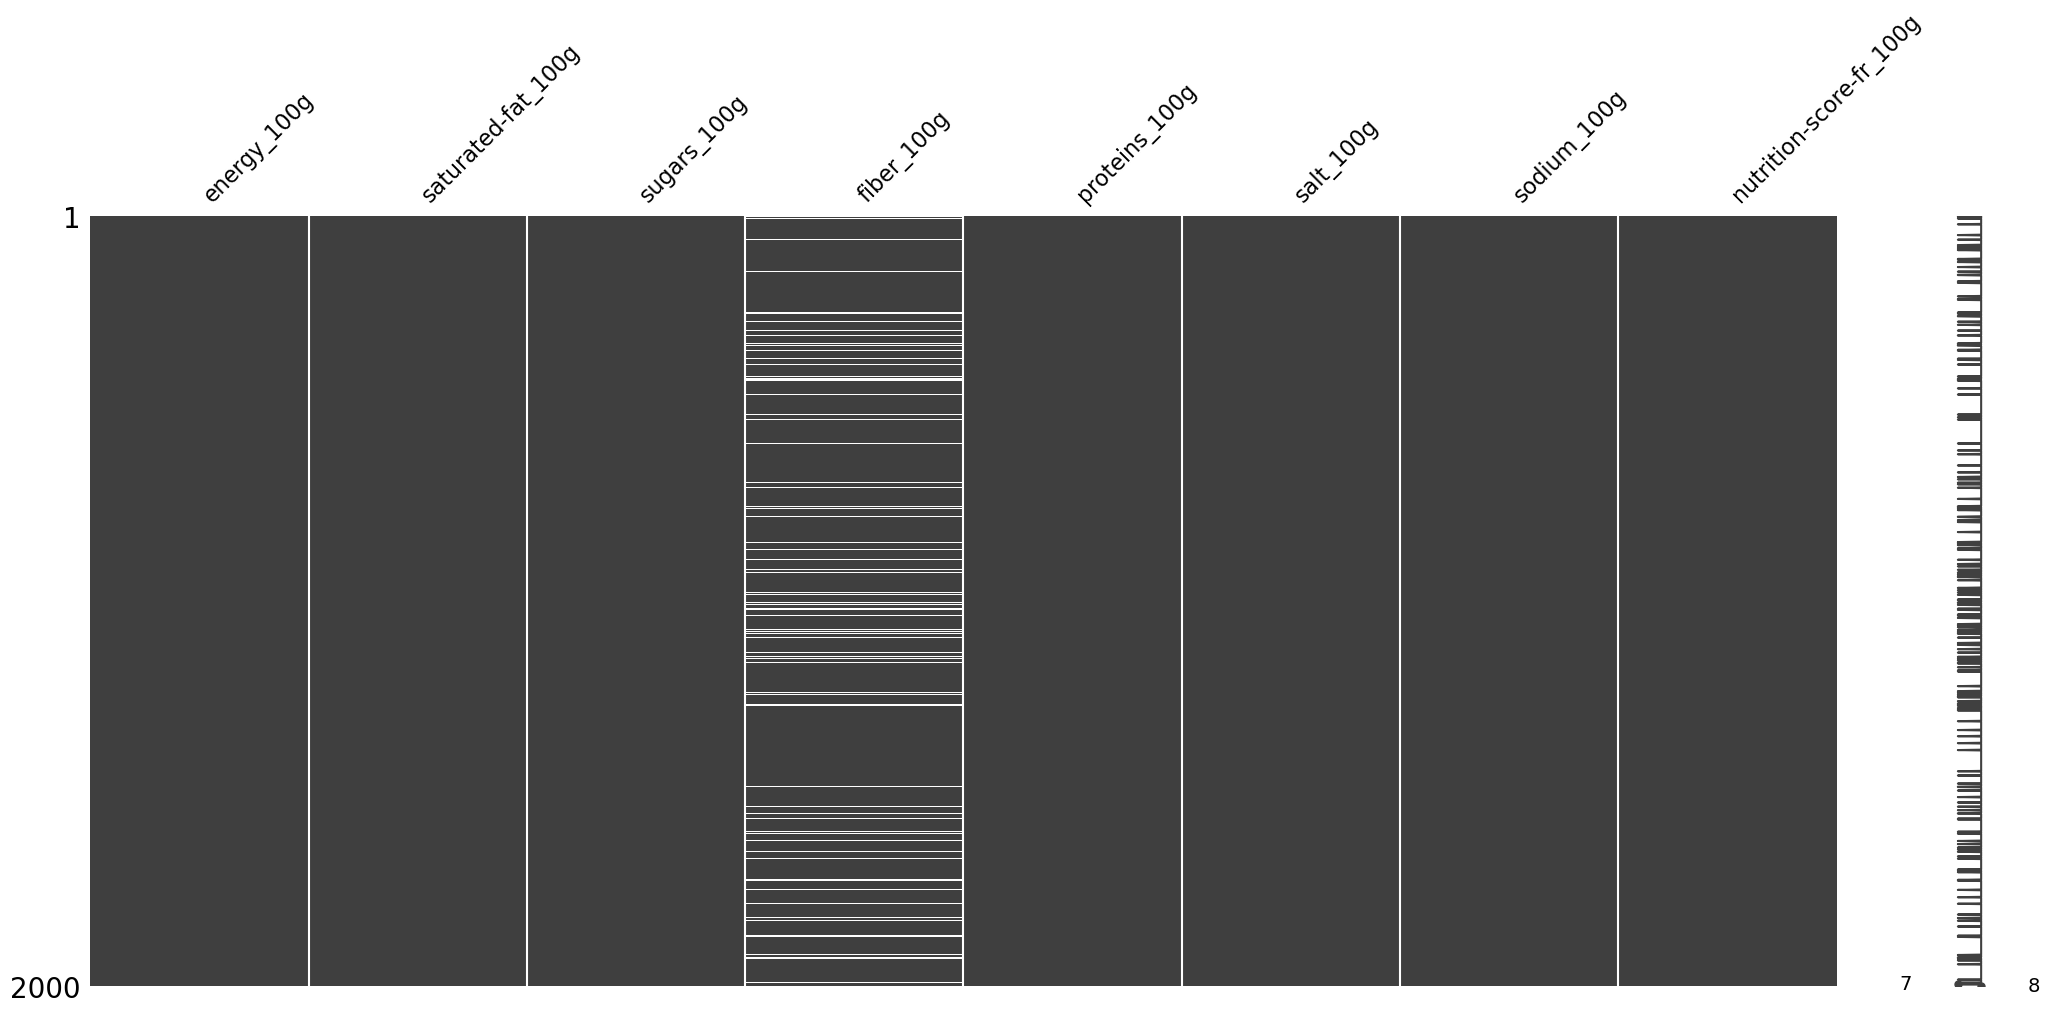

In [19]:
# les champs essentiels sont très bien renseignés, sauf pour les fibres; On pourra ignorer les champs secondaires.
# voyons pour les nutriscores nuls, s'il y en a :
msn.matrix(data.loc[data['nutrition-score-fr_100g'] == 0,['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g','nutrition-score-fr_100g']].sample(2000))

<Axes: >

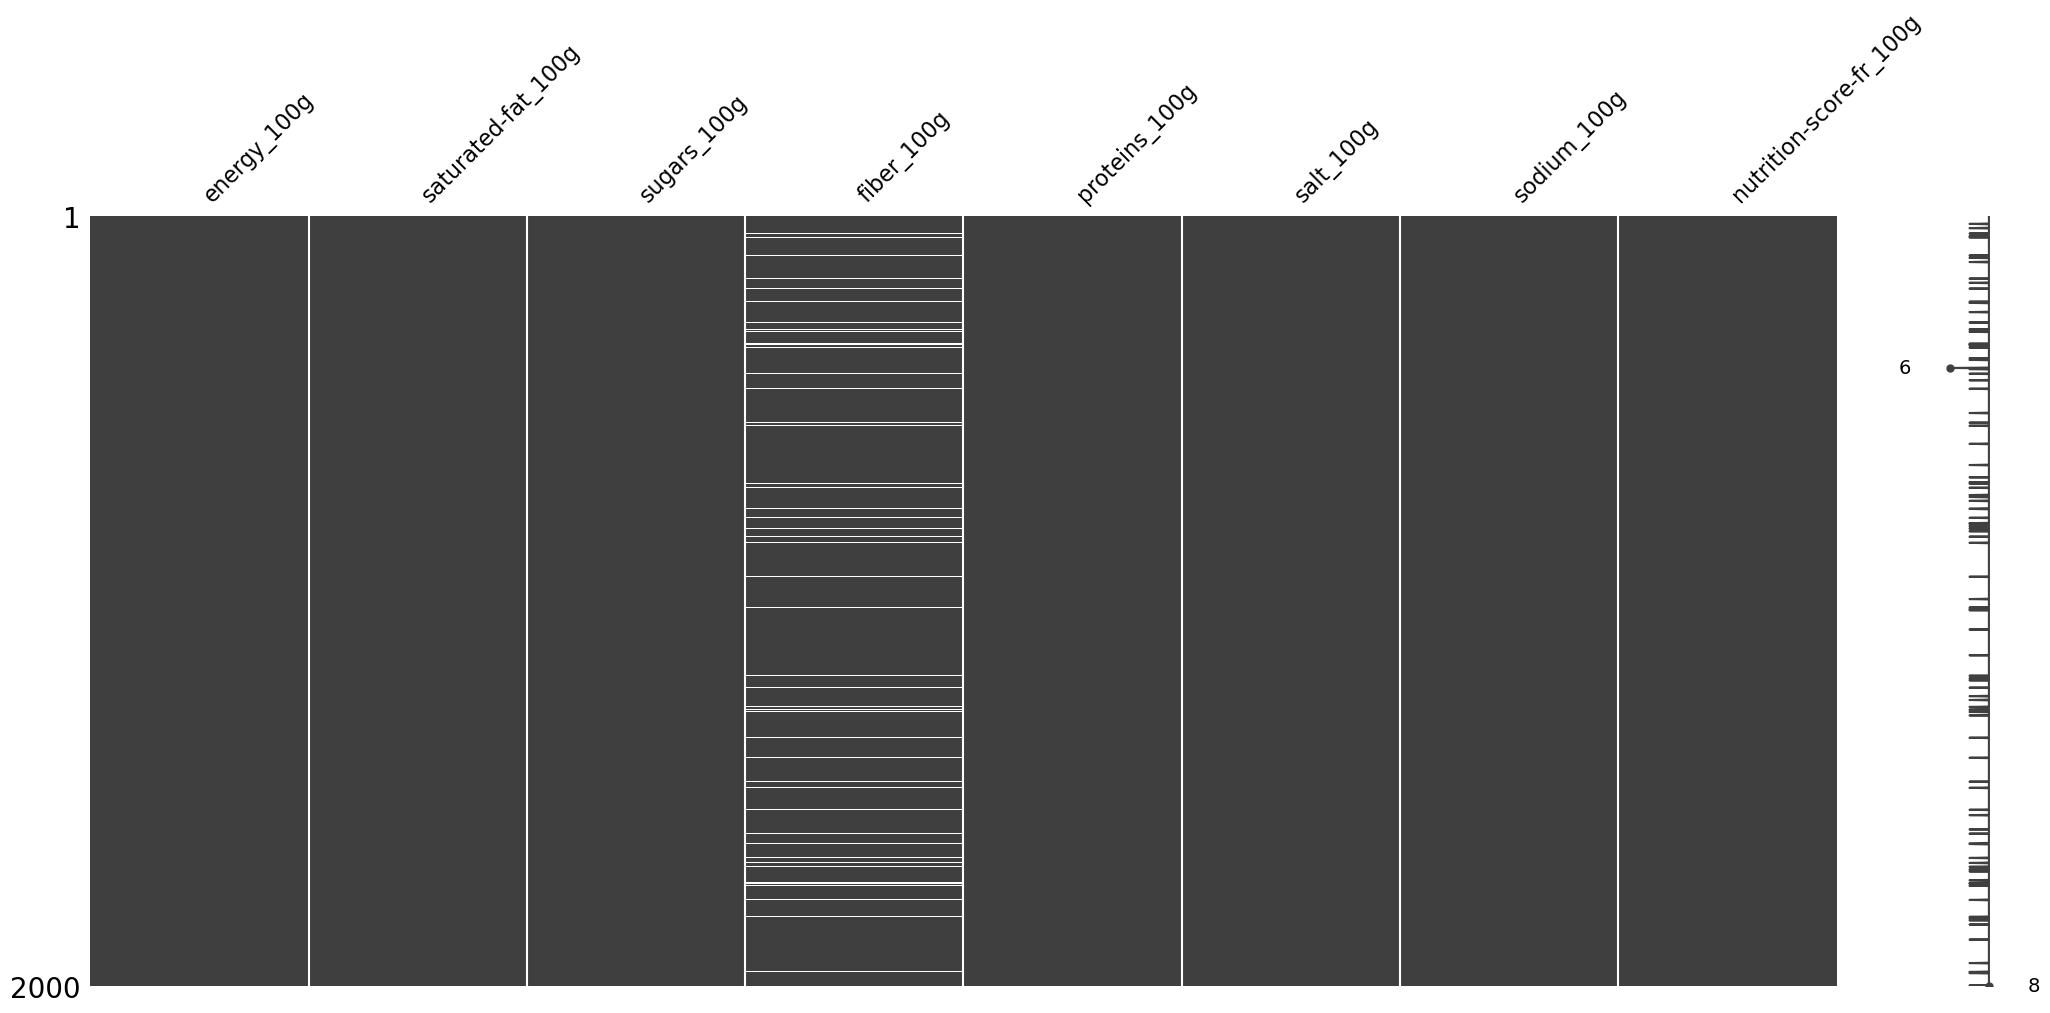

In [20]:
# c'est pareil, et pour les nutriscores négatifs :
msn.matrix(data.loc[data['nutrition-score-fr_100g'] < 0,['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g','nutrition-score-fr_100g']].sample(2000))

In [21]:
# nombre de lignes sans nutriscore :
data.loc[data['nutrition-score-fr_100g'].isna(), 'product_name'].count

<bound method Series.count of 3                              Organic Polenta
4            Breadshop Honey Gone Nuts Granola
5                Organic Long Grain White Rice
7                 Organic Dark Chocolate Minis
8                        Organic Sunflower Oil
                          ...                 
247211    SUNQUEEN BÂTONNETS DE POMMES SÉCHÉES
247218     Freefrom Sans Gluten Pastas De Coco
247231                                     NaN
247233                                     NaN
247234           Fait Maison Tarte aux cerises
Name: product_name, Length: 38962, dtype: object>

In [22]:
data.loc[data['nutrition-score-fr_100g'].isna(), 'product_name'].count()

38486

<Axes: >

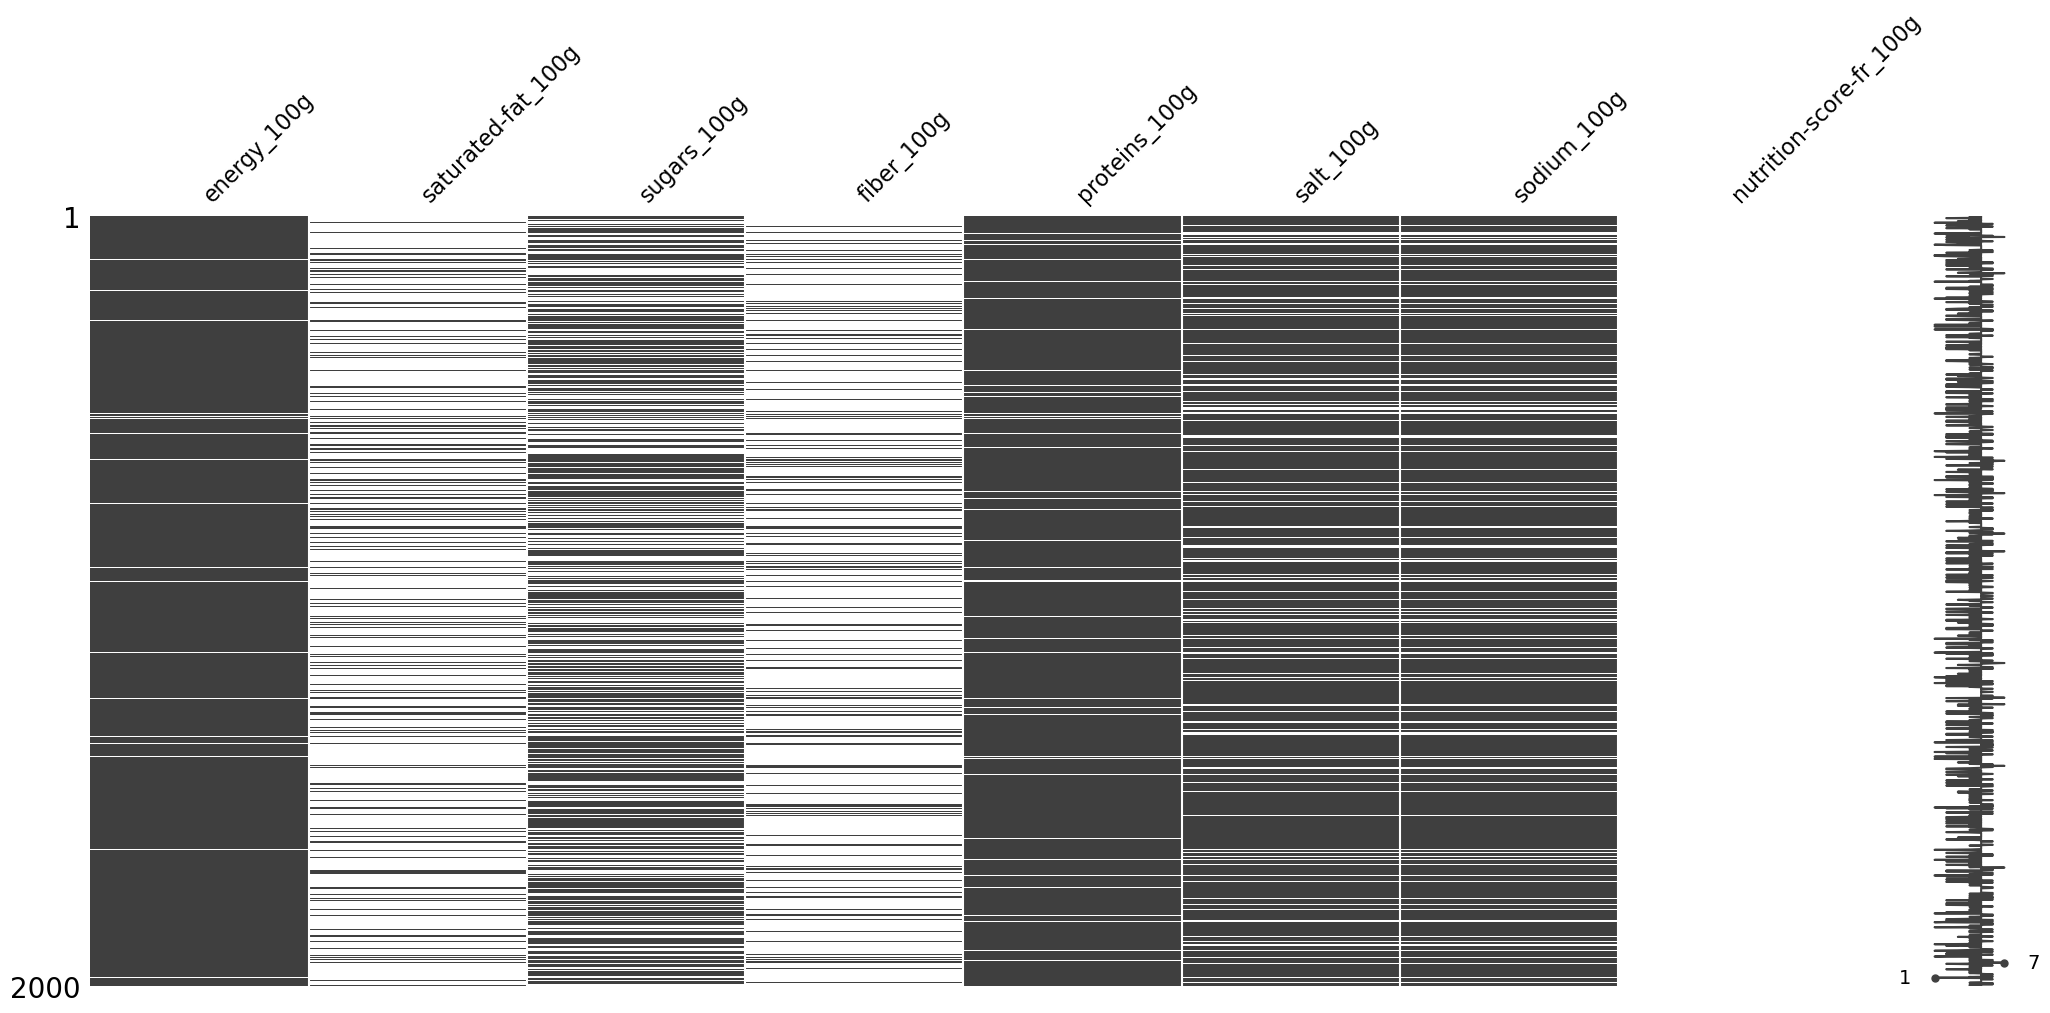

In [23]:
# plus en détail :
msn.matrix(data.loc[data['nutrition-score-fr_100g'].isna(),['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g','nutrition-score-fr_100g']].sample(2000))

Donc majoritairement, quand le nutriscore est donné les champs qui permettent son calcul, hors fibres, sont donnés, mais y a-t-il des exceptions ?

In [26]:
data.loc[~(data['nutrition-score-fr_100g'].isna()) & (data['energy_100g'].isna() | data['saturated-fat_100g'].isna() | data['sugars_100g'].isna() | data['proteins_100g'].isna() | data['salt_100g'].isna()),['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g','nutrition-score-fr_100g']]

product_name  energy_100g  saturated-fat_100g  \
1268                   Dill Pickle Cashews       2389.0                8.57   
7781                          Butter Beans        322.0                0.00   
10823              Autumn Cookie Selection       2025.0                2.42   
13944                        Honey Peanuts          NaN               10.71   
15193                       Tamalito Candy          NaN                0.00   
...                                    ...          ...                 ...   
240673                   Sauce à la Crème           NaN                4.00   
241542                                 NaN       2080.0               11.00   
241543  Swiss Chocolate Liquor - Cointreau       2040.0               14.00   
242790                Praliné Con Nocciole          NaN               13.00   
243286    Qualité & Prix Bretzels Précuits          NaN                0.50   

        sugars_100g  fiber_100g  proteins_100g  salt_100g  sodium_100g  \
1268           5.71         5.7          17.14        NaN          NaN   
7781           2.31         3.8           4.62        NaN          NaN   
10823         22.58         1.6           4.84        NaN          NaN   
13944         17.86         7.1          21.43    0.58928     0.232000   
15193         80.00         0.0           0.00    0.40640     0.160000   
...             ...         ...            ...        ...          ...   
240673         1.40         0.2           1.90    0.95000     0.374016   
241542        34.00         NaN           7.00        NaN          NaN   
241543        54.00         NaN           4.00        NaN          NaN   
242790        39.00         5.0           4.50    0.20000     0.078740   
243286         3.50         2.5           9.00    1.80000     0.708661   

        nutrition-score-fr_100g  
1268                       21.0  
7781                        3.0  
10823                      21.0  
13944                      20.0  
15193                      21.0  
...                         ...  
240673                     17.0  
241542                     33.0  
241543                     26.0  
242790                     23.0  
243286                     14.0  

[165 rows x 9 columns]

In [27]:
data.loc[~(data['nutrition-score-fr_100g'].isna()) & (data['energy_100g'].isna() | data['saturated-fat_100g'].isna() | data['sugars_100g'].isna() | data['proteins_100g'].isna() | data['salt_100g'].isna()),['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g','nutrition-score-fr_100g']][0:20]

product_name  energy_100g  \
1268                                 Dill Pickle Cashews       2389.0   
7781                                        Butter Beans        322.0   
10823                            Autumn Cookie Selection       2025.0   
13944                                      Honey Peanuts          NaN   
15193                                     Tamalito Candy          NaN   
19511                                          Bread Mix          NaN   
20248                      Special Blend, Peas & Carrots        197.0   
21300  Marie Sharp's, Orange Pulp Habanero Pepper Sau...       2008.0   
22954                            Original Barbecue Sauce        628.0   
26838                              Hardwood Smoked Bacon          NaN   
28010            Fratelli Comino, Tochetti With Sea Salt       1812.0   
31530                 Light & Fit Greek Crunch - S'mores        386.0   
32937                                      Whole Cashews       2389.0   
34284                              Dried Habanero Chiles          NaN   
34422                                         Lemon Cake          NaN   
38718                                        Garlic Salt          0.0   
45982                              Instant Aka Miso Soup          NaN   
49495                                  Premium Ice Cream        862.0   
54455               Pure Carrot With Organic Lemon Juice        176.0   
54788                    Maxwell House, Creme Cappuccino          NaN   

       saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
1268                8.570         5.71       5.700          17.14        NaN   
7781                0.000         2.31       3.800           4.62        NaN   
10823               2.420        22.58       1.600           4.84        NaN   
13944              10.710        17.86       7.100          21.43    0.58928   
15193               0.000        80.00       0.000           0.00    0.40640   
19511               0.000        14.29       0.000           0.00    5.62356   
20248               0.000         3.12       3.100           2.34        NaN   
21300               0.000        44.00      34.000          14.00        NaN   
22954               0.000        16.67       3.300           0.00        NaN   
26838              25.000         0.00       0.000          62.50    4.12750   
28010               3.330         3.33       3.300          10.00        NaN   
31530               0.709         7.80       0.709           7.80        NaN   
32937               8.930         3.57       3.600            NaN    0.99822   
34284               0.000         0.00       0.000           0.00    0.25400   
34422               2.630        29.82       0.000           3.51    0.71374   
38718               0.000         0.00       0.000           0.00        NaN   
45982               0.000         0.00       0.000          20.00   20.06600   
49495               6.620        20.59       1.500           2.94        NaN   
54455               0.000         4.17       0.800           0.83        NaN   
54788              37.500        75.00       0.000          37.50    3.33248   

       sodium_100g  nutrition-score-fr_100g  
1268           NaN                     21.0  
7781           NaN                      3.0  
10823          NaN                     21.0  
13944        0.232                     20.0  
15193        0.160                     21.0  
19511        2.214                     23.0  
20248          NaN                      5.0  
21300          NaN                     19.0  
22954          NaN                     10.0  
26838        1.625                     30.0  
28010          NaN                     14.0  
31530          NaN                     11.0  
32937        0.393                     14.0  
34284        0.100                     11.0  
34422        0.281                     21.0  
38718          NaN                     10.0  
45982        7.900                     20.0  
4

<a name="E9"></a>
<br>Nous avons donc 165 cas pour lesquels le nutriscore est donné mais pas toutes ses composantes. Les champs les plus déficitaires sont l'apport energétique et le sel / sodium. Concernant l'apport energétique il est principalement issu des sucres et graisses. Pouvons nous démontrer que la part de protéines joue un rôle mineur dans cet apport ?

In [29]:
data.loc[(data['saturated-fat_100g'] < 2.0) & (data['sugars_100g'] < 2.0) & (data['proteins_100g'] > 10.0), 'energy_100g']

269       1548.0
375        247.0
380       1393.0
389       1494.0
460        490.0
           ...  
247144    1450.0
247153     367.0
247181     416.0
247208     830.0
247219    1770.0
Name: energy_100g, Length: 10567, dtype: float64

Visiblement des produits riches en protéines mais assez pauvres en sucres et graisses peuvent avoir un apport énergétique élevé. Peut être qu'on peut avoir un cefficient de contribution pour chaque catégorie ?

In [31]:
data.loc[(data['saturated-fat_100g'] < 0.1) & (data['sugars_100g'] < 0.1) & (data['proteins_100g'] > 10.0), ['energy_100g','proteins_100g']]

energy_100g  proteins_100g
375           247.0          14.12
380          1393.0          66.67
1424         1121.0          10.71
1782         2615.0          25.00
1783         2351.0          25.00
...             ...            ...
242810        360.0          19.00
242874        320.0          19.00
243830        270.0          15.00
244028       1644.0          25.00
245579       2860.0          15.00

[3681 rows x 2 columns]

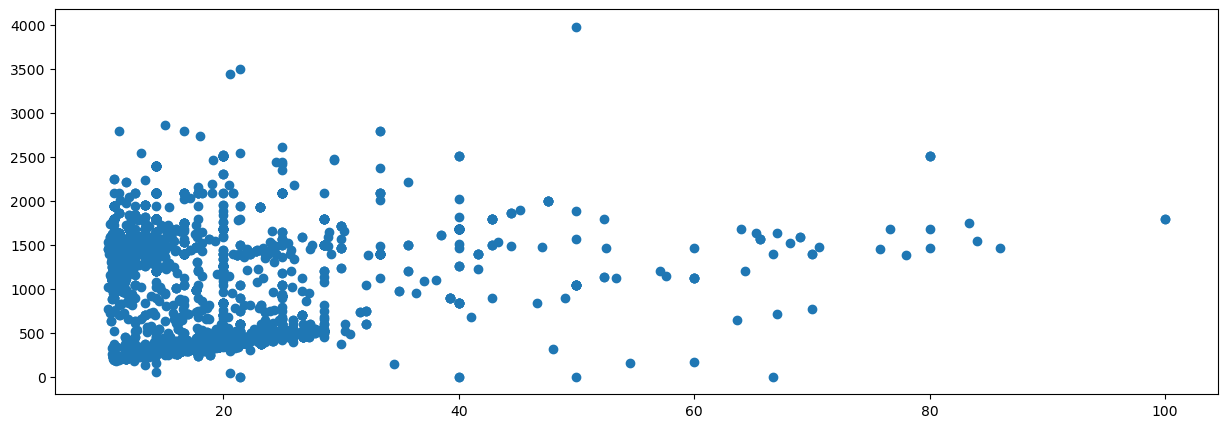

In [33]:
prot_cal = data.loc[(data['saturated-fat_100g'] < 0.1) & (data['sugars_100g'] < 0.1) & (data['proteins_100g'] > 10.0), ['energy_100g','proteins_100g']]
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.scatter(prot_cal['proteins_100g'],prot_cal['energy_100g'])
plt.show()

On peut observer une droite 'minimum' i.e. au dessus d'un certain taux de protéines les produits ont nécéssairement (à part de rares cas) un certain apport énergétique : 

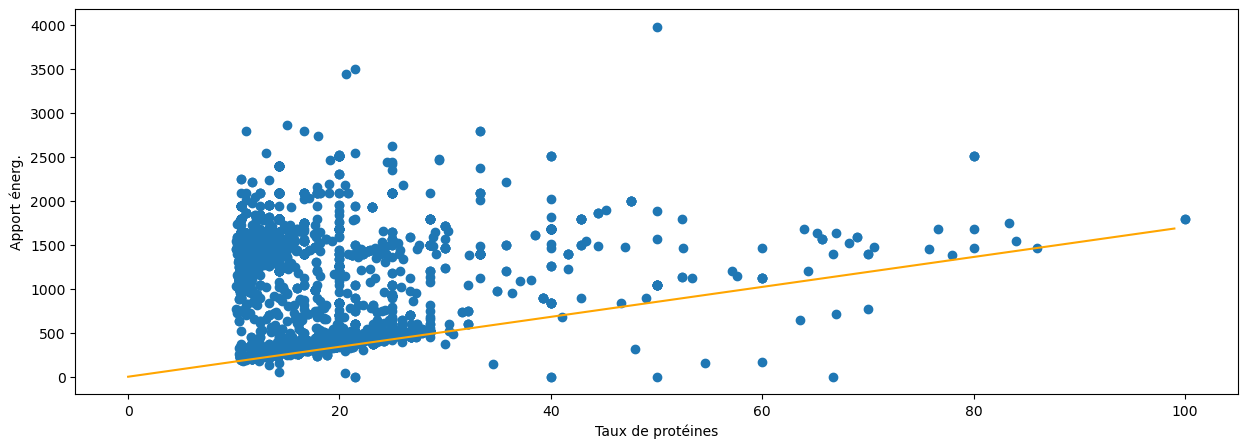

In [36]:
plt.figure(figsize=(15,5))
plt.scatter(prot_cal['proteins_100g'],prot_cal['energy_100g'])
plt.plot(np.arange(100), [17*x for x in np.arange(100)], c='orange' )
plt.xlabel("Taux de protéines")
plt.ylabel("Apport énerg.")
plt.show()

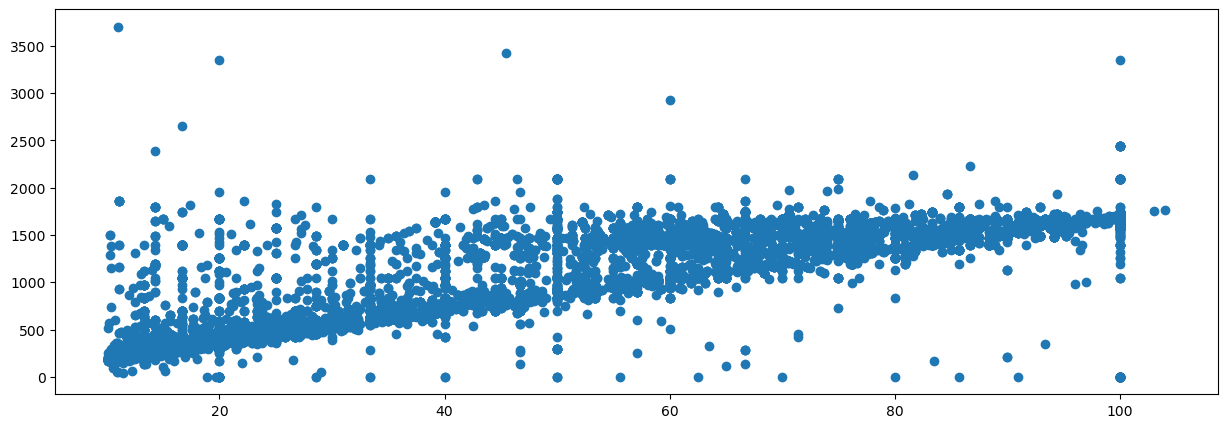

In [41]:
# Voyons si le taux de sucre est plus corrélé :
plt.figure(figsize=(15,5))
sug_cal = data.loc[(data['saturated-fat_100g'] < 0.1) & (data['proteins_100g'] < 0.1) & (data['sugars_100g'] > 10.0), ['energy_100g','sugars_100g']]
plt.scatter(sug_cal['sugars_100g'],sug_cal['energy_100g'])
plt.show()

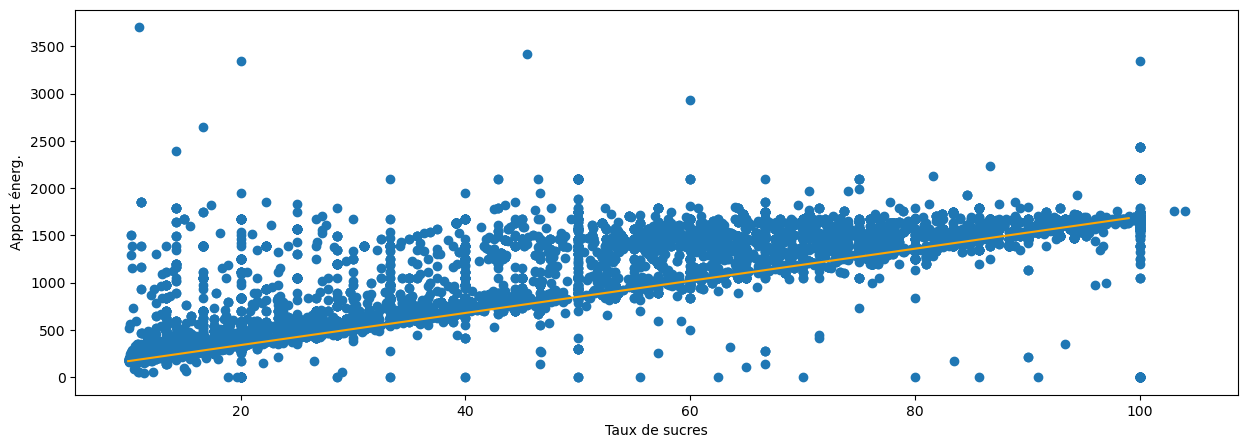

In [49]:
# effectivement le graphe est plus linéaire
plt.figure(figsize=(15,5))
plt.scatter(sug_cal['sugars_100g'],sug_cal['energy_100g'])
plt.plot(np.arange(10,100), [17*x for x in np.arange(10,100)], c='orange' )
plt.xlabel("Taux de sucres")
plt.ylabel("Apport énerg.")
plt.show()

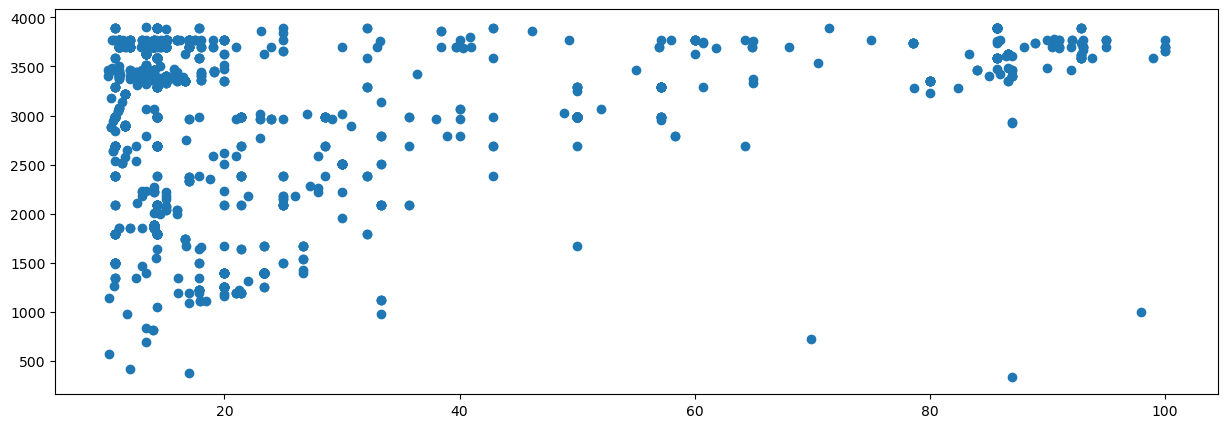

In [44]:
# et enfin pour les matières grasses saturées :
plt.figure(figsize=(15,5))
fat_cal = data.loc[(data['saturated-fat_100g'] > 10.0) & (data['proteins_100g'] < 0.1) & (data['sugars_100g'] < 0.1), ['energy_100g','saturated-fat_100g']]
plt.scatter(fat_cal['saturated-fat_100g'],fat_cal['energy_100g'])
plt.show()

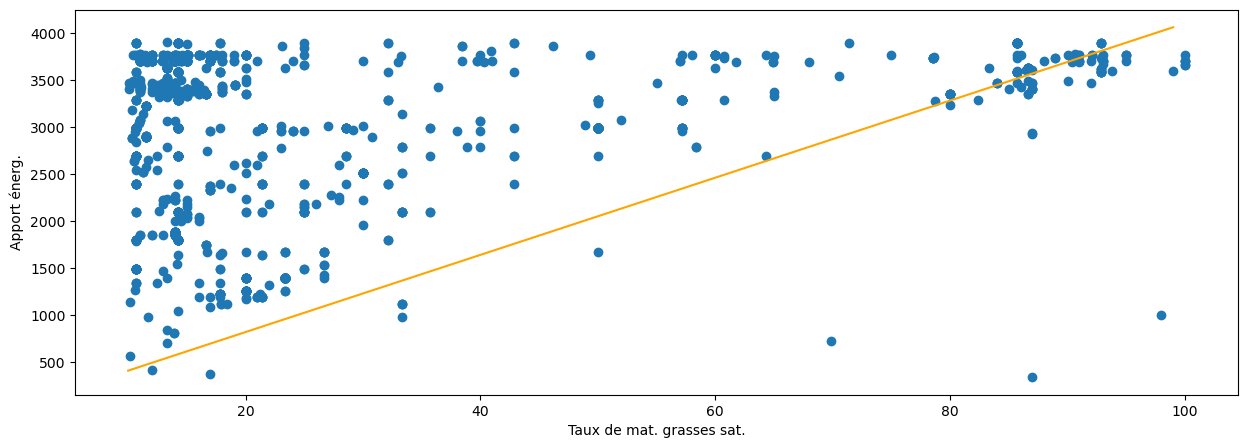

In [48]:
# de nouveau une 'linéarité minimum' :
plt.figure(figsize=(15,5))
plt.scatter(fat_cal['saturated-fat_100g'],fat_cal['energy_100g'])
plt.plot(np.arange(10,100), [41*x for x in np.arange(10,100)], c='orange' )
plt.xlabel("Taux de mat. grasses sat.")
plt.ylabel("Apport énerg.")
plt.show()

Ainsi pour les produits qui ont un apport énergétique à 'NaN', on pourra leur attribuer la valeur de (17 x sugars_100g + 17 x proteins_100g + 41 x saturated-fat_100g) et comme c'est une valeur à minima, si elle est non nulle on pourra ajouter une constante = 100 par exemple pour être plus dans la moyenne.

In [2]:
list_ind = data.loc[~(data['nutrition-score-fr_100g'].isna()) & (data['energy_100g'].isna() | data['saturated-fat_100g'].isna() | data['sugars_100g'].isna() | data['proteins_100g'].isna() | data['salt_100g'].isna()), 'product_name'].index

In [12]:
list_except = []
for ind in list_ind :
    try :
        if data.iloc[ind,57] == np.NaN :
            val = 17*data.iloc[ind,73] + 17*data.iloc[ind,81] + 41*data.iloc[ind,60]
            if val > 0 :
                val = val + 100
            data.iloc[ind,57] = val
    except :
        list_except.append(ind)
        continue


In [13]:
list_except

[]

In [16]:
data.loc[~(data['nutrition-score-fr_100g'].isna()) & (data['energy_100g'].isna() | data['saturated-fat_100g'].isna() | data['sugars_100g'].isna() | data['proteins_100g'].isna() | data['salt_100g'].isna()),['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g','nutrition-score-fr_100g']]

product_name  energy_100g  saturated-fat_100g  \
1268                   Dill Pickle Cashews       2389.0                8.57   
7781                          Butter Beans        322.0                0.00   
10823              Autumn Cookie Selection       2025.0                2.42   
13944                        Honey Peanuts          NaN               10.71   
15193                       Tamalito Candy          NaN                0.00   
...                                    ...          ...                 ...   
240673                   Sauce à la Crème           NaN                4.00   
241542                                 NaN       2080.0               11.00   
241543  Swiss Chocolate Liquor - Cointreau       2040.0               14.00   
242790                Praliné Con Nocciole          NaN               13.00   
243286    Qualité & Prix Bretzels Précuits          NaN                0.50   

        sugars_100g  fiber_100g  proteins_100g  salt_100g  sodium_100g  \
1268           5.71         5.7          17.14        NaN          NaN   
7781           2.31         3.8           4.62        NaN          NaN   
10823         22.58         1.6           4.84        NaN          NaN   
13944         17.86         7.1          21.43    0.58928     0.232000   
15193         80.00         0.0           0.00    0.40640     0.160000   
...             ...         ...            ...        ...          ...   
240673         1.40         0.2           1.90    0.95000     0.374016   
241542        34.00         NaN           7.00        NaN          NaN   
241543        54.00         NaN           4.00        NaN          NaN   
242790        39.00         5.0           4.50    0.20000     0.078740   
243286         3.50         2.5           9.00    1.80000     0.708661   

        nutrition-score-fr_100g  
1268                       21.0  
7781                        3.0  
10823                      21.0  
13944                      20.0  
15193                      21.0  
...                         ...  
240673                     17.0  
241542                     33.0  
241543                     26.0  
242790                     23.0  
243286                     14.0  

[165 rows x 9 columns]

Rien a changé malgrè mes instructions de remplacement !??

In [17]:
list_ind

Int64Index([  1268,   7781,  10823,  13944,  15193,  19511,  20248,  21300,
             22954,  26838,
            ...
            236724, 236914, 239151, 239209, 239594, 240673, 241542, 241543,
            242790, 243286],
           dtype='int64', length=165)

In [24]:
data.iloc[240673,57] == np.NaN

False

In [37]:
data.loc[240673][57].astype('int')

-2147483648

In [38]:
data.iloc[241542,57].astype('int')

2080

In [39]:
# après plusieurs tests, utilisant 'isna()', 'is None' ou autres syntaxes qui ne fonctionnent pas :
for ind in list_ind :
    try :
        if data.iloc[ind,57].astype('int') < 0 :  # c'est le cas si vaut np.NaN ...
            val = 17*data.iloc[ind,73] + 17*data.iloc[ind,81] + 41*data.iloc[ind,60]
            if val > 0 :
                val = val + 100
            data.iloc[ind,57] = val
    except :
        list_except.append(ind)
        continue


In [40]:
list_except

[]

Nous venons d'utiliser une première méthode d'imputation en faisant appel à une fonction empirique à partir d'autres colonnes pour lesquelles nous avons des données. Petite vérification :

In [41]:
data.loc[~(data['nutrition-score-fr_100g'].isna()) & (data['energy_100g'].isna() | data['saturated-fat_100g'].isna() | data['sugars_100g'].isna() | data['proteins_100g'].isna() | data['salt_100g'].isna()),['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g','nutrition-score-fr_100g']]

product_name  energy_100g  \
1268                                  Dill Pickle Cashews       2389.0   
7781                                         Butter Beans        322.0   
10823                             Autumn Cookie Selection       2025.0   
20248                       Special Blend, Peas & Carrots        197.0   
21300   Marie Sharp's, Orange Pulp Habanero Pepper Sau...       2008.0   
...                                                   ...          ...   
236723                                  Organic Dill Salt          0.0   
236724                          Riz cantonais Nasi Goreng        715.0   
239151                                      Bamboo Shoots         50.0   
241542                                                NaN       2080.0   
241543                 Swiss Chocolate Liquor - Cointreau       2040.0   

        saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
1268                  8.57         5.71         5.7          17.14        NaN   
7781                  0.00         2.31         3.8           4.62        NaN   
10823                 2.42        22.58         1.6           4.84        NaN   
20248                 0.00         3.12         3.1           2.34        NaN   
21300                 0.00        44.00        34.0          14.00        NaN   
...                    ...          ...         ...            ...        ...   
236723                0.00         0.00         0.0           0.00        NaN   
236724                1.30         1.20         1.1           6.40        NaN   
239151                0.00         0.00         3.5           2.35        NaN   
241542               11.00        34.00         NaN           7.00        NaN   
241543               14.00        54.00         NaN           4.00        NaN   

        sodium_100g  nutrition-score-fr_100g  
1268            NaN                     21.0  
7781            NaN                      3.0  
10823           NaN                     21.0  
20248           NaN                      5.0  
21300           NaN                     19.0  
...             ...                      ...  
236723          NaN                     10.0  
236724          NaN                      2.0  
239151          NaN                      5.0  
241542          NaN                     33.0  
241543          NaN                     26.0  

[68 rows x 9 columns]

Le problème des 'energy_100g' à 'nan' pour ce petit groupe est donc reglé, laborieusement; Maintenant reste celui du sel.
<br>En géneral les produits sucrés ne sont pas trop salés, voyons si c'est vrai, auquel cas on pourrait utiliser le taux de sucre pour évaluer le taux de sel ?

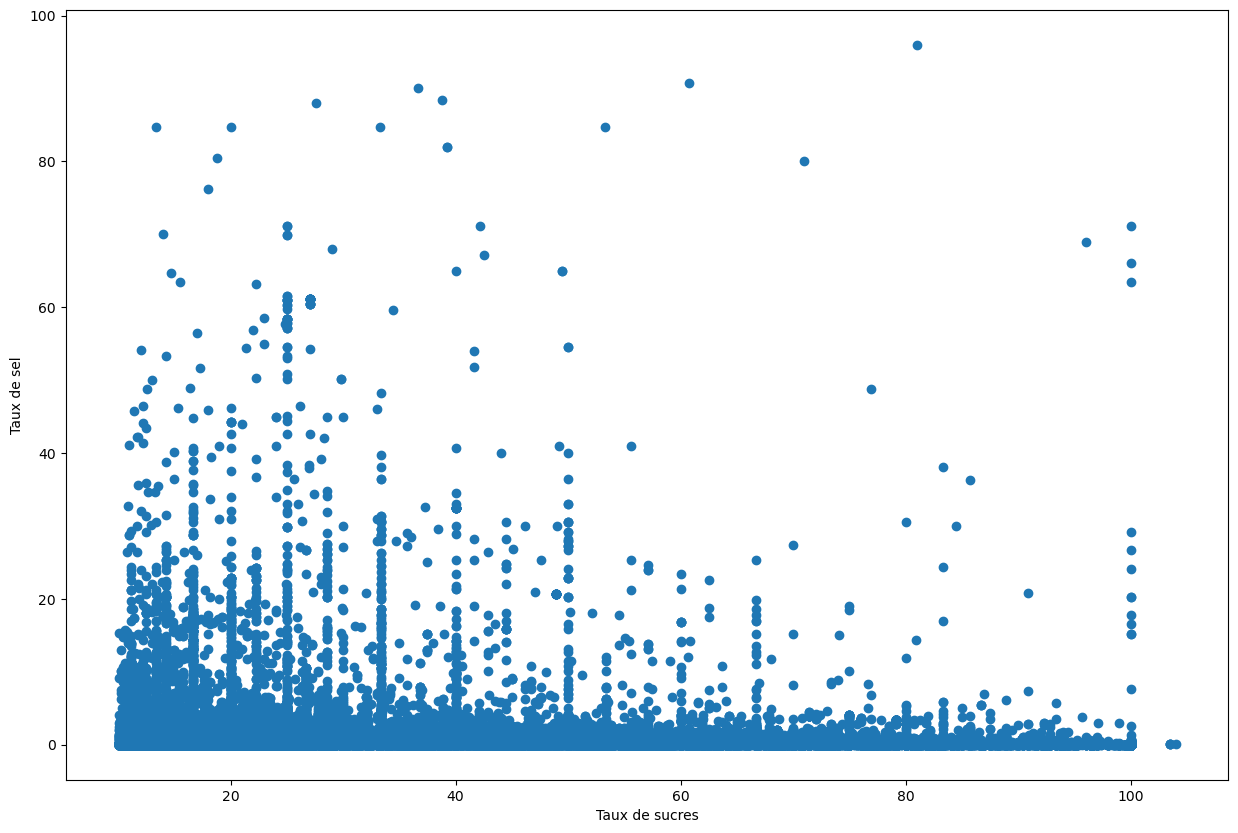

In [43]:
sucr_sel = data.loc[(data['sugars_100g'] > 10) & ~(data['salt_100g'].isna()), ['sugars_100g','salt_100g']]
plt.figure(figsize=(15,10))
plt.scatter(sucr_sel['sugars_100g'],sucr_sel['salt_100g'])
plt.xlabel("Taux de sucres")
plt.ylabel("Taux de sel")
plt.show()

Globalement le taux de sel diminue bien avec celui de sucre, mais pas linéairement et il y a beaucoup de pics concernant des produits très salés et bien ou très sucrés. Donc on ne peut pas en déduire une règle générale. Par curiosité, voyons ce que ça donne sur l'ensemble des produits, i.e. pas seulement ceux riches en sucres :

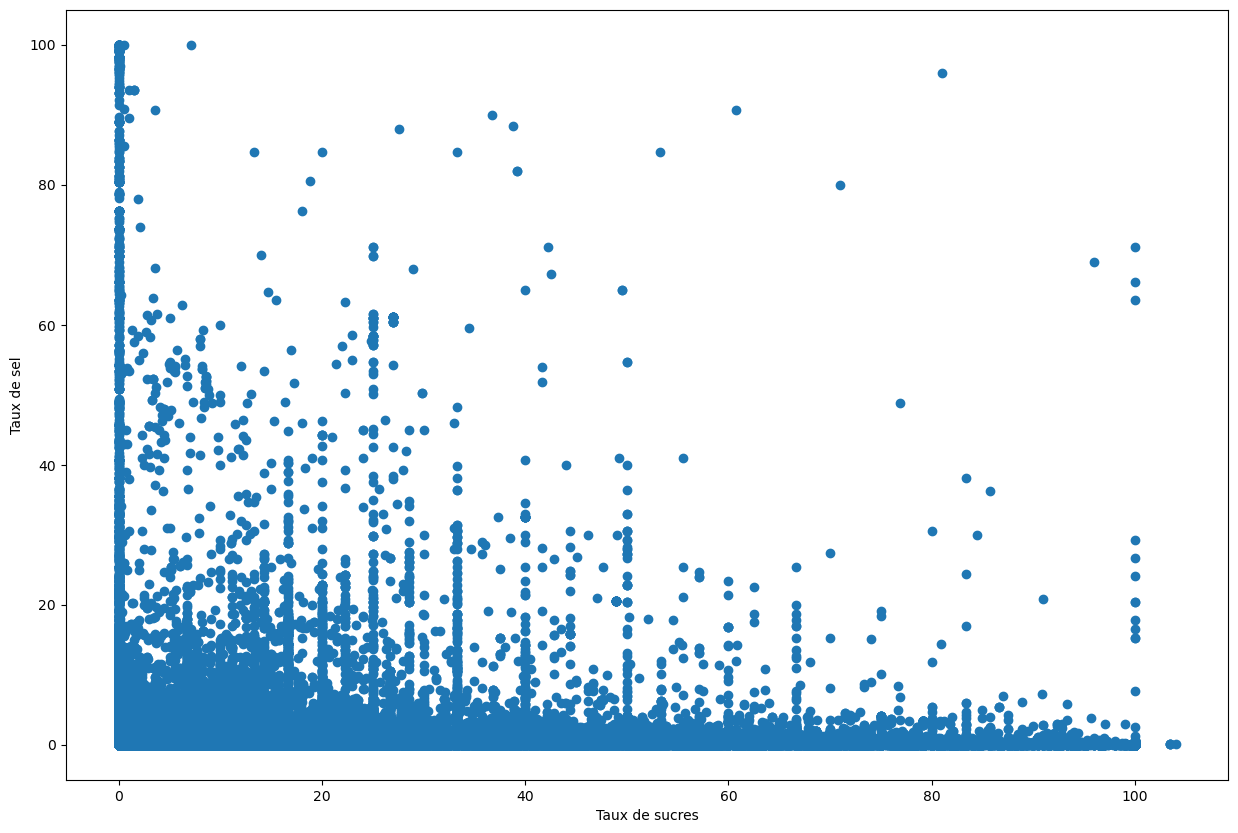

In [44]:
sucr_sel = data.loc[~(data['salt_100g'].isna()), ['sugars_100g','salt_100g']]
plt.figure(figsize=(15,10))
plt.scatter(sucr_sel['sugars_100g'],sucr_sel['salt_100g'])
plt.xlabel("Taux de sucres")
plt.ylabel("Taux de sel")
plt.show()

In [45]:
sucr_sel.mean()

sugars_100g    15.917961
salt_100g       1.638582
dtype: float64

In [46]:
sucr_sel.median()

sugars_100g    5.71000
salt_100g      0.59182
dtype: float64

Pour les produits où on a toutes les info. sauf le taux de sel, on pourrait calculer le nutriscore sans sel et, par différence avec le nutriscore donné, connaitre le taux de sel. Cela signifie qu'il faudrait créer une fonction Nutriscore_sans_sel, je ne sais pas si c'est un exercice attendu dans le cadre de cette analyse, pour l'instant je vais attribuer une valeur bien spécifique (mais assez 'centrale') de sorte que je pourrai l'identifier ultérieurement.
<br>Cette deuxième méthode d'imputation (par une valeur fixe assez standard pour les produits concernés) n'est pas courante, mais utile pour identifier facilement certains produits ("marqueur").

In [48]:
data.loc[data['salt_100g'] == 1.111, 'product_name']

Series([], Name: product_name, dtype: object)

In [66]:
# la valeur 1.111 est bien remarquable (aucun produit ne la présente)
list_ind = data.loc[~(data['nutrition-score-fr_100g'].isna()) & (data['energy_100g'].isna() | data['saturated-fat_100g'].isna() | data['sugars_100g'].isna() | data['proteins_100g'].isna() | data['salt_100g'].isna()), 'product_name'].index
for ind in list_ind :
    try :
        if data.loc[ind]['salt_100g'].astype('int') < -2111111111 :  # c'est le cas si vaut np.NaN ...
            data.iloc[ind,83] = 1.111
            data.iloc[ind,84] = 1.111*2/5
    except :
        continue


In [67]:
data.loc[~(data['nutrition-score-fr_100g'].isna()) & (data['energy_100g'].isna() | data['saturated-fat_100g'].isna() | data['sugars_100g'].isna() | data['proteins_100g'].isna() | data['salt_100g'].isna()),['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g','nutrition-score-fr_100g']]

product_name  energy_100g  \
32937                                Whole Cashews       2389.0   
145220                   Tcho-A-Day Dark Chocolate       2301.0   
216653  mini choux goût fromage de chèvre - poivre       1980.0   

        saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
32937                 8.93         3.57         3.6            NaN    0.99822   
145220               22.50        40.00         0.0            NaN    0.00000   
216653                 NaN        22.70         0.0            0.0    9.33000   

        sodium_100g  nutrition-score-fr_100g  
32937         0.393                     14.0  
145220        0.000                     24.0  
216653        3.670                     35.0

In [70]:
# On va tâcher de compléter ces trois dernières lignes 'manuellement'
data.loc[(data.product_name == 'Whole Cashews') & ~(data.proteins_100g.isna()), 'proteins_100g'].mean()

16.9876

In [71]:
data.iloc[32937,81] = 17.0

In [72]:
data.loc[(data.product_name == 'Dark Chocolate') & ~(data.proteins_100g.isna()), 'proteins_100g'].mean()

6.58729411764706

In [73]:
data.iloc[145220,81] = 6.6  # méthode d'imputation : 'remplissage par la moyenne de la catégorie'

In [75]:
# pour le dernier on utilise ce qu'on a vu pour l'énergie : au minimum 41 x gras + 17 x proteines + 17 x sucre,
# ce qui nous donne :
data.iloc[216653,60] = 38.9

Bien, maintenant tous les produits dotés d'un nutriscore ont aussi le détail (hors fibres) des champs qui servent à son calcul.

<a name="E10"></a>
<br>Concernant les produits ayant un nutriscore et tous les champs liés à son calcul sauf les fibres, on peut-être tenté de les comparer à des produits qui ont des valeurs équivalentes pour tous ces champs, mais qui ont aussi l'information sur les fibres. Probablement que cela permettrait de renseigner les premiers. Tâchons d'évaluer cette possibilité :

In [6]:
# rappel du taux de remplissage de l'info. 'fibre' sur les produits 'nutriscorés' :
data.loc[~(data['nutrition-score-fr_100g'].isna()), 'fiber_100g'].isna().value_counts()

False    183840
True      24411
Name: fiber_100g, dtype: int64

In [7]:
data.loc[~(data['nutrition-score-fr_100g'].isna()), 'fiber_100g'].isna().mean()

0.1172191249981993

In [8]:
# ici 'mean' est en fait le nb de 'nan' / nb total, on a donc plus de 88% de cellules renseignées
data.loc[data['fiber_100g'] == 10.0, ['product_name','energy_100g','saturated-fat_100g','sugars_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name  energy_100g  \
22                 Fire Roasted Hatch Green Chile Almonds       2372.0   
28                                  Wasabi Tamari Almonds       2230.0   
92                              Organic Raw Pumpkin Seeds       2510.0   
101                         Whole Wheat 'N Honey Fig Bars       1255.0   
133                             Lundberg Olde World Pilaf       1423.0   
...                                                   ...          ...   
246702                                  Müesli aux fruits       1403.0   
246902                     Flocons d'avoine complets fins       1550.0   
247052                                            GRANOLA       1985.0   
247168                                                NaN       1548.0   
247176  Blévita Crispy's Biscuits avec du fromage et d...       1891.0   

        saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  \
22                    3.33         6.67           6.67    1.27000   
28                    3.33         3.33          20.00    2.03200   
92                   13.33         3.33          30.00    0.04318   
101                   3.33        26.67          10.00    0.71882   
133                   1.11         2.22          11.11        NaN   
...                    ...          ...            ...        ...   
246702                0.90        22.00           8.00    0.03000   
246902                1.50         1.00          13.00    0.10000   
247052                5.00        17.00          11.00    0.38000   
247168                0.60         5.00          12.00    1.30000   
247176                6.00         3.50          17.00    2.00000   

        nutrition-score-fr_100g  
22                         11.0  
28                         12.0  
92                         12.0  
101                         9.0  
133                         NaN  
...                         ...  
246702                     -1.0  
246902                     -5.0  
247052                      8.0  
247168                      0.0  
247176                     13.0  

[1912 rows x 7 columns]

In [10]:
data.loc[(data['fiber_100g'] == 10.0) & (data['energy_100g'] > 1500) & (data['energy_100g'] < 1600) , ['product_name','energy_100g','saturated-fat_100g','sugars_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name  energy_100g  \
1800                              Steel Cut Oats       1569.0   
2889         Old Fashioned 100% Whole Grain Oats       1569.0   
2890         Old Fashioned 100% Whole Grain Oats       1569.0   
3738                       100% Whole Grain Oats       1569.0   
5731                      Organic Steel Cut Oats       1569.0   
...                                          ...          ...   
242145                        Flocons d'épeautre       1510.0   
242395  Birchermüesli Extra : sans sucre ajoutés       1520.0   
242511                            Abricot-amande       1570.0   
246902            Flocons d'avoine complets fins       1550.0   
247168                                       NaN       1548.0   

        saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  \
1800                  1.25          2.5           12.5       0.00   
2889                  0.00          2.5           15.0       0.00   
2890                  0.00          2.5           15.0       0.00   
3738                  0.00          2.5           15.0       0.00   
5731                  1.25          2.5           12.5       0.00   
...                    ...          ...            ...        ...   
242145                0.00          3.0           15.0       0.01   
242395                1.00         15.0           14.0       0.10   
242511                1.50         47.0            8.0       0.01   
246902                1.50          1.0           13.0       0.10   
247168                0.60          5.0           12.0       1.30   

        nutrition-score-fr_100g  
1800                       -5.0  
2889                       -6.0  
2890                       -6.0  
3738                       -6.0  
5731                       -5.0  
...                         ...  
242145                     -6.0  
242395                     -3.0  
242511                     10.0  
246902                     -5.0  
247168                      0.0  

[310 rows x 7 columns]

In [11]:
# on est ici clairement dans la categorie des mueslis et flocons de céréales. Affinons davantage par un bornage du sel ...
data.loc[(data['fiber_100g'] == 10.0) & (data['energy_100g'] > 1500) & (data['energy_100g'] < 1600) & (data['salt_100g'] < 0.1), ['product_name','energy_100g','saturated-fat_100g','sugars_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name  energy_100g  saturated-fat_100g  \
1800                         Steel Cut Oats       1569.0                1.25   
2889    Old Fashioned 100% Whole Grain Oats       1569.0                0.00   
2890    Old Fashioned 100% Whole Grain Oats       1569.0                0.00   
3738                  100% Whole Grain Oats       1569.0                0.00   
5731                 Organic Steel Cut Oats       1569.0                1.25   
...                                     ...          ...                 ...   
239657                        Havregryn Axa       1548.0                7.00   
240198                     Swiss BabyMüesli       1540.0                1.00   
241046           Flocons d\'avoine complets       1580.0                1.00   
242145                   Flocons d'épeautre       1510.0                0.00   
242511                       Abricot-amande       1570.0                1.50   

        sugars_100g  proteins_100g  salt_100g  nutrition-score-fr_100g  
1800            2.5           12.5     0.0000                     -5.0  
2889            2.5           15.0     0.0000                     -6.0  
2890            2.5           15.0     0.0000                     -6.0  
3738            2.5           15.0     0.0000                     -6.0  
5731            2.5           12.5     0.0000                     -5.0  
...             ...            ...        ...                      ...  
239657          1.3           13.0     0.0000                      0.0  
240198         15.0           11.0     0.0130                     -3.0  
241046          1.0           15.0     0.0254                     -6.0  
242145          3.0           15.0     0.0100                     -6.0  
242511         47.0            8.0     0.0100                     10.0  

[202 rows x 7 columns]

In [14]:
data.loc[(data['fiber_100g'] == 10.0) & (data['energy_100g'] > 1500) & (data['energy_100g'] < 1600) & (data['salt_100g'] < 0.1) & (data['sugars_100g'] == 2.5), ['product_name','energy_100g','saturated-fat_100g','sugars_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name  energy_100g  \
1800                           Steel Cut Oats       1569.0   
2889      Old Fashioned 100% Whole Grain Oats       1569.0   
2890      Old Fashioned 100% Whole Grain Oats       1569.0   
3738                    100% Whole Grain Oats       1569.0   
5731                   Organic Steel Cut Oats       1569.0   
...                                       ...          ...   
152701  Glutenfreeda, Natural Instant Oatmeal       1569.0   
157468            100% Whole Grain Quick Oats       1569.0   
165159          Rolled Whole Grain Quick Oats       1569.0   
165215   Old Fashioned Oats, 100% Whole Grain       1569.0   
169703                       Irish style oats       1570.0   

        saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  \
1800                  1.25          2.5           12.5        0.0   
2889                  0.00          2.5           15.0        0.0   
2890                  0.00          2.5           15.0        0.0   
3738                  0.00          2.5           15.0        0.0   
5731                  1.25          2.5           12.5        0.0   
...                    ...          ...            ...        ...   
152701                0.00          2.5           15.0        0.0   
157468                1.25          2.5           12.5        0.0   
165159                1.25          2.5           12.5        0.0   
165215                1.25          2.5           12.5        0.0   
169703                0.00          2.5           12.5        0.0   

        nutrition-score-fr_100g  
1800                       -5.0  
2889                       -6.0  
2890                       -6.0  
3738                       -6.0  
5731                       -5.0  
...                         ...  
152701                     -6.0  
157468                     -5.0  
165159                     -5.0  
165215                     -5.0  
169703                     -6.0  

[103 rows x 7 columns]

In [15]:
# il semble qu'on ait maintenant un groupe très homogène, vérifions avec un autre échantillon :
data.loc[(data['fiber_100g'] == 10.0) & (data['energy_100g'] > 1500) & (data['energy_100g'] < 1600) & (data['salt_100g'] < 0.1) & (data['sugars_100g'] == 2.5), ['product_name','energy_100g','saturated-fat_100g','sugars_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']][10:30]

product_name  energy_100g  \
9542                    Organic Original Instant Oatmeal       1569.0   
9850                   B4y, Quick Cooking Steel Cut Oats       1569.0   
12037                        Organic 1 Minute Quick Oats       1569.0   
18230                          Old Fashioned Rolled Oats       1569.0   
18231                          Old Fashioned Rolled Oats       1569.0   
18232                             100% Rolled Quick Oats       1569.0   
18233                             Quick Oats 100% Rolled       1569.0   
24367  Quaker Oats 100% Natural Whole Grain OLD FASHI...       1570.0   
31074                                        Foska, Oats       1569.0   
31933                                         Quick Oats       1569.0   
31935                  Organic Instant Oatmeal, Original       1569.0   
32081                             Organic Steel Cut Oats       1569.0   
33008                       Organic Quick Steel Cut Oats       1569.0   
38026                 Organic Steel Cut Irish Style Oats       1569.0   
38027                   Oven Toasted Oats, Old Fashioned       1569.0   
39104                                 Old Fashioned Oats       1569.0   
41720                             Oatmeal, Old Fashioned       1569.0   
41816                             Whole Grain Quick Oats       1569.0   
42247                                 Old Fashioned Oats       1569.0   
43014                          Quick Cook Steel Cut Oats       1569.0   

       saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  \
9542                 0.00          2.5           15.0        0.0   
9850                 1.25          2.5           12.5        0.0   
12037                1.25          2.5           12.5        0.0   
18230                1.25          2.5           12.5        0.0   
18231                1.25          2.5           12.5        0.0   
18232                1.25          2.5           12.5        0.0   
18233                1.25          2.5           12.5        0.0   
24367                1.25          2.5           12.5        0.0   
31074                1.25          2.5           12.5        0.0   
31933                1.25          2.5           12.5        0.0   
31935                0.00          2.5           15.0        0.0   
32081                1.25          2.5           12.5        0.0   
33008                1.25          2.5           12.5        0.0   
38026                0.00          2.5           12.5        0.0   
38027                1.25          2.5           12.5        0.0   
39104                1.25          2.5           12.5        0.0   
41720                1.25          2.5           12.5        0.0   
41816                1.25          2.5           12.5        0.0   
42247                1.25          2.5           12.5        0.0   
43014                1.25          2.5           12.5        0.0   

       nutrition-score-fr_100g  
9542                      -6.0  
9850                      -5.0  
12037                     -5.0  
18230                     -5.0  
18231                     -5.0  
18232                     -5.0  
18233                     -5.0  
24367                     -5.0  
31074                     -5.0  
31933                     -5.0  
31935                     -6.0  
32081                     -5.0  
33008                     -5.0  
38026                     -6.0  
38027                     -5.0  
39104                     -5.0  
41720                     -5.0  
41816                     -5.0  
42247                     -5.0  
43014                     -5.0

In [17]:
# pouvons nous maintenant identifier des produits similaires mais sans l'info. fibres ?
data.loc[(data['fiber_100g'].isna()) & (data['energy_100g'] > 1500) & (data['energy_100g'] < 1600) & (data['salt_100g'] < 0.1) & (data['sugars_100g'] == 2.5) & (data['proteins_100g'] > 12.0) & (data['proteins_100g'] <= 15.0), ['product_name','energy_100g','saturated-fat_100g','sugars_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name  energy_100g  saturated-fat_100g  \
170435  Pâtes italienne, Tagliatelle       1553.0                 1.2   
175777                   Tagliatelle       1553.0                 1.2   
190098         Tagliatelles aux œufs       1553.0                 1.2   

        sugars_100g  proteins_100g  salt_100g  nutrition-score-fr_100g  
170435          2.5           13.0       0.05                      0.0  
175777          2.5           13.0       0.05                      0.0  
190098          2.5           13.0       0.05                      0.0

Ce n'est pas gagné, parce qu'on voit que si on retire l'information sur les fibres, on a les pâtes qui viennent (ci-dessus avec un nutriscore nul, mais il y en a plein avec un nutriscore équivalent aux flocons de céréales) et les pâtes sont moins riches en fibres. Toutefois on n'est pas très loin des valeurs espérées, il faudrait affiner et itérer jusqu'à parvenir à de bons résultats, c'est le principe de l'*iterativeimputer* notamment. Nous allons utiliser cette méthode pour imputer toutes les valeurs manquantes concernant les fibres, pour les produits qui ont un nutriscore.
<br>Nous allons pour cela créer un dataframe limité, puis le sauvegarder et arrêter / relancer le 'kernel' parce que LA METHODE DATAFRAME.CLOSE() N'EXISTE PAS !! et étant donné la taille de 'data' il est risqué, en terme de saturation de mémoire, de lancer un iterativeimputer sur un gros dataframe en ayant un autre encore plus gros ouvert.
<br>Au passage, on peut régler les valeurs érronées pour les trois produits ci-dessus :

In [4]:
data.loc[data['product_name'].str[0:5] == 'Pâtes', ['fiber_100g','energy_100g','saturated-fat_100g','sugars_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

fiber_100g  energy_100g  saturated-fat_100g  sugars_100g  \
103730         3.0        946.0                 4.6          1.2   
114975         3.6       1569.0                 0.0          0.0   
170435         NaN       1553.0                 1.2          2.5   
171038         1.8       1414.0                 0.1         71.0   
174751         0.0       1590.0                 1.6          3.0   
...            ...          ...                 ...          ...   
235360         2.5       1481.0                 0.1          3.5   
241663         NaN        860.0                 NaN          NaN   
242744         1.0        660.0                 0.5          2.5   
243267         1.0       1090.0                 5.0          4.5   
245768         2.5        786.0                 3.0          2.0   

        proteins_100g  salt_100g  nutrition-score-fr_100g  
103730           6.10      0.800                      2.0  
114975           7.14      0.000                     -5.0  
170435          13.00      0.050                      0.0  
171038           0.50      0.190                      7.0  
174751          13.04      0.130                      0.0  
...               ...        ...                      ...  
235360          11.80      0.025                     -4.0  
241663          11.00        NaN                      NaN  
242744           7.00      1.000                      0.0  
243267          13.00      1.100                     10.0  
245768          10.00      1.100                      0.0  

[152 rows x 7 columns]

In [6]:
data.loc[data['product_name'].str[0:8] == 'Macaroni', ['fiber_100g','energy_100g','saturated-fat_100g','sugars_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

fiber_100g  energy_100g  saturated-fat_100g  sugars_100g  \
1883           0.8        669.0                4.00         2.40   
2011           1.4        837.0                1.79         2.14   
2140           0.4        536.0                2.40         3.20   
2595           1.4        895.0                2.41         4.83   
2597           1.4        895.0                2.41         4.83   
...            ...          ...                 ...          ...   
234787         3.5       1464.0                0.30         3.20   
235014         NaN       1500.0                0.10         3.50   
235233         2.5       1481.0                0.10         3.50   
238556         2.9       1494.0                0.00         8.57   
240723         3.0       1515.0                0.60         2.50   

        proteins_100g  salt_100g  nutrition-score-fr_100g  
1883             6.80    0.91440                      2.0  
2011             3.57    0.63500                      2.0  
2140             6.00    0.86360                      3.0  
2595             3.45    1.41986                     10.0  
2597             3.45    1.41986                     10.0  
...               ...        ...                      ...  
234787          12.60    0.01000                     -5.0  
235014          11.80    0.03000                     -1.0  
235233          11.80    0.03000                     -4.0  
238556          11.43    2.03200                      9.0  
240723          15.00    0.53340                     -3.0  

[267 rows x 7 columns]

In [11]:
# par similitude avec les autres produits correctement renseignés : (méthode d'imputation par valeur standard)
data.iloc[170435,123] = -4.0
data.iloc[175777,123] = -4.0
data.iloc[190098,123] = -4.0

In [12]:
# création du DF pour imputation iterative des fibres :
DF = data.loc[~(data['nutrition-score-fr_100g'].isna()), ['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

In [13]:
DF.to_csv('df_for_fibfill.csv', sep='|')

In [14]:
data.to_csv('fr.openfoodfacts.org.products.csv', sep='	')

In [1]:
# après redemarrage du kernel :
import pandas as pd
DF = pd.read_csv('df_for_fibfill.csv', sep='|')

In [3]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208251 entries, 0 to 208250
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               208251 non-null  int64  
 1   energy_100g              208251 non-null  float64
 2   saturated-fat_100g       208251 non-null  float64
 3   sugars_100g              208251 non-null  float64
 4   fiber_100g               183840 non-null  float64
 5   proteins_100g            208251 non-null  float64
 6   salt_100g                208251 non-null  float64
 7   nutrition-score-fr_100g  208251 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 12.7 MB


In [2]:
DF = DF.drop('Unnamed: 0', axis=1)

In [6]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, MissingIndicator

indicator = MissingIndicator()  # matrice True/False des valeurs manquantes
DF_indic = indicator.fit_transform(DF)

imputer = IterativeImputer(tol=0.5, skip_complete=True, verbose=1, random_state=3, add_indicator=True )
DF_imp = imputer.fit_transform(DF)


[IterativeImputer] Completing matrix with shape (208251, 7)
[IterativeImputer] Change: 11.757378760633426, scaled tolerance: 2379.155 
[IterativeImputer] Early stopping criterion reached.


In [7]:
# avant imputation :
DF.iloc[40:60,:]

energy_100g  saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  \
40       2197.0              20.000       57.500       2.500           7.50   
41       2092.0              11.760        2.940       8.800          26.47   
42       2092.0              17.500       47.500         NaN           5.00   
43       1749.0               1.820       16.360      10.900          12.73   
44       1255.0               0.000       66.670      10.000           0.00   
45       1046.0               0.000       52.500       7.500           2.50   
46       2243.0              28.570       14.290       3.600           3.57   
47       1674.0               2.730       21.820       7.300           9.09   
48       1569.0               0.000       65.000       2.500           2.50   
49       1883.0              12.500       42.500       2.500           5.00   
50       1941.0               0.000       17.860       7.100          17.86   
51       2540.0               5.360       10.710      10.700          21.43   
52       2402.0               8.820        5.880       2.900          14.71   
53        159.0               0.000        6.410       2.600           1.28   
54       1210.0               7.000        0.000       2.000          22.00   
55       1090.0               2.000       24.700       2.000           3.33   
56       1160.0               0.333        1.110       2.220          10.00   
57        478.0               2.860        0.714       0.357           5.36   
58       1753.0               0.800       87.700       0.900           0.60   
59       2406.0               2.900       50.300       3.900           9.50   

    salt_100g  nutrition-score-fr_100g  
40    0.09652                     23.0  
41    0.97028                     15.0  
42    1.14300                     30.0  
43    0.02286                     -1.0  
44    0.00000                      8.0  
45    0.00000                      8.0  
46    0.00000                     14.0  
47    0.11430                      0.0  
48    1.96850                     19.0  
49    1.01600                     25.0  
50    0.63500                      0.0  
51    1.45034                     15.0  
52    0.03810                     12.0  
53    0.19558                     -2.0  
54    2.16000                      6.0  
55    0.64700                      9.0  
56    1.52000                      1.0  
57    0.49900                      2.0  
58    0.01000                     14.0  
59    0.00300                     14.0

In [7]:
# avant imputation :
DF.loc[DF['fiber_100g'].isna(), 'nutrition-score-fr_100g'].count()

24411

In [13]:
print(str(DF_imp[40,0:6]) + ', ' + str(DF_imp[40,6:8]))  # sans cette manipulation, la sortie d'une ligne se fait sur 2 lignes

[2.197e+03 2.000e+01 5.750e+01 2.500e+00 7.500e+00 9.652e-02], [23.  0.]


In [14]:
for i in range(40,60) :
    print(str(DF_imp[i,0:6]) + ' ' + str(DF_imp[i,6:8]))

[2.197e+03 2.000e+01 5.750e+01 2.500e+00 7.500e+00 9.652e-02] [23.  0.]
[2.0920e+03 1.1760e+01 2.9400e+00 8.8000e+00 2.6470e+01 9.7028e-01] [15.  0.]
[2.09200000e+03 1.75000000e+01 4.75000000e+01 4.10919705e-01
 5.00000000e+00 1.14300000e+00] [30.  1.]
[1.749e+03 1.820e+00 1.636e+01 1.090e+01 1.273e+01 2.286e-02] [-1.  0.]
[1255.      0.     66.67   10.      0.      0.  ] [8. 0.]
[1046.     0.    52.5    7.5    2.5    0. ] [8. 0.]
[2243.     28.57   14.29    3.6     3.57    0.  ] [14.  0.]
[1.674e+03 2.730e+00 2.182e+01 7.300e+00 9.090e+00 1.143e-01] [0. 0.]
[1569.        0.       65.        2.5       2.5       1.9685] [19.  0.]
[1.883e+03 1.250e+01 4.250e+01 2.500e+00 5.000e+00 1.016e+00] [25.  0.]
[1.941e+03 0.000e+00 1.786e+01 7.100e+00 1.786e+01 6.350e-01] [0. 0.]
[2.54000e+03 5.36000e+00 1.07100e+01 1.07000e+01 2.14300e+01 1.45034e+00] [15.  0.]
[2.402e+03 8.820e+00 5.880e+00 2.900e+00 1.471e+01 3.810e-02] [12.  0.]
[159.        0.        6.41      2.6       1.28      0.19558] [-2

Nous avons une colonne supplementaire dans l'array (numpy ndarray) de sortie, ne contenant que 0 ou 1, qui donne le nombre de valeur imputée.
<br>Du coup, DF_indic n'était pas nécéssaire !

In [15]:
DF_indic[40:60,:]

array([[False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False]])

In [22]:
DF_imp.shape

(208251, 8)

In [25]:
# Nous allons mettre à jour les valeurs des fibres dans DF qui a l'avantage d'être un dataframe pandas :
DF['fiber_100g'] = DF_imp[:,3].round(3)

In [26]:
# après imputation :
DF.iloc[40:60,:]

energy_100g  saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  \
40       2197.0              20.000       57.500       2.500           7.50   
41       2092.0              11.760        2.940       8.800          26.47   
42       2092.0              17.500       47.500       0.411           5.00   
43       1749.0               1.820       16.360      10.900          12.73   
44       1255.0               0.000       66.670      10.000           0.00   
45       1046.0               0.000       52.500       7.500           2.50   
46       2243.0              28.570       14.290       3.600           3.57   
47       1674.0               2.730       21.820       7.300           9.09   
48       1569.0               0.000       65.000       2.500           2.50   
49       1883.0              12.500       42.500       2.500           5.00   
50       1941.0               0.000       17.860       7.100          17.86   
51       2540.0               5.360       10.710      10.700          21.43   
52       2402.0               8.820        5.880       2.900          14.71   
53        159.0               0.000        6.410       2.600           1.28   
54       1210.0               7.000        0.000       2.000          22.00   
55       1090.0               2.000       24.700       2.000           3.33   
56       1160.0               0.333        1.110       2.220          10.00   
57        478.0               2.860        0.714       0.357           5.36   
58       1753.0               0.800       87.700       0.900           0.60   
59       2406.0               2.900       50.300       3.900           9.50   

    salt_100g  nutrition-score-fr_100g  
40    0.09652                     23.0  
41    0.97028                     15.0  
42    1.14300                     30.0  
43    0.02286                     -1.0  
44    0.00000                      8.0  
45    0.00000                      8.0  
46    0.00000                     14.0  
47    0.11430                      0.0  
48    1.96850                     19.0  
49    1.01600                     25.0  
50    0.63500                      0.0  
51    1.45034                     15.0  
52    0.03810                     12.0  
53    0.19558                     -2.0  
54    2.16000                      6.0  
55    0.64700                      9.0  
56    1.52000                      1.0  
57    0.49900                      2.0  
58    0.01000                     14.0  
59    0.00300                     14.0

In [28]:
# On va aussi garder l'information de quelles lignes ont été imputées :
DF['imp'] = DF_imp[:,7]

In [29]:
DF.iloc[50:60,:]

energy_100g  saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  \
50       1941.0               0.000       17.860       7.100          17.86   
51       2540.0               5.360       10.710      10.700          21.43   
52       2402.0               8.820        5.880       2.900          14.71   
53        159.0               0.000        6.410       2.600           1.28   
54       1210.0               7.000        0.000       2.000          22.00   
55       1090.0               2.000       24.700       2.000           3.33   
56       1160.0               0.333        1.110       2.220          10.00   
57        478.0               2.860        0.714       0.357           5.36   
58       1753.0               0.800       87.700       0.900           0.60   
59       2406.0               2.900       50.300       3.900           9.50   

    salt_100g  nutrition-score-fr_100g  imp  
50    0.63500                      0.0  0.0  
51    1.45034                     15.0  0.0  
52    0.03810                     12.0  0.0  
53    0.19558                     -2.0  0.0  
54    2.16000                      6.0  0.0  
55    0.64700                      9.0  0.0  
56    1.52000                      1.0  0.0  
57    0.49900                      2.0  0.0  
58    0.01000                     14.0  0.0  
59    0.00300                     14.0  0.0

In [30]:
DF.to_csv('df_for_fibfill.csv', sep='|')

Nous venons d'utiliser la méthode d'imputation par 'IterativeImputer'. Avant de mettre à jour nos données de 'data', procédons à quelques vérifications :

In [13]:
data.loc[(data.fiber_100g.isna()) & ~(data['nutrition-score-fr_100g'].isna()), ['product_name','energy_100g','saturated-fat_100g','sugars_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']][0:20]

product_name  energy_100g  \
106                                     Yogurt Pretzels       2092.0   
201                                  Belgische Pralinen       2257.0   
215                                                 7Up        177.0   
271       Williams, Liquor Chocolate With Williams Pear       1954.0   
307   Taami Elite, Milk Choolate Bar, Puffed Rice An...       2125.0   
362                                 Tnt Exploding Candy       1393.0   
363                                     Exploding Candy       1393.0   
364                                     Exploding Candy       1393.0   
534                           Extra Hot Chinese Mustard        837.0   
555         Creamy And Delicious Evaporated Filled Milk        556.0   
561                  Panda Brand, Oyster Flavored Sauce        552.0   
569                          Cool Beans, Buffalo Hummus       1197.0   
761   Squire Boone Village, Middle Size Heart Pop, C...       1674.0   
762   Squire Bone Village, Christmas Tree Lollipop, ...       1661.0   
881     Red Hots Imitation Sausage-Artificially Colored       1209.0   
1464                                      Good & Plenty       1460.0   
1833                           Fried Rice Seasoning Mix       1569.0   
1834                             Stir Fry Seasoning Mix       1393.0   
2722                           Rainbow Dessert Toppings       2092.0   
2728                           Rainbow Dessert Toppings       2092.0   

      saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  \
106                17.50        47.50           5.00    1.14300   
201                21.10        51.50           4.70    0.09000   
215                 0.00        10.40           0.00    0.10000   
271                14.00        57.00           4.50    0.30480   
307                17.50        37.50           5.00    0.41148   
362                 0.00       100.00           0.00    0.00000   
363                 0.00       100.00           0.00    0.00000   
364                 0.00       100.00           0.00    0.00000   
534                 0.00         0.00           0.00    3.30200   
555                 0.00        10.00           6.67    0.25400   
561                 0.00        21.05           0.00   13.10132   
569                 3.57         0.00           3.57    2.26822   
761                 0.00        88.10           0.00    0.05334   
762                 0.00        87.18           0.00    0.05334   
881                 7.89         1.32          14.47    2.44094   
1464                0.00        62.50           2.50    0.76200   
1833                0.00         0.00           0.00   18.41500   
1834                0.00         0.00           0.00   14.67612   
2722               25.00        50.00           0.00    0.00000   
2728               25.00        50.00           0.00    0.00000   

      nutrition-score-fr_100g  
106                      30.0  
201                      26.0  
215                      13.0  
271                      26.0  
307                      25.0  
362                      14.0  
363                      14.0  
364                      14.0  
534                      12.0  
555                       0.0  
561                      15.0  
569                      15.0  
761                      14.0  
762                      14.0  
881                      20.0  
1464                     17.0  
1833                     14.0  
1834                     14.0  
2722                     26.0  
2728                     26.0

In [11]:
DF.loc[DF['imp'] == 1.0, ['energy_100g','saturated-fat_100g','sugars_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']][0:20]

energy_100g  saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  \
42         2092.0               17.50        47.50           5.00    1.14300   
82         2257.0               21.10        51.50           4.70    0.09000   
89          177.0                0.00        10.40           0.00    0.10000   
114        1954.0               14.00        57.00           4.50    0.30480   
147        2125.0               17.50        37.50           5.00    0.41148   
199        1393.0                0.00       100.00           0.00    0.00000   
200        1393.0                0.00       100.00           0.00    0.00000   
201        1393.0                0.00       100.00           0.00    0.00000   
308         837.0                0.00         0.00           0.00    3.30200   
326         556.0                0.00        10.00           6.67    0.25400   
331         552.0                0.00        21.05           0.00   13.10132   
339        1197.0                3.57         0.00           3.57    2.26822   
499        1674.0                0.00        88.10           0.00    0.05334   
500        1661.0                0.00        87.18           0.00    0.05334   
510        1209.0                7.89         1.32          14.47    2.44094   
1017       1460.0                0.00        62.50           2.50    0.76200   
1295       1569.0                0.00         0.00           0.00   18.41500   
1296       1393.0                0.00         0.00           0.00   14.67612   
2083       2092.0               25.00        50.00           0.00    0.00000   
2084       2092.0               25.00        50.00           0.00    0.00000   

      nutrition-score-fr_100g  
42                       30.0  
82                       26.0  
89                       13.0  
114                      26.0  
147                      25.0  
199                      14.0  
200                      14.0  
201                      14.0  
308                      12.0  
326                       0.0  
331                      15.0  
339                      15.0  
499                      14.0  
500                      14.0  
510                      20.0  
1017                     17.0  
1295                     14.0  
1296                     14.0  
2083                     26.0  
2084                     26.0

In [14]:
# Ci-dessus on a bien exactement les mêmes données. Est-ce la même chose avec une plage beaucoup plus loin ?
data.loc[(data.fiber_100g.isna()) & ~(data['nutrition-score-fr_100g'].isna()), ['product_name','energy_100g','saturated-fat_100g','sugars_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']][4000:4020]

product_name  energy_100g  \
168953               Natural Coconut Water with Pineapple        100.0   
168954                      Vita Coco, Pure Coconut Water         79.0   
168956       Vita Coco, Pure Coconut Water, Peach & Mango        105.0   
168957                      Vita Coco, Pure Coconut Water        105.0   
168974                             Uncured Canadian Bacon        674.0   
168975               Blu Agave, Premium Organic Sweetener       1201.0   
168976                          Premium Organic Sweetener       1201.0   
169035  Raw Revolution, Organic Live Food Bar, Cherry,...       1724.0   
169077                    Pancake & Waffle Mix Buttermilk        962.0   
169126               Britannia, Good Day, Cookies, Cashew       2092.0   
169127                Britannia, Good Day Cookies, Butter       2092.0   
169128                Britannia, Good Day, Butter Cookies       2092.0   
169129  Parlines In Four Flavored, Toffee, Nut, Milk A...       2410.0   
169165            Energy Drink, Mojito, Lime, Lemon, Mint        188.0   
169202                                Apple Cider Vinegar          0.0   
169256                      Candi, Chocolate Chip Cookies       2054.0   
169257                                    Coconut Cookies       2079.0   
169267                          Light Mayonnaise Dressing       1393.0   
169270       Specialité laitiere /30%MG reduit en lactose        490.0   
169371                                       Pasta-Älgar        1500.0   

        saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  \
168953                0.00         6.00           0.00    0.03000   
168954                0.00         4.58           0.00    0.02540   
168956                0.00         6.25           0.00    0.02540   
168957                0.00         6.25           0.00    0.02794   
168974                1.79         1.79          19.64    2.04216   
168975                0.00        76.67           0.00    0.00000   
168976                0.00        76.67           0.00    0.00000   
169035                2.94        29.41          11.76    0.49784   
169077                0.00        13.00           7.00    1.57000   
169126               11.76        23.53           8.82    0.78486   
169127               11.76        23.53           5.88    0.82296   
169128               11.76        23.53           5.88    0.82296   
169129               21.21        30.30           9.09    0.30734   
169165                0.00        10.80           0.36    0.16256   
169202                0.00         0.00           0.00    0.00000   
169256               13.33         8.33           5.56    0.64262   
169257               14.44         1.11           6.11    0.33020   
169267                0.00         6.67           0.00    2.11582   
169270               21.00         3.00           2.40    0.07000   
169371                0.50         3.00          12.00    0.00000   

        nutrition-score-fr_100g  
168953                      8.0  
168954                      1.0  
168956                      1.0  
168957                      1.0  
168974                     11.0  
168975                     13.0  
168976                     13.0  
169035                     15.0  
169077                      6.0  
169126                     24.0  
169127                     24.0  
169128                     24.0  
169129                     24.0  
169165                      2.0  
169202                      0.0  
169256                     19.0  
169257                     17.0  
169267                     14.0  
169270                     11.0  
169371                     -1.0

In [15]:
DF.loc[DF['imp'] == 1.0, ['energy_100g','saturated-fat_100g','sugars_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']][4000:4020]

energy_100g  saturated-fat_100g  sugars_100g  proteins_100g  \
137035        100.0                0.00         6.00           0.00   
137036         79.0                0.00         4.58           0.00   
137038        105.0                0.00         6.25           0.00   
137039        105.0                0.00         6.25           0.00   
137056        674.0                1.79         1.79          19.64   
137057       1201.0                0.00        76.67           0.00   
137058       1201.0                0.00        76.67           0.00   
137115       1724.0                2.94        29.41          11.76   
137145        962.0                0.00        13.00           7.00   
137188       2092.0               11.76        23.53           8.82   
137189       2092.0               11.76        23.53           5.88   
137190       2092.0               11.76        23.53           5.88   
137191       2410.0               21.21        30.30           9.09   
137225        188.0                0.00        10.80           0.36   
137255          0.0                0.00         0.00           0.00   
137297       2054.0               13.33         8.33           5.56   
137298       2079.0               14.44         1.11           6.11   
137305       1393.0                0.00         6.67           0.00   
137308        490.0               21.00         3.00           2.40   
137404       1500.0                0.50         3.00          12.00   

        salt_100g  nutrition-score-fr_100g  
137035    0.03000                      8.0  
137036    0.02540                      1.0  
137038    0.02540                      1.0  
137039    0.02794                      1.0  
137056    2.04216                     11.0  
137057    0.00000                     13.0  
137058    0.00000                     13.0  
137115    0.49784                     15.0  
137145    1.57000                      6.0  
137188    0.78486                     24.0  
137189    0.82296                     24.0  
137190    0.82296                     24.0  
137191    0.30734                     24.0  
137225    0.16256                      2.0  
137255    0.00000                      0.0  
137297    0.64262                     19.0  
137298    0.33020                     17.0  
137305    2.11582                     14.0  
137308    0.07000                     11.0  
137404    0.00000                     -1.0

In [16]:
# Parfait, maintenant évaluons la qualité des imputations :
DF.loc[(DF['imp'] == 1.0) & (DF['fiber_100g'] > 5) & (DF['fiber_100g'] <= 5.5), ['energy_100g','saturated-fat_100g','sugars_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

energy_100g  saturated-fat_100g  sugars_100g  proteins_100g  \
8677         2444.0                 5.6         7.80          21.40   
8679         2444.0                 5.6         7.80          21.40   
8693         2444.0                 5.6         7.80          21.40   
11511        2648.0                 0.0        16.67           0.00   
18884        2582.0                10.0         3.33          21.33   
...             ...                 ...          ...            ...   
201757       1595.0                 0.0         1.30          14.00   
203475        950.0                 0.4         0.00          55.00   
205160       2279.0                19.1        49.50           6.90   
205163       2279.0                19.1        49.50           6.90   
208097       1252.0                 4.5         0.50          21.00   

        salt_100g  nutrition-score-fr_100g  
8677      1.30000                     18.0  
8679      1.30000                     18.0  
8693      1.30000                     18.0  
11511     1.05918                     14.0  
18884     0.55118                     18.0  
...           ...                      ...  
201757    1.50000                      5.0  
203475    8.00000                     12.0  
205160   65.00000                     36.0  
205163   65.00000                     36.0  
208097    0.50000                      4.0  

[225 rows x 6 columns]

In [21]:
data.loc[~(data['nutrition-score-fr_100g'].isna()) & (data.fiber_100g > 5) & (data.fiber_100g <= 5.5) , ['product_name','energy_100g','saturated-fat_100g','sugars_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name  energy_100g  \
74                             Granola Cranberry And Acai       1824.0   
287     The Madelaine Chocolate Company, Solid Dark Ch...       2201.0   
288                                  Solid Dark Chocolate       2201.0   
508          Cashews, Sesame And Pistachios Brittle Slice       2201.0   
705     Long Grove Confectionery Co., Milk Chocolate, ...       2092.0   
...                                                   ...          ...   
245163  Fitness Delice Céréales croustillantes avec un...       1415.0   
245180  collection carrousel ASSORTIMENT DE 6 RECETTES...       2230.0   
245218                                       Golden Minis       1623.0   
245250                               Collection farandole       1980.0   
245283                           Mélange parfait mexicain        607.0   

        saturated-fat_100g  sugars_100g  proteins_100g  salt_100g  \
74                    0.91        25.45           9.09    0.25400   
287                  21.05        50.00           5.26    0.03302   
288                  21.05        50.00           5.26    0.03302   
508                   5.26        50.00          13.16    0.13462   
705                  21.05        47.37           5.26    0.43434   
...                    ...          ...            ...        ...   
245163                0.50        24.00           6.00    0.55000   
245180               18.40        46.10           5.30    0.14000   
245218                1.10        25.20           6.90    0.97000   
245250               19.30        45.30           5.60    0.13000   
245283                0.50         3.80          12.00   61.60000   

        nutrition-score-fr_100g  
74                          6.0  
287                        21.0  
288                        21.0  
508                        16.0  
705                        22.0  
...                         ...  
245163                      6.0  
245180                     21.0  
245218                      9.0  
245250                     16.0  
245283                      6.0  

[2035 rows x 7 columns]

In [20]:
# les données ci-dessus nous permettent de croire en la pertinence de l'imputation mais cela reste vague.
# selectionnons des produits avec plus de précision pour vérifier la conformité des valeurs entre les deux dataframes :
data.loc[~(data['nutrition-score-fr_100g'].isna()) & (data.energy_100g > 900.0) & (data.energy_100g <= 1000.0) & (data['saturated-fat_100g'] > 5) & (data['saturated-fat_100g'] <= 6) & (data.sugars_100g > 10) & (data.sugars_100g <= 15), ['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

energy_100g  saturated-fat_100g  sugars_100g  fiber_100g  \
21348         954.0                5.37        13.42         0.7   
58442         983.0                5.88        11.76         0.0   
58443         983.0                5.88        11.76         0.0   
58444         983.0                5.88        11.76         0.0   
117628        975.0                6.00        12.33         0.7   
170060        986.0                5.10        15.00         1.7   
207602        904.0                5.34        14.20         1.3   
223292        929.0                6.00        14.00         NaN   
243876        980.0                6.00        13.00         2.5   

        proteins_100g  salt_100g  nutrition-score-fr_100g  
21348            8.72    1.12522                     13.0  
58442            5.88    0.59690                     11.0  
58443            5.88    0.59690                     11.0  
58444            5.88    0.59690                     11.0  
117628           8.33    0.00000                      4.0  
170060          14.00    0.97000                     12.0  
207602           4.90    0.07200                      6.0  
223292           7.00    2.30000                     20.0  
243876           3.00    0.80000                      9.0

In [23]:
DF.loc[(DF['imp'] == 1.0) & (DF['energy_100g'] > 900.0) & (DF['energy_100g'] <= 1000.0) & (DF['saturated-fat_100g'] > 5) & (DF['saturated-fat_100g'] <= 6) & (DF.sugars_100g > 10) & (DF.sugars_100g <= 15), ['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

energy_100g  saturated-fat_100g  sugars_100g  fiber_100g  \
187987        929.0                 6.0         14.0      -1.459   

        proteins_100g  salt_100g  nutrition-score-fr_100g  
187987            7.0        2.3                     20.0

Ce n'est pas concluant parce que notre imputation a conduit à une valeur négative !? Il va donc falloir trouver une autre méthode pour imputer les 'NaN' des fibres !

In [24]:
data['fiber_100g'].describe()

count    190314.000000
mean          2.830858
std           4.558559
min           0.000000
25%           0.000000
50%           1.500000
75%           3.600000
max         100.000000
Name: fiber_100g, dtype: float64

In [26]:
DF['fiber_100g'].describe()

count    208251.000000
mean          2.679876
std           4.248678
min          -5.942000
25%           0.000000
50%           1.500000
75%           3.600000
max         100.000000
Name: fiber_100g, dtype: float64

On peut voir ci dessus que l'imputation réalisée sur DF est parfaite concernant les quartiles et le max, mais catastrophique concernant le min !
<br>Nous allons recommencer avec l'iterative imputer mais en fixant min_value et max_value (étonnant qu'il n'ait pas pris en compte 'nativement' qu'il n'y a que des positifs !).
<br>Pour ce faire, nous allons réutiliser notre 'DF' et le remettre à son état de départ : mettre à 'nan' les valeurs imputées et retirer la colonne 'imp'.

In [3]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208251 entries, 0 to 208250
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   energy_100g              208251 non-null  float64
 1   saturated-fat_100g       208251 non-null  float64
 2   sugars_100g              208251 non-null  float64
 3   fiber_100g               208251 non-null  float64
 4   proteins_100g            208251 non-null  float64
 5   salt_100g                208251 non-null  float64
 6   nutrition-score-fr_100g  208251 non-null  float64
 7   imp                      208251 non-null  float64
dtypes: float64(8)
memory usage: 12.7 MB


In [4]:
import numpy as np
for i in range(208251) :
    if DF.iloc[i,7] == 1.0 :
        DF.iloc[i,3] = np.NaN


In [5]:
DF.drop('imp',axis=1)

energy_100g  saturated-fat_100g  sugars_100g  fiber_100g  \
0            2243.0               28.57        14.29         3.6   
1            1941.0                0.00        17.86         7.1   
2            2540.0                5.36         3.57         7.1   
3            1833.0                4.69        15.62         9.4   
4            2230.0                5.00         3.33         6.7   
...             ...                 ...          ...         ...   
208246        960.0                0.20         4.00         2.5   
208247        940.0                3.50         5.00         2.5   
208248       1510.0                0.00         0.00         1.0   
208249       1240.0                8.00         2.00         2.0   
208250        740.0                0.00         7.00         8.0   

        proteins_100g  salt_100g  nutrition-score-fr_100g  
0                3.57    0.00000                     14.0  
1               17.86    0.63500                      0.0  
2               17.86    1.22428                     12.0  
3               14.06    0.13970                      7.0  
4               16.67    1.60782                     12.0  
...               ...        ...                      ...  
208246           8.00    1.20000                      0.0  
208247          10.00    1.20000                      8.0  
208248           7.00    0.01000                     -1.0  
208249           8.00    1.40000                     14.0  
208250          10.00    0.40000                     -6.0  

[208251 rows x 7 columns]

In [6]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer(tol=0.5, skip_complete=True, min_value=0.000, max_value=100.000 ,verbose=1, random_state=3, add_indicator=True )
DF_imp = imputer.fit_transform(DF)

[IterativeImputer] Completing matrix with shape (208251, 8)
[IterativeImputer] Change: 11.757378733566643, scaled tolerance: 2379.155 
[IterativeImputer] Early stopping criterion reached.


In [8]:
# vérifions tout de suite l'impact sur la ligne repérée :
DF_imp[187987,:]

array([929. ,   6. ,  14. ,   0. ,   7. ,   2.3,  20. ,   1. ,   1. ])

In [11]:
# au niveau des fibres, c'est beaucoup mieux ! Par contre je ne sais pas pourquoi il y a maintenant 9 colonnes ??
DF_imp[30:50,7:9]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [12]:
# c'est la colonne 'indicator' qui est doublée, pourtant elle a été éliminée de DF et DF_imp n'était plus en mémoire !??
# Mettons à jour DF :
DF['fiber_100g'] = DF_imp[:,3].round(3)
DF['imp'] = DF_imp[:,7]

In [13]:
DF.iloc[30:50,:]

energy_100g  saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  \
30       2389.0                7.14         3.57       7.100          28.57   
31       2389.0                5.36         3.57       7.100          21.43   
32       2766.0                7.14         3.57      17.900          21.43   
33       2540.0                7.14         3.57       7.100          17.86   
34       2176.0                4.00        32.00       8.000          12.00   
35       1812.0                3.33        33.33       6.700          13.33   
36       2510.0               13.33         3.33      10.000          30.00   
37       1255.0                3.33        26.67      10.000          10.00   
38       1954.0               10.00        36.67       6.700          10.00   
39       1883.0               12.50        57.50       2.500           2.50   
40       2197.0               20.00        57.50       2.500           7.50   
41       2092.0               11.76         2.94       8.800          26.47   
42       2092.0               17.50        47.50       0.411           5.00   
43       1749.0                1.82        16.36      10.900          12.73   
44       1255.0                0.00        66.67      10.000           0.00   
45       1046.0                0.00        52.50       7.500           2.50   
46       2243.0               28.57        14.29       3.600           3.57   
47       1674.0                2.73        21.82       7.300           9.09   
48       1569.0                0.00        65.00       2.500           2.50   
49       1883.0               12.50        42.50       2.500           5.00   

    salt_100g  nutrition-score-fr_100g  imp  
30    1.13284                     13.0  0.0  
31    1.08966                     11.0  0.0  
32    1.08966                     14.0  0.0  
33    0.58928                     11.0  0.0  
34    0.20320                     11.0  0.0  
35    0.12700                     10.0  0.0  
36    0.04318                     12.0  0.0  
37    0.71882                      9.0  0.0  
38    0.21082                     17.0  0.0  
39    0.09652                     22.0  0.0  
40    0.09652                     23.0  0.0  
41    0.97028                     15.0  0.0  
42    1.14300                     30.0  1.0  
43    0.02286                     -1.0  0.0  
44    0.00000                      8.0  0.0  
45    0.00000                      8.0  0.0  
46    0.00000                     14.0  0.0  
47    0.11430                      0.0  0.0  
48    1.96850                     19.0  0.0  
49    1.01600                     25.0  0.0

In [14]:
DF['fiber_100g'].describe()

count    208251.000000
mean          2.699904
std           4.230870
min           0.000000
25%           0.000000
50%           1.500000
75%           3.600000
max         100.000000
Name: fiber_100g, dtype: float64

In [16]:
DF.to_csv('df_for_fibfill.csv', sep='|')

In [18]:
# Cette fois, on peut considérer que l'imputation est satisfaisante. On peut donc l'enregistrer dans 'data'.
# on commence par éliminer les lignes qui n'ont pas été modifiées dans DF :
DF = DF.loc[DF['imp'] == 1.0, :]

In [22]:
dfl = 0 # initialisation du compteur de lignes de DF limité aux lignes avec imputation
for i in range(len(data)) :
    if (data.loc[i]['fiber_100g'].astype('int') < -2111111111) & (data.loc[i]['nutrition-score-fr_100g'].astype('int') > -200) :
        # ci dessus, toujours en lieu et place de '== np.NaN' (par ex.) qui ne fonctionne pas
        if (data.loc[i]['energy_100g'] == DF.iloc[dfl,0]) & (data.loc[i]['sugars_100g'] == DF.iloc[dfl,2]) & (data.loc[i]['proteins_100g'] == DF.iloc[dfl,4]) : # quelques verifications
            data.iloc[i, 80] = DF.iloc[dfl,3]
            dfl += 1
        else :
            print('Anomalie lignes ' + str(i) + '->' + str(dfl))


In [23]:
# Vérification :
data.loc[223292][['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

energy_100g                929.0
saturated-fat_100g           6.0
sugars_100g                 14.0
fiber_100g                   0.0
proteins_100g                7.0
salt_100g                    2.3
nutrition-score-fr_100g     20.0
Name: 223292, dtype: object

Maintenant toutes les lignes avec un nutriscore ont tous les champs liés bien renseignés.<a name ="E11"></a>
<br>**Nous pouvons passer à la valorisation des informations manquantes pour les lignes qui n'ont pas de nutriscore.**

In [3]:
# A t'on des lignes sans nutriscore alors que les champs requis pour son calcul sont tous presents ?
data.loc[(data['nutrition-score-fr_100g'].isna()) & ~(data['energy_100g'].isna()) & ~(data['saturated-fat_100g'].isna()) & ~(data['sugars_100g'].isna()) & ~(data['fiber_100g'].isna()) & ~(data['proteins_100g'].isna()) & ~(data['salt_100g'].isna()), 'product_name'].count

<bound method Series.count of 69774                            Cup Noodles Chicken Flavor
132867              Instant Noodles Soup - Vegetable Flavor
170016                       Bouillon cube légumes sans sel
171762                                                Purée
174341                                             Mousline
                                ...                        
245843    Levure de bière vitaminée vitamine B1 & acide ...
245965                                          Sauce curry
246064                                    Calcium-Magnésium
246108                                                  NaN
246888                                                  NaN
Name: product_name, Length: 303, dtype: object>

In [4]:
data.loc[245965][57:87]

energy_100g                   0.0
energy-from-fat_100g          NaN
fat_100g                      0.0
saturated-fat_100g            0.0
monounsaturated-fat_100g      NaN
polyunsaturated-fat_100g      NaN
omega-3-fat_100g              NaN
alpha-linolenic-acid_100g     NaN
eicosapentaenoic-acid_100g    NaN
docosahexaenoic-acid_100g     NaN
omega-6-fat_100g              NaN
linoleic-acid_100g            NaN
omega-9-fat_100g              NaN
trans-fat_100g                NaN
cholesterol_100g              NaN
carbohydrates_100g            0.0
sugars_100g                   0.0
sucrose_100g                  NaN
glucose_100g                  NaN
fructose_100g                 NaN
lactose_100g                  NaN
starch_100g                   NaN
polyols_100g                  NaN
fiber_100g                    0.0
proteins_100g                 0.0
casein_100g                   NaN
salt_100g                     0.0
sodium_100g                   NaN
alcohol_100g                  NaN
vitamin-a_100g

On a bien tous les champs renseignés, pour le produit ci-dessus, mais avec des valeurs érronées (0 en l'occurance), ce qui justifie l'absence du nutriscore. Est-ce le cas pour les 303 produits repérés ?

In [6]:
ind_list = data.loc[(data['nutrition-score-fr_100g'].isna()) & ~(data['energy_100g'].isna()) & ~(data['saturated-fat_100g'].isna()) & ~(data['sugars_100g'].isna()) & ~(data['fiber_100g'].isna()) & ~(data['proteins_100g'].isna()) & ~(data['salt_100g'].isna()), 'product_name'].index
for ind in ind_list[0:30] :
    print(data.loc[ind][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']])


product_name               Cup Noodles Chicken Flavor
energy_100g                                    1830.0
saturated-fat_100g                               7.81
sugars_100g                                      3.12
fiber_100g                                       3.12
proteins_100g                                    10.9
salt_100g                                        5.68
nutrition-score-fr_100g                           NaN
Name: 69774, dtype: object
product_name               Instant Noodles Soup - Vegetable Flavor
energy_100g                                                 1866.0
saturated-fat_100g                                            9.23
sugars_100g                                                   3.08
fiber_100g                                                     3.1
proteins_100g                                                 9.23
salt_100g                                                    4.318
nutrition-score-fr_100g                                        NaN
Name:

In [7]:
for ind in ind_list[30:60] :
    print(data.loc[ind][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']])


product_name               Sveltesse Moulinée aux 9 légumes
energy_100g                                           120.0
saturated-fat_100g                                      0.1
sugars_100g                                             0.9
fiber_100g                                              0.9
proteins_100g                                           0.7
salt_100g                                              0.78
nutrition-score-fr_100g                                 NaN
Name: 177820, dtype: object
product_name               Mousline Saveur à l'Ancienne façon presse-purée
energy_100g                                                         1496.0
saturated-fat_100g                                                     0.6
sugars_100g                                                            3.5
fiber_100g                                                             4.6
proteins_100g                                                          9.3
salt_100g                                 

La majorité des produits a donc tous les champs bien renseignés, mais ce sont des produits particuliers : purées en flocons, condiments ou soupes ... pour lesquels le nutriscore est difficile à fournir car ils doivent être utilisés avec de l'eau ou autre liquide, ou dissous dans un liquide, ou ils contiennent une grande quantité d'eau (s'ils ne sont pas deshydratés). Nous allons laisser cette catégorie de côté pour le moment. Ils révèlent une faiblesse dans le processus d'estimation du nutriscore.

In [8]:
# On peut sortir de ce groupe le produit aux valeurs érronées :
import numpy as np
data.iloc[245965,57] = np.NaN  # energy
data.iloc[245965,59] = np.NaN  # fat_100g 
data.iloc[245965,60] = np.NaN  # saturated-fat_100g 
data.iloc[245965,72] = np.NaN  # carbohydrates_100g
data.iloc[245965,73] = np.NaN  # sugars_100g
data.iloc[245965,80] = np.NaN  # fibers_100g
data.iloc[245965,81] = np.NaN  # proteins_100g
data.iloc[245965,83] = np.NaN  # salt_100g

In [9]:
# On peut associer aux autres produits de ce groupe un nutriscore particulier, pour les indentifier :
data.loc[(data['nutrition-score-fr_100g'].isna()) & ~(data['energy_100g'].isna()) & ~(data['saturated-fat_100g'].isna()) & ~(data['sugars_100g'].isna()) & ~(data['fiber_100g'].isna()) & ~(data['proteins_100g'].isna()) & ~(data['salt_100g'].isna()), 'nutrition-score-fr_100g'] = 3.333

In [11]:
# Y-a t-il un lien entre les produits qui n'ont pas l'apport énergétique ?
data.loc[(data['nutrition-score-fr_100g'].isna()) & (data['energy_100g'].isna()) , ['product_name','categories_fr']]

product_name categories_fr
24                                     Real Salt Granular           NaN
68                                          Fine Sea Salt           NaN
94                                          Liquid Aminos           NaN
455                                               Gelatin           NaN
630                  Ginger Candy Sweetened With Raw Cane           NaN
...                                                   ...           ...
246571  Smoothie fruit du dragon, graines de chia, ananas           NaN
246596                 Tomme aux amandes grillées et miel           NaN
246612  Pastifino Destefano Pâtes fraîches aux œufs fa...           NaN
246922                                                NaN           NaN
247058                                                NaN           NaN

[869 rows x 2 columns]

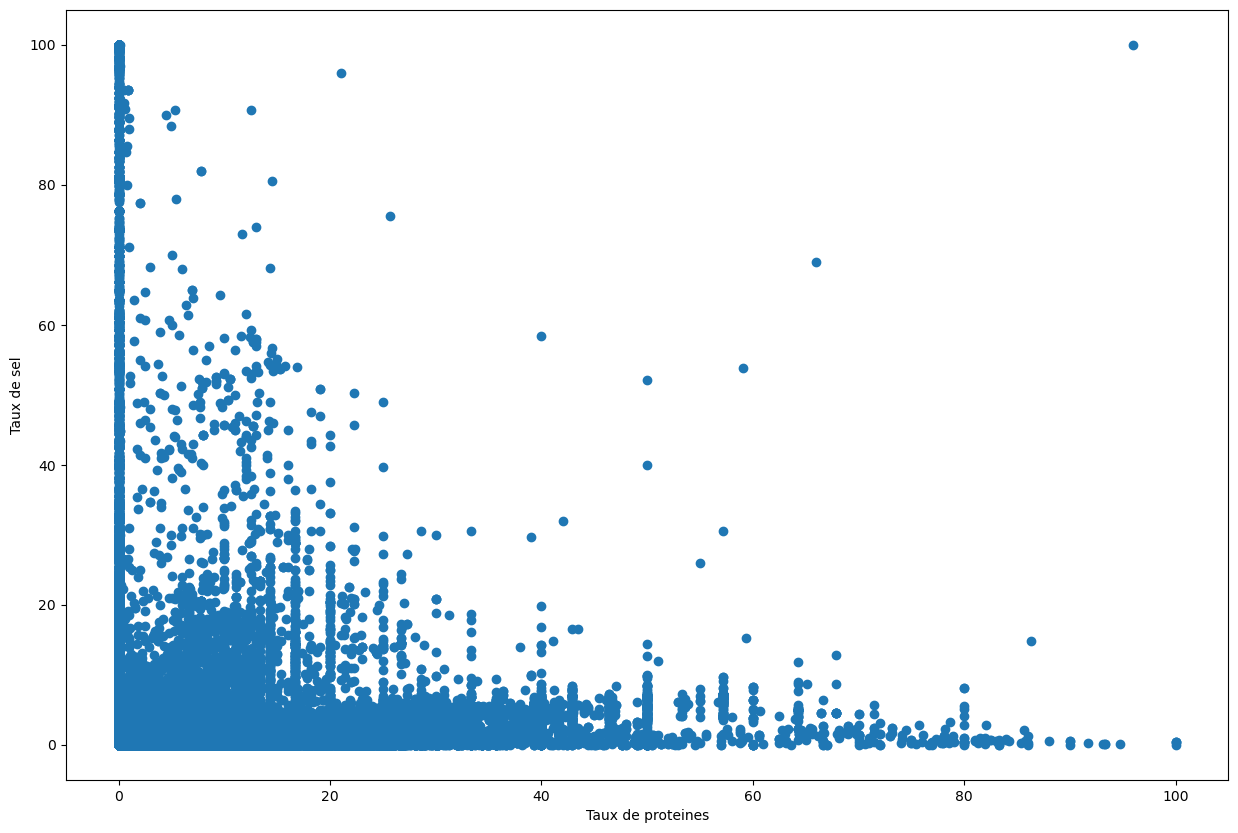

In [16]:
# Non, ils sont variés. Nous avions cherché en vain une (anti) corrélation entre les produits sucrés et salés, existerait-elle
# entre les produits protéïnés et salés ?
#import matplotlib.pyplot as plt
prot_sel = data.loc[~(data['proteins_100g'].isna()) & ~(data['salt_100g'].isna()), ['proteins_100g','salt_100g']]
plt.figure(figsize=(15,10))
plt.scatter(prot_sel['proteins_100g'],prot_sel['salt_100g'])
plt.xlabel("Taux de proteines")
plt.ylabel("Taux de sel")
plt.show()


Il n'a pas de relation claire.
<br>Les informations concernant l'ap. énergetique, les protéïnes et le sucre étant plus nombreuses que celles concernant les graisses saturées, on va utiliser la relation expérimentale approximative trouvée pour renseigner les apports énergétiques à 'NaN': energy_100g ~ (17 x sugars_100g + 17 x proteins_100g + 41 x saturated-fat_100g) + 100 (si le terme précedent est > 0). Soit saturated-fat_100g ~ (1/41)(energy_100g - 17 x sugars_100g - 17 x proteins_100g - 100).

In [19]:
ind_list = data.loc[(data['nutrition-score-fr_100g'].isna()) & ~(data['energy_100g'].isna()) & (data['saturated-fat_100g'].isna()) & ~(data['sugars_100g'].isna()) & ~(data['proteins_100g'].isna()), 'product_name'].index
for ind in ind_list :
    val = data.iloc[ind,57] - 17*data.iloc[ind,73] - 17*data.iloc[ind,81]
    if data.iloc[ind,57] > 0 :
        data.iloc[ind,60] = (val - 100) / 41


<Axes: >

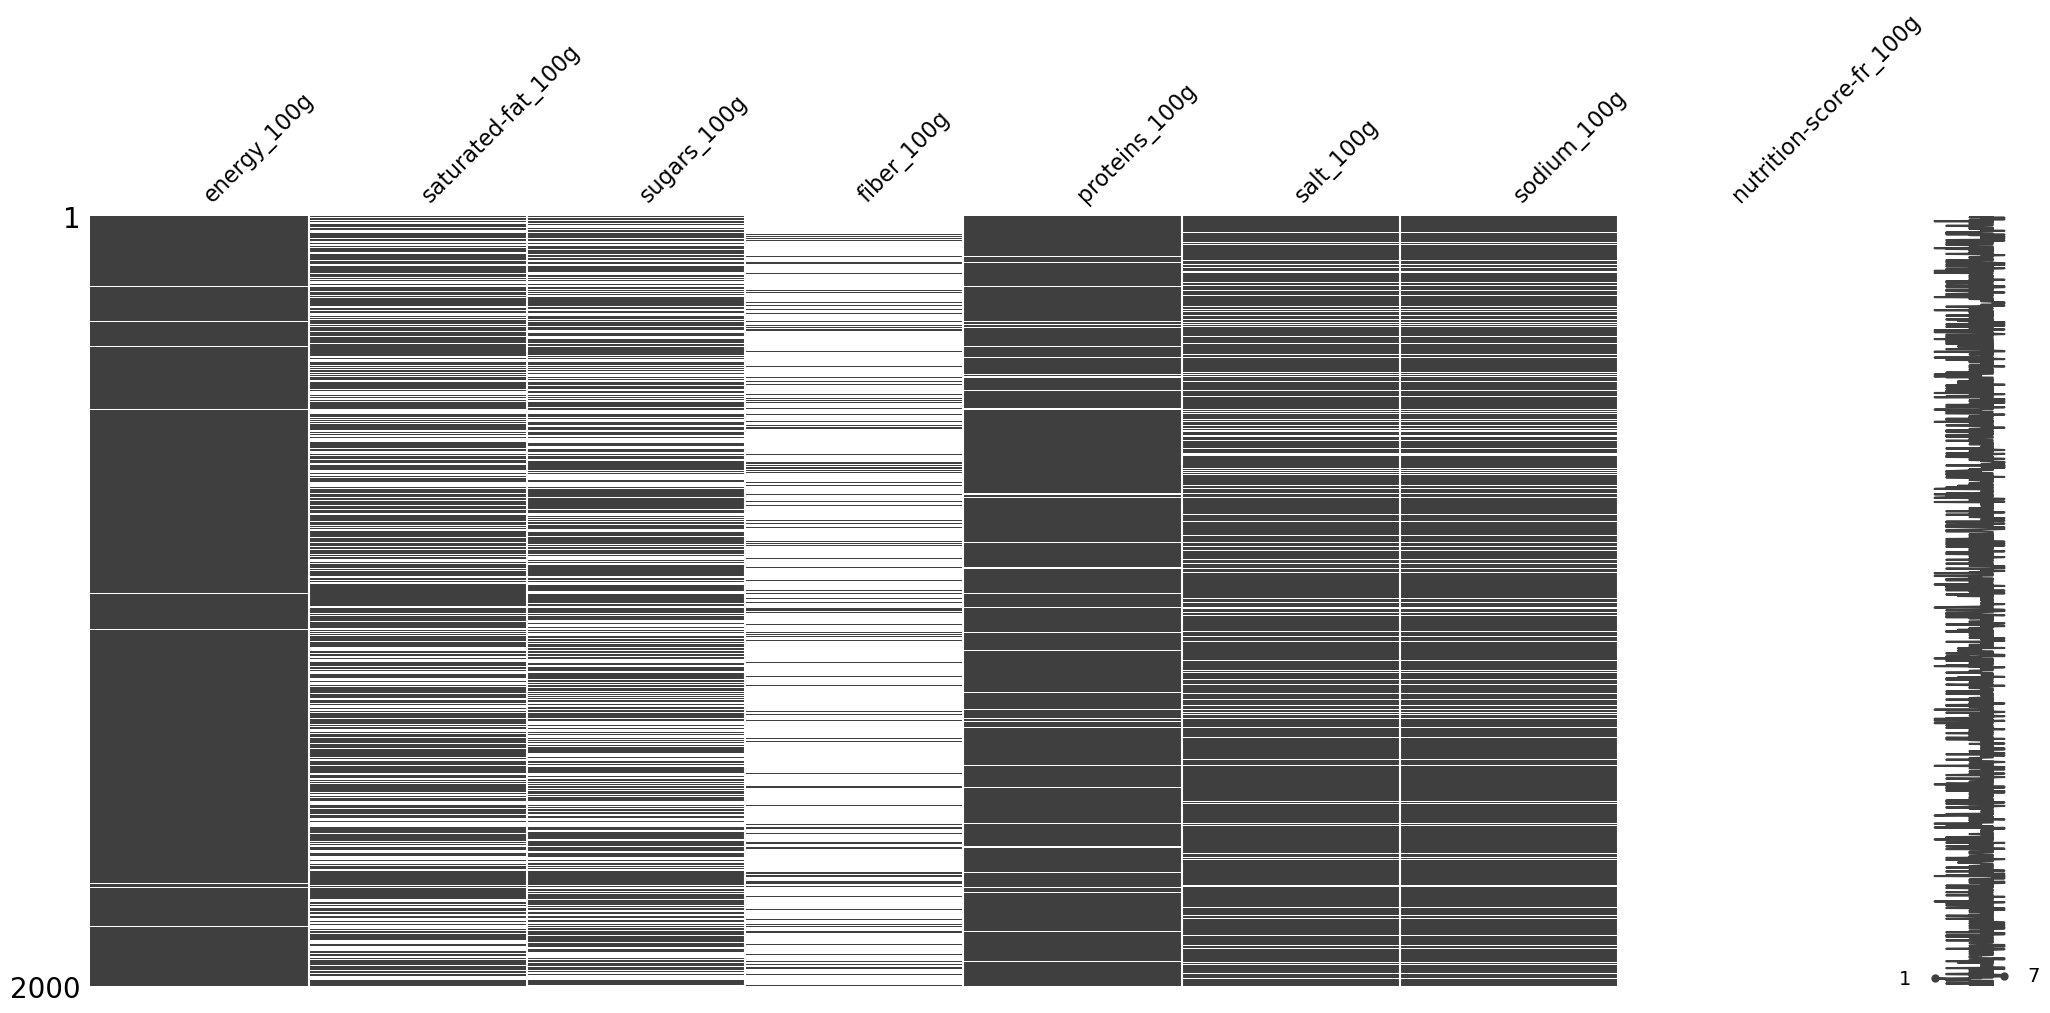

In [20]:
# un apperçu du changement :
import missingno as msn
msn.matrix(data.loc[data['nutrition-score-fr_100g'].isna(),['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g','nutrition-score-fr_100g']].sample(2000))

In [21]:
# nous appliquons la même méthode en faveur du sucre :
ind_list = data.loc[(data['nutrition-score-fr_100g'].isna()) & ~(data['energy_100g'].isna()) & ~(data['saturated-fat_100g'].isna()) & (data['sugars_100g'].isna()) & ~(data['proteins_100g'].isna()), 'product_name'].index
for ind in ind_list :
    val = data.iloc[ind,57] - 41*data.iloc[ind,60] - 17*data.iloc[ind,81]
    if data.iloc[ind,57] > 0 :
        data.iloc[ind,73] = (val - 100) / 17


<Axes: >

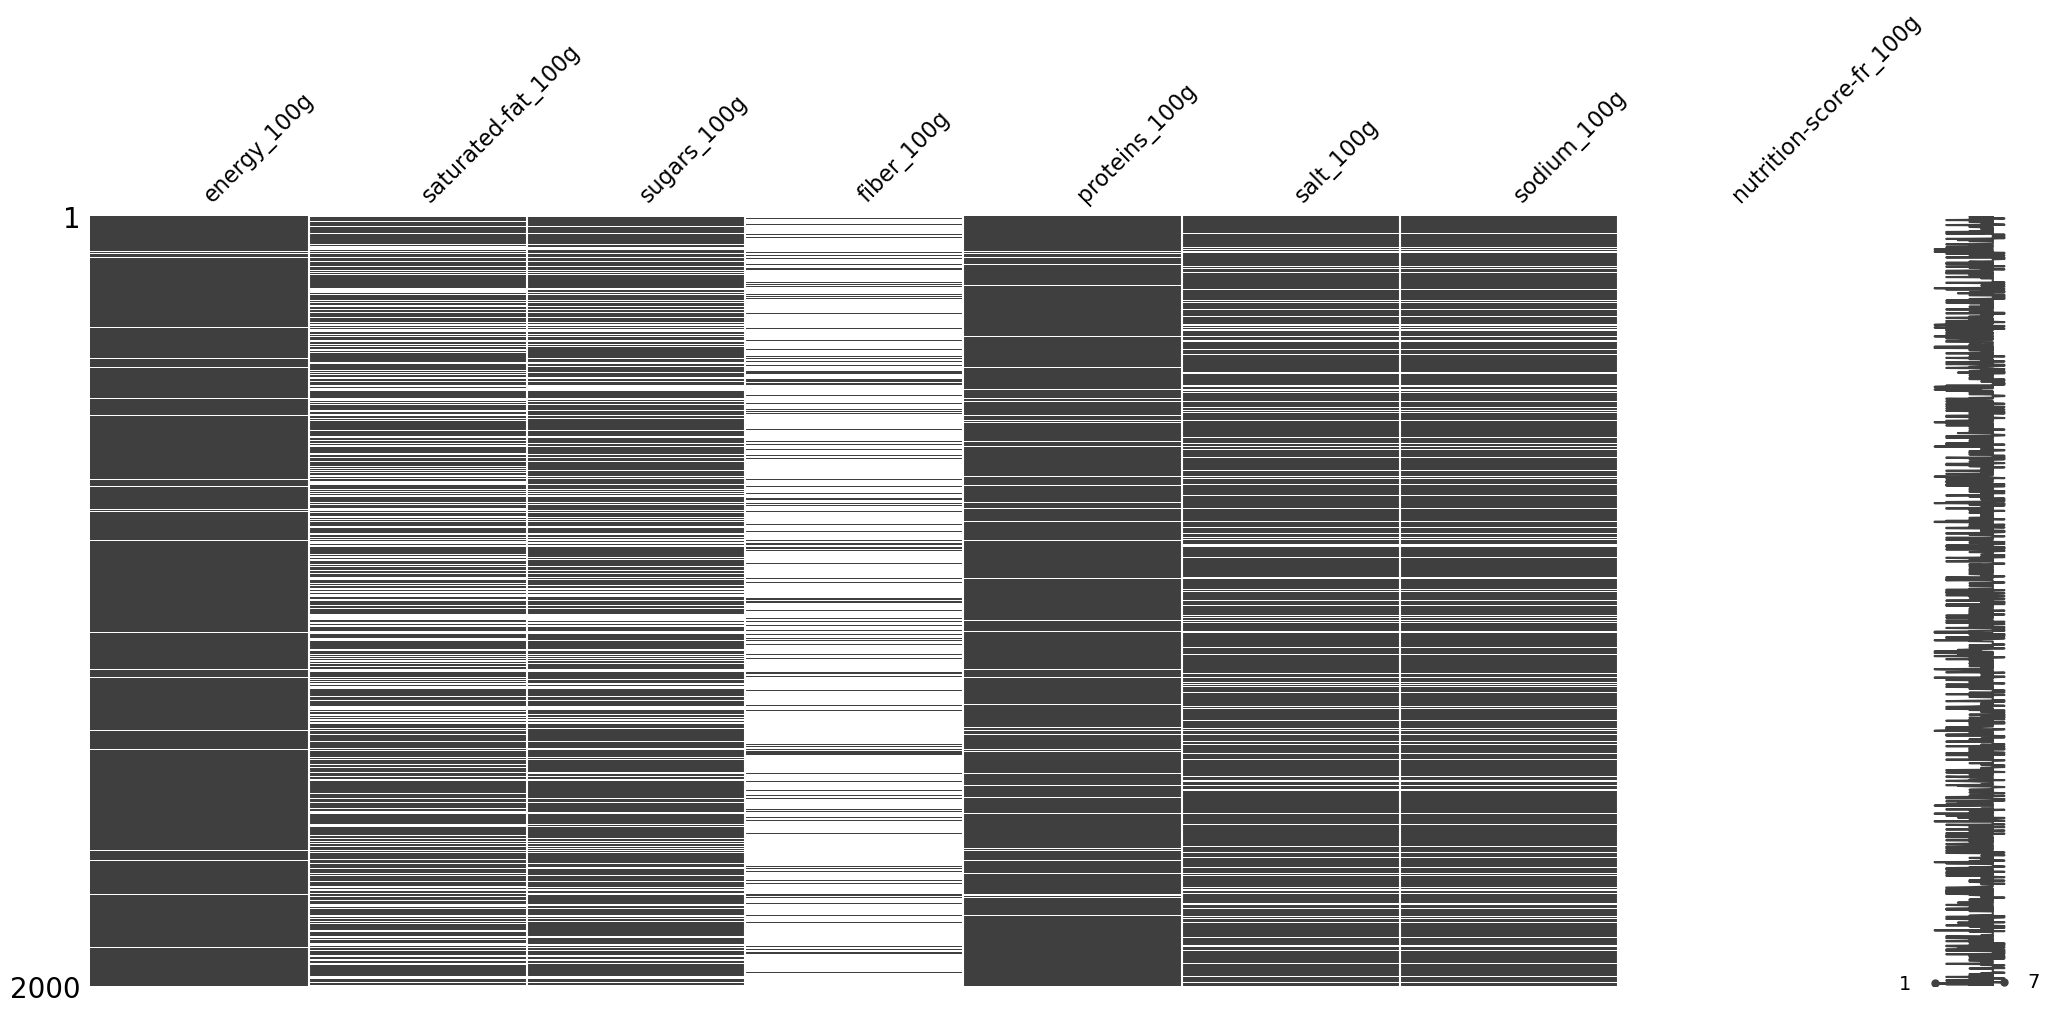

In [22]:
msn.matrix(data.loc[data['nutrition-score-fr_100g'].isna(),['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g','nutrition-score-fr_100g']].sample(2000))

In [24]:
# pour terminer les imputations, nous allons de nouveau faire appel à l'iterative imputer
DF = data[['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

In [25]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer(tol=0.5, skip_complete=True ,verbose=2, random_state=3, add_indicator=True )
DF_imp = imputer.fit_transform(DF)

[IterativeImputer] Completing matrix with shape (247208, 7)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.39
[IterativeImputer] Change: 2217.6322793720938, scaled tolerance: 2379.155 
[IterativeImputer] Early stopping criterion reached.


<Axes: >

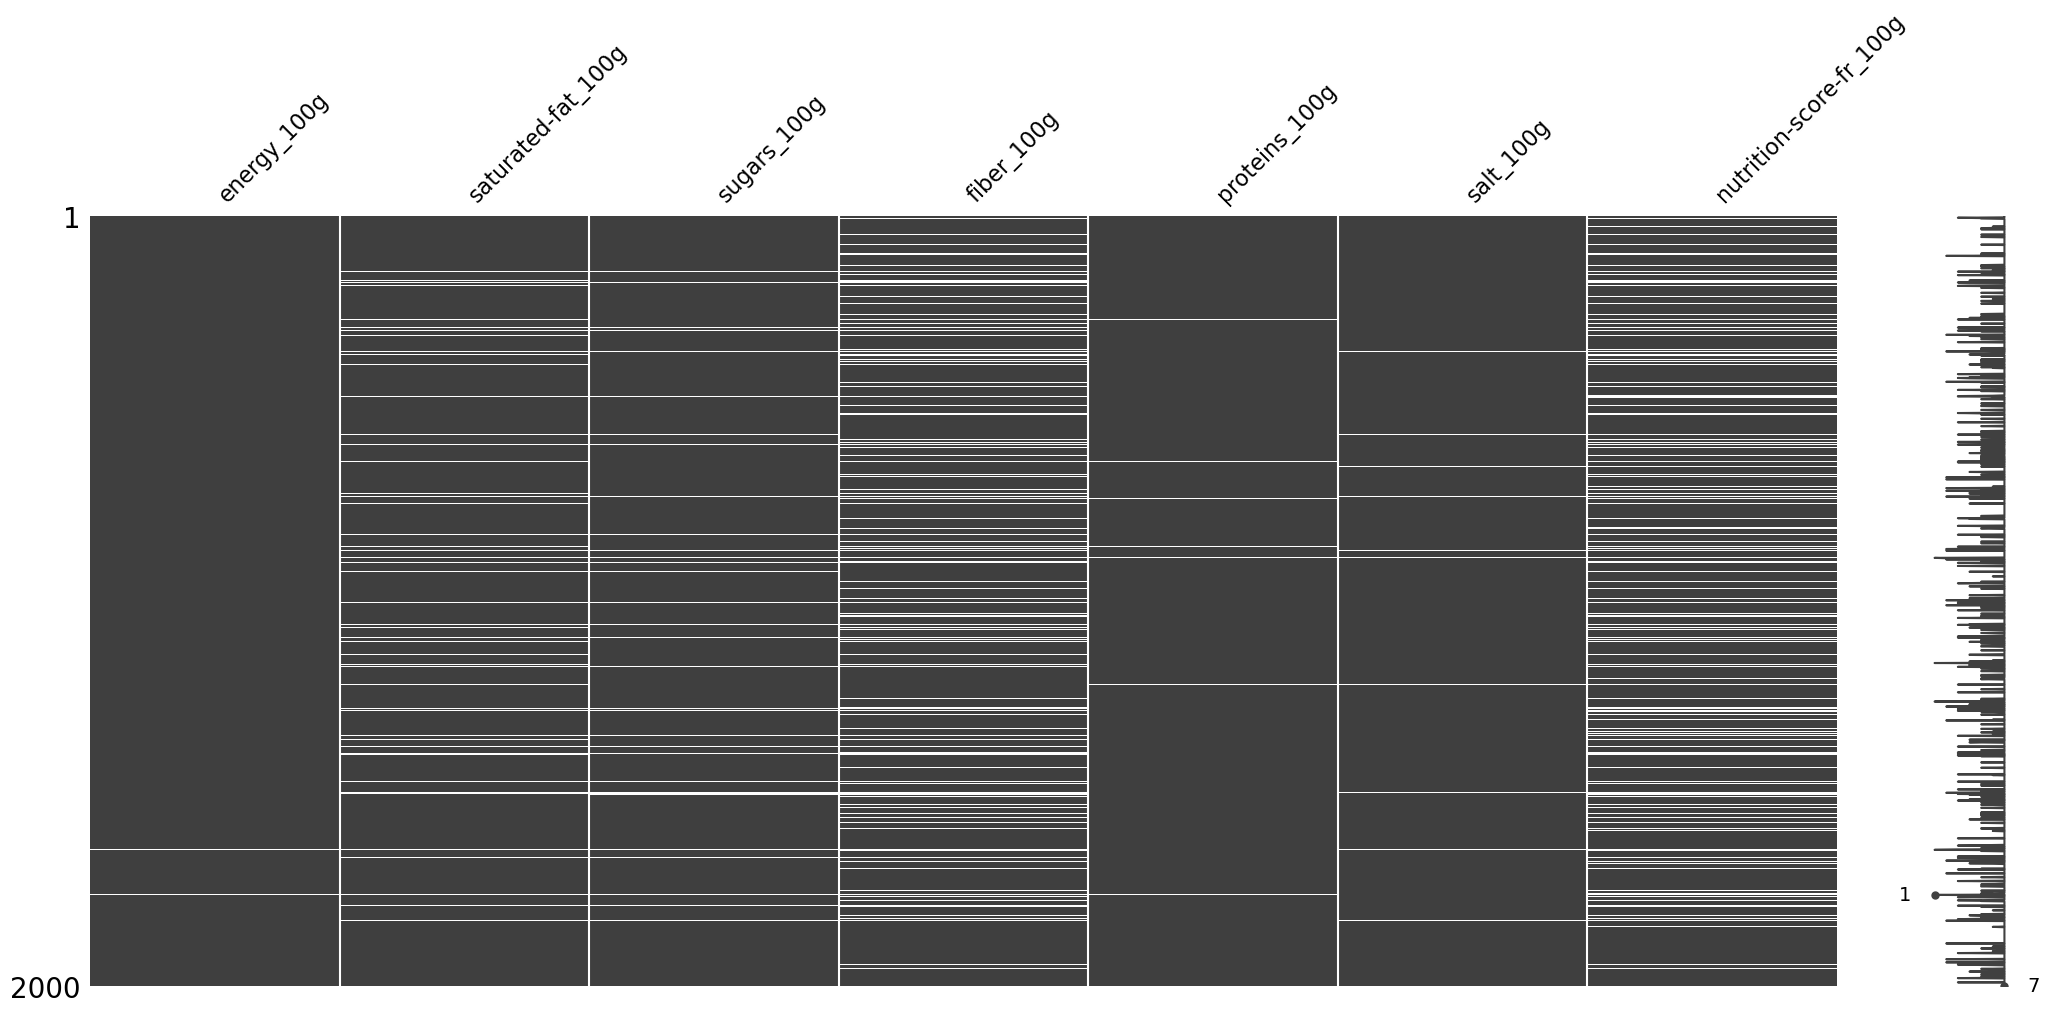

In [26]:
msn.matrix(DF.sample(2000))

In [27]:
data.to_csv('fr.openfoodfacts.org.products.csv', sep='	')

In [31]:
DF_imp = pd.DataFrame(DF_imp)

<Axes: >

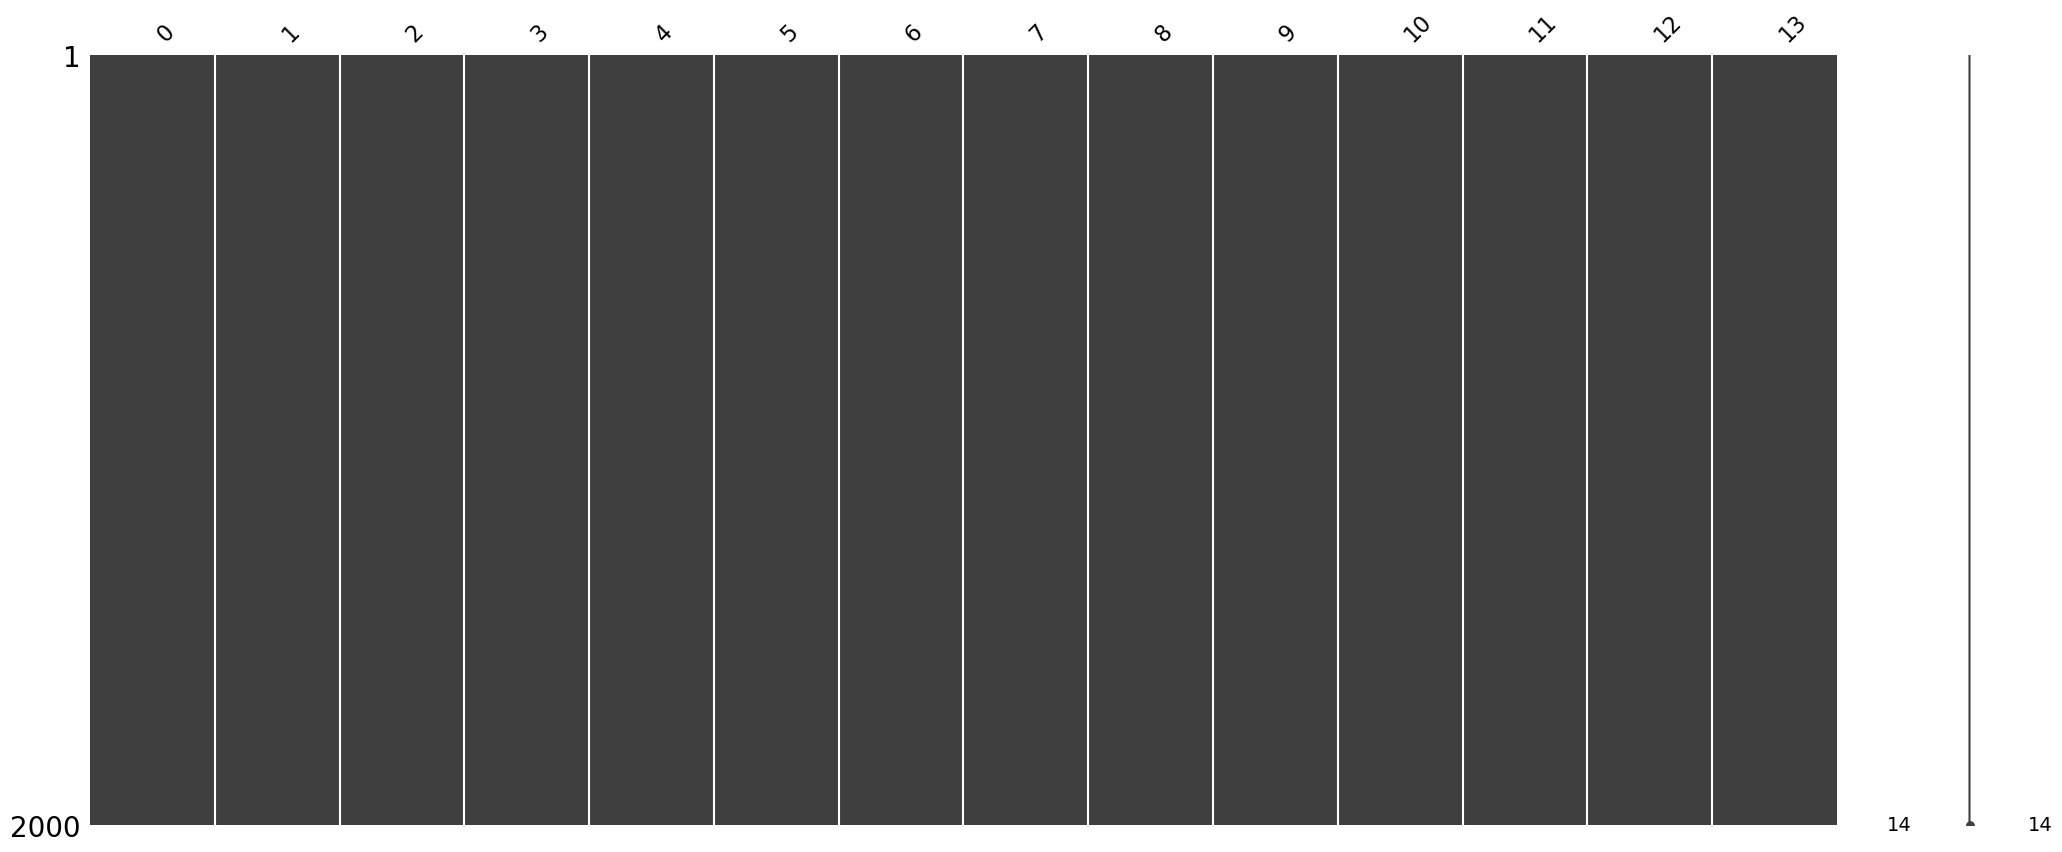

In [32]:
msn.matrix(DF_imp.sample(2000))

In [36]:
DF_imp.head()

0          1          2    3      4         5          6    7    8   \
0  2243.0  28.570000  14.290000  3.6   3.57  0.000000  14.000000  0.0  0.0   
1  1941.0   0.000000  17.860000  7.1  17.86  0.635000   0.000000  0.0  0.0   
2  2540.0   5.360000   3.570000  7.1  17.86  1.224280  12.000000  0.0  0.0   
3  1552.0   6.035761  22.102789  5.7   8.57  1.251317  10.764715  0.0  1.0   
4  1933.0   1.920000  11.540000  7.7  13.46  0.937650   8.141163  0.0  0.0   

    9    10   11   12   13  
0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  
3  1.0  0.0  0.0  1.0  1.0  
4  0.0  0.0  0.0  1.0  1.0

Aux sept colonnes originales se sont ajoutées les sept colonnes d'indicateurs (1.0 quand la valeur a été modifiée)

In [35]:
DF_imp.to_csv('df_for_finalfill.csv', sep='|')

In [38]:
len(DF_imp)

247208

In [2]:
import pandas as pd
DF_imp = pd.read_csv('df_for_finalfill.csv', sep='|')

In [3]:
DF_imp = DF_imp.drop('Unnamed: 0', axis=1)

Vérifions la pertinence des imputations avant de les reporter dans notre 'base' :

In [5]:
data['energy_100g'].describe()

count    246339.000000
mean       1119.767086
std         794.052979
min           0.000000
25%         372.000000
50%        1097.000000
75%        1674.000000
max        4758.310000
Name: energy_100g, dtype: float64

In [9]:
DF_imp.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13'],
      dtype='object')

In [10]:
DF_imp['0'].describe()

count    247208.000000
mean       1119.892481
std         792.960047
min          -0.335206
25%         376.000000
50%        1100.000000
75%        1674.000000
max        4758.310000
Name: 0, dtype: float64

Nous sommes tout proche des valeurs attendues, mais le min. est négatif ! Je ne pouvais pas cette fois définir des min et max pour l'imputer parce qu'il avait à traiter des données différentes dont une (le nutriscore) peut effectivement être < 0. Je me contente de mettre à zéro les valeurs (faiblement) négatives :

In [12]:
DF_imp.loc[DF_imp['0'] < 0, '0'] = 0

In [13]:
DF_imp['0'].describe()

count    247208.000000
mean       1119.892482
std         792.960045
min           0.000000
25%         376.000000
50%        1100.000000
75%        1674.000000
max        4758.310000
Name: 0, dtype: float64

On peut dire que ça n'a pas changé la moyenne (ni les quartiles) par contre les valeurs abérantes ont été corrigées.
<br>Voyons ce qu'il en est pour les graisses saturées :

In [14]:
data['saturated-fat_100g'].describe()

count    234087.000000
mean          4.849277
std           8.008748
min         -30.056098
25%           0.000000
50%           1.670000
75%           7.140000
max         100.000000
Name: saturated-fat_100g, dtype: float64

Visiblement les imputations selon ma formule empirique ont eu un effet délétère sur le min; Par contre les quartiles et les autres valeurs statistiques ne sont pas trop impactées. Quelle est l'ampleur du problème ?

In [15]:
DF_imp.loc[DF_imp['1'] < 0, '0'].count()

12876

Le problème étant important, je repars sur une sauvegarde après la fin des traitements pour les produits ayant un nutriscore, et nous allons directement faire appel à l' "imputer" (sauf pour les 303 produits particuliers). Précisons que nous avions quand même repéré plusieurs corrélations entre les différentes données (outre le fait que la somme des composants ne peut dépasser 100g), c'est pourquoi il est pertinent d'utiliser l'IterativeImputer.

In [3]:
# Suite à la reprise d'une sauvegarde, le produit aux valeurs érronées n'est plus corrigé :
data.loc[245965][57:87]

energy_100g                   0.0
energy-from-fat_100g          NaN
fat_100g                      0.0
saturated-fat_100g            0.0
monounsaturated-fat_100g      NaN
polyunsaturated-fat_100g      NaN
omega-3-fat_100g              NaN
alpha-linolenic-acid_100g     NaN
eicosapentaenoic-acid_100g    NaN
docosahexaenoic-acid_100g     NaN
omega-6-fat_100g              NaN
linoleic-acid_100g            NaN
omega-9-fat_100g              NaN
trans-fat_100g                NaN
cholesterol_100g              NaN
carbohydrates_100g            0.0
sugars_100g                   0.0
sucrose_100g                  NaN
glucose_100g                  NaN
fructose_100g                 NaN
lactose_100g                  NaN
starch_100g                   NaN
polyols_100g                  NaN
fiber_100g                    0.0
proteins_100g                 0.0
casein_100g                   NaN
salt_100g                     0.0
sodium_100g                   NaN
alcohol_100g                  NaN
vitamin-a_100g

In [ ]:
# donc on refait la correction
import numpy as np
data.iloc[245965,57] = np.NaN  # energy
data.iloc[245965,59] = np.NaN  # fat_100g 
data.iloc[245965,60] = np.NaN  # saturated-fat_100g 
data.iloc[245965,72] = np.NaN  # carbohydrates_100g
data.iloc[245965,73] = np.NaN  # sugars_100g
data.iloc[245965,80] = np.NaN  # fibers_100g
data.iloc[245965,81] = np.NaN  # proteins_100g
data.iloc[245965,83] = np.NaN  # salt_100g

In [ ]:
data.loc[(data['nutrition-score-fr_100g'].isna()) & ~(data['energy_100g'].isna()) & ~(data['saturated-fat_100g'].isna()) & ~(data['sugars_100g'].isna()) & ~(data['fiber_100g'].isna()) & ~(data['proteins_100g'].isna()) & ~(data['salt_100g'].isna()), 'nutrition-score-fr_100g'] = 3.333

In [ ]:
DF = data[['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer(tol=0.5, skip_complete=True ,verbose=2, random_state=3, add_indicator=True )
DF_imp = imputer.fit_transform(DF)

In [ ]:
DF_imp = pd.DataFrame(DF_imp)

In [ ]:
DF_imp.head()

In [ ]:
DF_imp.columns

In [ ]:
DF_imp.to_csv('df_for_finalfill.csv', sep='|')

In [3]:
import pandas as pd
DF_imp = pd.read_csv('df_for_finalfill.csv', sep='|')

In [4]:
DF_imp = DF_imp.drop('Unnamed: 0', axis=1)

In [3]:
DF_imp.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13'],
      dtype='object')

In [4]:
DF_imp['0'].describe()

count    247208.000000
mean       1119.863724
std         792.918434
min         -57.650749
25%         376.000000
50%        1100.000000
75%        1674.000000
max        4758.310000
Name: 0, dtype: float64

Dans cette deuxième execution de l'impupter sur toutes les données manquantes pour le calcul du nutriscore, on peut constater que les indicateurs statistiques ont été parfaitement respectés (pour l'energie), mais PAS LE MIN !! Quelle est l'ampleur du problème ?

In [5]:
DF_imp.loc[DF_imp['0'] < 0, '0'].count()

1

In [6]:
# problème léger, ouf, tâchons de le résoudre :
DF_imp.loc[DF_imp['0'] < 0, :]

0         1          2         3    4         5          6  \
108969 -57.650749 -9.067769 -40.298156  3.772548  0.0  93.25356  20.433963   

          7    8    9   10   11   12   13  
108969  1.0  1.0  1.0  1.0  0.0  0.0  1.0

In [9]:
data.loc[108969][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Palm Island, Premium White Silver Sea Salt
energy_100g                                                       NaN
saturated-fat_100g                                                NaN
sugars_100g                                                       NaN
fiber_100g                                                        NaN
proteins_100g                                                     0.0
salt_100g                                                    93.25356
nutrition-score-fr_100g                                           NaN
Name: 108969, dtype: object

In [10]:
# nous allons régler ce problème après mise à jour de 'data'. Voyons pour les 'sat. fat' :
DF_imp['1'].describe()

count    247208.000000
mean          4.716895
std           7.495793
min         -22.193808
25%           0.000000
50%           2.000000
75%           6.600000
max         100.000000
Name: 1, dtype: float64

In [11]:
DF_imp.loc[DF_imp['1'] < 0, '0'].count()

5057

In [13]:
# c'est mieux qu'avant mais pas trés bon !
DF_imp.loc[DF_imp['1'] < 0, '1'].mean()

-2.7729960585082933

In [15]:
DF_imp.loc[DF_imp['1'] < 0, '1'].median()

-1.8013481258234307

In [16]:
# étant données ces valeurs, si on les passe tous à 0 on devrait rester proche du 'describe' de data :
data['saturated-fat_100g'].describe()

count    216202.000000
mean          5.082690
std           7.869025
min           0.000000
25%           0.000000
50%           1.790000
75%           7.140000
max         100.000000
Name: saturated-fat_100g, dtype: float64

In [17]:
DF_imp.loc[DF_imp['1'] < 0, '1'] = 0.0

In [18]:
DF_imp['1'].describe()

count    247208.000000
mean          4.773621
std           7.438191
min           0.000000
25%           0.000000
50%           2.000000
75%           6.600000
max         100.000000
Name: 1, dtype: float64

In [19]:
# c'est plutôt bien. Voyons pour les sucres :
DF_imp['2'].describe()

count    247208.000000
mean         15.709669
std          20.937107
min         -68.519782
25%           1.410000
50%           6.500000
75%          23.330000
max         105.000000
Name: 2, dtype: float64

In [20]:
data['sugars_100g'].describe()

count    231466.000000
mean         15.969636
std          21.187921
min           0.000000
25%           1.300000
50%           5.750000
75%          23.880000
max         105.000000
Name: sugars_100g, dtype: float64

In [21]:
# encore un gros problème avec le min, mais pour les autres indicateurs ça va.
DF_imp.loc[DF_imp['2'] < 0, '0'].count()

2590

In [22]:
DF_imp.loc[DF_imp['2'] < 0, '2'].mean()

-16.842817056381318

In [23]:
DF_imp.loc[DF_imp['2'] < 0, '2'].median()

-11.595113214509798

In [24]:
DF_imp.loc[DF_imp['2'] < -60, :]

0          1          2          3       4         5         6  \
40055   1795.0  11.531164 -68.519782  10.326242  100.00  0.363220  5.696389   
110873  1498.0  10.341668 -62.711275   8.807708   91.67  0.254000  4.810606   
241251  1564.0  10.592964 -62.173197   9.018135   92.00 -0.320169  5.004212   
241252  1564.0  10.592964 -62.173197   9.018135   92.00 -0.320169  5.004212   

          7    8    9   10   11   12   13  
40055   0.0  1.0  1.0  1.0  0.0  0.0  1.0  
110873  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
241251  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
241252  0.0  1.0  1.0  1.0  0.0  1.0  1.0

In [25]:
DF_imp.loc[(DF_imp['2'] < -50) & (DF_imp['2'] > -60), :]

0          1          2          3      4          5  \
221        0.000000   5.175767 -50.328247   2.196059  66.67   0.337820   
239     1533.000000  10.151317 -56.184153   8.535587  85.50  -0.174971   
240     1533.000000  10.151317 -56.184153   8.535587  85.50  -0.174971   
245     1533.000000  10.151317 -56.184153   8.535587  85.50  -0.174971   
264     1590.000000  10.471869 -58.570319   8.900479  88.50  -0.309692   
427     1533.000000  10.151317 -56.184153   8.535587  85.50  -0.174971   
454     1590.000000  10.471869 -58.570319   8.900479  88.50  -0.309692   
455     2847.234209  14.084666 -50.522053  13.274179  91.70  -2.350840   
20039   1590.000000  10.471869 -58.570319   8.900479  88.50  -0.309692   
36281   1494.000000   9.981331 -57.117643   8.458615  85.71   0.543560   
65703      0.000000   0.000000 -54.417408   4.398860  25.64  75.549760   
170200  1530.000000  10.115662 -55.728906   8.496418  85.00  -0.162826   

                6    7    8    9   10   11   12   13  
221     -0.718050  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
239      5.329243  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
240      5.329243  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
245      5.329243  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
264      5.374207  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
427      5.329243  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
454      5.374207  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
455     10.886337  1.0  1.0  1.0  1.0  0.0  1.0  1.0  
20039    5.374207  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
36281    5.255520  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
65703   15.736185  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
170200   5.351435  0.0  1.0  1.0  1.0  0.0  1.0  1.0

In [26]:
data.loc[40055][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Gelatin
energy_100g                 1795.0
saturated-fat_100g             NaN
sugars_100g                    NaN
fiber_100g                     NaN
proteins_100g                100.0
salt_100g                  0.36322
nutrition-score-fr_100g        NaN
Name: 40055, dtype: object

On pourrait passer à 0 les valeurs à NaN pour ce produit; On dirait que ce sont les produits avec beaucoup de NaN qui ont eu de mauvaises imputations.

In [27]:
data.loc[241251][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name                 Gold
energy_100g                1564.0
saturated-fat_100g            NaN
sugars_100g                   NaN
fiber_100g                    NaN
proteins_100g                92.0
salt_100g                     NaN
nutrition-score-fr_100g       NaN
Name: 241251, dtype: object

In [28]:
data.loc[221][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Apple & Cinnamon Tea
energy_100g                                 0.0
saturated-fat_100g                          NaN
sugars_100g                                 NaN
fiber_100g                                  NaN
proteins_100g                             66.67
salt_100g                               0.33782
nutrition-score-fr_100g                     NaN
Name: 221, dtype: object

In [29]:
# on pourra supprimer le produit ci-dessus.
data.loc[240][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Mehrkomponeneten Protein 90 C6 Schoko
energy_100g                                               1533.0
saturated-fat_100g                                           NaN
sugars_100g                                                  NaN
fiber_100g                                                   NaN
proteins_100g                                               85.5
salt_100g                                                    NaN
nutrition-score-fr_100g                                      NaN
Name: 240, dtype: object

In [30]:
data.loc[170200][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Protéine whey hydrolisée
energy_100g                                  1530.0
saturated-fat_100g                              NaN
sugars_100g                                     NaN
fiber_100g                                      NaN
proteins_100g                                  85.0
salt_100g                                       NaN
nutrition-score-fr_100g                         NaN
Name: 170200, dtype: object

In [31]:
data.loc[65703][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Rich Brown Seasoning And Broth
energy_100g                                           0.0
saturated-fat_100g                                    NaN
sugars_100g                                           NaN
fiber_100g                                            NaN
proteins_100g                                       25.64
salt_100g                                        75.54976
nutrition-score-fr_100g                               NaN
Name: 65703, dtype: object

A part deux produits, nous avons ici des produits hyper-protéinés. Il ne faudrait pas qu'ils soient modifiés sauf pour les NaN qui doivent passer à 0. De même pour le '65703' en fait et l'autre outlier pour le moment. Donc nous allons faire une fonction qui corrige DF_imp de sorte que, quand nous allons mettre à jour data, nous ayons les valeurs 'pertinentes'.

In [5]:
def corrigerDF_imp(dfOri, dfDest, ind) :
    if dfOri.loc[ind]['energy_100g'].astype('int') < -2111111111 : # signifie '== np.NaN'
        energy = 0.0                                           # peut être tester str(dfOri.loc[ind]['energy_100g']) == 'nan'
    else :
        energy = dfOri.loc[ind]['energy_100g']
        
    if dfOri.loc[ind]['saturated-fat_100g'].astype('int') < -2111111111 :
        satfat = 0.0
    else :    
        satfat = dfOri.loc[ind]['saturated-fat_100g']
        
    if dfOri.loc[ind]['sugars_100g'].astype('int') < -2111111111 :
        sugars = 0.0
    else :
        sugars = dfOri.loc[ind]['sugars_100g']
        
    if dfOri.loc[ind]['fiber_100g'].astype('int') < -2111111111 :
        fibers = 0.0
    else :
        fibers = dfOri.loc[ind]['fiber_100g']
        
    if dfOri.loc[ind]['proteins_100g'].astype('int') < -2111111111 :
        proten = 0.0
    else :
        proten = dfOri.loc[ind]['proteins_100g']
        
    if dfOri.loc[ind]['salt_100g'].astype('int') < -2111111111 :
        salttt = 0.0
    else :    
        salttt = dfOri.loc[ind]['salt_100g']
        
    if dfOri.loc[ind]['nutrition-score-fr_100g'].astype('int') < -2111111111 :
        nscore = 0.0
    else :
        nscore = dfOri.loc[ind]['nutrition-score-fr_100g']
    
    dfDest.iloc[ind,0] = energy
    dfDest.iloc[ind,1] = satfat
    dfDest.iloc[ind,2] = sugars
    dfDest.iloc[ind,3] = fibers
    dfDest.iloc[ind,4] = proten
    dfDest.iloc[ind,5] = salttt
    dfDest.iloc[ind,6] = nscore
    


In [33]:
corrigerDF_imp(data, DF_imp, 40055)

In [34]:
# vérif avant de lancer pour les suivants :
DF_imp.loc[40055][:]

0     1795.00000
1        0.00000
2        0.00000
3        0.00000
4      100.00000
5        0.36322
6        0.00000
7        0.00000
8        1.00000
9        1.00000
10       1.00000
11       0.00000
12       0.00000
13       1.00000
Name: 40055, dtype: float64

In [35]:
list_ind = DF_imp.loc[DF_imp['2'] < -50, :].index

In [36]:
list_ind

Int64Index([   221,    239,    240,    245,    264,    427,    454,    455,
             20039,  36281,  65703, 110873, 170200, 241251, 241252],
           dtype='int64')

In [37]:
for ind in list_ind :
    corrigerDF_imp(data, DF_imp, ind)

In [38]:
# voyons si cette solution serait pertinente aussi pour les suivants :
DF_imp.loc[(DF_imp['2'] < -40) & (DF_imp['2'] > -50), :]

0         1          2         3          4          5  \
24        54.617349  0.000000 -42.739399  4.435870   1.680096   96.15678   
68        12.364693  0.000000 -45.057766  4.509307   1.465285   99.90582   
220     1117.000000  8.028391 -41.473951  6.025156  66.670000    0.33782   
430        0.000000  0.000000 -43.786216  4.385883   0.000000  100.00000   
5627       0.000000  0.000000 -43.731143  4.380080   0.000000   99.90582   
...             ...       ...        ...       ...        ...        ...   
232615     0.000000  0.000000 -43.731143  4.380080   0.000000   99.90582   
233697     0.000000  0.000000 -42.686219  0.000000   0.000000   96.52000   
235285     0.000000  0.000000 -42.021574  4.199935   0.000000   96.98228   
239728    12.430286  0.000000 -45.054167  4.509193   1.465618   99.90000   
239967     0.000000  0.000000 -42.599352  4.260818   0.000000   97.97034   

                6    7    8    9   10   11   12   13  
24      21.388508  1.0  1.0  1.0  1.0  1.0  0.0  1.0  
68      21.877089  1.0  1.0  1.0  1.0  1.0  0.0  1.0  
220      4.704100  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
430     21.935389  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
5627    21.918336  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
...           ...  ...  ...  ...  ...  ...  ...  ...  
232615  21.918336  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
233697  23.653493  0.0  1.0  1.0  0.0  0.0  0.0  1.0  
235285  21.388970  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
239728  21.876331  1.0  1.0  1.0  1.0  1.0  0.0  1.0  
239967  21.567878  0.0  1.0  1.0  1.0  0.0  0.0  1.0  

[284 rows x 14 columns]

In [39]:
data.loc[24][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Real Salt Granular
energy_100g                               NaN
saturated-fat_100g                        NaN
sugars_100g                               NaN
fiber_100g                                NaN
proteins_100g                             NaN
salt_100g                            96.15678
nutrition-score-fr_100g                   NaN
Name: 24, dtype: object

In [40]:
data.loc[220][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Herbal Tea, Hibiscus
energy_100g                              1117.0
saturated-fat_100g                          NaN
sugars_100g                                 NaN
fiber_100g                                  NaN
proteins_100g                             66.67
salt_100g                               0.33782
nutrition-score-fr_100g                     NaN
Name: 220, dtype: object

In [41]:
data.loc[5627][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name                   Salt
energy_100g                     0.0
saturated-fat_100g              NaN
sugars_100g                     NaN
fiber_100g                      NaN
proteins_100g                   0.0
salt_100g                  99.90582
nutrition-score-fr_100g         NaN
Name: 5627, dtype: object

In [42]:
data.loc[235285][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Himalayan Pink Salt
energy_100g                                0.0
saturated-fat_100g                         NaN
sugars_100g                                NaN
fiber_100g                                 NaN
proteins_100g                              0.0
salt_100g                             96.98228
nutrition-score-fr_100g                    NaN
Name: 235285, dtype: object

In [46]:
# nous allons appliquer le même traitement pour cette série :
list_ind = DF_imp.loc[(DF_imp['2'] < -40) & (DF_imp['2'] > -50), :].index

In [48]:
for ind in list_ind :
    corrigerDF_imp(data, DF_imp, ind)

In [49]:
DF_imp.loc[(DF_imp['2'] < -30) & (DF_imp['2'] > -40), :]

0      1          2         3          4          5  \
160     3586.000000  85.71 -33.922446  9.808103   7.918531  -7.048313   
1557       0.000000   0.00 -36.723542  3.641657   0.000000  87.922100   
1561       0.000000   0.00 -37.295379  3.701914   0.000000  88.900000   
1562       0.000000   0.00 -32.344906  3.180260   0.000000  80.434180   
1698       0.000000   0.00 -37.295379  3.701914   0.000000  88.900000   
...             ...    ...        ...       ...        ...        ...   
236358   126.870536   0.00 -38.774927  4.310289   2.047428  89.745820   
237539     0.000000   0.00 -38.780670  3.858426   0.000000  91.440000   
237605  1113.000000  13.20 -31.866985  0.500000  14.500000  56.642000   
237820     0.000000   0.00 -33.236080  3.274167   0.000000  81.958180   
240779  1620.000000  70.00 -34.319376  0.000000   1.813102   0.010000   

                6    7    8    9   10   11   12   13  
160     41.985991  0.0  0.0  1.0  1.0  1.0  1.0  1.0  
1557    19.748444  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
1561    19.925513  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
1562    18.392607  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
1698    19.925513  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
...           ...  ...  ...  ...  ...  ...  ...  ...  
236358  20.553022  1.0  1.0  1.0  1.0  1.0  0.0  1.0  
237539  20.385430  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
237605  27.179565  0.0  0.0  1.0  0.0  0.0  0.0  1.0  
237820  18.668558  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
240779  33.692197  0.0  0.0  1.0  0.0  1.0  0.0  1.0  

[337 rows x 14 columns]

In [50]:
data.loc[160][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Organic Unrefined Extra Virgin Coconut Oil
energy_100g                                                    3586.0
saturated-fat_100g                                              85.71
sugars_100g                                                       NaN
fiber_100g                                                        NaN
proteins_100g                                                     NaN
salt_100g                                                         NaN
nutrition-score-fr_100g                                           NaN
Name: 160, dtype: object

In [51]:
data.loc[1557][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Garlic Salt Seasoning
energy_100g                                  0.0
saturated-fat_100g                           NaN
sugars_100g                                  NaN
fiber_100g                                   NaN
proteins_100g                                0.0
salt_100g                                87.9221
nutrition-score-fr_100g                      NaN
Name: 1557, dtype: object

In [52]:
data.loc[236358][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Co., Hot & Smoky Gourmet Grade Chilpote Salt
energy_100g                                                         NaN
saturated-fat_100g                                                  NaN
sugars_100g                                                         NaN
fiber_100g                                                          NaN
proteins_100g                                                       NaN
salt_100g                                                      89.74582
nutrition-score-fr_100g                                             NaN
Name: 236358, dtype: object

In [53]:
data.loc[240779][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name                  NaN
energy_100g                1620.0
saturated-fat_100g           70.0
sugars_100g                   NaN
fiber_100g                    0.0
proteins_100g                 NaN
salt_100g                    0.01
nutrition-score-fr_100g       NaN
Name: 240779, dtype: object

In [54]:
# même traitement ...
list_ind = DF_imp.loc[(DF_imp['2'] < -30) & (DF_imp['2'] > -40), :].index

In [55]:
for ind in list_ind :
    corrigerDF_imp(data, DF_imp, ind)

In [56]:
# plages suivantes :
DF_imp.loc[(DF_imp['2'] < -25) & (DF_imp['2'] > -30), :]

0          1          2          3      4          5          6  \
1563       0.0   0.000000 -28.878238   2.814962   0.00  74.505820  17.319160   
1708       0.0   0.000000 -28.383636   2.762843   0.00  73.660000  17.166007   
1709       0.0   0.000000 -25.413055   2.449820   0.00  68.580000  16.246172   
14856   2389.0   7.140000 -27.727888  10.106271  57.14   6.713220  11.146639   
17124   1494.0  14.290000 -27.983279   6.251360  42.86   7.620000  11.624285   
...        ...        ...        ...        ...    ...        ...        ...   
228158  1048.5   6.866573 -26.072823   4.838775  49.80   1.120858   5.679270   
233699     0.0   0.000000 -25.853421   0.000000   0.00  67.734180  17.406634   
239940  3766.0  84.620000 -27.925208  10.412548   0.00   0.000000  44.674043   
239981     0.0   0.000000 -25.413055   2.449820   0.00  68.580000  16.246172   
242110   500.0  55.000000 -27.178683  -0.388834   0.50  -0.230134  22.990822   

          7    8    9   10   11   12   13  
1563    0.0  1.0  1.0  1.0  0.0  0.0  1.0  
1708    0.0  1.0  1.0  1.0  0.0  0.0  1.0  
1709    0.0  1.0  1.0  1.0  0.0  0.0  1.0  
14856   0.0  0.0  1.0  1.0  0.0  0.0  1.0  
17124   0.0  0.0  1.0  1.0  0.0  0.0  1.0  
...     ...  ...  ...  ...  ...  ...  ...  
228158  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
233699  0.0  1.0  1.0  0.0  0.0  0.0  1.0  
239940  0.0  0.0  1.0  1.0  0.0  0.0  1.0  
239981  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
242110  0.0  0.0  1.0  1.0  0.0  1.0  1.0  

[141 rows x 14 columns]

In [57]:
data.loc[233699][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Sea Salt
energy_100g                     0.0
saturated-fat_100g              NaN
sugars_100g                     NaN
fiber_100g                      0.0
proteins_100g                   0.0
salt_100g                  67.73418
nutrition-score-fr_100g         NaN
Name: 233699, dtype: object

In [58]:
list_ind = DF_imp.loc[(DF_imp['2'] < -25) & (DF_imp['2'] > -30), :].index

In [59]:
for ind in list_ind :
    corrigerDF_imp(data, DF_imp, ind)

In [60]:
DF_imp.loc[(DF_imp['2'] < -20) & (DF_imp['2'] > -25), :]

0          1          2         3      4          5          6  \
479        0.0   0.000000 -24.918453  2.397701   0.00  67.734180  16.093019   
1565       0.0   0.000000 -20.585860  1.941156   0.00  60.325000  14.751440   
3765       0.0   0.000000 -24.918453  2.397701   0.00  67.734180  16.093019   
4799    1494.0   7.140000 -20.513774  6.201851  42.86   5.986780   8.970896   
5306     523.0   0.000000 -22.009955  4.320929   0.00  69.850000  19.014881   
...        ...        ...        ...       ...    ...        ...        ...   
206177  1257.0   7.392656 -23.455820  5.486457  49.00   0.802014   6.688928   
206207  1489.0   8.136724 -23.328876  6.375796  51.00   0.404532   7.604910   
208347  1132.0   6.941109 -22.635361  4.953460  47.00   1.029802   6.261619   
239542  2110.0  65.000000 -23.134437  4.863716   2.00  -3.396451  31.294550   
243772   400.0  50.000000 -23.681284 -0.659842   0.50   0.223872  21.132388   

          7    8    9   10   11   12   13  
479     0.0  1.0  1.0  1.0  0.0  0.0  1.0  
1565    0.0  1.0  1.0  1.0  0.0  0.0  1.0  
3765    0.0  1.0  1.0  1.0  0.0  0.0  1.0  
4799    0.0  0.0  1.0  1.0  0.0  0.0  1.0  
5306    0.0  1.0  1.0  1.0  0.0  0.0  1.0  
...     ...  ...  ...  ...  ...  ...  ...  
206177  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
206207  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
208347  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
239542  0.0  0.0  1.0  1.0  0.0  1.0  1.0  
243772  0.0  0.0  1.0  1.0  0.0  1.0  1.0  

[145 rows x 14 columns]

In [61]:
data.loc[1565][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Garlic Salt
energy_100g                        0.0
saturated-fat_100g                 NaN
sugars_100g                        NaN
fiber_100g                         NaN
proteins_100g                      0.0
salt_100g                       60.325
nutrition-score-fr_100g            NaN
Name: 1565, dtype: object

In [62]:
data.loc[4799][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Meals Made Simple, Real Bacon Bits, Smoke Flav...
energy_100g                                                           1494.0
saturated-fat_100g                                                      7.14
sugars_100g                                                              NaN
fiber_100g                                                               NaN
proteins_100g                                                          42.86
salt_100g                                                            5.98678
nutrition-score-fr_100g                                                  NaN
Name: 4799, dtype: object

In [63]:
data.loc[206177][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Levure de Bière
energy_100g                         1257.0
saturated-fat_100g                     NaN
sugars_100g                            NaN
fiber_100g                             NaN
proteins_100g                         49.0
salt_100g                              NaN
nutrition-score-fr_100g                NaN
Name: 206177, dtype: object

In [64]:
list_ind = DF_imp.loc[(DF_imp['2'] < -20) & (DF_imp['2'] > -25), :].index

In [65]:
for ind in list_ind :
    corrigerDF_imp(data, DF_imp, ind)

In [66]:
DF_imp.loc[(DF_imp['2'] < -15) & (DF_imp['2'] > -20), :]

0          1          2         3          4          5  \
886        0.000000   0.000000 -15.016020  1.354237   0.000000  50.800000   
889        0.000000   0.000000 -15.016020  1.354237   0.000000  50.800000   
1559       0.000000   0.000000 -17.492000  1.615142   0.000000  55.034180   
2502    1343.000000  14.290000 -15.681583  4.780898  32.140000   2.359660   
2531    1644.000000  14.290000 -16.766563  6.006602  35.710000   2.359660   
...             ...        ...        ...       ...        ...        ...   
230496  1674.000000   0.000000 -17.037985  0.000000  40.000000  16.764000   
240697   560.074768   0.000000 -15.005374  3.557355   4.249822  51.308000   
240714  1050.000000  49.200000 -17.727502  1.535921   0.500000   0.100000   
242318   890.000000   5.950073 -18.996370  3.797396  41.000000   1.502242   
242344   230.000000   3.816285 -19.058450  1.249269  35.000000   2.637595   

                6    7    8    9   10   11   12   13  
886     13.026749  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
889     13.026749  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
1559    13.793431  0.0  1.0  1.0  1.0  0.0  0.0  1.0  
2502    10.838847  0.0  0.0  1.0  1.0  0.0  0.0  1.0  
2531    11.628310  0.0  0.0  1.0  1.0  0.0  0.0  1.0  
...           ...  ...  ...  ...  ...  ...  ...  ...  
230496  14.291064  0.0  0.0  1.0  0.0  0.0  0.0  1.0  
240697  15.543743  1.0  1.0  1.0  1.0  1.0  0.0  1.0  
240714  23.268624  0.0  0.0  1.0  1.0  0.0  0.0  1.0  
242318   5.587110  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
242344   3.003576  0.0  1.0  1.0  1.0  0.0  1.0  1.0  

[182 rows x 14 columns]

In [67]:
DF_imp.loc[(DF_imp['2'] < -10) & (DF_imp['2'] > -15), :]

0          1          2         3      4          5          6  \
176      751.0   5.304251 -12.746513  2.852839  33.90   0.735000   5.264138   
885        0.0   0.000000 -10.065547  0.832583   0.00  42.334180  11.493844   
888        0.0   0.000000 -12.540041  1.093332   0.00  46.565820  12.260066   
1489    2092.0  16.670000 -13.669865  7.429734  33.33   3.385820  14.511407   
1560       0.0   0.000000 -13.159407  1.158597   0.00  47.625000  12.451852   
...        ...        ...        ...       ...    ...        ...        ...   
238197  1258.0   6.736501 -11.883535  4.789524  37.00   0.977722   7.554927   
239119   854.0   0.000000 -13.945869  3.634022  40.74   0.728980   3.296283   
240191   660.0   4.827120 -12.360271  2.506231  32.00   1.999974   5.182764   
240766  2180.0  21.000000 -12.094433  7.422699  28.00   4.000000  16.853214   
243856  1640.0  19.000000 -12.118547  5.394729  27.00   1.500000  13.720916   

          7    8    9   10   11   12   13  
176     0.0  1.0  1.0  1.0  0.0  0.0  1.0  
885     0.0  1.0  1.0  1.0  0.0  0.0  1.0  
888     0.0  1.0  1.0  1.0  0.0  0.0  1.0  
1489    0.0  0.0  1.0  1.0  0.0  0.0  1.0  
1560    0.0  1.0  1.0  1.0  0.0  0.0  1.0  
...     ...  ...  ...  ...  ...  ...  ...  
238197  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
239119  0.0  0.0  1.0  1.0  0.0  0.0  1.0  
240191  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
240766  0.0  0.0  1.0  1.0  0.0  0.0  1.0  
243856  0.0  0.0  1.0  1.0  0.0  0.0  1.0  

[285 rows x 14 columns]

In [68]:
DF_imp.loc[(DF_imp['2'] < -5) & (DF_imp['2'] > -10), :]

0          1         2         3      4          5          6  \
1769    1674.0  20.000000 -6.265429  5.127967  20.00   2.032000  14.937744   
2567    1711.0  18.180000 -6.724587  5.399514  22.73   1.615440  14.146789   
2568    1711.0  18.180000 -6.724587  5.399514  22.73   1.615440  14.146789   
2721       0.0   0.000000 -5.467087  0.348023   0.00  34.470340  10.069939   
8341    1644.0  17.860000 -6.751015  0.000000  21.43   1.813560  16.800006   
...        ...        ...       ...       ...    ...        ...        ...   
242790   710.0   4.634369 -6.135844  2.322614  26.00   2.009325   5.841832   
242791   710.0   4.634369 -6.135844  2.322614  26.00   2.009325   5.841832   
243125   860.0   5.154262 -6.734947  2.938869  28.00   1.741888   6.383317   
243142  1070.0   5.838185 -6.802796  3.754941  30.00   1.379297   7.198825   
243147   590.0   4.267871 -6.523819  1.882129  25.30   2.209977   5.344037   

          7    8    9   10   11   12   13  
1769    0.0  0.0  1.0  1.0  0.0  0.0  1.0  
2567    0.0  0.0  1.0  1.0  0.0  0.0  1.0  
2568    0.0  0.0  1.0  1.0  0.0  0.0  1.0  
2721    0.0  1.0  1.0  1.0  0.0  0.0  1.0  
8341    0.0  0.0  1.0  0.0  0.0  0.0  1.0  
...     ...  ...  ...  ...  ...  ...  ...  
242790  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
242791  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
243125  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
243142  0.0  1.0  1.0  1.0  0.0  1.0  1.0  
243147  0.0  1.0  1.0  1.0  0.0  1.0  1.0  

[417 rows x 14 columns]

In [69]:
data.loc[2567][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Mild Cheddar Sliced Cheese
energy_100g                                    1711.0
saturated-fat_100g                              18.18
sugars_100g                                       NaN
fiber_100g                                        NaN
proteins_100g                                   22.73
salt_100g                                     1.61544
nutrition-score-fr_100g                           NaN
Name: 2567, dtype: object

In [70]:
DF_imp.loc[(DF_imp['2'] < 0) & (DF_imp['2'] > -5), :]

0          1         2         3      4          5          6  \
96       234.0   1.316570 -2.178175  0.519276  11.11  13.545820   6.649201   
97       234.0   1.348575 -2.013308  0.501903  11.11  13.263880   6.598150   
384     1180.0  18.210000 -1.014357  2.990613  12.86   1.016000  12.956076   
1564       0.0   0.000000 -2.285595  0.012774   0.00  29.029660   9.084795   
2743       0.0   0.000000 -1.223612 -0.099132   0.00  27.213560   8.755954   
...        ...        ...       ...       ...    ...        ...        ...   
243986  3050.0  49.200000 -1.873794  8.297619   0.50   0.100000  30.713232   
243987  3050.0  49.200000 -1.873794  8.297619   0.50   0.100000  30.713232   
243988  2977.0  48.000000 -2.470162  8.181032   0.50   2.000000  30.499230   
243994  3050.0  49.200000 -1.873794  8.297619   0.50   0.100000  30.713232   
245410   990.0  13.000000 -2.647052  0.000000  17.00   0.867863  11.556961   

          7    8    9   10   11   12   13  
96      0.0  1.0  1.0  1.0  0.0  0.0  1.0  
97      0.0  1.0  1.0  1.0  0.0  0.0  1.0  
384     0.0  0.0  1.0  1.0  0.0  0.0  1.0  
1564    0.0  1.0  1.0  1.0  0.0  0.0  1.0  
2743    0.0  1.0  1.0  1.0  0.0  0.0  1.0  
...     ...  ...  ...  ...  ...  ...  ...  
243986  0.0  0.0  1.0  1.0  0.0  0.0  1.0  
243987  0.0  0.0  1.0  1.0  0.0  0.0  1.0  
243988  0.0  0.0  1.0  1.0  0.0  0.0  1.0  
243994  0.0  0.0  1.0  1.0  0.0  0.0  1.0  
245410  0.0  0.0  1.0  0.0  0.0  1.0  1.0  

[783 rows x 14 columns]

On va appliquer la même correction, mais idéalement il faudra par la suite recalculer les nutriscores de tous les produits pour lequel il vaut zero.

In [71]:
list_ind = DF_imp.loc[(DF_imp['2'] < 0) & (DF_imp['2'] > -20), :].index

In [72]:
for ind in list_ind :
    corrigerDF_imp(data, DF_imp, ind)

In [73]:
# Examinons maintenant la pertinence des imputations pour les fibres :
DF_imp['3'].describe()

count    247208.000000
mean          2.542587
std           4.246277
min          -2.163055
25%           0.000000
50%           1.400000
75%           3.600000
max         100.000000
Name: 3, dtype: float64

In [74]:
data['fiber_100g'].describe()

count    214724.000000
mean          2.731774
std           4.340146
min           0.000000
25%           0.000000
50%           1.500000
75%           3.600000
max         100.000000
Name: fiber_100g, dtype: float64

In [75]:
DF_imp.loc[DF_imp['3'] < 0, '0'].count()

14409

In [76]:
# c'est beaucoup ! Mais la colonne était moins renseignée que les précedentes...
DF_imp.loc[DF_imp['3'] < 0, '3'].mean()

-1.4550389280475786

In [77]:
DF_imp.loc[DF_imp['3'] < 0, '3'].median()

-1.508564959397912

In [78]:
# on n'est pas très loin de zero, et un peu bas au niveau des premiers indicateurs du 'describe'...
DF_imp.loc[DF_imp['3'] < 0, '3'] = 0.0

In [79]:
DF_imp['3'].describe()

count    247208.000000
mean          2.627397
std           4.177529
min           0.000000
25%           0.000000
50%           1.400000
75%           3.600000
max         100.000000
Name: 3, dtype: float64

In [80]:
# On est pas mal. J'ai oublié de vérifier pour le sucre :
DF_imp['2'].describe()

count    247208.000000
mean         15.886131
std          20.676590
min           0.000000
25%           1.410000
50%           6.500000
75%          23.330000
max         105.000000
Name: 2, dtype: float64

In [81]:
# c'est pas mal non plus. Maintenant pour les proteines :
DF_imp['4'].describe()

count    247208.000000
mean          7.095142
std           8.158288
min         -10.784881
25%           0.610000
50%           4.760000
75%          10.000000
max         100.000000
Name: 4, dtype: float64

In [82]:
DF_imp.loc[DF_imp['4'] < 0, '4'].count()

92

In [83]:
DF_imp.loc[DF_imp['4'] < 0, '4'].mean()

-3.0781780424710568

In [84]:
DF_imp.loc[DF_imp['4'] < 0, '4'].median()

-2.8362323148089246

In [85]:
data['proteins_100g'].describe()

count    245185.000000
mean          7.100890
std           8.183407
min           0.000000
25%           0.600000
50%           4.710000
75%          10.000000
max         100.000000
Name: proteins_100g, dtype: float64

In [86]:
# de nouveau remplacement des valeurs négatives par 0 :
DF_imp.loc[DF_imp['4'] < 0, '4'] = 0.0

In [87]:
DF_imp['4'].describe()

count    247208.000000
mean          7.096288
std           8.157006
min           0.000000
25%           0.610000
50%           4.760000
75%          10.000000
max         100.000000
Name: 4, dtype: float64

In [88]:
# OK pour les protéïnes, maintenant le sel :
data['salt_100g'].describe()

count    241816.000000
mean          1.638432
std           6.571481
min           0.000000
25%           0.063500
50%           0.591820
75%           1.384300
max         100.000000
Name: salt_100g, dtype: float64

In [89]:
DF_imp['5'].describe()

count    247208.000000
mean          1.637725
std           6.503845
min          -6.822857
25%           0.063500
50%           0.604520
75%           1.412240
max         100.000000
Name: 5, dtype: float64

In [90]:
DF_imp.loc[DF_imp['5'] < 0, '5'].count()

813

In [92]:
DF_imp.loc[DF_imp['5'] < -5, :]

0     1    2          3    4         5          6    7    8    9  \
148801  3630.0  83.3  0.0   0.000000  0.0 -6.656960  51.449926  0.0  0.0  0.0   
156882  3485.0  90.0  0.0   0.000000  0.0 -6.822857  53.783377  0.0  0.0  0.0   
161959  3740.0  78.6  0.0  10.521132  0.0 -6.191123  43.838497  0.0  0.0  0.0   

         10   11   12   13  
148801  0.0  0.0  1.0  1.0  
156882  0.0  0.0  1.0  1.0  
161959  1.0  0.0  1.0  1.0

In [93]:
data.loc[148801][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Huile de Noix de Coco
energy_100g                               3630.0
saturated-fat_100g                          83.3
sugars_100g                                  0.0
fiber_100g                                   0.0
proteins_100g                                0.0
salt_100g                                    NaN
nutrition-score-fr_100g                      NaN
Name: 148801, dtype: object

In [94]:
data.loc[156882][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Raw Coconut Oil
energy_100g                         3485.0
saturated-fat_100g                    90.0
sugars_100g                            0.0
fiber_100g                             0.0
proteins_100g                          0.0
salt_100g                              NaN
nutrition-score-fr_100g                NaN
Name: 156882, dtype: object

In [95]:
data.loc[161959][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Lemon Ginger
energy_100g                      3740.0
saturated-fat_100g                 78.6
sugars_100g                         0.0
fiber_100g                          NaN
proteins_100g                       0.0
salt_100g                           NaN
nutrition-score-fr_100g             NaN
Name: 161959, dtype: object

In [96]:
corrigerDF_imp(data, DF_imp, 148801)
corrigerDF_imp(data, DF_imp, 156882)
corrigerDF_imp(data, DF_imp, 161959)

In [97]:
DF_imp.loc[DF_imp['5'] < -4, :]

0      1         2          3          4         5          6  \
205108  3054.0  55.00  0.500000   0.500000   0.500000 -4.030119  36.797079   
223262  3700.0  41.00  1.747368  10.961046  12.620353 -4.656984  28.298795   
230190  2958.0  57.14  0.000000   0.000000   0.000000 -4.045618  37.502766   

          7    8    9   10   11   12   13  
205108  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
223262  0.0  0.0  1.0  1.0  1.0  1.0  1.0  
230190  0.0  0.0  0.0  0.0  0.0  1.0  1.0

In [98]:
data.loc[205108][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               beurre à la baratte
energy_100g                             3054.0
saturated-fat_100g                        55.0
sugars_100g                                0.5
fiber_100g                                 0.5
proteins_100g                              0.5
salt_100g                                  NaN
nutrition-score-fr_100g                    NaN
Name: 205108, dtype: object

In [99]:
data.loc[223262][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Palmin soft
energy_100g                     3700.0
saturated-fat_100g                41.0
sugars_100g                        NaN
fiber_100g                         NaN
proteins_100g                      NaN
salt_100g                          NaN
nutrition-score-fr_100g            NaN
Name: 223262, dtype: object

In [100]:
data.loc[230190][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Homemade Butter
energy_100g                         2958.0
saturated-fat_100g                   57.14
sugars_100g                            0.0
fiber_100g                             0.0
proteins_100g                          0.0
salt_100g                              NaN
nutrition-score-fr_100g                NaN
Name: 230190, dtype: object

In [101]:
corrigerDF_imp(data, DF_imp, 205108)
corrigerDF_imp(data, DF_imp, 223262)
corrigerDF_imp(data, DF_imp, 230190)

In [102]:
DF_imp.loc[DF_imp['5'] < -3, :]

0      1          2          3          4         5          6  \
149877  3887.0  14.29  38.977361  11.155044   0.000000 -3.188991  22.004016   
167093  2510.0  19.61  50.980000   0.000000   5.880000 -3.006205  27.211158   
175714  2564.0  35.00  43.000000   7.876156   4.735924 -3.339621  28.394232   
182807  3210.0  10.30  68.400000   6.450000  48.100000 -3.949538  28.534191   
188641  2980.0  55.00   0.700000   0.500000   2.000000 -3.941991  36.664666   
190833  2982.0  53.00   0.600000   7.951115   0.700000 -3.508024  31.441498   
195307  3700.0  13.80  23.066237  11.421144  15.239317 -3.088627  19.762488   
198009  3700.0  14.00  22.909480  11.417761  15.220060 -3.100159  19.825255   
203811  3700.0  18.00  34.069565  10.499448   0.000000 -3.111621  22.506556   
203812  3700.0  18.00  34.069565  10.499448   0.000000 -3.111621  22.506556   
226143  2762.0  54.80   6.400000   7.926903   6.200000 -3.551697  32.665084   
242499  3050.0  49.00   0.500000   0.000000   0.500000 -3.735646  34.452448   
242587  3050.0  49.00   0.500000   0.000000   0.500000 -3.735646  34.452448   
242771  2390.0  20.00  59.000000   1.000000   7.000000 -3.006169  27.603812   
242772  2390.0  20.00  59.000000   1.000000   7.000000 -3.006169  27.603812   
242773  2390.0  20.00  59.000000   1.000000   7.000000 -3.006169  27.603812   
242931  2390.0  20.00  59.000000   1.000000   7.000000 -3.006169  27.603812   
243032  3050.0  49.00   0.500000   0.000000   0.500000 -3.735646  34.452448   
243104  2440.0  23.00  54.000000   0.000000   7.000000 -3.218752  28.927250   
243742  2630.0  27.00  41.000000   1.000000   5.560591 -3.143001  28.906134   

          7    8    9   10   11   12   13  
149877  0.0  0.0  1.0  1.0  0.0  1.0  1.0  
167093  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
175714  0.0  0.0  0.0  1.0  1.0  1.0  1.0  
182807  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
188641  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
190833  0.0  0.0  0.0  1.0  0.0  1.0  1.0  
195307  0.0  0.0  1.0  1.0  1.0  1.0  1.0  
198009  0.0  0.0  1.0  1.0  1.0  1.0  1.0  
203811  0.0  0.0  1.0  1.0  0.0  1.0  1.0  
203812  0.0  0.0  1.0  1.0  0.0  1.0  1.0  
226143  0.0  0.0  0.0  1.0  0.0  1.0  1.0  
242499  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
242587  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
242771  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
242772  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
242773  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
242931  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
243032  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
243104  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
243742  0.0  0.0  0.0  0.0  1.0  1.0  1.0

In [103]:
data.loc[242771][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name                  NaN
energy_100g                2390.0
saturated-fat_100g           20.0
sugars_100g                  59.0
fiber_100g                    1.0
proteins_100g                 7.0
salt_100g                     NaN
nutrition-score-fr_100g       NaN
Name: 242771, dtype: object

In [104]:
DF_imp.loc[(DF_imp['5'] < -2) & (DF_imp['5'] > -3), :]

0      1          2          3          4         5          6  \
8       3586.0   7.14  27.659300  11.137144  15.483681 -2.517952  17.327988   
93      3586.0  14.29  22.055259  11.016199  14.795240 -2.930222  19.571907   
95      3586.0   7.14  27.659300  11.137144  15.483681 -2.517952  17.327988   
233     2330.0  21.50  53.600000   7.397731   6.400000 -2.570078  23.555500   
470     2364.0  24.90  47.100000   7.498461   7.800000 -2.615861  24.303142   
...        ...    ...        ...        ...        ...       ...        ...   
243882  3400.0   6.00  41.209133   0.000000   0.000000 -2.289452  23.233826   
243885  3404.0   6.90  26.846528  10.507946  14.873145 -2.206115  16.702901   
243887  3400.0   6.00  27.529935  10.509252  14.945876 -2.147671  16.408367   
247122  3370.0  16.00   0.000000   0.000000   0.000000 -2.268352  21.306260   
247123  3370.0  14.00   0.000000   0.000000   0.000000 -2.150186  20.440640   

          7    8    9   10   11   12   13  
8       0.0  0.0  1.0  1.0  1.0  1.0  1.0  
93      0.0  0.0  1.0  1.0  1.0  1.0  1.0  
95      0.0  0.0  1.0  1.0  1.0  1.0  1.0  
233     0.0  0.0  0.0  1.0  0.0  1.0  1.0  
470     0.0  0.0  0.0  1.0  0.0  1.0  1.0  
...     ...  ...  ...  ...  ...  ...  ...  
243882  0.0  0.0  1.0  0.0  0.0  1.0  1.0  
243885  0.0  0.0  1.0  1.0  1.0  1.0  1.0  
243887  0.0  0.0  1.0  1.0  1.0  1.0  1.0  
247122  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
247123  0.0  0.0  0.0  0.0  0.0  1.0  1.0  

[167 rows x 14 columns]

In [105]:
list_ind = DF_imp.loc[DF_imp['5'] < 0, :].index

In [106]:
for ind in list_ind :
    corrigerDF_imp(data, DF_imp, ind)

In [107]:
DF_imp['5'].describe()

count    247208.000000
mean          1.641534
std           6.502301
min           0.000000
25%           0.063500
50%           0.604520
75%           1.412240
max         100.000000
Name: 5, dtype: float64

In [108]:
# résultats tout à fait acceptable. Finalement, le nutriscore : plus compliqué parce que les scores négatifs sont possibles.
DF_imp['6'].describe()

count    247208.000000
mean          8.844422
std           8.631403
min         -57.185150
25%           2.000000
50%           8.857202
75%          15.000000
max          48.396453
Name: 6, dtype: float64

In [110]:
data['nutrition-score-fr_100g'].describe()

count    208553.000000
mean          9.139334
std           9.030572
min         -15.000000
25%           1.000000
50%          10.000000
75%          16.000000
max          40.000000
Name: nutrition-score-fr_100g, dtype: float64

In [111]:
DF_imp.loc[DF_imp['6'] < -15, '6'].count()

25

In [112]:
DF_imp.loc[DF_imp['6'] < -15, :]

0         1          2      3      4          5          6    7  \
49       699.0  3.878416   2.780000   44.4  22.22   0.175260 -18.723228  0.0   
6404    1255.0  2.379209  32.956290   60.0  10.00   2.667000 -21.589475  0.0   
10237      0.0  3.111581   0.000000   80.0   0.00   0.000000 -45.474541  0.0   
10238      0.0  0.000000  47.980504  100.0   0.00   0.000000 -52.512144  0.0   
10239      0.0  3.111581   0.000000   80.0   0.00   0.000000 -45.474541  0.0   
29309   1046.0  3.421733  14.852683   50.0  25.00   0.000000 -18.596835  0.0   
40679   1046.0  3.421733  14.852683   50.0  25.00   0.000000 -18.596835  0.0   
54796    837.0  5.983870   0.000000   60.0   0.00   1.016000 -28.395190  0.0   
74134    770.0  0.000000  14.906744   39.5  23.68   0.134620 -15.324106  0.0   
86529   1046.0  3.421733  14.852683   50.0  25.00   0.000000 -18.596835  0.0   
112159   347.0  2.776558  13.330000   60.0   0.00   0.020320 -30.349751  0.0   
141518   418.0  4.739204   0.000000   50.0   0.00   0.000000 -25.366472  0.0   
142493     0.0  0.000000  36.583352   66.7   0.00   0.000000 -34.123993  0.0   
142494     0.0  0.000000  36.583352   66.7   0.00   0.000000 -34.123993  0.0   
152475     0.0  3.012951   0.000000  100.0   0.00   0.000000 -57.185150  0.0   
152476     0.0  3.012951   0.000000  100.0   0.00   0.000000 -57.185150  0.0   
159511   699.0  0.411430  42.124223   66.7   0.00   0.000000 -29.333227  0.0   
162573   464.0  4.847930   0.000000   55.6   0.00   0.142240 -28.326714  0.0   
162574   439.0  4.751045   0.000000   52.6   0.00   0.266700 -26.688069  0.0   
165721  1351.0  8.049825   0.000000   48.4   0.00   0.000000 -18.755383  0.0   
221564   661.0  1.400000   5.400000   58.3   9.50  10.297707 -25.250082  0.0   
230219     0.0  0.000000  36.583352   66.7   0.00   0.000000 -34.123993  0.0   
233648   607.0  0.700000   0.000000   80.1   8.20  13.528341 -38.316058  0.0   
240778   824.0  6.148071   0.500000   42.0   0.00   0.030000 -18.156136  0.0   
245896   817.0  5.925413   0.500000   40.0   1.50   0.600000 -16.781262  0.0   

          8    9   10   11   12   13  
49      1.0  0.0  0.0  0.0  0.0  1.0  
6404    1.0  1.0  0.0  0.0  0.0  1.0  
10237   1.0  0.0  0.0  0.0  0.0  1.0  
10238   1.0  1.0  0.0  0.0  0.0  1.0  
10239   1.0  0.0  0.0  0.0  0.0  1.0  
29309   1.0  1.0  0.0  0.0  0.0  1.0  
40679   1.0  1.0  0.0  0.0  0.0  1.0  
54796   1.0  0.0  0.0  0.0  0.0  1.0  
74134   0.0  1.0  0.0  0.0  0.0  1.0  
86529   1.0  1.0  0.0  0.0  0.0  1.0  
112159  1.0  0.0  0.0  0.0  0.0  1.0  
141518  1.0  0.0  0.0  0.0  0.0  1.0  
142493  1.0  1.0  0.0  0.0  0.0  1.0  
142494  1.0  1.0  0.0  0.0  0.0  1.0  
152475  1.0  0.0  0.0  0.0  0.0  1.0  
152476  1.0  0.0  0.0  0.0  0.0  1.0  
159511  1.0  1.0  0.0  0.0  0.0  1.0  
162573  1.0  0.0  0.0  0.0  0.0  1.0  
162574  1.0  0.0  0.0  0.0  0.0  1.0  
165721  1.0  0.0  0.0  0.0  0.0  1.0  
221564  0.0  0.0  0.0  0.0  1.0  1.0  
230219  1.0  1.0  0.0  0.0  0.0  1.0  
233648  0.0  0.0  0.0  0.0  1.0  1.0  
240778  1.0  0.0  0.0  0.0  0.0  1.0  
245896  1.0  0.0  0.0  0.0  0.0  1.0

In [113]:
list_ind = DF_imp.loc[DF_imp['6'] < -15, :].index
for ind in list_ind :
    print(data.loc[ind][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']])


product_name               Organic Small Red Chili Beans
energy_100g                                        699.0
saturated-fat_100g                                   NaN
sugars_100g                                         2.78
fiber_100g                                          44.4
proteins_100g                                      22.22
salt_100g                                        0.17526
nutrition-score-fr_100g                              NaN
Name: 49, dtype: object
product_name               Hijiki, Dried Seaweed
energy_100g                               1255.0
saturated-fat_100g                           NaN
sugars_100g                                  NaN
fiber_100g                                  60.0
proteins_100g                               10.0
salt_100g                                  2.667
nutrition-score-fr_100g                      NaN
Name: 6404, dtype: object
product_name               Sweeteners, Organic Stevia
energy_100g                                     

In [114]:
# on peut appliquer la correction maintenant habituelle :
for ind in list_ind :
    corrigerDF_imp(data, DF_imp, ind)

In [115]:
# également régler le problème vu lors de l'eval. des imputations pour l'énergie :
corrigerDF_imp(data, DF_imp, 108969)

In [12]:
DF_imp.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13'],
      dtype='object')

In [13]:
DF_imp.to_csv('df_for_finalfill.csv', sep='|')

In [7]:
DF_imp.loc[(DF_imp['6'] < -10) & (DF_imp['6'] > -15) & (DF_imp['13'] == 1.0), :]

0         1          2     3          4         5          6  \
121      837.0  1.953844  17.060337  40.0  13.330000  6.941865 -12.597733   
6397    1494.0  4.713116  19.444854  42.9  21.430000  0.000000 -11.482448   
48166    556.0  2.774814  20.000000  33.3   0.000000  0.254000 -12.731373   
83915   1795.0  1.790000   3.570000  42.9  23.563006  5.588000 -11.708003   
84621   1477.0  4.581954  18.705833  47.1  23.530000  0.000000 -13.990725   
103168   628.0  1.736087  30.711876  35.0   0.000000  0.000000 -12.315207   
112791  1351.0  3.921561  27.413384  40.0  11.000000  0.078740 -10.483806   
123225  1494.0  0.000000  17.028379  42.9  28.570000  0.180340 -13.280356   
131998  1674.0  0.000000  25.900382  40.0  20.000000  0.000000 -10.261858   
134514   837.0  0.000000  16.698679  32.5  20.000000  0.000000 -11.048292   
134515   837.0  0.000000  16.698679  32.5  20.000000  0.000000 -11.048292   
241256  1250.0  5.478415   8.000000  40.0   0.000000  6.765464 -11.818538   
244438   484.0  0.100000   3.100000  34.1   7.800000  7.549457 -14.010354   
245897   860.0  2.171174  32.254561  38.0   1.000000  0.600000 -12.286064   
246771  1150.0  6.491758   0.000000  34.0  13.000000  0.200000 -10.709421   

          7    8    9   10   11   12   13  
121     0.0  1.0  1.0  0.0  0.0  1.0  1.0  
6397    0.0  1.0  1.0  0.0  0.0  0.0  1.0  
48166   0.0  1.0  0.0  0.0  0.0  0.0  1.0  
83915   0.0  0.0  0.0  0.0  1.0  0.0  1.0  
84621   0.0  1.0  1.0  0.0  0.0  0.0  1.0  
103168  0.0  1.0  1.0  0.0  0.0  0.0  1.0  
112791  0.0  1.0  1.0  0.0  0.0  0.0  1.0  
123225  0.0  0.0  1.0  0.0  0.0  0.0  1.0  
131998  0.0  0.0  1.0  0.0  0.0  0.0  1.0  
134514  0.0  0.0  1.0  0.0  0.0  0.0  1.0  
134515  0.0  0.0  1.0  0.0  0.0  0.0  1.0  
241256  0.0  1.0  0.0  0.0  0.0  1.0  1.0  
244438  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
245897  0.0  1.0  1.0  0.0  0.0  0.0  1.0  
246771  0.0  1.0  0.0  0.0  0.0  0.0  1.0

In [8]:
data.loc[121][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Organic Wheat Bran
energy_100g                             837.0
saturated-fat_100g                        NaN
sugars_100g                               NaN
fiber_100g                               40.0
proteins_100g                           13.33
salt_100g                                 NaN
nutrition-score-fr_100g                   NaN
Name: 121, dtype: object

In [9]:
data.loc[6397][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Shiitake, Dried Black Mushrooms
energy_100g                                         1494.0
saturated-fat_100g                                     NaN
sugars_100g                                            NaN
fiber_100g                                            42.9
proteins_100g                                        21.43
salt_100g                                              0.0
nutrition-score-fr_100g                                NaN
Name: 6397, dtype: object

In [10]:
data.loc[123225][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Organic Stir-Fry Mushroom Medley
energy_100g                                          1494.0
saturated-fat_100g                                      0.0
sugars_100g                                             NaN
fiber_100g                                             42.9
proteins_100g                                         28.57
salt_100g                                           0.18034
nutrition-score-fr_100g                                 NaN
Name: 123225, dtype: object

In [11]:
data.loc[134515][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Cracked Bulgur Wheat
energy_100g                               837.0
saturated-fat_100g                          0.0
sugars_100g                                 NaN
fiber_100g                                 32.5
proteins_100g                              20.0
salt_100g                                   0.0
nutrition-score-fr_100g                     NaN
Name: 134515, dtype: object

Ce sont tous des produits qui ont probablement effectivement un nutriscore négatif, comme pour la série précédente d'ailleurs, je ne vais donc pas le mettre à 0 pour ces deux groupes :

In [5]:
# premier groupe :
for ind in list_ind :
    DF_imp.iloc[ind,6] = -15.0


In [8]:
def corrigerDF_imp2(dfOri, dfDest, ind) :
    if dfOri.loc[ind]['energy_100g'].astype('int') < -2111111111 : # signifie '== np.NaN'
        energy = 0.0
    else :
        energy = dfOri.loc[ind]['energy_100g']
        
    if dfOri.loc[ind]['saturated-fat_100g'].astype('int') < -2111111111 :
        satfat = 0.0
    else :    
        satfat = dfOri.loc[ind]['saturated-fat_100g']
        
    if dfOri.loc[ind]['sugars_100g'].astype('int') < -2111111111 :
        sugars = 0.0
    else :
        sugars = dfOri.loc[ind]['sugars_100g']
        
    if dfOri.loc[ind]['fiber_100g'].astype('int') < -2111111111 :
        fibers = 0.0
    else :
        fibers = dfOri.loc[ind]['fiber_100g']
        
    if dfOri.loc[ind]['proteins_100g'].astype('int') < -2111111111 :
        proten = 0.0
    else :
        proten = dfOri.loc[ind]['proteins_100g']
        
    if dfOri.loc[ind]['salt_100g'].astype('int') < -2111111111 :
        salttt = 0.0
    else :    
        salttt = dfOri.loc[ind]['salt_100g']
     
    dfDest.iloc[ind,0] = energy
    dfDest.iloc[ind,1] = satfat
    dfDest.iloc[ind,2] = sugars
    dfDest.iloc[ind,3] = fibers
    dfDest.iloc[ind,4] = proten
    dfDest.iloc[ind,5] = salttt
    dfDest.iloc[ind,6] = dfDest.iloc[ind,6].round(0)


In [9]:
list_ind = DF_imp.loc[(DF_imp['6'] < -10) & (DF_imp['6'] > -15) & (DF_imp['13'] == 1.0), :].index

In [10]:
# deuxième groupe :
for ind in list_ind :
    corrigerDF_imp2(data, DF_imp, ind)

In [19]:
DF_imp.loc[(DF_imp['6'] < -5) & (DF_imp['6'] > -10) & (DF_imp['13'] == 1.0), :]

0          1          2     3          4          5  \
44      2046.000000   3.570000  30.881778  39.3  14.290000   0.045720   
51      1582.000000   5.789001   9.593304  33.3  28.890000   0.017780   
6384    1230.000000   3.003220  19.609251  35.3  11.760000   7.769860   
10830   1393.000000   3.770526  36.194082  33.3   0.000000   0.000000   
21455   1255.000000   0.045488  30.000000  40.0   0.000000  21.336000   
28176   2092.000000   3.330000   0.000000  33.3  16.670000   4.680777   
28541   1117.000000   2.056511  28.807754  33.3   0.000000   8.890000   
50622    418.000000   1.854726  23.616326  20.0   0.000000   0.508000   
65556   1046.000000   2.621931  17.689970  30.0  10.000000   8.382000   
74076   1933.000000   0.000000   0.000000  30.8  23.080000   4.703144   
75326    418.000000   1.797060  23.319268  20.0   0.000000   1.016000   
78322    247.000000   4.293660   0.000000  17.6   0.000000   0.000000   
78323    247.000000   4.293660   0.000000  17.6   0.000000   0.000000   
78324    247.000000   4.293660   0.000000  17.6   0.000000   0.000000   
78325    247.000000   4.293660   0.000000  17.6   0.000000   0.000000   
78327    247.000000   4.293660   0.000000  17.6   0.000000   0.000000   
78328    247.000000   4.293660   0.000000  17.6   0.000000   0.000000   
78329    247.000000   4.293660   0.000000  17.6   0.000000   0.000000   
89626      0.000000   0.239397  17.480849  20.0   0.000000   5.334000   
103175  1393.000000   8.272966   0.000000  33.3   0.000000   0.000000   
107890  1674.000000   2.297060  40.000000  40.0  15.969460   4.726247   
109098  1611.000000   7.058908   7.690000  30.8  15.380000   0.000000   
109872   766.000000   2.600000   0.300000  23.0  14.685850   0.840000   
111655  1393.000000   8.330000  16.161935  33.3  16.670000   1.480820   
111935  1393.000000   3.338029  33.966147  33.3   0.000000   3.810000   
118078  2092.000000   0.000000  21.832158  41.7  25.000000   5.305066   
118929   699.000000   0.000000  16.334542  33.3   0.000000  24.554180   
123217  1494.000000   0.000000  12.239562  28.6  28.570000   0.000000   
123219  1494.000000   0.000000  12.239562  28.6  28.570000   0.000000   
123222   895.000000   0.000000  21.375232  28.6  14.290000   0.000000   
134699  1674.000000   6.525998   0.000000  40.0  40.000000   0.000000   
136625   184.000000   1.011621  21.788100  22.2   0.000000   1.750060   
154424  1623.000000   7.133862   6.470000  38.8  12.940000   1.315720   
155030  1674.000000   4.608312  18.043992  40.0  20.000000   5.515905   
158954   301.000000   3.753961   0.000000  16.2  10.894884   0.000000   
163023  1393.000000   3.770526  36.194082  33.3   0.000000   0.000000   
177734   828.000000   2.500000   0.600000  22.0  14.530259   2.900000   
187864   818.000000   2.500000   0.500000  24.0  15.112461   2.200000   
206928  2146.000000   4.000000  25.997402  40.0  20.000000   0.000000   
209614  1190.000000   4.080022   2.058756  37.3  31.400000   5.756678   
213081   496.000000   1.200000   0.000000  22.0  13.615851   2.000000   
222082  1796.000000  12.700000  18.862998  45.0  18.000000   0.152400   
222775  1000.000000   1.893043  38.100000  30.9   3.800000   0.020000   
226018  1955.000000   3.200000   0.500000  40.0  23.715350   5.673285   
228708   460.000000   1.500000   1.000000  19.5  12.554843   2.300000   
229516  1172.000000   2.845482  26.952887  32.2   4.000000   5.513104   
230012  1255.000000   0.000000   0.000000  25.0  17.290423   0.063500   
234148  1240.000000   5.126630   2.600000  29.0  23.000000   4.000000   
236482  2906.391308   1.000000   3.330000  42.0  27.369620   0.847000   
241825  1130.000000   0.500000  22.000000  30.0  18.000000   5.138506   

               6    7    8    9   10   11   12   13  
44     -6.304364  0.0  0.0  1.0  0.0  0.0  0.0  1.0  
51     -5.832052  0.0  1.0  1.0  0.0  0.0  0.0  1.0  
6384   -7.074973  0.0  1.0  1.0  0.0  0.0  0.0  1.0  
10830  -6.133360  0.0  1.0  1.0  0.0  0.0  0.0  1.0  
21455  -5.653667  0.0  1

In [11]:
# On ne touche pas à ces valeurs, sauf que, le nutriscore étant un entier, on va arrondir toutes les valeurs de DF_imp:
for i in range(len(DF_imp)) :
    DF_imp.iloc[i,6] = DF_imp.iloc[i,6].round()


In [26]:
DF_imp['6'].describe()

count    247208.000000
mean          8.848274
std           8.621669
min         -15.000000
25%           2.000000
50%           9.000000
75%          15.000000
max          48.000000
Name: 6, dtype: float64

In [27]:
# Voyons les produits avec un nutriscore particulièrement élevé (max. 40 pour 'data')
DF_imp.loc[DF_imp['6'] > 45, :]

0      1    2    3         4    5     6    7    8    9   10   11  \
167509  3736.0  67.86  0.0  0.0  12.04912  0.0  48.0  0.0  0.0  0.0  0.0  1.0   

         12   13  
167509  0.0  1.0

In [28]:
data.loc[167509][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Cacao Butter
energy_100g                      3736.0
saturated-fat_100g                67.86
sugars_100g                         0.0
fiber_100g                          0.0
proteins_100g                       NaN
salt_100g                           0.0
nutrition-score-fr_100g             NaN
Name: 167509, dtype: object

In [29]:
data.loc[data['nutrition-score-fr_100g'] == 40.0, ['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name  energy_100g  \
54783         Maxwell House, Creme Cappuccino      3550.00   
54784   Cafe Collection Coffee & Milk Creamer      4018.75   
54809                   Coffee & Milk Creamer      4758.31   
170530            Cappuccino allégé en sucre*      1603.00   

        saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
54783                37.50        75.00         0.0          37.50    3.33248   
54784                43.75        75.00         0.0          50.00    3.96748   
54809                58.33        66.67         0.0          66.67    6.35000   
170530               13.40        34.90         0.0           9.50    3.25000   

        nutrition-score-fr_100g  
54783                      40.0  
54784                      40.0  
54809                      40.0  
170530                     40.0

In [33]:
data.loc[data['product_name'].str[-6:] == 'butter', ['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name  energy_100g  \
12410                      European style unsalted butter       2990.0   
33756                        Natural creamy peanut butter       2485.0   
33772                                       Erdnussbutter       2485.0   
60408                                Creamy peanut butter       2350.0   
61261                               Natural peanut butter       2750.0   
61264                               Natural peanut butter       2620.0   
61356                    Beurre d'amandes / allons butter        418.0   
105307                            Cultured pasture butter       3289.0   
114252           beurre de cacahuète creamy peanut butter       2616.0   
133500                                          sunbutter       2615.0   
141223                  The complete cookie peanut butter       1480.0   
160209  Miyoko's Creamery, European Style Cultured Veg...       2690.0   
167645                          Chocolate hazelnut butter       2351.0   
172594                                      Süßrahmbutter       3058.0   
225174                              Deutsche Markenbutter       3059.0   
225903                                      Süßrahmbutter       3101.0   
226310                              Allgäuer Bauernbutter       3125.0   
226467     Farmland Baguette pre baked with garlic butter       1280.0   
226468                                      Joghurtbutter       2442.0   
226469                                        Alpenbutter       3056.0   
227150                              Deutsche Markenbutter       3056.0   
227163                              Deutsche Markenbutter       3056.0   
227179                                    Bio-Alpenbutter       3070.0   
227241                                      Bio Almbutter       3056.0   
227998                                     Bio-Fassbutter       3051.0   
228084                           Bio Butter Süßrahmbutter       3051.0   
228129                              Deutsche Markenbutter       3062.0   
228168                              Deutsche Markenbutter       3101.0   
228615                              Deutsche Markenbutter       3058.0   
228627                              Deutsche Markenbutter       3056.0   
228715                              Deutsche Markenbutter       3061.0   
228767                              Deutsche Markenbutter       3061.0   
228811                                      Süßrahmbutter       3051.0   
229074                                      Süßrahmbutter       3051.0   
231222                                      Peanut butter       2763.0   
231378                              Organic salted butter       3059.0   
231497                             Anchor original butter       3059.0   
231558                            British unsalted butter        751.0   
231870                              Crunchy peanut butter       2660.0   
232032                                      salted butter       3059.0   
233435                                       Peanutbutter       2423.0   
233847                              Roasted peanut butter       2418.0   
240715                                     Die Bratbutter       3700.0   

        saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
12410                50.00          NaN         NaN           0.00    0.00000   
33756                10.94         9.38       6.200          21.88    1.19126   
33772                 9.38         9.38       6.200          21.88    1.19126   
60408                  NaN          NaN         NaN            NaN        NaN   
61261                 7.81         3.12       6.250          25.00    0.00000   
61264                 7.81         3.12       6.250          21.90    0.71400   
61356                 0.50         1.00       2.000           3.00    0.00000   
105307               50.00         0.00       0.000           0.00    0.63500   
114252               11.00         9.00       6.000        

In [14]:
DF_imp.iloc[167509,6] = 25.0

In [20]:
DF_imp.loc[DF_imp['6'] > 40, :] # relancé par erreur, un produit retourné à l'origine

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Index: []

In [15]:
data.loc[191019][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Beurre d'Isigny extra fin
energy_100g                                   3054.0
saturated-fat_100g                              59.0
sugars_100g                                      0.5
fiber_100g                                       0.7
proteins_100g                                    NaN
salt_100g                                       0.08
nutrition-score-fr_100g                          NaN
Name: 191019, dtype: object

In [16]:
DF_imp.iloc[191019,6] = 22.0

In [18]:
DF_imp.loc[DF_imp['6'] == 39, :]

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Index: []

In [19]:
DF_imp.loc[DF_imp['6'] == 38.0, :]

0      1      2    3         4         5     6    7    8    9  \
54891   3381.25  43.75  37.50  0.0  50.00000    4.7625  38.0  0.0  0.0  0.0   
147872   126.00   0.00   7.08  0.0   3.02814  100.0000  38.0  0.0  0.0  0.0   

         10   11   12   13  
54891   0.0  0.0  0.0  0.0  
147872  0.0  1.0  0.0  1.0

In [21]:
data.loc[54891][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Tim Hortons, Cafe & Bake Shop Latte
energy_100g                                            3381.25
saturated-fat_100g                                       43.75
sugars_100g                                               37.5
fiber_100g                                                 0.0
proteins_100g                                             50.0
salt_100g                                               4.7625
nutrition-score-fr_100g                                   38.0
Name: 54891, dtype: object

In [22]:
data.loc[147872][['product_name','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

product_name               Bottle Green, Ginger & Lemongrass
energy_100g                                            126.0
saturated-fat_100g                                       0.0
sugars_100g                                             7.08
fiber_100g                                               0.0
proteins_100g                                            NaN
salt_100g                                              100.0
nutrition-score-fr_100g                                  NaN
Name: 147872, dtype: object

In [23]:
# bien, nous allons maintenant mettre à jour 'data' à partir de DF_imp :
data.shape

(247208, 125)

In [24]:
DF_imp.shape

(247208, 14)

In [25]:
# au préalable, sauvegarde de data réalisée.
data['energy_100g'] = DF_imp['0']

In [26]:
data['saturated-fat_100g'] = DF_imp['1']
data['sugars_100g'] = DF_imp['2']
data['fiber_100g'] = DF_imp['3']
data['proteins_100g'] = DF_imp['4']
data['salt_100g'] = DF_imp['5']
data['nutrition-score-fr_100g'] = DF_imp['6']

<Axes: >

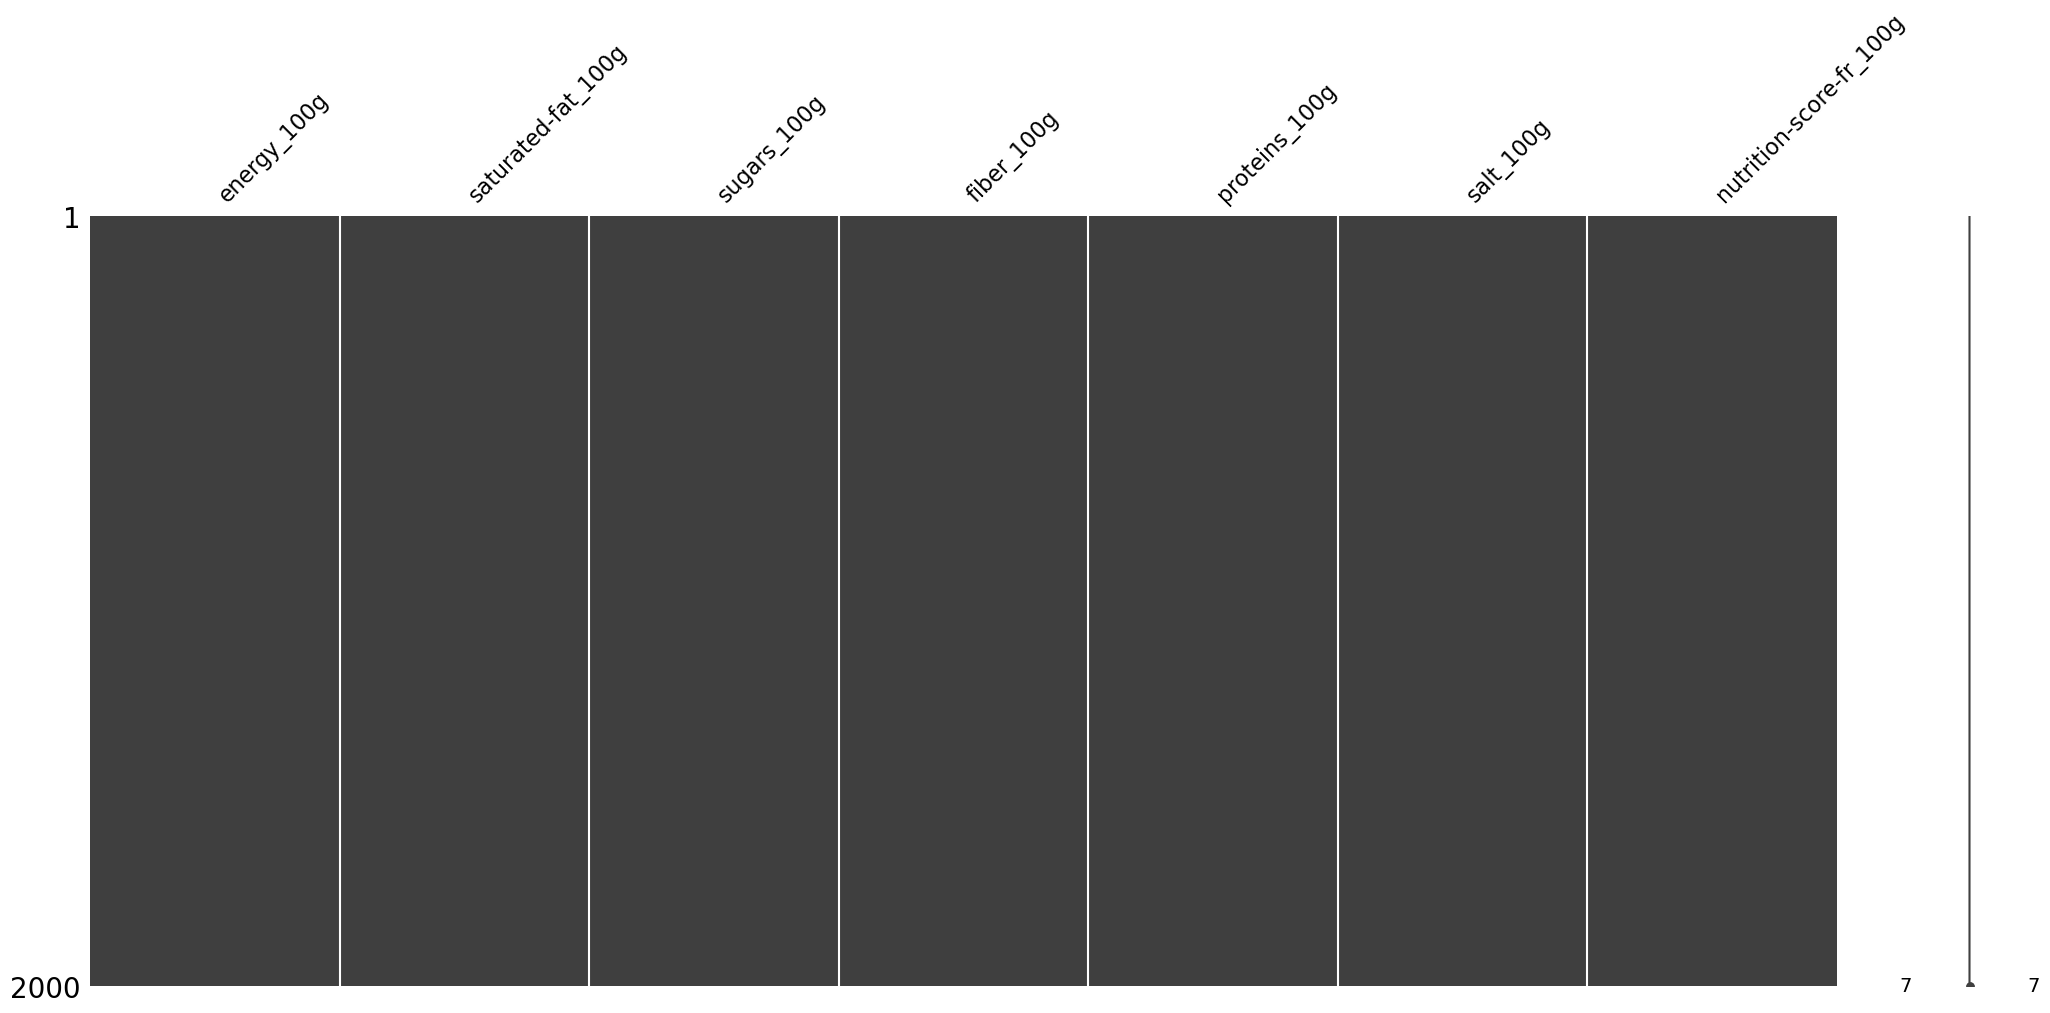

In [27]:
import missingno as msn
msn.matrix(data[['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']].sample(2000))

In [28]:
data['energy_100g'].isna().value_counts()

False    247208
Name: energy_100g, dtype: int64

In [29]:
data['saturated-fat_100g'].isna().value_counts()

False    247208
Name: saturated-fat_100g, dtype: int64

In [30]:
data['sugars_100g'].isna().value_counts()

False    247208
Name: sugars_100g, dtype: int64

In [31]:
data['fiber_100g'].isna().value_counts()

False    247208
Name: fiber_100g, dtype: int64

In [32]:
data['proteins_100g'].isna().value_counts()

False    247208
Name: proteins_100g, dtype: int64

In [33]:
data['salt_100g'].isna().value_counts()

False    247208
Name: salt_100g, dtype: int64

In [34]:
data['nutrition-score-fr_100g'].isna().value_counts()

False    247208
Name: nutrition-score-fr_100g, dtype: int64

Cette phase d'imputation a été laborieuse et pourtant pas pleinement satisfaisante, notamment parce que le nutriscore a été traité globalement alors qu'il est calculé différemment pour les liquides. Comme me l'a indiqué mon mentor, j'aurais du appliquer "l'imputer" en excluant le nutriscore dans un premier temps pour pouvoir le borner à 0 en valeur min. pour les champs qui le nécéssitaient. C'est quand même étonnant qu'il n'ait pas été conçu pour tenir compte du min. original, alors qu'il prend très bien en compte le max. et les quartiles.
<br> Voyons s'il serait envisageable de distinguer les liquides, avec, pourquoi pas, une colonne supplémentaire pour clarifier cette information. Peut-être en s'aidant du 'packaging' ?

In [3]:
data.columns[7:47]

Index(['product_name', 'generic_name', 'quantity', 'packaging',
       'packaging_tags', 'brands', 'brands_tags', 'categories',
       'categories_tags', 'categories_fr', 'origins', 'origins_tags',
       'manufacturing_places', 'manufacturing_places_tags', 'labels',
       'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags',
       'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores',
       'countries', 'countries_tags', 'countries_fr', 'ingredients_text',
       'allergens', 'traces', 'traces_tags', 'traces_fr', 'serving_size',
       'additives_n', 'additives', 'additives_tags', 'additives_fr',
       'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil_tags',
       'ingredients_that_may_be_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_tags'],
      dtype='object')

In [4]:
data['packaging'].isna().mean()

0.79016051260477

In [5]:
data['packaging_tags'].isna().mean()

0.79016051260477

In [7]:
data.loc[(~data['packaging'].isna()) & (data['packaging'] != data['packaging_tags']), 'code'].count()

45018

In [11]:
data.loc[~data['packaging'].isna(), 'packaging'].value_counts()

Sachet,Plastique                                                                                                                                        1636
Carton                                                                                                                                                  1616
Plastique                                                                                                                                               1310
Kunststoff                                                                                                                                               975
Conserve                                                                                                                                                 947
                                                                                                                                                        ... 
Surgelé,Sachet plastique à jeter,Emballage non recyclable 

In [12]:
data.loc[~data['packaging'].isna(), 'packaging'].value_counts()[0:20]

Sachet,Plastique               1636
Carton                         1616
Plastique                      1310
Kunststoff                      975
Conserve                        947
Bouteille,Plastique             814
sachet,plastique                805
Bocal,Verre                     706
barquette,plastique             620
carton                          561
Carton,Plastique                559
plastique                       517
Sachet,plastique                501
Sachet plastique                500
Barquette,Plastique             484
Bocal,Verre,Couvercle,Métal     441
Brique,Carton                   398
Glas                            386
Plastic                         367
Bouteille,Verre                 353
Name: packaging, dtype: int64

Pas suffisamment parlant, d'autant plus que les sauces, soupes ... sont souvent dans des embalages similaires.
<br>En utilisant tous les indices (notamment les divers catégories, l'unité de la quantité) on arriverait laborieusement à identifier une petite partie des produits considérés comme des liquides pour l'application du nutriscore, donc difficile d'appliquer en masse deux méthodes de calculs distinctes !

<br><a name="E12"></a>
## Nous pouvons maintenant passer à l'analyse statistique plus approfondie de ces données
<br>Et peut être que nous allons en déduire un moyen d'améliorer les imputations réalisées ?
<br>Déjà, comment peut on valablement catégoriser les produits ?

<Axes: >

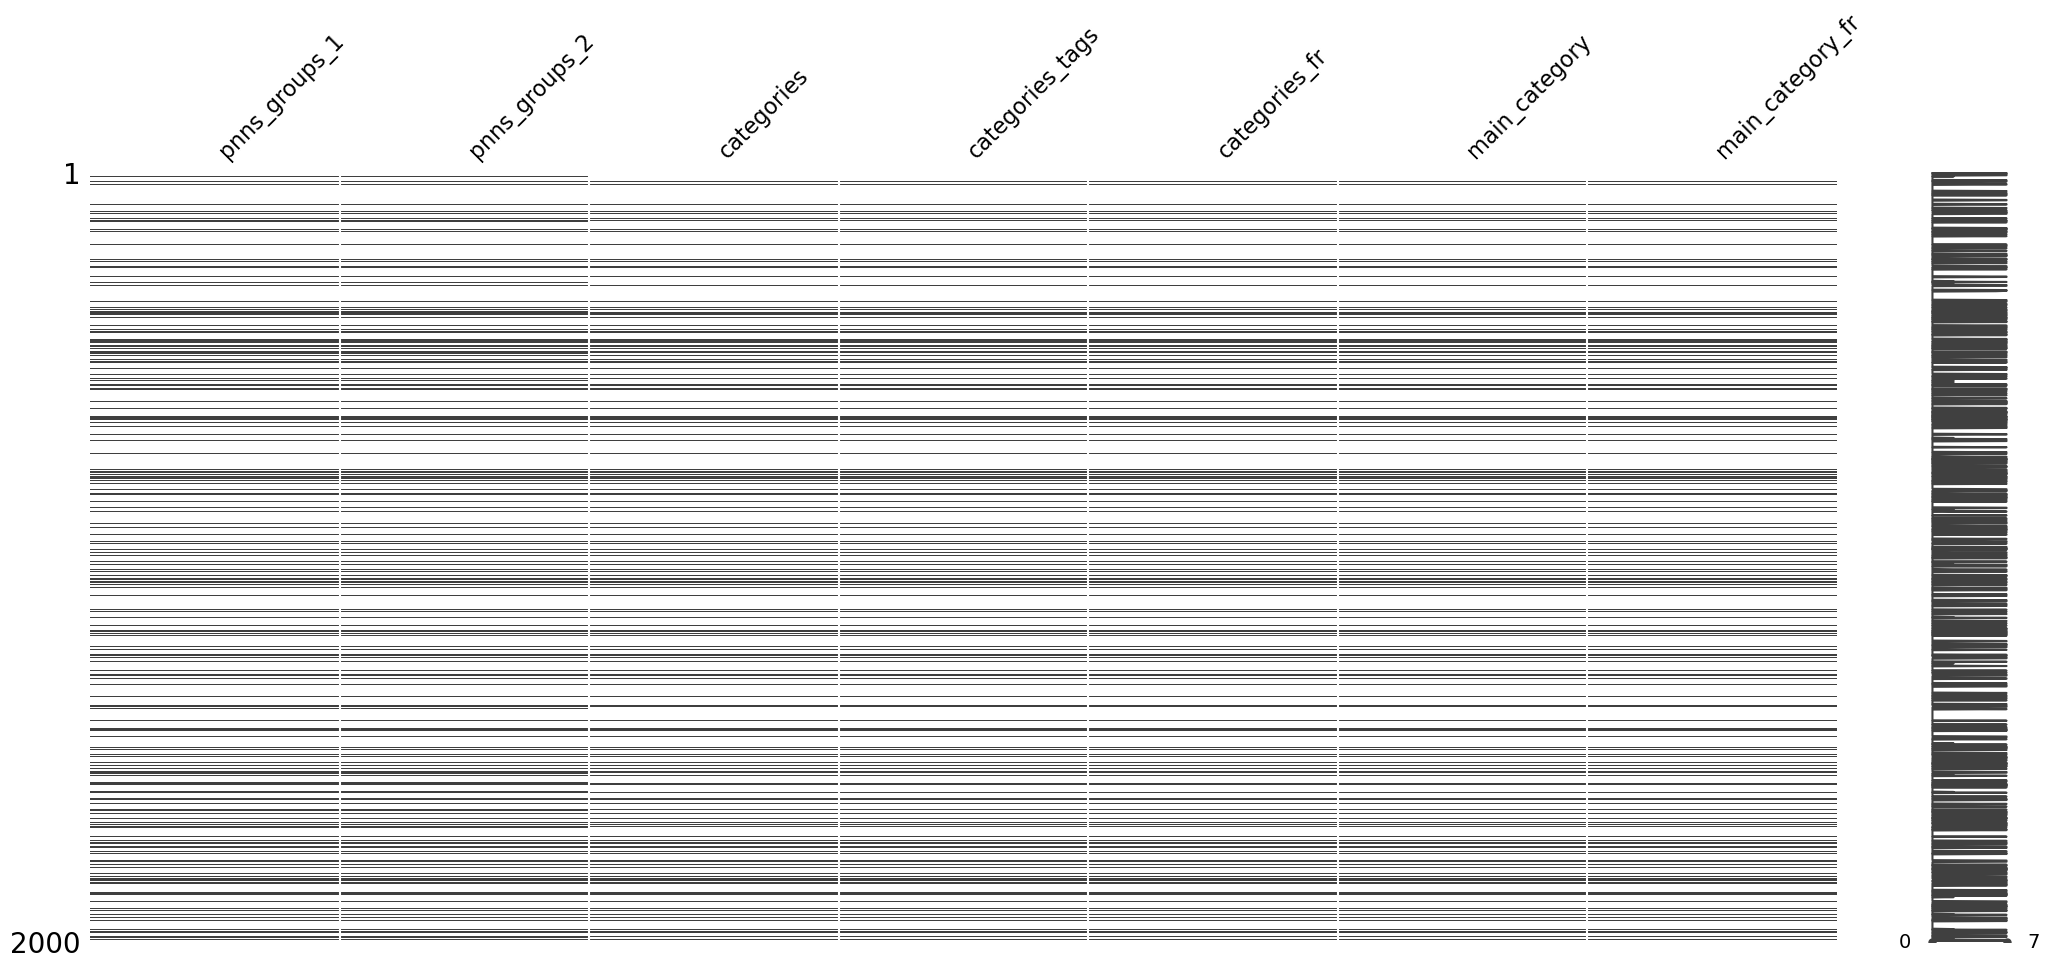

In [3]:
import missingno as msn
msn.matrix(data[['pnns_groups_1', 'pnns_groups_2', 'categories', 'categories_tags', 'categories_fr', 'main_category', 'main_category_fr']].sample(2000))

<Axes: >

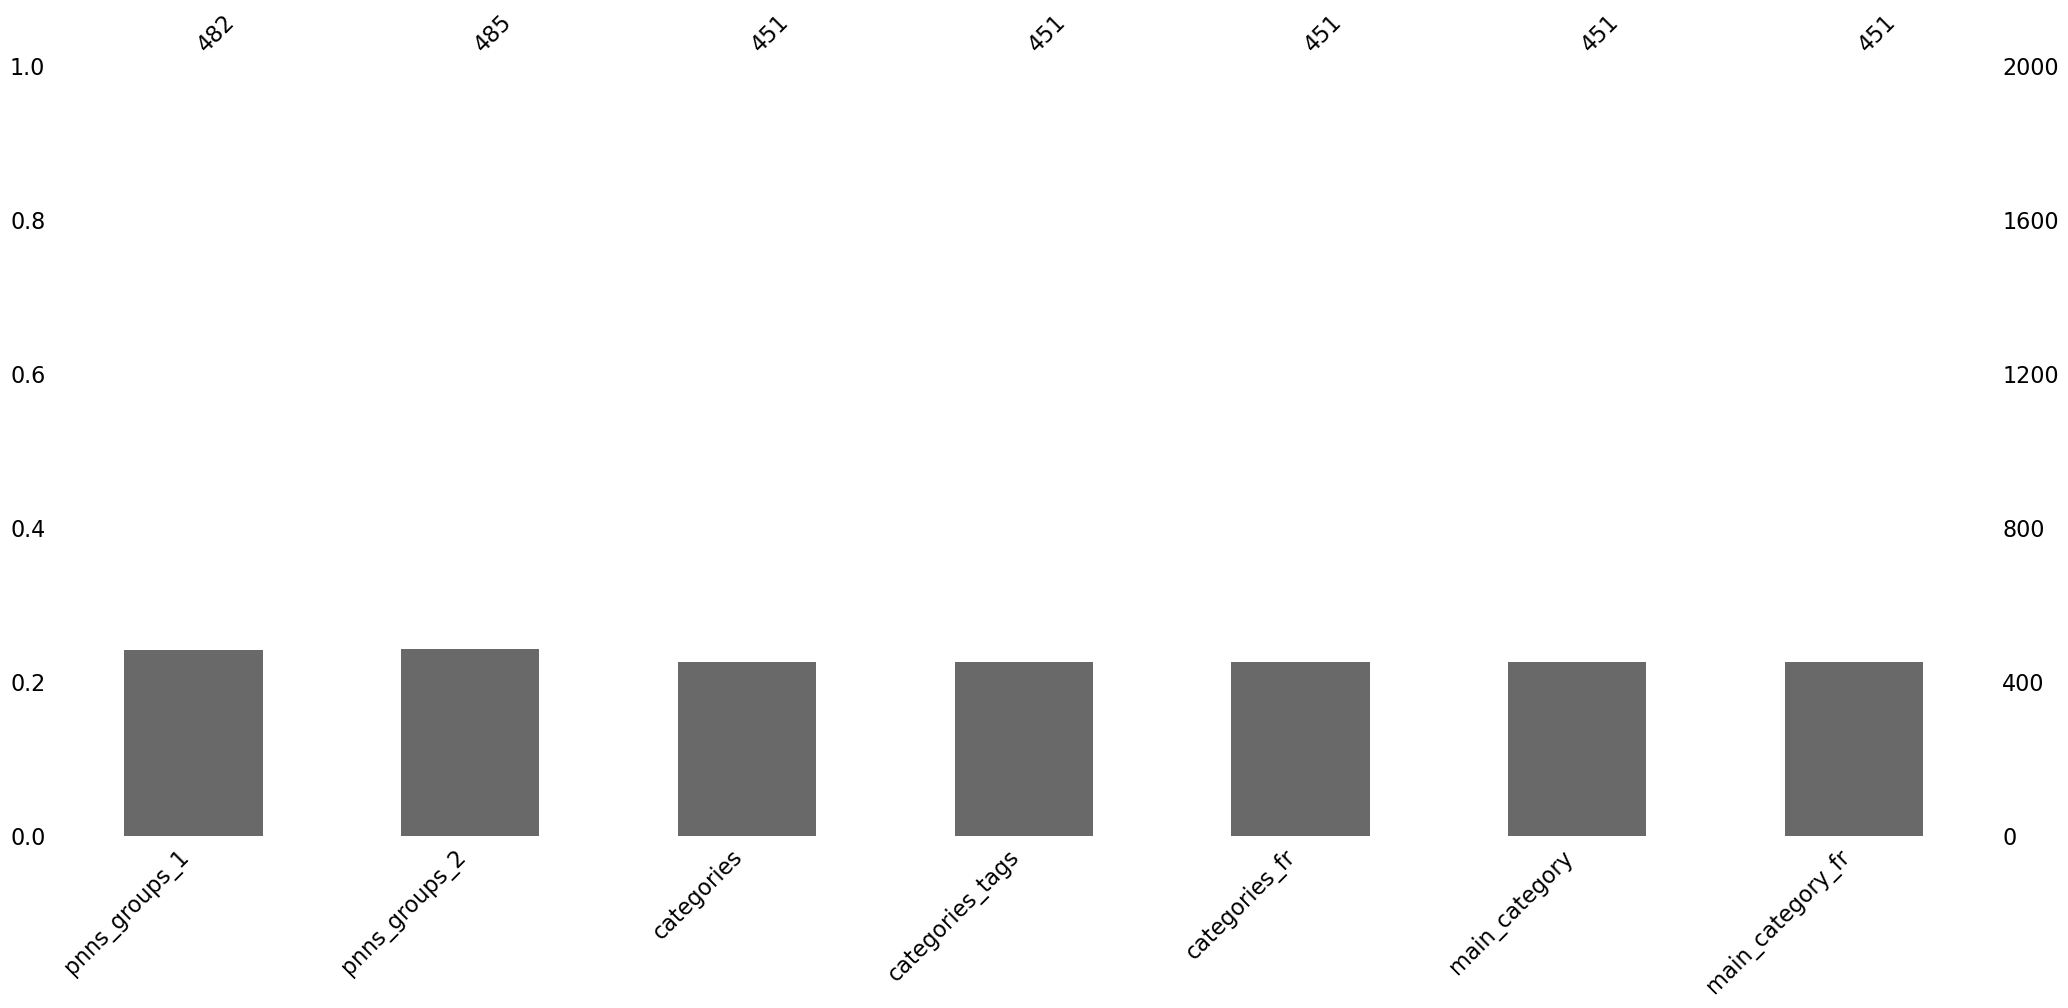

In [4]:
msn.bar(data[['pnns_groups_1', 'pnns_groups_2', 'categories', 'categories_tags', 'categories_fr', 'main_category', 'main_category_fr']].sample(2000))

In [7]:
# examen d'un échantillons de produits pour la catégorie la mieux fournie :
data.loc[~(data['pnns_groups_2'].isna()) & (data['code'] < 10000), 'code']

212        758.0
216         10.0
248         30.0
251         31.0
266         50.0
268         51.0
272       5487.0
385        104.0
436        227.0
9532      1151.0
13010     1664.0
20039       24.0
169619    1756.0
174042     231.0
239403    7132.0
Name: code, dtype: float64

In [9]:
data.loc[212][['pnns_groups_1', 'pnns_groups_2', 'categories', 'categories_tags', 'categories_fr', 'main_category', 'main_category_fr']]

pnns_groups_1                                   Fruits and vegetables
pnns_groups_2                                              Vegetables
categories          Plant-based foods and beverages,Plant-based fo...
categories_tags     en:plant-based-foods-and-beverages,en:plant-ba...
categories_fr       Aliments et boissons à base de végétaux,Alimen...
main_category                                     en:fresh-vegetables
main_category_fr                                        Légumes frais
Name: 212, dtype: object

In [10]:
data.loc[216][['pnns_groups_1', 'pnns_groups_2', 'categories', 'categories_tags', 'categories_fr', 'main_category', 'main_category_fr']]

pnns_groups_1                                           Sugary snacks
pnns_groups_2                                      Biscuits and cakes
categories          Snacks sucrés,Desserts,Biscuits et gâteaux,Gât...
categories_tags     en:sugary-snacks,en:biscuits-and-cakes,en:dess...
categories_fr       Snacks sucrés,Biscuits et gâteaux,Desserts,Gât...
main_category                                                en:cakes
main_category_fr                                              Gâteaux
Name: 216, dtype: object

In [14]:
data.loc[272][['pnns_groups_1', 'pnns_groups_2', 'categories', 'categories_tags', 'categories_fr', 'main_category', 'main_category_fr']]

pnns_groups_1                           unknown
pnns_groups_2                           unknown
categories                Chips,Chips and fries
categories_tags     en:chips-and-fries,en:chips
categories_fr          Chips et frites,en:Chips
main_category                en:chips-and-fries
main_category_fr                Chips et frites
Name: 272, dtype: object

In [19]:
data.loc[20039][['pnns_groups_1', 'pnns_groups_2', 'categories', 'categories_tags', 'categories_fr', 'main_category', 'main_category_fr']]

pnns_groups_1                                                 unknown
pnns_groups_2                                                 unknown
categories                                           de:Proteinpulver
categories_tags     en:dietary-supplements,en:bodybuilding-supplem...
categories_fr       Compléments alimentaires,Compléments pour le B...
main_category                                  en:dietary-supplements
main_category_fr                             Compléments alimentaires
Name: 20039, dtype: object

On constate que les colonnes 'pnns' sont un peut plus fournies que les autres colonnes de catégories, mais si c'est avec des 'unknown' ce ne sont peut être pas les plus interessantes.

In [21]:
data['pnns_groups_1'].value_counts()

unknown                    10867
Sugary snacks               8566
Milk and dairy products     6873
Cereals and potatoes        6332
Beverages                   5661
Composite foods             5629
Fish Meat Eggs              5593
Fruits and vegetables       3372
Fat and sauces              3327
Salty snacks                2135
fruits-and-vegetables        577
sugary-snacks                383
cereals-and-potatoes           4
salty-snacks                   1
Name: pnns_groups_1, dtype: int64

In [22]:
# ci-dessus on a moins de catégories en fait car 4 sont doublées du fait d'une majuscule/minuscule, donc 9 réellement.
data['pnns_groups_2'].value_counts()

unknown                             10867
One-dish meals                       4560
Biscuits and cakes                   3500
Cereals                              3029
Cheese                               2991
Sweets                               2953
Milk and yogurt                      2702
Processed meat                       2404
Dressings and sauces                 2189
Chocolate products                   2113
Fish and seafood                     1947
Non-sugared beverages                1798
Sweetened beverages                  1752
Appetizers                           1608
Fruit juices                         1588
Vegetables                           1479
Bread                                1373
Breakfast cereals                    1245
Fruits                               1157
Fats                                 1138
Meat                                 1069
Dairy desserts                        701
Sandwich                              621
Legumes                           

In [24]:
# Même remarque que précédement, ci-dessus au moins 5 catégories doublées. Regardons les autres groupements :
data['categories'].value_counts()

Snacks sucrés,Biscuits et gâteaux,Biscuits                                                                                                                          243
Aliments et boissons à base de végétaux,Aliments d'origine végétale,Petit-déjeuners,Céréales et pommes de terre,Céréales et dérivés,Céréales pour petit-déjeuner    209
Biscuits                                                                                                                                                            201
Snacks sucrés,Biscuits et gâteaux,Biscuits,Biscuits au chocolat                                                                                                     196
Viandes,Charcuteries,Jambons,Jambons blancs                                                                                                                         182
                                                                                                                                                                

In [25]:
data['categories_tags'].value_counts()

en:sugary-snacks,en:biscuits-and-cakes,en:biscuits                                                                                                                                                                                                                             593
en:plant-based-foods-and-beverages,en:plant-based-foods,en:breakfasts,en:cereals-and-potatoes,en:cereals-and-their-products,en:breakfast-cereals                                                                                                                               457
en:sugary-snacks,en:chocolates,en:dark-chocolates                                                                                                                                                                                                                              439
en:sugary-snacks,en:biscuits-and-cakes,en:biscuits,en:chocolate-biscuits                                                                                                       

In [26]:
data['categories_fr'].value_counts()

Snacks sucrés,Biscuits et gâteaux,Biscuits                                                                                                                                                                                                                                                                                                            593
Aliments et boissons à base de végétaux,Aliments d'origine végétale,Petit-déjeuners,Céréales et pommes de terre,Céréales et dérivés,Céréales pour petit-déjeuner                                                                                                                                                                                      457
Snacks sucrés,Chocolats,Chocolats noirs                                                                                                                                                                                                                                                                             

In [27]:
data['main_category'].value_counts()

en:beverages                          2025
en:canned-foods                       1872
en:groceries                          1869
en:chocolates                         1862
en:plant-based-foods-and-beverages    1811
                                      ... 
fr:repas-minceur                         1
fr:preparation-en-poudre                 1
fr:galettes-dietetiques                  1
fr:sucre-en-petits-morceaux              1
fr:carpaccio                             1
Name: main_category, Length: 1868, dtype: int64

In [32]:
data['main_category_fr'].value_counts()

Boissons                                   2025
Conserves                                  1872
Epicerie                                   1869
Chocolats                                  1862
Aliments et boissons à base de végétaux    1811
                                           ... 
Repas-minceur                                 1
Preparation-en-poudre                         1
Galettes-dietetiques                          1
Sucre-en-petits-morceaux                      1
Carpaccio                                     1
Name: main_category_fr, Length: 1868, dtype: int64

In [31]:
data['main_category_fr'].value_counts().sum()

55482

Cette dernière colonne parait finalement la mieux renseignée, considérant sa pertinence et sa clarté. Elle ne couvre qu'à peine 22,5 % des produits toutefois.

In [34]:
data['main_category_fr'].value_counts()[0:20]

Boissons                                   2025
Conserves                                  1872
Epicerie                                   1869
Chocolats                                  1862
Aliments et boissons à base de végétaux    1811
Plats préparés                             1716
Biscuits                                   1615
Petit-déjeuners                            1555
Surgelés                                   1520
Desserts                                   1497
Snacks sucrés                              1333
Pains                                      1320
Fromages                                   1290
Plats à base de viande                     1117
Pâtes alimentaires                         1084
Gâteaux                                     977
Chips et frites                             932
Produits à tartiner salés                   883
Laits                                       844
Yaourts                                     797
Name: main_category_fr, dtype: int64

In [35]:
data['main_category_fr'].value_counts()[20:40]

Snacks salés          752
Confitures            734
Bonbons               732
Soupes                715
Sandwichs             617
Sodas                 611
Fruits à coques       550
Aliments pour bébé    538
Volailles             501
Riz                   496
Fromages de France    491
Jambons               466
Beurres               453
Jus de fruits         448
Viandes               430
Glaces                428
Condiments            428
Fromages de vache     407
Légumes frais         405
Saucisses             382
Name: main_category_fr, dtype: int64

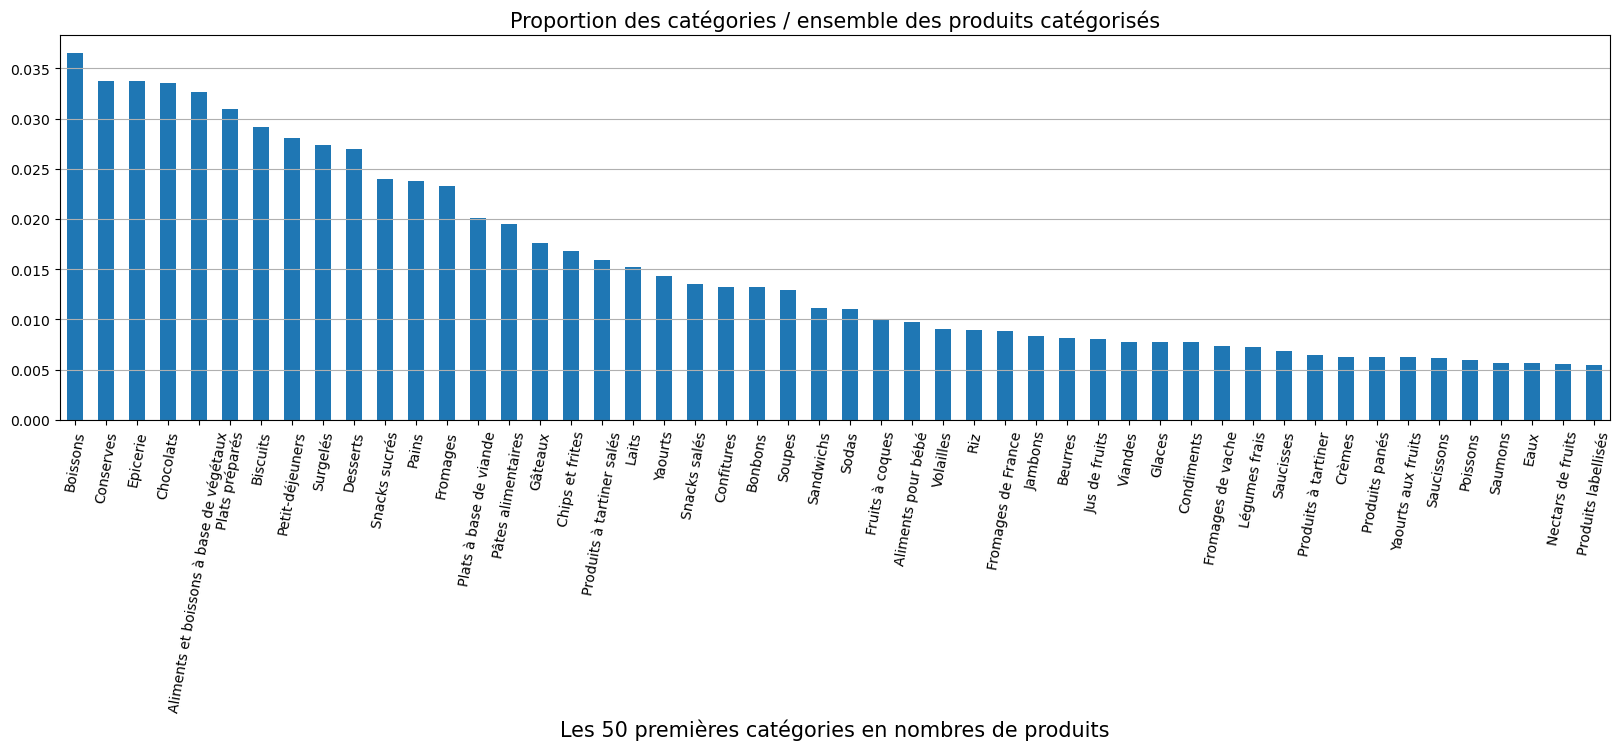

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
data['main_category_fr'].value_counts(normalize=True)[0:50].plot(kind='bar')
plt.xlabel('Les 50 premières catégories en nombres de produits', fontsize=15)
plt.title('Proportion des catégories / ensemble des produits catégorisés', fontsize=15)
plt.grid(axis='y')
plt.xticks(rotation=80)
plt.show()

Pour avoir un peu plus de précision dans la catégorisation, on peut dans une certaine mesure utiliser 'pnns_groups_1', mais il faut d'abord réunir les groupes 'maladroitement' divisés :

In [44]:
data.loc[data['pnns_groups_1'].astype('string') == 'salty-snacks', 'product_name']

237708    Castañas congeladas
Name: product_name, dtype: object

In [48]:
data.iloc[237708,48] = 'Salty snacks'

In [47]:
data.columns[45:50]

Index(['ingredients_that_may_be_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_fr',
       'pnns_groups_1', 'pnns_groups_2'],
      dtype='object')

In [49]:
data.loc[data['pnns_groups_1'].astype('string') == 'cereals-and-potatoes', 'product_name']

173289                                      Arroz precocido
198844                                    Maïs doux en épis
211418    Garbanzos cocidos congelados &quot;Carrefour&q...
211663      Arroz precocido congelado &quot;Carrefour&quot;
Name: product_name, dtype: object

In [50]:
data.iloc[173289,48] = 'Cereals and potatoes'
data.iloc[198844,48] = 'Cereals and potatoes'
data.iloc[211418,48] = 'Cereals and potatoes'
data.iloc[211663,48] = 'Cereals and potatoes'

In [51]:
ind_list = data.loc[data['pnns_groups_1'].astype('string') == 'sugary-snacks', 'product_name'].index
for ind in ind_list :
    data.iloc[ind,48] = 'Sugary snacks'


In [52]:
ind_list = data.loc[data['pnns_groups_1'].astype('string') == 'fruits-and-vegetables', 'product_name'].index
for ind in ind_list :
    data.iloc[ind,48] = 'Fruits and vegetables'


In [53]:
data['pnns_groups_1'].value_counts()

unknown                    10867
Sugary snacks               8949
Milk and dairy products     6873
Cereals and potatoes        6336
Beverages                   5661
Composite foods             5629
Fish Meat Eggs              5593
Fruits and vegetables       3949
Fat and sauces              3327
Salty snacks                2136
Name: pnns_groups_1, dtype: int64

In [54]:
data.loc[data['main_category_fr'].astype('string') == 'Boissons', 'pnns_groups_1'].value_counts()

Beverages    1887
Name: pnns_groups_1, dtype: int64

In [55]:
data.loc[data['main_category_fr'].astype('string') == 'Conserves', 'pnns_groups_1'].value_counts()

Fruits and vegetables      991
Composite foods            336
Cereals and potatoes       314
unknown                    133
Fat and sauces              67
Fish Meat Eggs              17
Milk and dairy products     11
Salty snacks                 2
Sugary snacks                1
Name: pnns_groups_1, dtype: int64

([<matplotlib.patches.Wedge at 0x22d9df0fc10>,
 [Text(-0.10138699852885526, 1.0953176144522236, 'Fruits and vegetables'),
  Text(-0.8059983056147382, -0.7485764699388909, 'Composite foods'),
  Text(0.2918268439273257, -1.0605833739802903, 'Cereals and potatoes'),
  Text(0.9365511637059613, -0.5769505332010795, 'unknown'),
  Text(1.0743236201381292, -0.23628110210786016, 'Fat and sauces'),
  Text(1.0968647612310245, -0.0829921416135776, 'Fish Meat Eggs'),
  Text(1.0995523666657097, -0.03137822429387632, 'Milk and dairy products'),
  Text(1.0999752153376818, -0.007384148076831697, 'Salty snacks'),
  Text(1.0999984508047829, -0.0018461384232936445, 'Sugary snacks')])

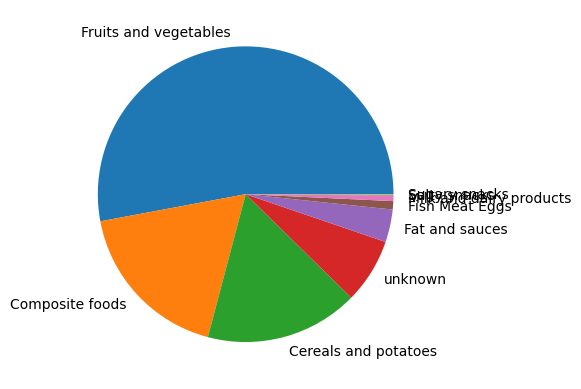

In [18]:
# un petit diagramme pour mieux cerner cette répartition :
#import matplotlib.pyplot as plt
plt.pie(x=data.loc[data['main_category_fr'].astype('string') == 'Conserves', 'pnns_groups_1'].value_counts(), labels=data.loc[data['main_category_fr'].astype('string') == 'Conserves', 'pnns_groups_1'].value_counts().index)

In [56]:
data.loc[data['main_category_fr'].astype('string') == 'Epicerie', 'pnns_groups_1'].value_counts()

Fat and sauces           1696
unknown                   161
Fruits and vegetables       6
Cereals and potatoes        3
Beverages                   1
Composite foods             1
Sugary snacks               1
Name: pnns_groups_1, dtype: int64

In [57]:
data.loc[data['main_category_fr'].astype('string') == 'Chocolats', 'pnns_groups_1'].value_counts()

Sugary snacks    1861
Beverages           1
Name: pnns_groups_1, dtype: int64

In [58]:
# ces croisements d'informations permettent de déceler de probables anomalies :
data.loc[data['main_category_fr'].astype('string') == 'Snacks sucrés', 'pnns_groups_1'].value_counts()

Sugary snacks    952
unknown          369
Salty snacks      12
Name: pnns_groups_1, dtype: int64

<a name="E13"></a>

In [59]:
# le domaine des boissons est assez mysterieux pour le moment, surtout qu'on a aussi des catégories 'eau', 'Sodas', 'jus de fruits' ...
data.loc[data['main_category_fr'].astype('string') == 'Boissons', 'product_name'].head(15)

533        Aloe Vera Grape & Apple Juice
740               Fresh Drinking Coconut
9652                     Honey Soy Drink
10053               Brisk Iced Tea Lemon
10054                        Iced Coffee
10074               Brisk Iced Tea Mango
10082            Amp Energy Cherry Blast
10083                                NaN
10791                    Boisson au soja
11414                  100% Tomato Juice
12709                       Lait de coco
12731                       Lychee drink
12735                     Kokosnussmilch
12736                      Soursop Juice
14694    Boisson a base de jus de lychee
Name: product_name, dtype: object

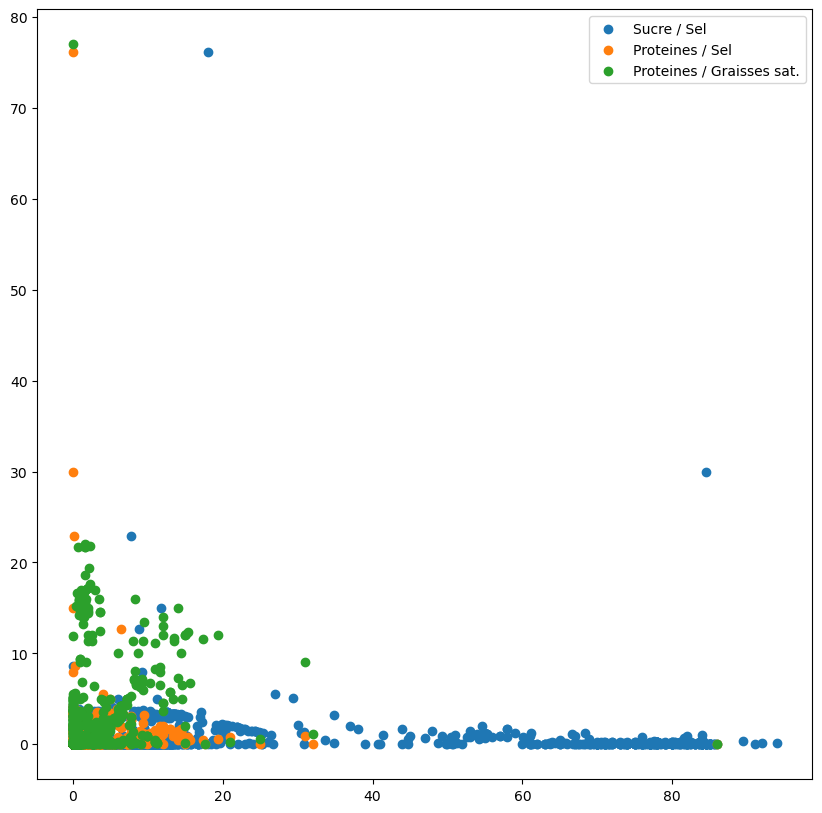

In [61]:
# il y a du tri à faire ! Est-ce que des caractéristiques du nutriscore ne pourraient pas nous y aider ?
boissons = data.loc[data['main_category_fr'].astype('string') == 'Boissons', :]
plt.figure(figsize=(10,10))
plt.scatter(boissons['sugars_100g'], boissons['salt_100g'], label='Sucre / Sel')
plt.scatter(boissons['proteins_100g'], boissons['salt_100g'], label='Proteines / Sel')
plt.scatter(boissons['proteins_100g'], boissons['saturated-fat_100g'], label='Proteines / Graisses sat.')
plt.legend()
plt.show()

In [62]:
# C'est confus ici mais on perçoit quand même certains groupes. Vérifions les outliers :
boissons.loc[boissons['salt_100g'] > 75.0, 'product_name']

145177    Allure Mango
Name: product_name, dtype: object

In [64]:
boissons.loc[145177][9:29]

quantity                                                                500 ml
packaging                                                  Bouteille,Plastique
packaging_tags                                             bouteille,plastique
brands                                                              Alō Allure
brands_tags                                                         alō-allure
categories                                                    Boissons sucrées
categories_tags                              en:beverages,en:sugared-beverages
categories_fr                                        Boissons,Boissons sucrées
origins                                                                    NaN
origins_tags                                                               NaN
manufacturing_places                                                    Taïwan
manufacturing_places_tags                                               taiwan
labels                       Sans aloïne,Sans gluten

In [65]:
boissons.loc[145177][29:49]

stores                                                                                      NaN
countries                                                                     France,États-Unis
countries_tags                                                       en:france,en:united-states
countries_fr                                                                  France,États-Unis
ingredients_text                              Eau, jus d'aloes, pulpe d'aloès, sucre de cann...
allergens                                                                                   NaN
traces                                                                                      NaN
traces_tags                                                                                 NaN
traces_fr                                                                                   NaN
serving_size                                                                   240 ml (8 fl oz)
additives_n                             

In [66]:
boissons.loc[145177][33]

"Eau, jus d'aloes, pulpe d'aloès, sucre de canne, jus de mangoustan, jus de manque, acide citrique, vitamice C (acide ascorbique),bêtacarotène (colorant), saveurs naturelles."

In [73]:
boissons.loc[boissons['product_name'] == 'Allure Mango', 'code'].index[0] # ne marche pas, retourne la valeur pour 'data'

145177

In [75]:
boissons.index[boissons['product_name'] == 'Allure Mango'] # ne marche pas, retourne la valeur pour 'data'

Int64Index([145177], dtype='int64')

In [76]:
import numpy as np
np.where(boissons['product_name'] == 'Allure Mango')

(array([109], dtype=int64),)

In [77]:
boissons.iloc[109,33]  # Ahhh, vive numpy !

"Eau, jus d'aloes, pulpe d'aloès, sucre de canne, jus de mangoustan, jus de manque, acide citrique, vitamice C (acide ascorbique),bêtacarotène (colorant), saveurs naturelles."

In [78]:
# mettons le taux de sel à 0, ce sera beaucoup plus réaliste :
boissons.iloc[109,83] = 0.0
boissons.iloc[109,84] = 0.0
data.iloc[145177,83] = 0.0
data.iloc[145177,84] = 0.0

In [79]:
boissons.loc[boissons['proteins_100g'] > 75.0, 'product_name']

180367    Sirop Fraise
Name: product_name, dtype: object

In [80]:
boissons.loc[180367][33]

'Sucre, sirop de glucose-fructose, jus de fruits à base de concentrés : 34% (fraise 25%, sureau, citron), eau, arômes, acidifiant : acide citrique'

In [81]:
boissons.loc[180367][57:77]

energy_100g                   180.0
energy-from-fat_100g            NaN
fat_100g                        0.0
saturated-fat_100g              0.0
monounsaturated-fat_100g        NaN
polyunsaturated-fat_100g        NaN
omega-3-fat_100g                NaN
alpha-linolenic-acid_100g       NaN
eicosapentaenoic-acid_100g      NaN
docosahexaenoic-acid_100g       NaN
omega-6-fat_100g                NaN
linoleic-acid_100g              NaN
omega-9-fat_100g                NaN
trans-fat_100g                  NaN
cholesterol_100g                NaN
carbohydrates_100g             10.6
sugars_100g                    10.6
sucrose_100g                    NaN
glucose_100g                    NaN
fructose_100g                   NaN
Name: 180367, dtype: object

In [82]:
boissons.loc[180367][77:97]

lactose_100g           NaN
starch_100g            NaN
polyols_100g           NaN
fiber_100g             0.0
proteins_100g         86.0
casein_100g            NaN
salt_100g              0.0
sodium_100g            0.0
alcohol_100g           NaN
vitamin-a_100g         NaN
beta-carotene_100g     NaN
vitamin-d_100g         NaN
vitamin-e_100g         NaN
vitamin-k_100g         NaN
vitamin-c_100g         NaN
vitamin-b1_100g        NaN
vitamin-b2_100g        NaN
vitamin-pp_100g        NaN
vitamin-b6_100g        NaN
vitamin-b9_100g        NaN
Name: 180367, dtype: object

In [83]:
# on va mettre les protéines à 0
np.where(boissons['proteins_100g'] == 86.0)

(array([369], dtype=int64),)

In [84]:
boissons.iloc[369,81] = 0.0
data.iloc[180367,81] = 0.0

In [85]:
boissons.loc[boissons['saturated-fat_100g'] > 75.0, 'product_name']

187161    Sirop de Grenadine
Name: product_name, dtype: object

In [86]:
boissons.loc[187161][57:87]

energy_100g                    1460.0
energy-from-fat_100g              NaN
fat_100g                          NaN
saturated-fat_100g               77.0
monounsaturated-fat_100g          NaN
polyunsaturated-fat_100g          NaN
omega-3-fat_100g                  NaN
alpha-linolenic-acid_100g         NaN
eicosapentaenoic-acid_100g        NaN
docosahexaenoic-acid_100g         NaN
omega-6-fat_100g                  NaN
linoleic-acid_100g                NaN
omega-9-fat_100g                  NaN
trans-fat_100g                    NaN
cholesterol_100g                  NaN
carbohydrates_100g                NaN
sugars_100g                      77.0
sucrose_100g                      NaN
glucose_100g                      NaN
fructose_100g                     NaN
lactose_100g                      NaN
starch_100g                       NaN
polyols_100g                      NaN
fiber_100g                        0.0
proteins_100g                    0.06
casein_100g                       NaN
salt_100g   

In [87]:
# on va mettre les graisses à 0 et le sucre au niveau du sirop de fraise
np.where(boissons['saturated-fat_100g'] > 75.0)

(array([595], dtype=int64),)

In [88]:
boissons.iloc[595,60] = 0.0
boissons.iloc[595,73] = 0.0
data.iloc[187161,60] = 10.6
data.iloc[187161,73] = 10.6

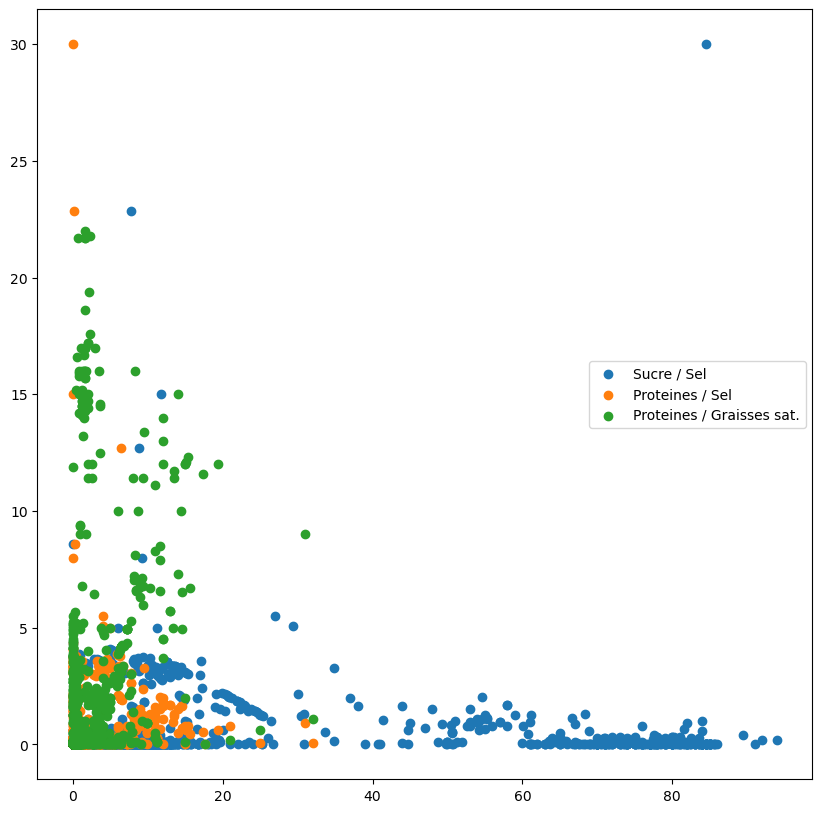

In [89]:
plt.figure(figsize=(10,10))
plt.scatter(boissons['sugars_100g'], boissons['salt_100g'], label='Sucre / Sel')
plt.scatter(boissons['proteins_100g'], boissons['salt_100g'], label='Proteines / Sel')
plt.scatter(boissons['proteins_100g'], boissons['saturated-fat_100g'], label='Proteines / Graisses sat.')
plt.legend()
plt.show()

In [90]:
# c'est beaucoup mieux ! Encore un petit nettoyage :
boissons.loc[boissons['proteins_100g'] > 29.0, 'product_name']

178751    Lait demi écrémé en poudre
221011                 Lait d'Amande
Name: product_name, dtype: object

In [93]:
boissons.loc[boissons['product_name'].str[0:4] == 'Lait', ['product_name','proteins_100g']]

product_name  proteins_100g
12709                            Lait de coco           1.60
99591                            Lait de coco           1.60
174788                           Lait de coco           1.60
178751             Lait demi écrémé en poudre          31.00
186620  Lait d'amande Sans sucres ajoutés BIO           0.70
186725                  Lait d'Amande Calcium           0.50
186726             Lait d'amandes sans sucres           0.50
186731                 Lait d'Amande Chocolat           0.90
186733                 Lait D'amande Chocolat           0.90
189406                           Lait de Coco           1.80
192013                           Lait de coco           2.00
193378                           Lait de coco           1.30
194307                          Lait de coco.           2.00
194748                          Lait d'Amande           2.00
195793                           Lait de coco           0.80
195794                           Lait de Coco           2.30
198509                         Lait d'amandes           0.90
205091                           Lait de Coco           1.30
206780                      Lait riz amarante           0.50
206814                   Lait de Coco Cuisine           1.30
206828                     Lait Avoine Nature           1.10
207146                           Lait de coco           1.20
214244                           Lait de Coco           1.50
215998                           Lait de Coco           1.70
217746                            Lait entier           3.20
217940                          Lait d'amande           2.00
218111                           Lait de coco           1.30
218180                           Lait de coco           1.30
219702                           Lait de Coco           0.99
220015     Lait de coco gingembre citronnelle           2.00
220758                           Lait de coco           1.60
220789         Lait de coco 200 ml Jardin Bio           1.30
220880                           Lait de coco           1.70
221011                          Lait d'Amande          32.00
221013              Lait d'Amande au Chocolat          15.00
222319                Lait de Coco Biologique           1.30
223924                           Lait de coco           2.00
223933                  Lait de coco suzi wan           1.60
223948                           Lait de Coco           1.60
232102                           Lait de coco           1.30
232103                           Lait de coco           1.30
232330                          Lait de coco            0.00
232333                   Lait de coco premium           0.50
234723                      Lait sans lactose           3.20
236253                   Lait de soja vanille           3.30
236314                       Lait coco amande           0.30
236323                      Lait de macadamia           0.50
239810                Lait Avoine Vanille Bio           1.00

In [94]:
# le lait demi écrémé est en poudre, ce n'est pas une boisson ! Pour le lait d'amandes, est-il en poudre ?
boissons.loc[221011][33]

nan

In [95]:
boissons.loc[221011][9:50]

quantity                                                                                    NaN
packaging                                                                                   NaN
packaging_tags                                                                              NaN
brands                                                                              La Mandorle
brands_tags                                                                         la-mandorle
categories                                    Plant-based foods and beverages,Beverages,Plan...
categories_tags                               en:plant-based-foods-and-beverages,en:beverage...
categories_fr                                 Aliments et boissons à base de végétaux,Boisso...
origins                                                                                     NaN
origins_tags                                                                                NaN
manufacturing_places                    

In [96]:
# oui je connais c'est aussi de la poudre, rien à faire dans 'boissons'
np.where(boissons['proteins_100g'] > 29.0)

(array([ 253, 1313], dtype=int64),)

In [98]:
# boissons = boissons.drop(index=253, axis=0)
# boissons = boissons.drop(index=1313, axis=0)   BON, le drop demande l'index de data !!
boissons = boissons.drop(index=221011, axis=0)
boissons = boissons.drop(index=178751, axis=0)

In [104]:
boissons.shape

(2023, 125)

In [108]:
boissons.loc[(boissons['sugars_100g'] > 80.0) & (boissons['salt_100g'] > 29.0), 'product_name']

180316    Sirop de Cassis
Name: product_name, dtype: object

In [109]:
# nous allons mettre son niveau de sucre à celui des autres sirops, et celui de sel à 0
np.where((boissons['sugars_100g'] > 80.0) & (boissons['salt_100g'] > 29.0))

(array([334], dtype=int64),)

In [110]:
boissons.iloc[334,83] = 0.0
boissons.iloc[334,84] = 0.0
boissons.iloc[334,73] = 10.6
data.iloc[180316,83] = 0.0
data.iloc[180316,84] = 0.0
data.iloc[180316,73] = 10.6

In [113]:
#boissons.loc[boissons['proteins_100g'] > 2.0, 'product_name']
boissons.loc[boissons['salt_100g'] > 20.0, 'product_name']

237548    Spéciale Réserve Porto
Name: product_name, dtype: object

In [114]:
boissons.loc[237548][33]

'Raisins du Cima Corgo'

In [115]:
boissons.loc[237548][9:25]

quantity                                                                 75 cl
packaging                                                      Bouteille,Verre
packaging_tags                                                 bouteille,verre
brands                                                                   Rozes
brands_tags                                                              rozes
categories                   Wines from Portugal,Fortified wines,Sweet wine...
categories_tags              en:beverages,en:alcoholic-beverages,en:wines,e...
categories_fr                Boissons,Boissons alcoolisées,Vins,Vins mutés,...
origins                                                               Portugal
origins_tags                                                          portugal
manufacturing_places                                                       NaN
manufacturing_places_tags                                                  NaN
labels                                              

In [116]:
# les boissons alcolisées (sauf très faiblement) ne sont pas concernées par le nutriscore.
boissons = boissons.drop(index=237548, axis=0)

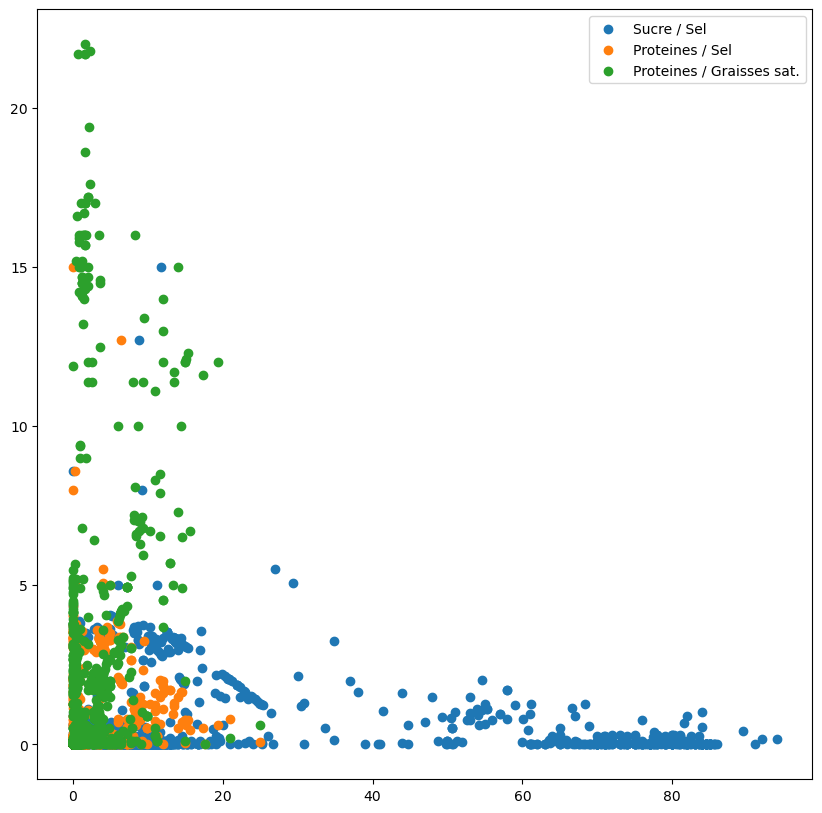

In [117]:
plt.figure(figsize=(10,10))
plt.scatter(boissons['sugars_100g'], boissons['salt_100g'], label='Sucre / Sel')
plt.scatter(boissons['proteins_100g'], boissons['salt_100g'], label='Proteines / Sel')
plt.scatter(boissons['proteins_100g'], boissons['saturated-fat_100g'], label='Proteines / Graisses sat.')
plt.legend()
plt.show()

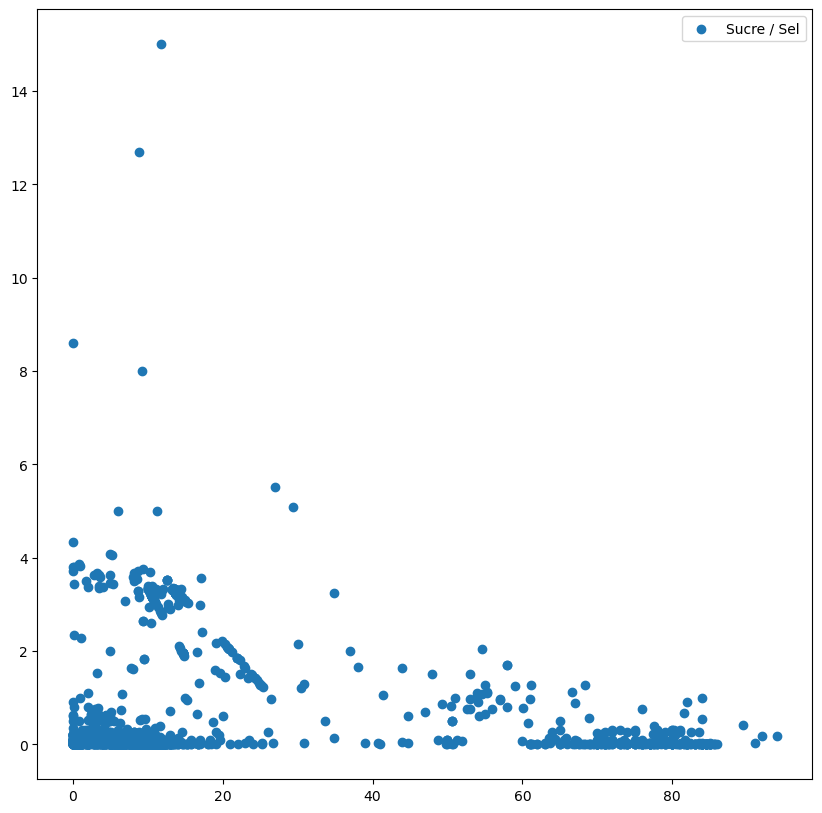

In [120]:
plt.figure(figsize=(10,10))
plt.scatter(boissons['sugars_100g'], boissons['salt_100g'], label='Sucre / Sel')
plt.legend()
plt.show()

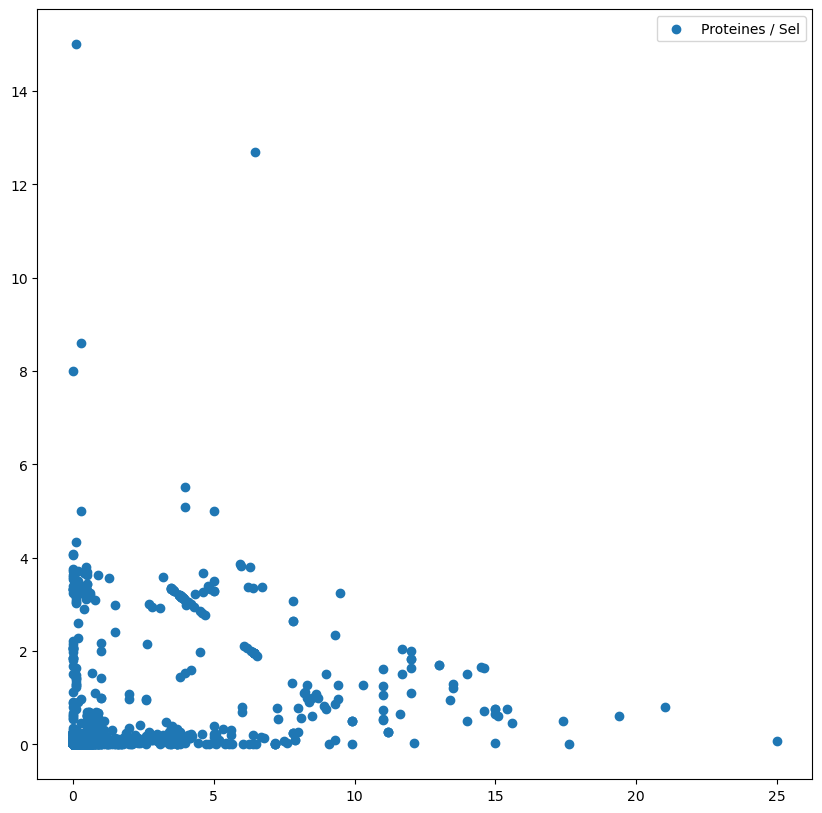

In [119]:
plt.figure(figsize=(10,10))
plt.scatter(boissons['proteins_100g'], boissons['salt_100g'], label='Proteines / Sel')
plt.legend()
plt.show()

On voit mieux un certain nombre de groupes maintenant, par exemple à quoi correspond celui pour lequel le taux de protéines est entre trois et cinq, et celui de sel entre 2.5 et 4 ?

In [122]:
boissons.to_csv('boissons.csv', sep='	')

In [2]:
#import pandas as pd
boissons = pd.read_csv('boissons.csv', sep='	')

In [3]:
boissons = boissons.drop('Unnamed: 0', axis=1)

In [6]:
boissons.loc[(boissons['proteins_100g'] > 3.0) & (boissons['proteins_100g'] <= 5.5) & (boissons['salt_100g'] > 2.5) & (boissons['salt_100g'] <= 4), ['product_name','energy_100g','saturated-fat_100g','sugars_100g','nutrition-score-fr_100g']]

product_name  energy_100g  \
156   Квас «Настоящий». Фильтрованный. Пастеризованный.         80.0   
287                                             Ambrée         218.0   
293                                              Blonde        209.0   
297                         Bière blanche Fruits rouges        205.0   
298                                              Blonde        209.0   
301                                Pur Malt sans alcool        108.0   
369                                      Sirop de Pêche        171.0   
376                          Concentré de réglisse cola        103.0   
377             Concentré de réglisse pomme et cannelle        103.0   
396                                           Tradition        213.0   
504                                            Pur Malt        116.0   
603                                        Black Spirit        282.0   
821                  boisson au soja, source de calcium        189.0   
1021                                           Dark Dog        213.0   
1121                  Cocktail Sans Alcool goût Passion        282.0   
1401                                  Erdinger Pikantus        260.0   
1476                                       Himbeer-Limo        145.0   
1504              fritz-spritz Bio-Rhabarbersaftschorle         35.0   
1547  Пиво светлое «Балтика экспортное» №7. Пастериз...        190.0   
1548                                 Балтика Крепкое №9        260.0   
1549            Пиво светлое «Балтика классическое» № 3        190.0   
1554                Пиво светлое «Янтарное специальное»        192.0   
1556  Сок томатный с сахаром и солью с мякотью для д...         95.0   
1557                            Грейпфрут, лимон и лайм        200.0   
1558                                   Волшебная сказка        220.0   
1559                                     Томат 100% сок         84.0   
1561  Квас &quot;Никола Традиционный&quot; фильтрова...        170.0   
1562  «Большой квас» любимый «Настоящий» живого брож...         80.0   
1563                             Квас «Иван Солодушкин»         84.0   
1564                            Amstel Premium Pilsener        172.0   
1565                                   Земляничное лето        170.0   
1566                                   Гранатовый сезон        190.0   
1571                       Золотая бочка (классическое)        184.0   
1574  Квас хлебный «Вятский» фильтрованный, пастериз...        105.0   
1580                   Морс «Добрый» «Брусника морошка»        204.0   
1586  Пиво «Крепкое» светлое фильтрованное пастеризо...        290.0   
1587       Кофе натуральный растворимый сублимированный        427.0   
1589                            Жигули барное бархатное        195.0   
1591                                             無糖高纖豆漿        170.0   
1618                   Stella Artois Premium Lager Beer        167.0   
1635                 Cubanisto beer with mojito flavour        184.0   
1680                              viña del cura - Rioja        321.0   
1697                                          Mars Milk        353.0   
1755                             Gordon Finest Titanium        375.0   
1756                                        Wild Fruits        114.0   
1762                                 Rum flavoured beer        226.0   
1806                                       Witte Lambic        189.0   
1829                            Tsjeeses X-Mas Ale 2015        402.0   
1833                                    Aranciata Fanta        205.0   
1870                                       Sumol ananas        180.0   

      saturated-fat_100g  sugars_100g  nutrition-score-fr_100g  
156             1.675276     9.991108                      5.0  
287             2.078929    10.750016                      5.0  
293             2.052603    10.700522                      5.0  
297             2.040903    10.678525                      5.0  
298             2.052603    10.700522        

Cela correspond principalement aux bières sans alcool, bien qu'il y ait aussi quelques autres produits (avec tous ceux en grec ou cyrillique ... , pas facile de savoir); Ils ont tous un taux de graisses et de sucres du même niveau (et par construction, pareil pour protéines et sel), et par conséquent un apport énergétique à peu près similaire.
<br>Autre exemple, le groupe avec un taux de protéines entre 13 et 16:

In [7]:
boissons.loc[(boissons['proteins_100g'] > 13.0) & (boissons['proteins_100g'] <= 16.0), ['product_name','energy_100g','saturated-fat_100g','sugars_100g','nutrition-score-fr_100g']]

product_name  energy_100g  saturated-fat_100g  \
178                            Bon matin       1731.0            7.300000   
183                         Café soluble       1250.0            0.100000   
239                       Ricoré au lait       1775.0           10.000000   
539                           Cappuccino       1697.0           12.000000   
622         Cappuccino Format Economique       1632.0            6.529038   
801                   Cappuccino nature        1674.0           12.300000   
1118       Dosettes Café Latte Macchiato       1904.0           15.000000   
1163                          Cappuccino       1670.0           12.000000   
1177                          Cappuccino       1697.0           12.100000   
1312           Lait d'Amande au Chocolat        397.0            2.000000   
1577                              Coffee       1046.0            4.927000   
1894                                Milo       1686.0            5.000000   
1965   Nescafe Dolce Gusto Cappucino Ice       1762.0            6.700000   
1970  Nescafé Typ Cappuccino weniger süß       1683.0           11.400000   
1986                          Cappuccino       1702.0           11.700000   

      sugars_100g  nutrition-score-fr_100g  
178     53.000000                     28.0  
183      3.000000                     15.0  
239     38.100000                     31.0  
539     55.000000                     28.0  
622     13.013020                     11.0  
801     52.600000                     29.0  
1118    65.000000                     32.0  
1163    53.000000                     29.0  
1177    54.200000                     28.0  
1312    23.000000                      2.0  
1577     7.824438                      8.0  
1894    15.259846                     11.0  
1965    60.800000                     27.0  
1970    30.500000                     30.0  
1986    30.900000                     21.0

Donc les caractéristiques nutritionnelles permettraient de mieux détailler la catégories 'Boissons' qui est actuellement un 'fourre tout' hormis eau et jus de fruits. Et d'en retirer les poudres qui ne sont pas des boissons, par exemple le café soluble sert à aromatiser des glaces et autres desserts, patisseries ... sans passer par l'état liquide ! <a name="E14"></a>
<br>Nous allons nous interesser maintenant à une catégorie - à priori - bien définie, celle des jus de fruits, et en étudier le taux de sucre :

In [43]:
data.loc[data['main_category_fr'].astype('string') == 'Jus de fruits', 'product_name'].value_counts()

Traubensaft                                       6
Multifruits                                       6
Jus d'ananas                                      5
Jus multifruits                                   4
Jus de raisin                                     3
                                                 ..
100% pur jus citron                               1
Smoothie Mangue Coco                              1
Pur jus de citron bio                             1
Jus de Pruneaux                                   1
Juicy: pear, orange, banana, spinach, celeriac    1
Name: product_name, Length: 402, dtype: int64

In [45]:
data.loc[data['main_category_fr'].astype('string') == 'Jus de fruits', 'sugars_100g'].describe()

count    448.000000
mean      10.653244
std        3.373462
min        0.200000
25%        9.675000
50%       11.000000
75%       12.000000
max       26.300000
Name: sugars_100g, dtype: float64

<Axes: xlabel='sugars_100g', ylabel='Count'>

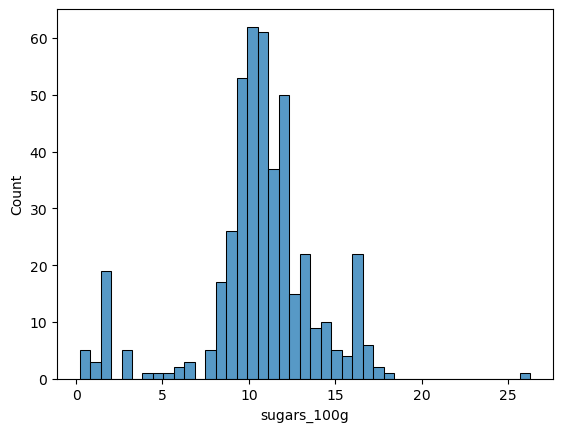

In [51]:
import seaborn as sn
sn.histplot(data=data.loc[data['main_category_fr'] == 'Jus de fruits'], x='sugars_100g')

In [52]:
# voyons les outliers :
data.loc[(data['main_category_fr'].astype('string') == 'Jus de fruits') & (data['sugars_100g'] < 4.0), 'product_name']

108414                                          Lemon Juice
170599                                               Citron
173816                                             Citrovin
174541                             Jus de citron biologique
175414                               Westcliffe Lemon Juice
186140                          Citrons fraîchement pressés
186550                                           Citron Bio
192306    Spécialité U au Jus de Citron et à l'huile ess...
192600                      Jus de citron de Sicile pur jus
198360                               100% PUR Jus De Citron
198361                                    Pur jus de citron
201857                                Pur jus de citron bio
201861                                  100% pur jus citron
204194                                    Jus de citron bio
204811                                          Eau de Coco
206794                                    Pur jus de citron
208689                     Pur jus de ci

Un beau rappel fourni ici : les jus de citrons sont peu sucrés !

In [53]:
data.loc[(data['main_category_fr'].astype('string') == 'Jus de fruits') & (data['sugars_100g'] > 25.0), 'product_name']

175514    Nono tropical
Name: product_name, dtype: object

In [54]:
data.loc[175514][33]

'- Eau de source - Jus de fruits à base de concentrés : 12% (orange 6,4%, pomme 5,5%, fruits de la passion 0,1% et mangue 0,07%) - Sucre - Arôme - Acidifiant : Acide citrique (E330)  - Antioxygène : Acide ascorbique (E300) - Colorant : Extrait de paprika (E160c)  - Stabilisant : Esters glycériques de résine de bois (E445)'

In [55]:
# pas vraiment un jus de fruit ... Dans les 'boissons' on a aussi des jus de fruits 'égarés' :
data.loc[(data['main_category_fr'].astype('string') == 'Boissons') & (data['product_name'].str[-5:] == 'Juice'), 'product_name']

533                       Aloe Vera Grape & Apple Juice
11414                                 100% Tomato Juice
12736                                     Soursop Juice
61080                     Original 100% Vegetable Juice
61090                     Original 100% Vegetable Juice
99542                               Key West Lime Juice
143311    Tas Brand Coconut Juice - Young Coconut Juice
222898                              Baobab Energy Juice
228187                                       Coco Juice
Name: product_name, dtype: object

In [60]:
# On peut corriger au moins le 11414 :
data.iloc[11414, 54] = 'Jus de fruits'

In [61]:
data.loc[(data['main_category_fr'].astype('string') == 'Boissons') & (data['product_name'].str[-5:] == 'juice'), 'product_name']

106487    Coconut water with pineapple juice
170923                           Apple juice
222899                   Baobab energy juice
228188                            coco juice
Name: product_name, dtype: object

In [62]:
data.iloc[170923, 54] = 'Jus de fruits'

In [64]:
data.loc[(data['main_category_fr'].astype('string') == 'Boissons') & (data['product_name'].str[0:3] == 'Jus'), 'product_name']

175591                                  Jus  de tomates
175962                                    Jus de gwozey
176607                               Jus d'orange Diego
180943                                    Jus de tomate
186456                               Jus de Carotte Bio
190060                               Jus De Tomate Salé
190214                           Jus de tomate salé BIO
190215                                   Jus de carotte
191550                               Jus de carotte bio
191551                  Jus de légumes salé à 6 g/litre
194737                                  Jus Carotte Bio
194911                       Jus de tomate salé à 3 g/l
196761                Jus de tomate a basé de concentré
196871                               Jus De Carotte Bio
198216                           Jus du potager Carotte
198218                                   Jus de carotte
198219                                    Jus De Tomate
201853                                  Jus de C

In [65]:
# plusieurs corrections à faire ... même si on ne considère pas la tomate comme un fruit.
data.loc[(data['main_category_fr'].astype('string') == 'Boissons') & (data['product_name'].str[0:3] == 'Pur'), 'product_name']

175056    Pur jus de clémentine, orange et raisin blanc
179846                             Pur Malt sans alcool
179866                             Pur Malt sans alcool
184017                                         Pur Malt
184102               Pur arabica des petits producteurs
192191                                Pur jus de tomate
196752                                Pur jus de tomate
201340                                  Pur Passion Bio
213887                                  Pur Jus Carotte
216798                              Pur jus de légumes 
218217                    Pur jus de tomate de Marmande
221619              Pur Jus de Tomate Bio Pleins Champs
222764                                 Pur jus de canne
230423     Pure Brewed Japanese Tea Green Tea Cranberry
235217                                    Pure Infusion
235797                              Pure Premium Tomate
Name: product_name, dtype: object

In [66]:
data.loc[(data['main_category_fr'].astype('string') == 'Jus de fruits') & (data['sugars_100g'] > 16.0) & (data['sugars_100g'] < 17.0), 'product_name']

170520                    Premium Traubensaft
180947    Le jus de raisin 100% jus de fruits
190222             100% Pur Jus Rouge Velours
209704         Récoltes Bio Jus de Raisin bio
222460            Jus de grenade 100% pur jus
222462                       Jus grenade 100%
227477                 Trauben Saft naturtrüb
228755                           Trauben Saft
Name: product_name, dtype: object

In [67]:
# trauben : raisins en allemand. Autre rappel ici : les jus de raisins sont naturellement très riche en sucres
data.loc[(data['main_category_fr'].astype('string') == 'Boissons') & (data['product_name'].str[-4:] == 'saft'), 'product_name']

227954    Bio Fenchel Direktsaft
229043               Traubensaft
229067    Bio Tomaten-Gemüsesaft
Name: product_name, dtype: object

Je ne vais pas faire les corrections qui restent, ma mission n'est pas là même si c'est nécéssaire d'avoir des bonnes données pour faire des bonnes analyses et prédictions. En tout cas nous avons pu expliquer les piques hors de la gaussienne centrale.
<a name="E15"></a>
***
<br>Etudions maintenant le taux de sodium dans les eaux :

In [19]:
data.loc[data['main_category_fr'].astype('string') == 'Eaux', 'salt_100g'].describe()

count    312.000000
mean       0.357219
std        3.071705
min        0.000000
25%        0.001651
50%        0.007747
75%        0.030000
max       50.800000
Name: salt_100g, dtype: float64

In [20]:
# Un outlier on dirait :
data.loc[(data['main_category_fr'].astype('string') == 'Eaux') & (data['salt_100g'] > 10), 'product_name']

179538    Evian - Natura Mineral Water
229492              Улеймская питьевая
Name: product_name, dtype: object

In [24]:
# une bouteille d'eau d'Evian permet de corriger le premier :
data.iloc[179538, 84] = 0.00065
data.iloc[179538, 83] = 0.00065 * 2.5

In [28]:
# pour le deuxième en l'absence d'information accessible facilement on divise par 1000, ce sera déjà plus realiste !
data.iloc[229492,83] = data.iloc[229492,83] / 1000
data.iloc[229492,84] = data.iloc[229492,84] / 1000

In [30]:
data.loc[data['main_category_fr'].astype('string') == 'Eaux', 'sodium_100g'].describe()

count    303.000000
mean       0.015828
std        0.054391
min        0.000000
25%        0.000650
50%        0.002756
75%        0.011200
max        0.515748
Name: sodium_100g, dtype: float64

<Axes: xlabel='sodium_100g', ylabel='Count'>

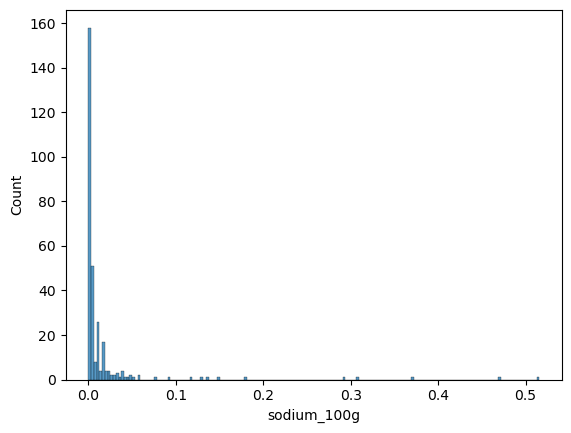

In [31]:
#import seaborn as sn
sn.histplot(data=data.loc[data['main_category_fr'] == 'Eaux'], x='sodium_100g')

<Axes: xlabel='sodium_100g', ylabel='Count'>

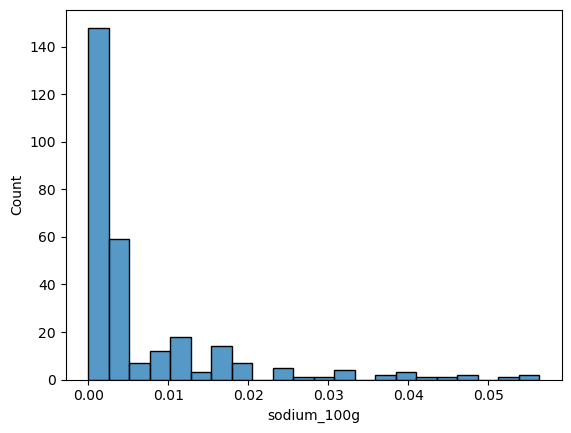

In [34]:
# en limitant aux valeurs < 0.06 :
sn.histplot(data=data.loc[(data['main_category_fr'] == 'Eaux') & (data['sodium_100g'] < 0.06)], x='sodium_100g')

On a un profil différent ??
<br> <a name="E16"></a>
<br>Une autre étude univariée qui me parait interessante est celle de la masse annoncée des éléments saisis, c'est à dire la somme (donc bien une seule variation, même si plusieurs colonnes sont impliquées). En théorie elle doit être de 100g - masse d'eau (si eau présente), mais en réalité ? Pourrait on en déduire des informations pertinentes ? D'abord quelles sont précisement les colonnes concernées ?

In [4]:
data.columns[10:50]

Index(['packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories',
       'categories_tags', 'categories_fr', 'origins', 'origins_tags',
       'manufacturing_places', 'manufacturing_places_tags', 'labels',
       'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags',
       'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores',
       'countries', 'countries_tags', 'countries_fr', 'ingredients_text',
       'allergens', 'traces', 'traces_tags', 'traces_fr', 'serving_size',
       'additives_n', 'additives', 'additives_tags', 'additives_fr',
       'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil_tags',
       'ingredients_that_may_be_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_fr',
       'pnns_groups_1', 'pnns_groups_2'],
      dtype='object')

In [5]:
data.columns[50:90]

Index(['states', 'states_tags', 'states_fr', 'main_category',
       'main_category_fr', 'image_url', 'image_small_url', 'energy_100g',
       'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g',
       'monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
       'omega-3-fat_100g', 'alpha-linolenic-acid_100g',
       'eicosapentaenoic-acid_100g', 'docosahexaenoic-acid_100g',
       'omega-6-fat_100g', 'linoleic-acid_100g', 'omega-9-fat_100g',
       'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
       'sugars_100g', 'sucrose_100g', 'glucose_100g', 'fructose_100g',
       'lactose_100g', 'starch_100g', 'polyols_100g', 'fiber_100g',
       'proteins_100g', 'casein_100g', 'salt_100g', 'sodium_100g',
       'alcohol_100g', 'vitamin-a_100g', 'beta-carotene_100g',
       'vitamin-d_100g', 'vitamin-e_100g'],
      dtype='object')

In [6]:
data.columns[90:]

Index(['vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g',
       'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g',
       'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g', 'biotin_100g',
       'pantothenic-acid_100g', 'silica_100g', 'bicarbonate_100g',
       'potassium_100g', 'chloride_100g', 'calcium_100g', 'phosphorus_100g',
       'iron_100g', 'magnesium_100g', 'zinc_100g', 'copper_100g',
       'manganese_100g', 'fluoride_100g', 'selenium_100g', 'chromium_100g',
       'iodine_100g', 'caffeine_100g', 'taurine_100g', 'ph_100g',
       'fruits-vegetables-nuts_100g', 'collagen-meat-protein-ratio_100g',
       'cocoa_100g', 'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g'],
      dtype='object')

On aurait donc : 'fat_100g' ou ['saturated-fat_100g', 'omega-3-fat_100g', 'alpha-linolenic-acid_100g', 'eicosapentaenoic-acid_100g', 'docosahexaenoic-acid_100g', 'omega-6-fat_100g', 'linoleic-acid_100g', 'omega-9-fat_100g', 'trans-fat_100g', 'cholesterol_100g'], 'carbohydrates_100g' ou ['sugars_100g', 'starch_100g'], 'polyols_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'alcohol_100g', 'caffeine_100g' en négligeant les vitamines et oligo-éléments dont la masse est infime, et bien sur en évitant de compter deux fois certaines substances qui sont dans plusieurs catégories. Calculons cette masse, que nous allons stocker dans une nouvelle colonne 'sum_100g':

In [20]:
# On va lancer cette operation déjà sur un nombre limité de lignes, pour évaluation
data['sum_100g'] = 0.0
for i in range(1000) :
    sum_100 = data.loc[i]['saturated-fat_100g'] + data.loc[i]['omega-3-fat_100g'] + data.loc[i]['alpha-linolenic-acid_100g'] + data.loc[i]['eicosapentaenoic-acid_100g'] + data.loc[i]['docosahexaenoic-acid_100g'] + data.loc[i]['omega-6-fat_100g'] + data.loc[i]['linoleic-acid_100g'] + data.loc[i]['omega-9-fat_100g'] + data.loc[i]['trans-fat_100g'] + data.loc[i]['cholesterol_100g']
    if sum_100 < data.loc[i]['fat_100g']:
        sum_100 = data.loc[i]['fat_100g']
    if data.loc[i]['carbohydrates_100g'] <= (data.loc[i]['sugars_100g'] + data.loc[i]['starch_100g']):
        sum_100 += (data.loc[i]['sugars_100g'] + data.loc[i]['starch_100g'])
    else :
        sum_100 += data.loc[i]['carbohydrates_100g']
    sum_100 += (data.loc[i]['polyols_100g'] + data.loc[i]['fiber_100g'] + data.loc[i]['proteins_100g'] + data.loc[i]['salt_100g'] + data.loc[i]['alcohol_100g'] + data.loc[i]['caffeine_100g'])
    data.iloc[i,125] = sum_100


In [21]:
data['sum_100g'].isna().count()

247208

In [18]:
data.shape

(247208, 126)

In [19]:
#data['created_t'] = pd.to_numeric(data['created_t'], errors='coerce')
data['saturated-fat_100g'].dtype

dtype('float64')

In [22]:
data['omega-3-fat_100g'].dtype

dtype('float64')

In [23]:
 data['alpha-linolenic-acid_100g'].dtype

dtype('float64')

In [24]:
data['eicosapentaenoic-acid_100g'].dtype

dtype('float64')

In [25]:
data['docosahexaenoic-acid_100g'].dtype

dtype('float64')

In [26]:
data['omega-6-fat_100g'].dtype

dtype('float64')

In [27]:
data['linoleic-acid_100g'].dtype

dtype('float64')

In [28]:
data['omega-9-fat_100g'].dtype

dtype('float64')

In [29]:
data['trans-fat_100g'].dtype

dtype('float64')

In [30]:
data['cholesterol_100g'].dtype

dtype('float64')

In [31]:
data['fat_100g'].dtype

dtype('float64')

In [32]:
data['carbohydrates_100g'].dtype

dtype('float64')

In [33]:
data['starch_100g'].dtype

dtype('float64')

In [34]:
data['polyols_100g'].dtype

dtype('float64')

In [35]:
data['alcohol_100g'].dtype

dtype('float64')

In [36]:
data['caffeine_100g'].dtype

dtype('float64')

Bon, ben on laisse tomber cette analyse qui s'avère difficile: Même si ce sont des 'floats', additionner un 'nan' donne nécéssairement un 'nan'.

In [39]:
# Essayons avec les champs valorisés seulement, par curiosité :
data['sum_100g'] = 0.0
for i in range(1000) :
    sum_100 = data.loc[i]['saturated-fat_100g'] + data.loc[i]['sugars_100g'] + data.loc[i]['fiber_100g'] + data.loc[i]['proteins_100g'] + data.loc[i]['salt_100g']
    data.iloc[i,125] = sum_100


In [40]:
data['sum_100g'][400:420]

400    56.576633
401    25.000000
402    56.576633
403    56.576633
404    42.210000
405    38.562520
406    42.210000
407    24.358312
408    79.887777
409     8.688895
410     9.810160
411     9.206400
412     6.969680
413    68.535000
414    21.013428
415     7.951840
416    16.355050
417     3.492626
418    16.355050
419    16.355050
Name: sum_100g, dtype: float64

In [45]:
# on retrouve certaines valeurs à plusieurs reprises
data.loc[~(data['sum_100g'].isna()), 'sum_100g'].value_counts()

0.000000     246213
17.853066        23
16.355050        15
82.388235        13
77.754000         9
              ...  
82.754000         1
73.660000         1
77.530480         1
85.317500         1
74.445000         1
Name: sum_100g, Length: 747, dtype: int64

<Axes: xlabel='sum_100g', ylabel='Count'>

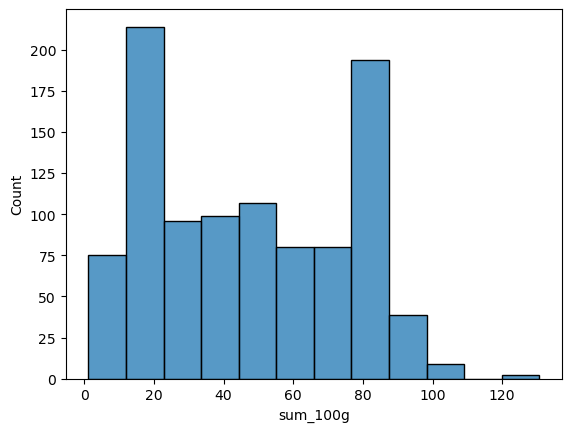

In [47]:
#import seaborn as sn
sn.histplot(data=data.loc[data['sum_100g'] > 0], x='sum_100g')

In [51]:
# a quoi correspondent les pics ?
data.loc[(data['sum_100g'] > 17.85) & (data['sum_100g'] < 17.86), 'product_name']

780                                           Baby Dills
781                        Sandwich Stuffers Kosher Dill
787                                   Kosher Dill Spears
789                                   Kosher Dill Spears
790                                         Kosher Dills
791                                    Kosher Baby Dills
792                                         Kosher Dills
793                                   Kosher Dill Spears
807                              Fresh Pack Kosher Dills
810                                          Kosher Dill
812                        Sandwich Stuffers Kosher Dill
820                Polish Dill Spears Made With Sea Salt
828      Kosher Baby Dills, Buffalo, Hot Sauced Flavored
829                                    Kosher Baby Dills
831                 Kosher Baby Dills Made With Sea Salt
842        Simply Pickles, Kosher Dill Sandwich Stuffers
850                Kosher Dill Spears Made With Sea Salt
851    Sandwich Stuffers, Koshe

In [53]:
# premier groupe ci-dessus, ce sont des dupliqués pour l'essentiel (ou la totalité ?)
data.loc[(data['sum_100g'] > 16.35) & (data['sum_100g'] < 16.36), ['product_name','main_category_fr']]

product_name main_category_fr
218                             Herbal Tea, Peppermint              NaN
219                                 Linden Flowers Tea              NaN
222                                          Green Tea              NaN
223                             Shave Grass Herbal Tea              NaN
224                       Herbal Tea, Chamomile * Mint              NaN
225                               Artichoke Herbal Tea              NaN
226                                Dieter's Herbal Tea              NaN
227                              Kidneytea, Herbal Tea              NaN
228                                          Bronchtea              NaN
416  Naturally Flavored Sparkling Mountain Spring W...              NaN
418  Coconut Pineapple Naturally Flavored Sparkling...              NaN
419  Peach Nectarine Naturally Flavored Sparkling M...              NaN
420  Lemonade, Naturally Flavored Sparkling Mountai...              NaN
421  Naturally Flavored Sparkling Mountain Spring W...              NaN
422  Naturally Flavored Sparkling Mountain Spring W...              NaN
523                      Natural Mountain Spring Water              NaN

In [54]:
data.loc[(data['sum_100g'] > 82.38) & (data['sum_100g'] < 82.39), ['product_name','main_category_fr']]

product_name main_category_fr
488              Coconut Tree Brand, Pho Ga Spice Cube              NaN
489  Coconut Tree Brand, Kho Tieu Seasoning Spice Cube              NaN
490      Coconut Tree Brand, Spice Cube Soup Sessoning              NaN
491                             Bun Mam Soup Seasoning              NaN
492  Coconut Tree Brand, Spice Cube, Hoanh Thanh So...              NaN
493                       Bo Kho Stewed Beef Seasoning              NaN
494          Coconut Tree Brand, Bun Bo Hue Spice Cube              NaN
495  Coconut Tree Brand, Vegetarian "Bo Kho" Seasoning              NaN
496  Coconut Tree Brand, Hu Tieu, Spice Cube, Veget...              NaN
498           Coconut Tree Brand, Spice Cube Seasoning              NaN
499      Coconut Tree Brand, Spice Cube Soup Seasoning              NaN
500          Coconut Tree Brand, Vegetarian Soup Cubes              NaN
501                    Crab Soup Seasoning, Spice Cube              NaN
959                          Solid Milk Chocolate Eggs              NaN

Cette somme est interessante, elle permet de caractériser assez précisement des groupes de produits, de trouver des dupliqués et d'identifier des outliers. Nous allons la calculer pour tous les produits, peut-être que nous en aurons l'utilité plus tard.

In [55]:
data['sum_100g'] = data['saturated-fat_100g'] + data['sugars_100g'] + data['fiber_100g'] + data['proteins_100g'] + data['salt_100g']

<a name="E17"></a>
<br>Nous avions analysé rapidement et expérimentalement la correlation entre taux de sucre et apport énergétique, pour les produits riches en sucres et pauvres en graisse et protéines; Voyons si une étude par régression linéaire classique peut confirmer et préciser le résultat trouvé :

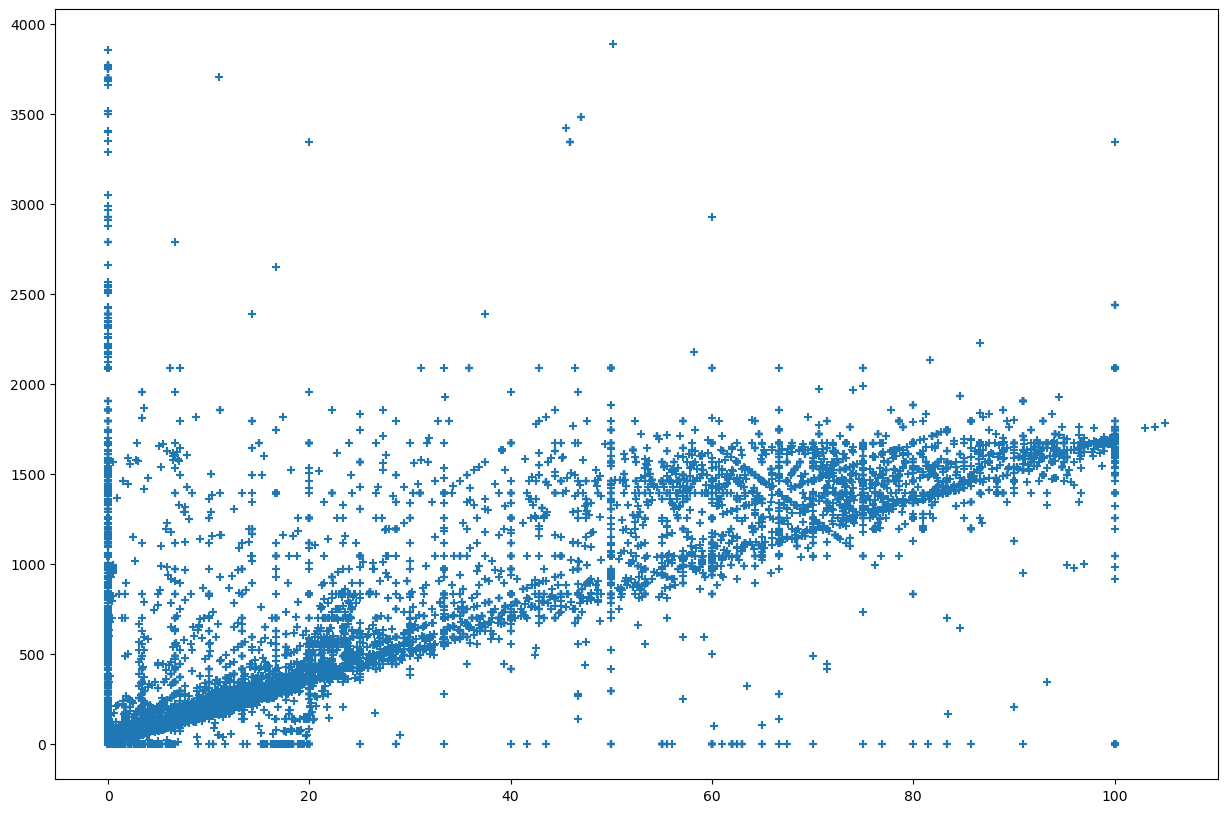

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
sug_cal = data.loc[(data['saturated-fat_100g'] < 0.1) & (data['proteins_100g'] < 0.1), ['energy_100g','sugars_100g']]
plt.scatter(sug_cal['sugars_100g'],sug_cal['energy_100g'],marker='+')
plt.show()

In [73]:
# nous observons plusieurs belles lignes, qui donnent envie de les comprendre ...
import statsmodels.api as sm

Y = sug_cal['energy_100g']
X = sug_cal[['sugars_100g']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
a,b = result.params['sugars_100g'],result.params['intercept']

In [77]:
print("a: " + str(a) + "  b: " + str(b))  # les valeurs qui vont nous permettre de tracer la droite de regression :

a: 15.16099822267946  b: 232.670352022821


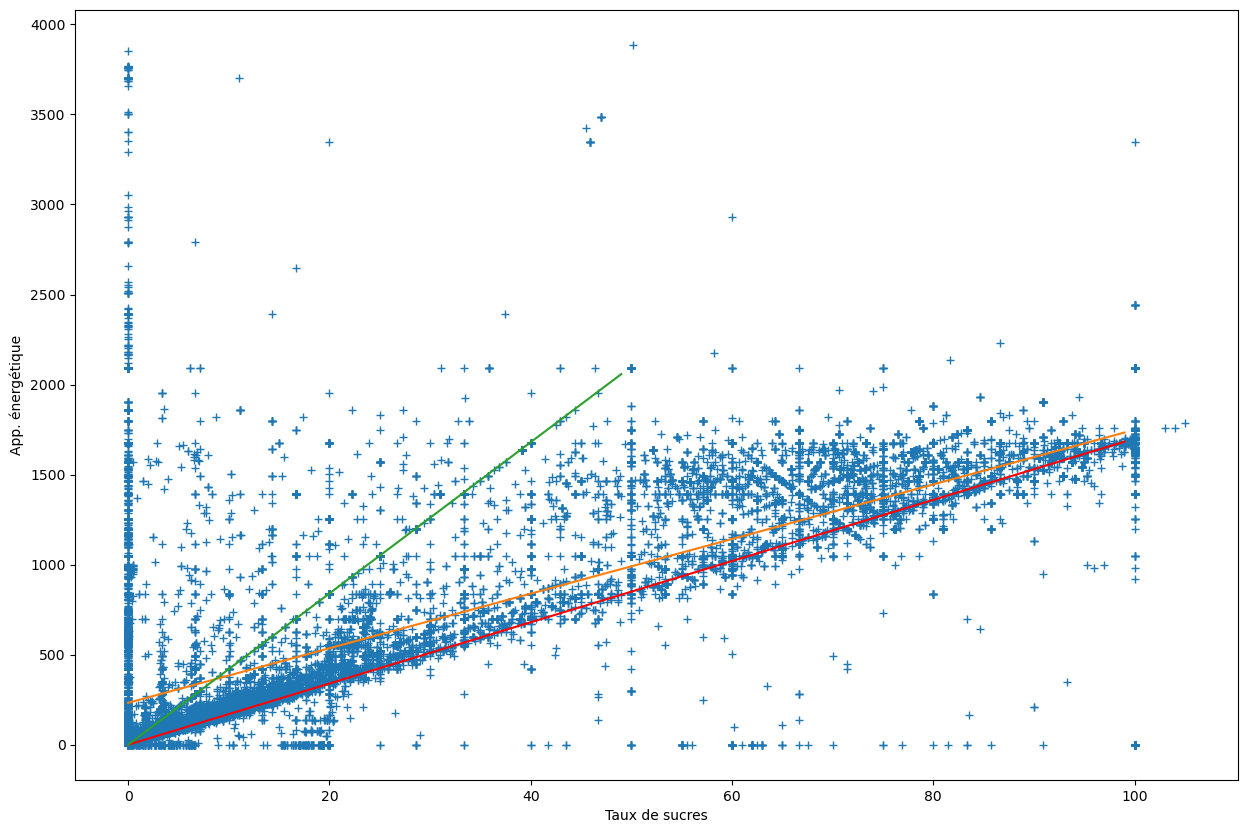

In [82]:
# Nous avions évalué a à 17, ce qui parait un peu plus juste pour représenter les produits qui ont au moins un léger taux de sucre.
plt.figure(figsize=(15,10))
plt.plot(sug_cal['sugars_100g'],sug_cal['energy_100g'], "+")
plt.plot(np.arange(100),[a*x+b for x in np.arange(100)])      # <--droite de regression
plt.plot(np.arange(100),[17*x for x in np.arange(100)], color='r') # droite initialement estimée
plt.plot(np.arange(50),[42*x for x in np.arange(50)])         # <-- droite à expliquer
plt.ylabel("App. énergétique")
plt.xlabel("Taux de sucres")
plt.show()

In [84]:
# ligne verte : peut on savoir à quels produits elle correspond ?
ind_list = sug_cal.loc[round(sug_cal['energy_100g'] / sug_cal['sugars_100g']) == 42,['energy_100g','sugars_100g']].index

In [86]:
for i in ind_list[0:25] :
    print(data.iloc[i,7])

Fajitas Seasoning Mix
Muchacha, Salsa, Mild
Muchacha, Medium Salsa
Muchacho, Hot Salsa, Hot
Creamy Ranch
Red Salsa
Curious George, Fruit Flavored Snacks
Fruit Flavored Snacks
Fruit Flavored Snacks
Peanuts, Fruit Flavored Snacks
Drink Mix Contains Coconut Water Concentrate, Pineapple Coconut
Coffee Creamer, Original
Coffee Creamer, Original
Crushed Tomatoes With Basil In Heavy Puree
Tomato Sauce
Tomato Sauce
Whole Green Chillies
Select, Marsala Cooking Wine
Assorted Fruit Snakcs
Whole Mix Fruit
Ranch Dressing
Raspberry Vinaigrette Dressing, Light
Curious George, Fruit Flavored Snacks
Au Jus Gravy Mix
Seasoning Mix, Taco


In [88]:
for i in ind_list[30:50] :
    print(data.iloc[i,7])

Salsa, Fresh Vegetable, Mild
Fresh Vegetable Salsa, Medium
Fruit Flavored Snacks
Decorating Rainbow Jimmies
Rosy Red Decorating Sprinkles
Decorating Glam Green Sprinkles
Trick Ot Treat Jimmies
Tomato Sauce
Preserves, Strawberry
Chop House Steak Sauce
Texas Style Bbq Sauce
Rizutti, Russian Mustard
Extra Hot Mustard
Organic Santa Maria Grill Cooking Seasoning
White Pearl Onions
Sloppy Joe Seasoning Mix
Au Jus Gravy Mix
Spaghetti Sauce Mix
Taco Seasoning Mix
Thousand Island Traditional, New York Style Dressing


La ligne verte correspond principalement à des sauces, dont sans doute le taux de sucre varie linéairement avec celui d'autres apports énergétiques, selon l'épaisseur désirée, ce qui expliquerais la ligne observée. Etudions une autre ligne visible :

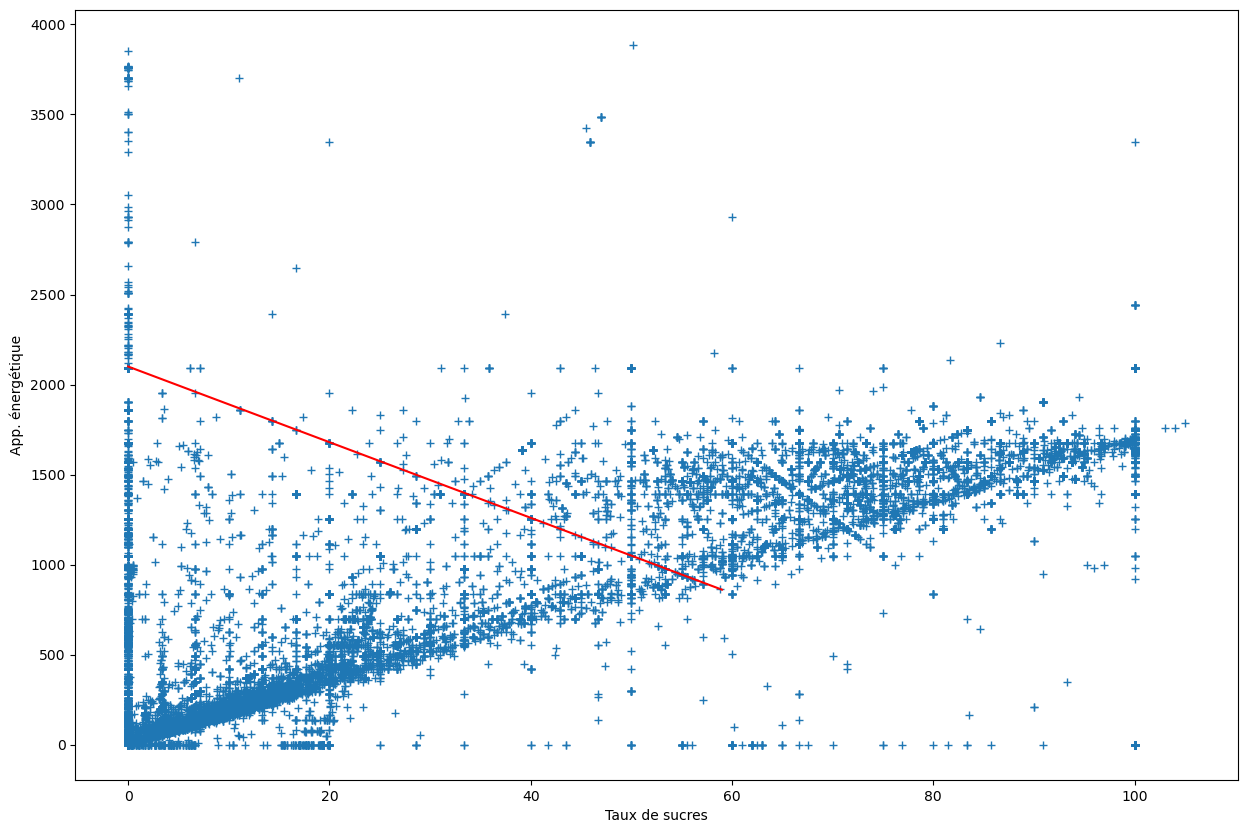

In [105]:
plt.figure(figsize=(15,10))
plt.plot(sug_cal['sugars_100g'],sug_cal['energy_100g'], "+")
plt.plot(np.arange(60),[2100 - 21*x for x in np.arange(60)], color='r')
plt.ylabel("App. énergétique")
plt.xlabel("Taux de sucres")
plt.show()

In [106]:
ind_list = sug_cal.loc[round((2100 - sug_cal['energy_100g']) / sug_cal['sugars_100g']) == 21,['energy_100g','sugars_100g']].index

In [107]:
len(ind_list)

384

In [108]:
for i in ind_list[0:30] :
    print(data.iloc[i,7])

Zero Calorie Sweetener
Stevia Extract Blend*
Zero Calorie Sweetener With Aspartame
Guacamole Dip Mix
Kimchi Furikake, Rice Seasoning
Au Jus Gravy Mix
Seasoning Mix, Taco
Sauce Mix With Natural Spices
Seasoning Mix, Meat Loaf
Marmalade, Orange
Sweet Lime Pickle
Zero Calorie Sweetener
Steakhouse Sauce & Marinade
Balsamic Vinegar
Taco Seasoning Mix
Sucralose
Aroy-D, Sweetened Chilli Sauce For Spring Roll
Aroy-D, Sweetened Chili Sauce
America's Original Cherry Butter
Butter, Jalapeno Cherry
Strawberry Preserves
Grape Jelly
Strawberry Jelly
Fischer Wieser, Organic Chipotle Sauce, Pomegranate & Mango
Premium Water Enhancer
Real Tea
Kitchens, Sucralose Zero Calorie Sweetener Blend
Spaghetti Sauce Mix
Meat Loaf Seasoning
Glaze With Balsamic Vinegar Of Modena


In [109]:
for i in ind_list[30:50] :
    print(data.iloc[i,7])

Sauce Mix, Spaghetti
Seasoning Mix, Taco
Adolph's, Prime Cut, Pork Marinade Mix
Sloppy Joes Spices And Seasoning
Mother's Choice, Spanish Chicken Rice Mix
Gum Balls
Candy Store, Gumballs
Sita's, Caldereta Spicy Sauce Mix
Tomato Jam
Honey And Butter Flavored Topping
Smoky Horseradish Sauce
Horseradish Sauce
Horseradish Sauce
Seasoning
Zero Calorie Sweetener Sucralose
Concord Grape Jelly
Seedless Strawberry Jam
Stevia Zero Calorie Sweetener
Gumball Machine With Gumballs
Gumballs


Avec la ligne rouge ci-dessus on est plus dans les marmelades / gelées plus ou moins allégées parmis lesquelles on a aussi des sauces, pas très facile à interpréter. D'autres lignes sont interessantes, mais on a d'autres études à réaliser ...

In [110]:
# covariance de notre regression :
np.cov(sug_cal['sugars_100g'],sug_cal['energy_100g'],ddof=0)[1,0]

16728.0626840705

In [111]:
# Coef. de Pearson ('R'):
import scipy.stats as st
st.pearsonr(sug_cal['sugars_100g'],sug_cal['energy_100g'])[0]

0.7767979289163646

Cela nous donne 0.6 pour 'R²' ce qui est plus proche de 1 que de 0 : la droite représente plutôt bien les données. Mais si on ne travaillait que sur les produits ayant plus de 1% de sucre (mais très peu de graisse saturée et protèines) la correlation serait bien meilleure. <a name="E18"></a>
<br>
<br>Nous allons maintenant examiner le taux de sucre par catégorie. Enfin, pour seulement 10 catégories (parmis les plus représentées). Comme le nombre de produits catégorisés est limité, ce sera une étude juste sur un échantillon de l'ensemble des produits enregistrés de la catégorie.

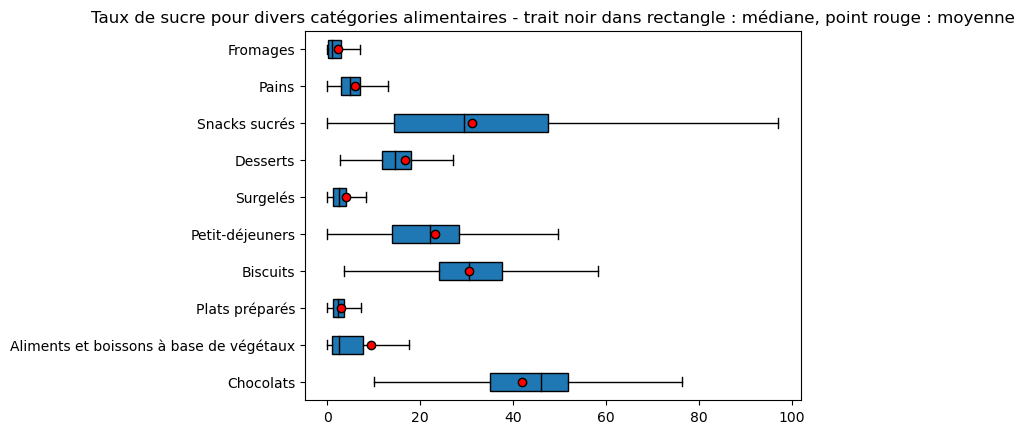

In [21]:
import matplotlib.pyplot as plt
categories = ['Chocolats','Aliments et boissons à base de végétaux','Plats préparés','Biscuits','Petit-déjeuners','Surgelés','Desserts','Snacks sucrés','Pains','Fromages']

taux_suc_prod_categ = []
for cat in categories:
    taux_suc_prod_categ.append(data.loc[data['main_category_fr'] == cat]['sugars_100g'])
        
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'red'}
  
plt.boxplot(taux_suc_prod_categ, labels=categories, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title('Taux de sucre pour divers catégories alimentaires - trait noir dans rectangle : médiane, point rouge : moyenne')
plt.show()

Il y a une grande disparité entre les catégories, néanmoins la corrélation avec le taux de sucre semble très faible, vérifions par le calcul du rapport de corrélation :

In [27]:
taux_suc_moyen = data['sugars_100g'].mean()
categ = []
for cat in categories:
    categ_i = data['sugars_100g'][data['main_category_fr'] == cat]  # significations ?? équivalent à :
    categ.append({'ni': len(categ_i),                                 # data.loc[data['main_category_fr'] == cat, 'sugars_100g']
                    'moyenne_categ': categ_i.mean()})

SCT = sum([(suc - taux_suc_moyen)**2 for suc in data['sugars_100g']])
SCE = sum([cat['ni']*(cat['moyenne_categ'] - taux_suc_moyen)**2 for cat in categ])
SCE/SCT

0.027915205755215854

On a bien un rapport tout petit, indication d'une correlation quasi inexistante, comme nous l'avions déjà remarqué avant d'ailleurs : difficile d'identifier une catégorie gràce au taux de sucre !
<br>Voyons s'il existe une corrélation plus forte avec le nouveau champ 'sum_100g' :

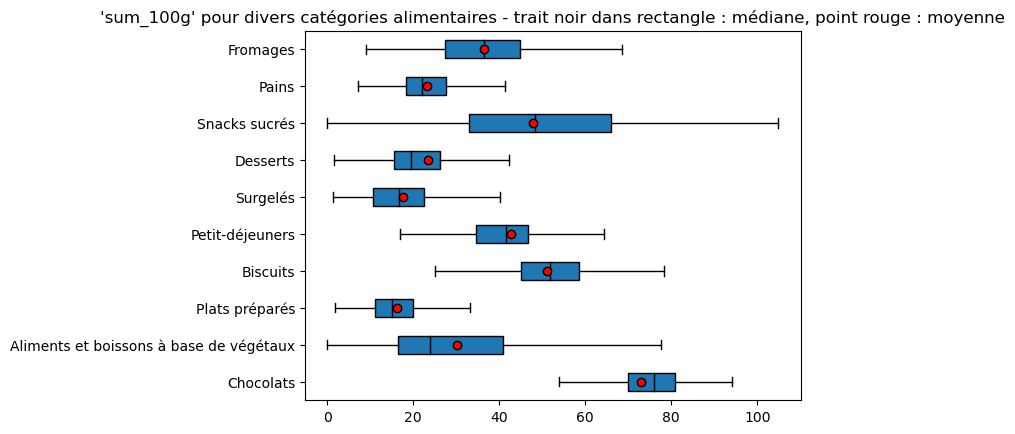

In [3]:
import matplotlib.pyplot as plt
categories = ['Chocolats','Aliments et boissons à base de végétaux','Plats préparés','Biscuits','Petit-déjeuners','Surgelés','Desserts','Snacks sucrés','Pains','Fromages']

sum_100_prod_categ = []
for cat in categories:
    sum_100_prod_categ.append(data.loc[data['main_category_fr'] == cat]['sum_100g'])
        
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'red'}
  
plt.boxplot(sum_100_prod_categ, labels=categories, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title('\'sum_100g\' pour divers catégories alimentaires - trait noir dans rectangle : médiane, point rouge : moyenne')
plt.show()

In [4]:
# la corrélation semble un peu plus élevée, mais pas bien grande toutefois, calculons pour confirmer :
sum_100_moyen = data['sum_100g'].mean()
categ = []
for cat in categories:
    categ_i = data['sum_100g'][data['main_category_fr'] == cat]
    categ.append({'ni': len(categ_i),  
                    'moyenne_categ': categ_i.mean()})

SCT = sum([(s - sum_100_moyen)**2 for s in data['sum_100g']])
SCE = sum([cat['ni']*(cat['moyenne_categ'] - sum_100_moyen)**2 for cat in categ])
SCE/SCT

0.03881571389342466

<a name="E19"></a>
<br>Nous allons maintenant étudier la correlation de ces catégories avec le 'nutrigrade', le niveau A-B-C-D-E de qualité nutritionnelle dérivé du nutriscore. Il s'agit d'une analyse de deux variables qualitatives.

In [9]:
data['nutrition_grade_fr'].isna().mean()

0.1575879421377949

In [6]:
data['nutrition_grade_fr'].describe()

count     208251
unique         5
top            d
freq       59212
Name: nutrition_grade_fr, dtype: object

In [10]:
import seaborn as sns
cat_grade = data.loc[data['main_category_fr'].isin(categories), ['main_category_fr','nutrition_grade_fr']]
tab_cont = cat_grade[['nutrition_grade_fr','main_category_fr']].pivot_table(index = 'nutrition_grade_fr', columns = 'main_category_fr', aggfunc=len, margins = True, margins_name = "Total")

In [15]:
tab_cont

main_category_fr    Aliments et boissons à base de végétaux  Biscuits  \
nutrition_grade_fr                                                      
a                                                     921.0      16.0   
b                                                     182.0      14.0   
c                                                     245.0      95.0   
d                                                     193.0     493.0   
e                                                     113.0     941.0   
Total                                                1654.0    1559.0   

main_category_fr    Chocolats  Desserts  Fromages   Pains  Petit-déjeuners  \
nutrition_grade_fr                                                           
a                         NaN     641.0      86.0   393.0            260.0   
b                         NaN     133.0      43.0   308.0            110.0   
c                         6.0     396.0     165.0   344.0            556.0   
d                       258.0     190.0     802.0   156.0            499.0   
e                      1505.0      61.0      73.0    22.0             65.0   
Total                  1769.0    1421.0    1169.0  1223.0           1490.0   

main_category_fr    Plats préparés  Snacks sucrés  Surgelés  Total  
nutrition_grade_fr                                                  
a                            365.0           14.0     493.0   3189  
b                            482.0          117.0     291.0   1680  
c                            532.0          170.0     373.0   2882  
d                            229.0          542.0     251.0   3613  
e                             17.0          421.0      19.0   3237  
Total                       1625.0         1264.0    1427.0  14601

In [16]:
tab_cont = tab_cont.fillna(0)

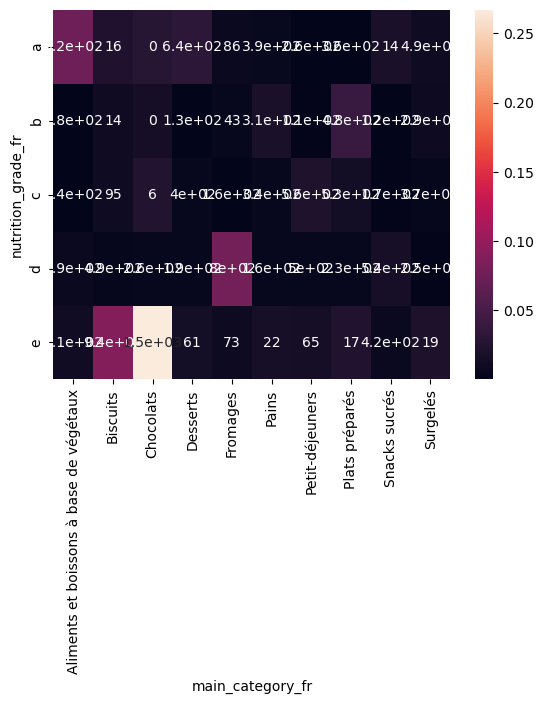

In [19]:
tx = tab_cont.loc[:,["Total"]]
ty = tab_cont.loc[["Total"],:]
n = len(cat_grade)
indep = tx.dot(ty) / n  

measure = (tab_cont-indep)**2/indep 
xi_n = measure.sum().sum()
table = measure/xi_n          # Ramener les 'measure' entre 0 et 1 pour étalonner la couleur
sns.heatmap(table.iloc[:-1,:-1], annot = tab_cont.iloc[:-1,:-1])
plt.show()

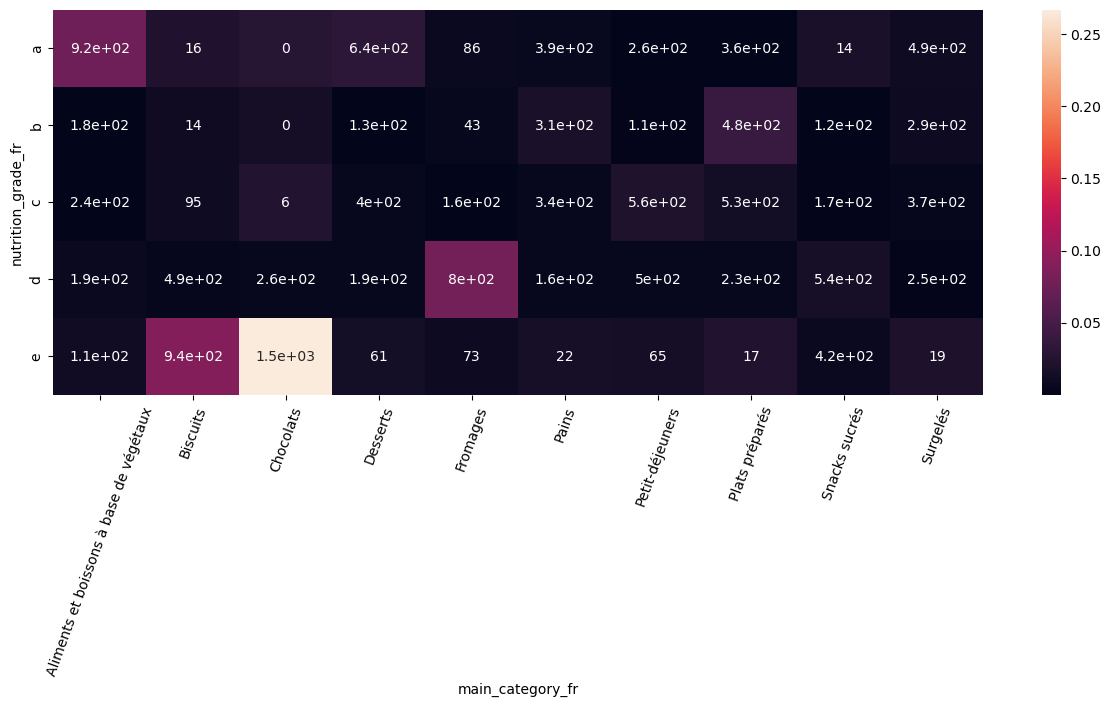

In [22]:
# En mieux :
plt.figure(figsize=(15,5))
sns.heatmap(table.iloc[:-1,:-1], annot = tab_cont.iloc[:-1,:-1])
plt.xticks(rotation=70)
plt.show()

Dans chaque cellule on a le rappel du nombre de produits concernés, et la couleur (avec l'échelle à droite) indique à quel point le nutrigrade caractérise la catégorie : plus elle est claire, plus il y a de dépendance entre la catégorie et le nutrigrade, c'est pourquoi les chocolats, riches en sucres et graisses ont pour la plupart un nutrigrade de E alors que les "aliments à base de végétaux" (pas clair, c'est aussi le cas du chocolat) ont en grande partie un nutrigrade de A.
<br>A priori, on devrait avoir plus de correlation entre le nutrigrade et le taux de sucre ?

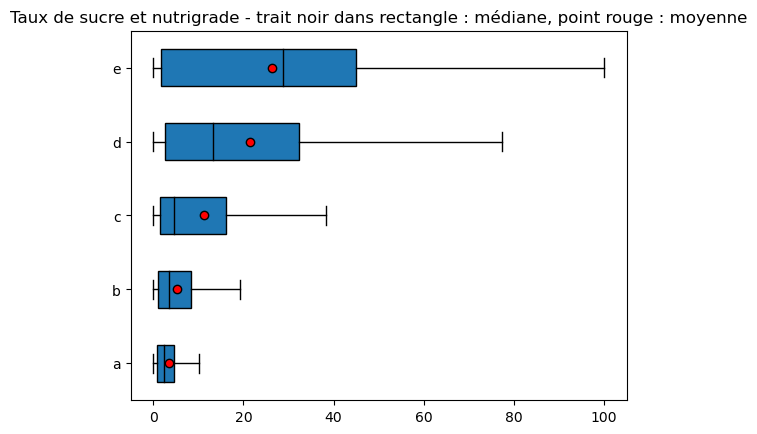

In [23]:
suc_grad = []
for grad in ['a','b','c','d','e']:
    suc_grad.append(data.loc[data['nutrition_grade_fr'] == grad]['sugars_100g'])
        
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'red'}
  
plt.boxplot(suc_grad, labels=['a','b','c','d','e'], showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title('Taux de sucre et nutrigrade - trait noir dans rectangle : médiane, point rouge : moyenne')
plt.show()

Les groupes sont bien caractérisés par les moyennes, médianes et maximums des taux de sucre, mais pas par les minimums. Calculons le rapport de corrélation:

In [24]:
taux_suc_moyen = data['sugars_100g'].mean()
grps = []
for grad in ['a','b','c','d','e'] :
    grp_i = data['sugars_100g'][data['nutrition_grade_fr'] == grad]
    grps.append({'ni': len(grp_i),  
                    'moyenne groupe': grp_i.mean()})

SCT = sum([(s - taux_suc_moyen)**2 for s in data['sugars_100g']])
SCE = sum([gr['ni']*(gr['moyenne groupe'] - taux_suc_moyen)**2 for gr in grps])
SCE/SCT

0.1514737725535735

<a name="E20"></a>
Nous avons cherché des corrélations basées surtout sur des connaissances basiques de diététique (le sucre apporte de l'énergie, les protéïnes des constituants cellulaires ...) et des catégories alimentaires, avec un succès mitigé. Essayons maintenant une approche plus scientifique (i.e. science des données). Nous allons commencer par un cas relativement simple, pour une première évaluation : la catégorie 'Biscuits', en utilisant les dimensions numériques renseignées : 'energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g' (donc sans le nutriscore pour le moment).

In [4]:
data.loc[data['main_category_fr'] == 'Biscuits', 'product_name'][0:25]

9532                                 Mini Crêpes ChocoLait
12935                     milk chocolate rich tea biscuits
13010                                Brins de ChocoCaramel
34913                Pure Butter Chocolate Chip Shortbread
34939    Biscuits à l'avoine aux myrtilles et à la vanille
34940                               Fruit Crumble Biscuits
55606                                   Belvita Golden Oat
55608                                          Newtons Fig
65249                          Bouchées Coffee Crisp Bites
65289                                Biscuits au gingembre
65334                                Fine milled oatcakes 
65672     Célébration biscuits a la crème feuille d'érable
65675                                  Leclerc Célébration
66016    Style de vie Peek Freans chocolat noir rehauss...
66068    BelVita Petit-déjeuner Avoine aux bananes et c...
66093              All butter Scottish shortbread fingers 
78388                                              Z'ani

In [5]:
data.loc[data['main_category_fr'] == 'Biscuits', 'product_name'].describe()

count                1611
unique               1479
top       Langues de chat
freq                    7
Name: product_name, dtype: object

In [6]:
data.loc[data['main_category_fr'] == 'Biscuits', 'nutrition-score-fr_100g'].describe()

count    1615.000000
mean       18.634056
std         5.961292
min        -5.000000
25%        15.000000
50%        20.000000
75%        23.000000
max        31.000000
Name: nutrition-score-fr_100g, dtype: float64

In [7]:
data.loc[data['main_category_fr'] == 'Biscuits'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1615 entries, 9532 to 247164
Columns: 126 entries, code to sum_100g
dtypes: float64(73), int64(2), object(51)
memory usage: 1.6+ MB


In [5]:
# il y a donc des produits sans nom, vérifions les :
fields = ['brands','brands_tags','labels','labels_tags','labels_fr','ingredients_text','pnns_groups_1','pnns_groups_2']
data.loc[(data['main_category_fr'] == 'Biscuits') & (data['product_name'].isna()), fields]

brands            brands_tags  \
170234  MULINO BIANCO,BARILLA  mulino-bianco,barilla   
185833        Casino,Vitalité        casino,vitalite   
191736                    NaN                    NaN   
207046                    NaN                    NaN   

                                   labels  \
170234                                NaN   
185833                Sans huile de palme   
191736  Huile de palme durable,Point Vert   
207046                                NaN   

                                 labels_tags  \
170234                                   NaN   
185833                      en:palm-oil-free   
191736  en:green-dot,en:sustainable-palm-oil   
207046                                   NaN   

                                labels_fr  \
170234                                NaN   
185833                Sans huile de palme   
191736  Point Vert,Huile de palme durable   
207046                                NaN   

                                         ingredients_text  pnns_groups_1  \
170234                                                NaN  Sugary snacks   
185833                                                NaN  Sugary snacks   
191736  Céréales 51,8% (farine de _blé_ 50,8% et farin...  Sugary snacks   
207046                                                NaN  Sugary snacks   

             pnns_groups_2  
170234  Biscuits and cakes  
185833  Biscuits and cakes  
191736  Biscuits and cakes  
207046  Biscuits and cakes

In [10]:
# Ce sont bien des biscuits; Voyons 'sur les bords' s'il n'y a pas quelques outliers :
data.loc[(data['main_category_fr'] == 'Biscuits') & (data['nutrition-score-fr_100g'] > 28), 'product_name']

183365       Tartelettes Chocolat Caramel
205053           Gaufres fourrage au miel
209048     Les Cookies de la Mère Poulard
209074                  Palets pur beurre
210319    Crêpe Dentelle Chocolat au lait
Name: product_name, dtype: object

In [11]:
data.loc[(data['main_category_fr'] == 'Biscuits') & (data['nutrition-score-fr_100g'] < -2), 'product_name']

186596    Biscuit de son d'avoine saveur miel Gayelord H...
186607                    Biscuits de Son d'Avoine au Cacao
202380                  Les Craquelins de Saint Malo Nature
202381               Le Craquelins de Saint Malo Gout Sucré
202386        Mini Malo Nature Les Craquelins de Saint Malo
202387    Mini Malo graines de lin Les Craquelins de Sai...
207542              Biscuit nature et bienfaits blé raisins
207545    Biscuit Nature et Bienfaits - Épeautre et abri...
207546    Biscuits Nature & Bienfaits - 100% Végétal - S...
Name: product_name, dtype: object

In [12]:
# parfait, nous définissons donc notre DF :
df = data.loc[data['main_category_fr'] == 'Biscuits', ['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g']]

In [13]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns

df.duplicated().sum() # pas vérifié avant, mais il n'est pas trop tard

86

In [21]:
# on revient vérifier dans 'la base' :
ind_list = df.duplicated().index
for ind in ind_list[0:25]:
    print(str(ind))
    print(data.loc[ind][['product_name','brands','ingredients_text','energy_100g','saturated-fat_100g','sugars_100g','fiber_100g']])


9532
product_name                                      Mini Crêpes ChocoLait
brands                                                            Bijou
ingredients_text      Chocolat au lait 45% (sucre, beurre de cacao, ...
energy_100g                                                      2018.0
saturated-fat_100g                                                 11.0
sugars_100g                                                        48.0
fiber_100g                                                          1.7
Name: 9532, dtype: object
12935
product_name                           milk chocolate rich tea biscuits
brands                                       Sainsbury's,by sainsbury's
ingredients_text      Fortified Wheat Flour (_Wheat_ Flour, Calcium ...
energy_100g                                                      2034.0
saturated-fat_100g                                                 10.3
sugars_100g                                                        31.3
fiber_100g                 

Il ne s'agit que de dupliqués dans notre DF d'étude, ce qui est compréhensible puisque les produits sont similaires, mais dans data les produits sont différents.

In [22]:
dftab = df.values

In [23]:
type(dftab)

numpy.ndarray

In [24]:
scaler = StandardScaler()
tab_scaled = scaler.fit_transform(dftab)

In [25]:
pca = PCA(n_components=6)
pca.fit(tab_scaled)

PCA(n_components=6)

In [26]:
pca.explained_variance_ratio_

array([0.33670117, 0.28460735, 0.16323533, 0.0991191 , 0.07177102,
       0.04456602])

In [27]:
# visualisons "l'éboulis des valeurs propres" :
valp = (pca.explained_variance_ratio_*100).round(2)
valp_cum = valp.cumsum().round()

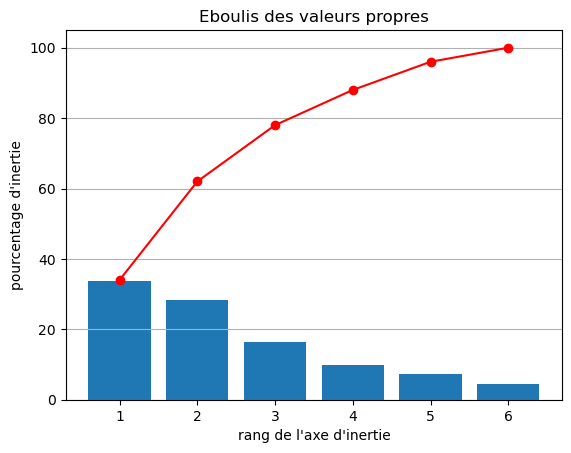

In [29]:
plt.bar([1, 2, 3, 4, 5, 6], valp)
plt.plot([1, 2, 3, 4, 5, 6], valp_cum, c="red", marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.grid(axis='y')
plt.show(block=False)

On voit ici que près de 80% de la variance est comprise dans les 3 premières composantes.
<br>Voyons comment sont définies ces composantes sur les dimensions d'origine :

In [30]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = ['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g']
pcs.index = ['F1','F2','F3','F4','F5','F6']
pcs.round(2)

energy_100g  saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  \
F1        -0.33               -0.42        -0.43        0.51           0.47   
F2         0.57                0.53        -0.42        0.07           0.25   
F3        -0.32               -0.13        -0.14       -0.47          -0.28   
F4         0.06               -0.08         0.51       -0.36           0.75   
F5         0.02                0.13         0.60        0.62          -0.20   
F6        -0.68                0.71        -0.01        0.01           0.17   

    salt_100g  
F1       0.20  
F2       0.39  
F3       0.75  
F4       0.16  
F5       0.46  
F6      -0.10

In [31]:
# On peut visualiser plus directement cette décomposition avec une 'heat map', sur la base du tableau 'tourné' :
pcs.T

F1        F2        F3        F4        F5        F6
energy_100g        -0.334149  0.567988 -0.315641  0.061247  0.023298 -0.679567
saturated-fat_100g -0.419113  0.532189 -0.129371 -0.082006  0.128138  0.707982
sugars_100g        -0.425992 -0.421088 -0.141571  0.514860  0.596654 -0.009871
fiber_100g          0.513896  0.069201 -0.471816 -0.360529  0.615113  0.012893
proteins_100g       0.474848  0.250762 -0.275730  0.754436 -0.197697  0.165388
salt_100g           0.204081  0.386237  0.751635  0.159025  0.457815 -0.096614

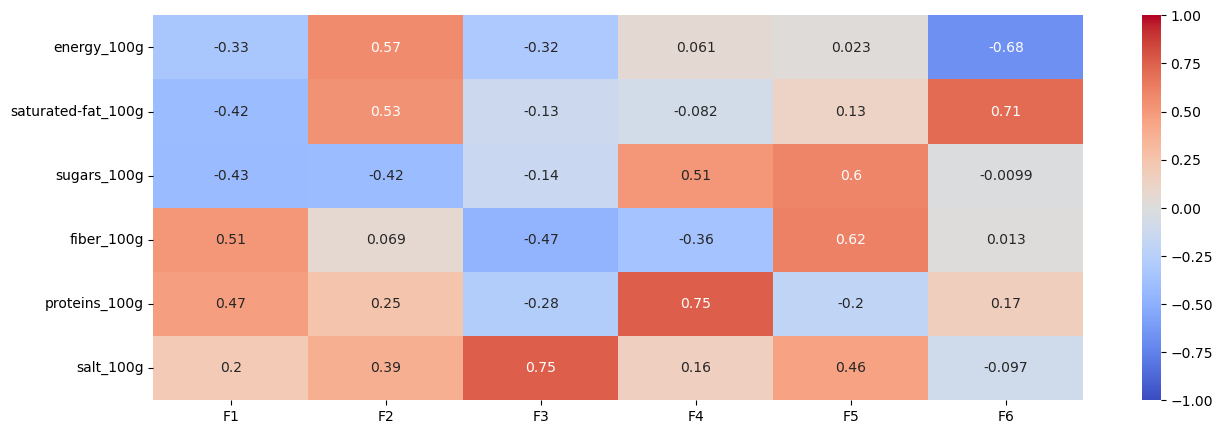

In [32]:
plt.figure(figsize=(15,5))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm")
plt.show()

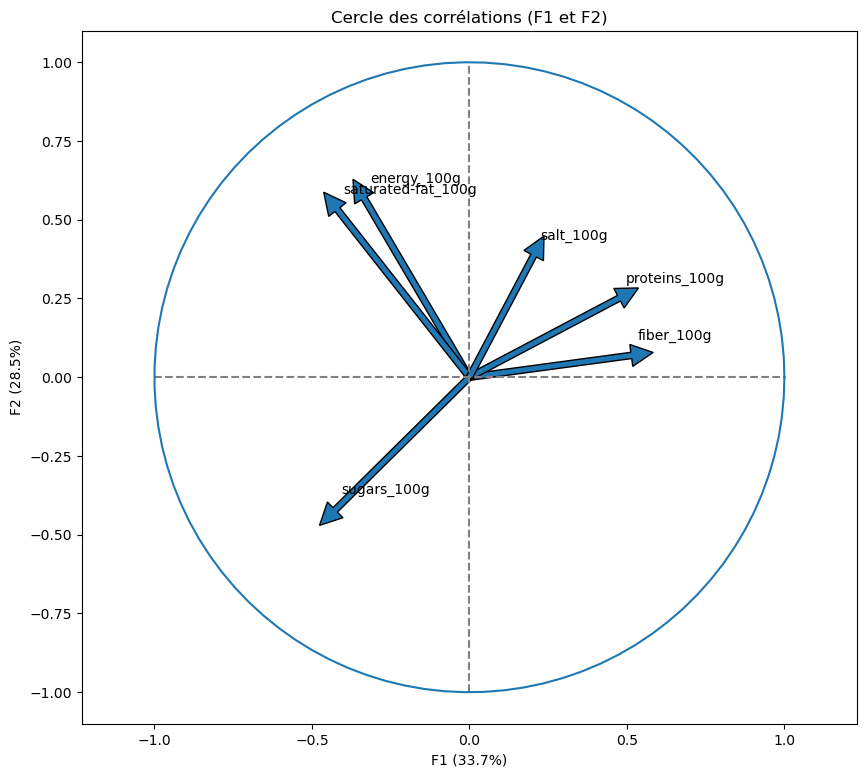

In [37]:
# graphe des corrélations pour les deux premières composantes principales ('0' et '1'):
dim = ['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g']
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(6):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  # 0 for CP1
             pca.components_[1, i],  # 1 for CP2
             head_width = 0.07,
             head_length= 0.07,
             width = 0.02, )

    plt.text(pca.components_[0, i] + 0.02,
             pca.components_[1, i] + 0.05,
             dim[i])

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(1, 2))

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

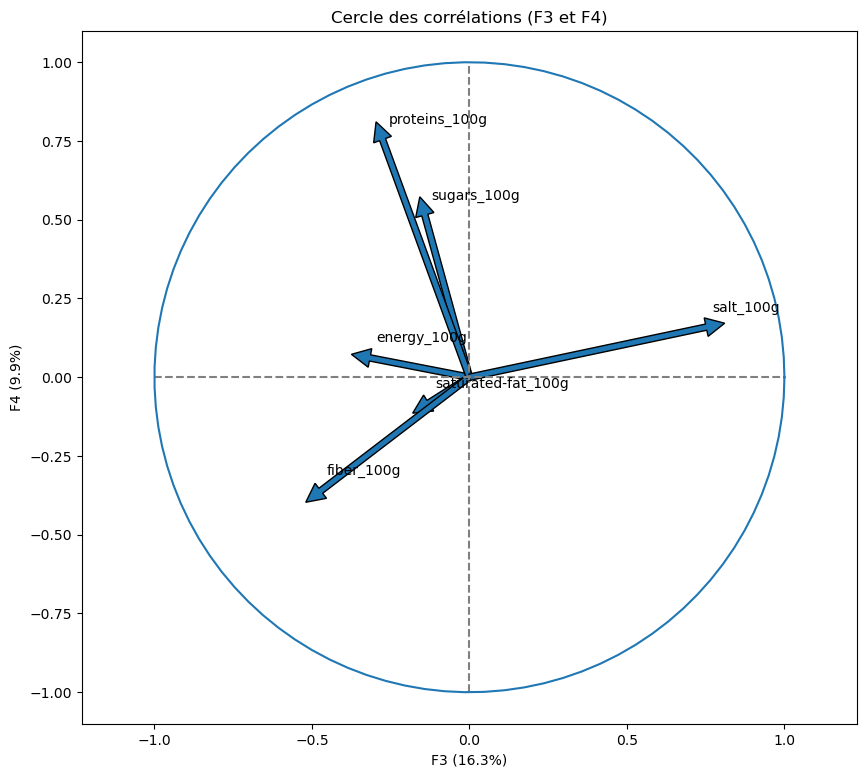

In [39]:
# pour le deuxième plan factoriel (F3,F4) :
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(6):
    ax.arrow(0, 0,
             pca.components_[2, i],  # 2 for CP3
             pca.components_[3, i],  # 3 for CP4
             head_width = 0.06, head_length= 0.06, width = 0.02, )

    plt.text(pca.components_[2, i] + 0.02,
             pca.components_[3, i] + 0.05,
             dim[i])

plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

plt.xlabel('F{} ({}%)'.format(3, round(100*pca.explained_variance_ratio_[2],1)))
plt.ylabel('F{} ({}%)'.format(4, round(100*pca.explained_variance_ratio_[3],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(3, 4))

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))
plt.axis('equal')
plt.show(block=False)

Sur ce deuxième plan, on note que le taux de protéines est bien représenté par la CP F4, et le sel, encore mieux, par la CP F3. C'était déjà bien visible sur la 'heat map'. Sur cette dernière on voit aussi que l'apport énergétique et en graisses sat. sont le mieux représentés par la sixième CP ("anti corrélation" pour l'énergie). Observons maintenant la projection des individus sur les plans factoriels :

In [40]:
df_proj = pca.transform(tab_scaled)

In [92]:
# nous reprenons la fonction du TP :
def display_factorial_planes(   X_projected,
                                x_y,
                                pca=None,
                                labels = None,
                                clusters=None,
                                alpha=1,
                                figsize=[10,8],
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments :
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments :
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8]
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """
    
    X_ = np.array(X_projected) # Transforme X_projected en np.array

    if not figsize:            # On définit les dimensions de la figure, si elle n'ont pas été données
        figsize = (7,6)

    if  labels is None :       # On gère les labels
        labels = []
    try :
        len(labels)
    except Exception as e :
        raise e

    if not len(x_y) ==2 :      # On vérifie la variable 'axis'
        raise AttributeError("2 axes sont demandées")
    if max(x_y )>= X_.shape[1] :
        raise AttributeError("la variable axis n'est pas bonne")

    x, y = x_y                 # on définit x et y

    fig, ax = plt.subplots(1, 1, figsize=figsize)    # Initialisation de la figure

    c = None if clusters is None else clusters       # On vérifie s'il y a des clusters ou non

    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca :
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else :
        v1=v2= ''

    ax.set_xlabel(f'F{x+1} {v1}')       # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_ylabel(f'F{y+1} {v2}')

    x_max = np.abs(X_[:, x]).max() *1.1   # Valeur x max et y max ...
    y_max = np.abs(X_[:, y]).max() *1.1

    ax.set_xlim(left=-x_max, right=x_max)   # ... pour borner x et y
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    if len(labels) :                        # Affichage des labels des points si donnés
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y + 0.05, labels[i], fontsize='14', ha='center',va='center')

    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")  # Titre et display
    plt.show()


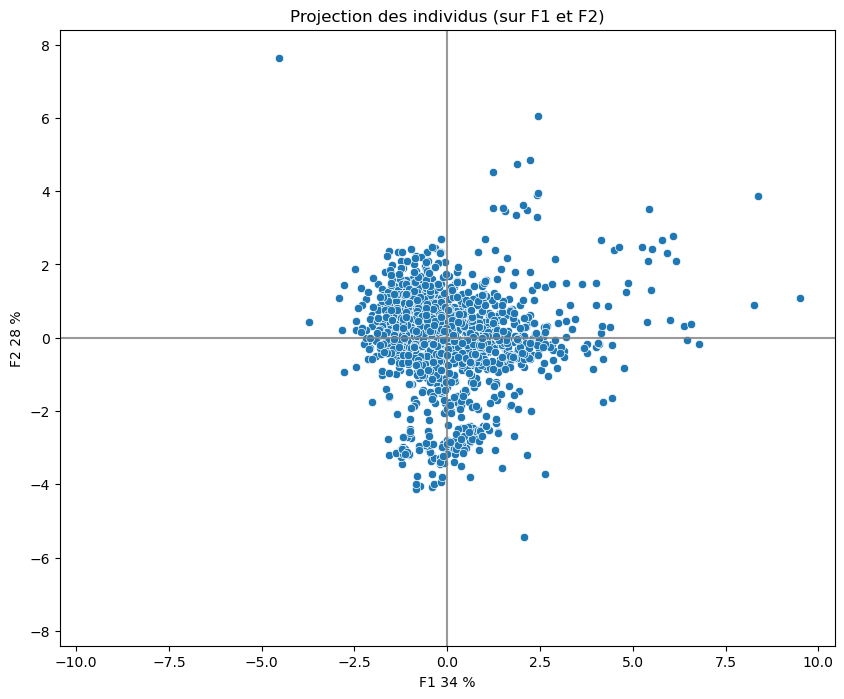

In [44]:
display_factorial_planes(df_proj, [0,1], pca=pca)

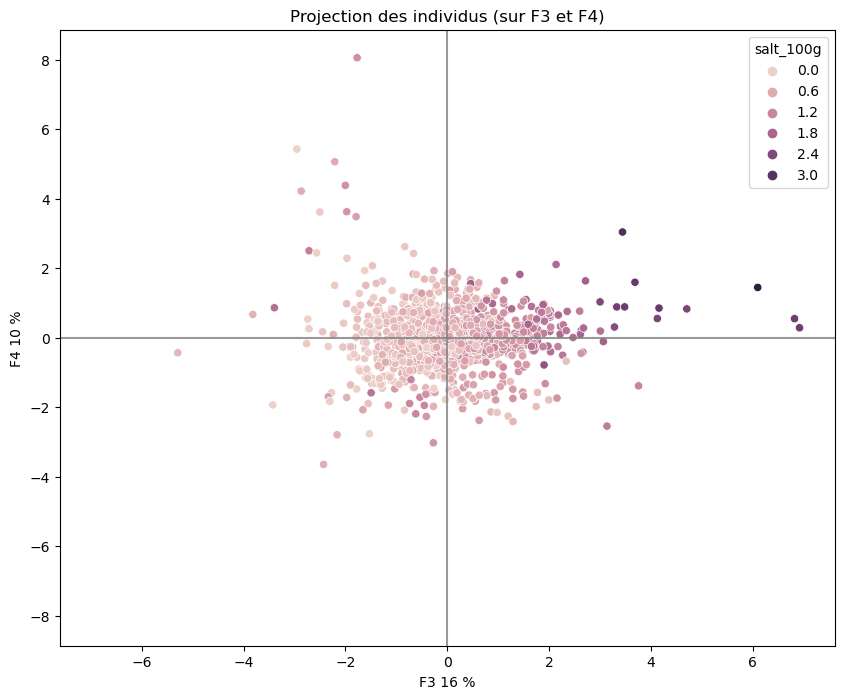

In [46]:
display_factorial_planes(df_proj, [2,3], pca=pca, clusters=df['salt_100g'])

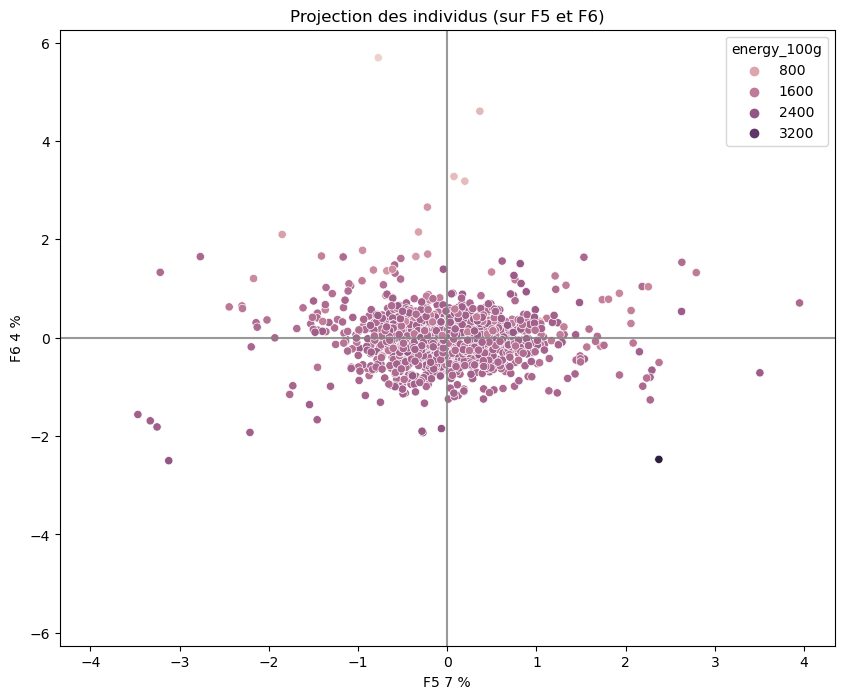

In [47]:
display_factorial_planes(df_proj, [4,5], pca=pca, clusters=df['energy_100g'])

Reprenons le même travail mais cette fois avec le nutriscore, et peut être aussi l'élimination / correction de quelques outliers qui apparaissent dans nos projections :

In [3]:
data.loc[data['main_category_fr'] == 'Biscuits'][['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g']].describe()

energy_100g  saturated-fat_100g  sugars_100g   fiber_100g  \
count  1615.000000         1615.000000  1615.000000  1615.000000   
mean   1975.042268           10.172236    30.493124     3.001453   
std     226.648642            5.424590    11.752069     2.248792   
min      63.000000            0.000000     0.000000     0.000000   
25%    1889.000000            6.000000    24.000000     1.672000   
50%    2030.000000           11.000000    30.400000     2.500000   
75%    2114.000000           14.200000    37.700000     3.800000   
max    3925.000000           35.500000    74.000000    24.000000   

       proteins_100g    salt_100g  
count    1615.000000  1615.000000  
mean        6.749160     0.621231  
std         2.142327     0.398285  
min         0.900000     0.000000  
25%         5.600000     0.364500  
50%         6.500000     0.558800  
75%         7.500000     0.780000  
max        30.000000     3.556000

In [6]:
data.loc[(data['main_category_fr'] == 'Biscuits') & (data['energy_100g'] > 3000), fields]

brands    brands_tags  \
209074  Georges Blanc  georges-blanc   

                                                   labels  \
209074  Incorrect data on label, Incorrect nutrition f...   

                                              labels_tags  \
209074  en:incorrect-data-on-label,en:incorrect-nutrit...   

                                                labels_fr  \
209074  Informations incorrectes sur l'emballage,Infor...   

                                         ingredients_text  pnns_groups_1  \
209074  Farine de _blé_, beurre frais de baratte (_lai...  Sugary snacks   

             pnns_groups_2  
209074  Biscuits and cakes

In [7]:
data.iloc[209074,7]

'Palets pur beurre'

In [8]:
# nous allons supprimer ce produit mentionné comme incorrectement saisi. Autres outliers ?
data.loc[(data['main_category_fr'] == 'Biscuits') & (data['saturated-fat_100g'] > 30), fields]

brands    brands_tags  \
209074  Georges Blanc  georges-blanc   

                                                   labels  \
209074  Incorrect data on label, Incorrect nutrition f...   

                                              labels_tags  \
209074  en:incorrect-data-on-label,en:incorrect-nutrit...   

                                                labels_fr  \
209074  Informations incorrectes sur l'emballage,Infor...   

                                         ingredients_text  pnns_groups_1  \
209074  Farine de _blé_, beurre frais de baratte (_lai...  Sugary snacks   

             pnns_groups_2  
209074  Biscuits and cakes

In [10]:
# le même, mais encore ?
data.loc[(data['main_category_fr'] == 'Biscuits') & (data['sugars_100g'] > 60), fields]

brands              brands_tags  \
170734                 Italiamo                 italiamo   
189612                 Chabrior                 chabrior   
207907           Maison Fossier           maison-fossier   
207908           Maison Fossier           maison-fossier   
209066          La Mère Poulard          la-mere-poulard   
221896  Biscuiterie de Bretagne  biscuiterie-de-bretagne   

                       labels               labels_tags  \
170734                    NaN                       NaN   
189612                    NaN                       NaN   
207907  Entrepreneurs engagés  fr:entrepreneurs-engages   
207908                    NaN                       NaN   
209066                    NaN                       NaN   
221896            Sans beurre            fr:sans-beurre   

                    labels_fr  \
170734                    NaN   
189612                    NaN   
207907  Entrepreneurs-engages   
207908                    NaN   
209066                    NaN   
221896            Sans-beurre   

                                         ingredients_text  pnns_groups_1  \
170734  Sucre, 20% noyaux d'abricots, blanc d'_oeuf_ d...  Sugary snacks   
189612                                                NaN  Sugary snacks   
207907  Sucre, biscuit rose (sucre, farine de _blé_, _...  Sugary snacks   
207908  Sucre, biscuit rose (sucre, farine de _blé_, _...  Sugary snacks   
209066  Farine de _froment_ (France), _beurre_ (23%), ...  Sugary snacks   
221896  Sucre 52%, _noisettes_, farine de _blé_, blanc...  Sugary snacks   

             pnns_groups_2  
170734  Biscuits and cakes  
189612  Biscuits and cakes  
207907  Biscuits and cakes  
207908  Biscuits and cakes  
209066  Biscuits and cakes  
221896  Biscuits and cakes

In [11]:
# le taux de sucre ne correspond pas à la liste des ingredients... Il semble y avoir un doublon, vérifions :
data.iloc[207907,7]

'Le Véritable Macaron à la Framboise'

In [12]:
data.iloc[207908,7]

'Macarons Amandes'

In [13]:
# on va laisser les erreurs remarquées, on ne peux pas tout corriger !
data.loc[(data['main_category_fr'] == 'Biscuits') & (data['salt_100g'] > 3), fields]

brands       brands_tags labels labels_tags labels_fr  \
232197  Thomas J Fudge's  thomas-j-fudge-s    NaN         NaN       NaN   
235241               365               365    NaN         NaN       NaN   

                                         ingredients_text  pnns_groups_1  \
232197  Cream, wheat flour, farmhouse cheddar 35%, who...  Sugary snacks   
235241  farine de blé (gluten), sucre, huile végétale ...  Sugary snacks   

             pnns_groups_2  
232197  Biscuits and cakes  
235241  Biscuits and cakes

In [14]:
data.loc[235241]['ingredients_text']

"farine de blé (gluten), sucre, huile végétale et graisse végétale hydrogénée, dextrose, lait condensé, chocolat, miel, oeufs, farine de riz, fructose, amidon de pomme de terre, émulsifiant: lécithine de soja, farine de soja, arôme, sel, poudres à lever: carbonate acide d'ammonium et carbonate acide de sodium, agent de traitement de la farine: disulfate de sodium (sulfites)"

In [15]:
# pour ce dernier, le taux de sel est incorrect, on le met à la moyenne :
data.iloc[235241,83] = 0.62
data.iloc[235241,84] = (0.62 / 2.5)

In [16]:
# et suppression de l'outlier majeur :
data = data.drop(index=209074, axis=0)

In [17]:
df = data.loc[data['main_category_fr'] == 'Biscuits', ['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

In [18]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
dftab = df.values
scaler = StandardScaler()
tab_scaled = scaler.fit_transform(dftab)

In [21]:
pca = PCA(n_components=7)
pca.fit(tab_scaled)

PCA(n_components=7)

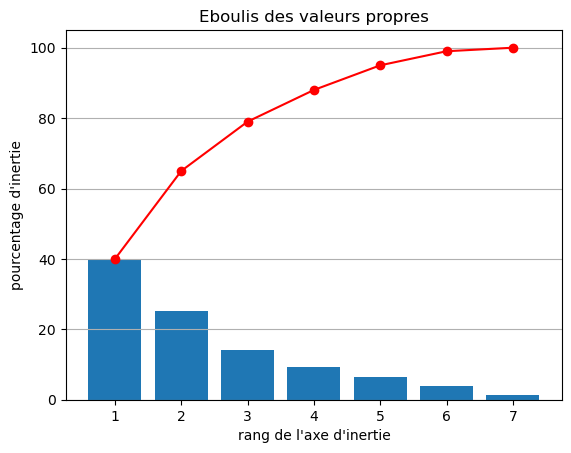

In [22]:
valp = (pca.explained_variance_ratio_*100).round(2)
valp_cum = valp.cumsum().round()
plt.bar([1, 2, 3, 4, 5, 6, 7], valp)
plt.plot([1, 2, 3, 4, 5, 6, 7], valp_cum, c="red", marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.grid(axis='y')
plt.show(block=False)

In [23]:
# La première CP est plus representative que precedement !
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = ['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']
pcs.index = ['F1','F2','F3','F4','F5','F6','F7']
pcs.round(2)

energy_100g  saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  \
F1        -0.39               -0.47        -0.26        0.41           0.29   
F2         0.39                0.33        -0.54        0.24           0.41   
F3        -0.41               -0.22        -0.10       -0.40          -0.19   
F4        -0.06               -0.15         0.54       -0.10           0.78   
F5        -0.10                0.11         0.43        0.75          -0.29   
F6        -0.71                0.62        -0.15        0.01           0.15   
F7         0.10                0.44         0.37       -0.19           0.02   

    salt_100g  nutrition-score-fr_100g  
F1      -0.00                    -0.56  
F2       0.46                     0.09  
F3       0.75                     0.13  
F4       0.10                     0.25  
F5       0.34                     0.18  
F6      -0.20                     0.13  
F7       0.26                    -0.74

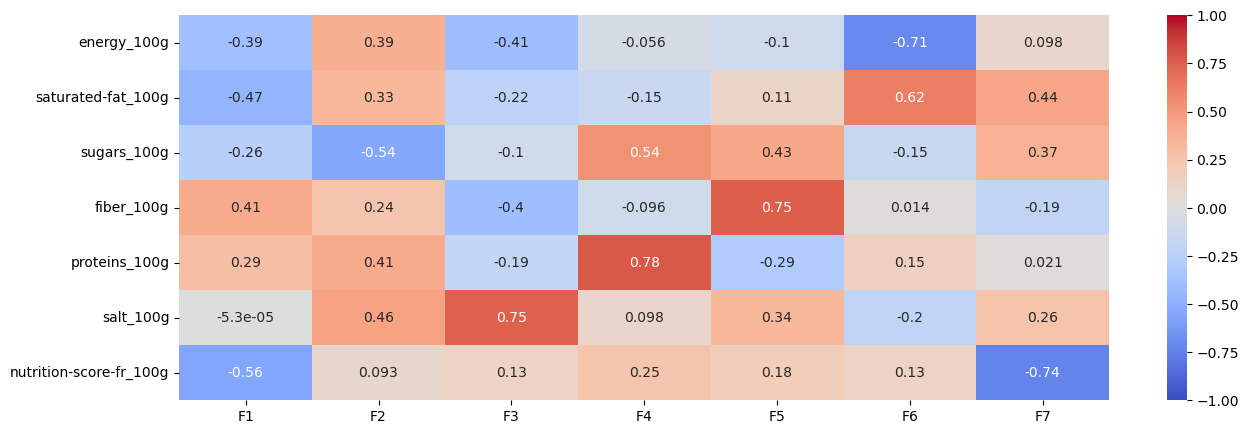

In [24]:
plt.figure(figsize=(15,5))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm")
plt.show()

L'apport énergétique est maintenant mieux représenté par la sixième composante (et moins par la seconde), les fibres par la cinquième, les protéines par la quatrième et le sel par la troisième. Le petit nettoyage effectué et la prise en compte d'une nouvelle dimension (nutriscore) ont eu un impact important. C'est un peu dommage d'avoir realisé ces deux changements en même temps, cela masque leurs impacts respectifs. Aussi, nous allons refaire l'étude précédente juste pour voir l'impact du nettoyage :

In [25]:
df = data.loc[data['main_category_fr'] == 'Biscuits', ['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g']]
dftab = df.values
tab_scaled = scaler.fit_transform(dftab)
pca = PCA(n_components=6)
pca.fit(tab_scaled)

PCA(n_components=6)

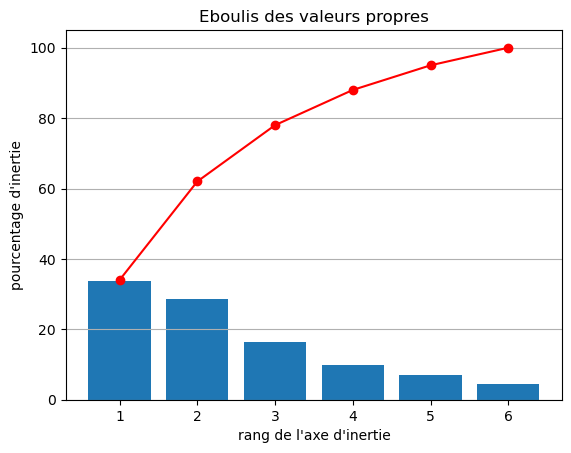

In [26]:
valp = (pca.explained_variance_ratio_*100).round(2)
valp_cum = valp.cumsum().round()
plt.bar([1, 2, 3, 4, 5, 6], valp)
plt.plot([1, 2, 3, 4, 5, 6], valp_cum, c="red", marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.grid(axis='y')
plt.show(block=False)

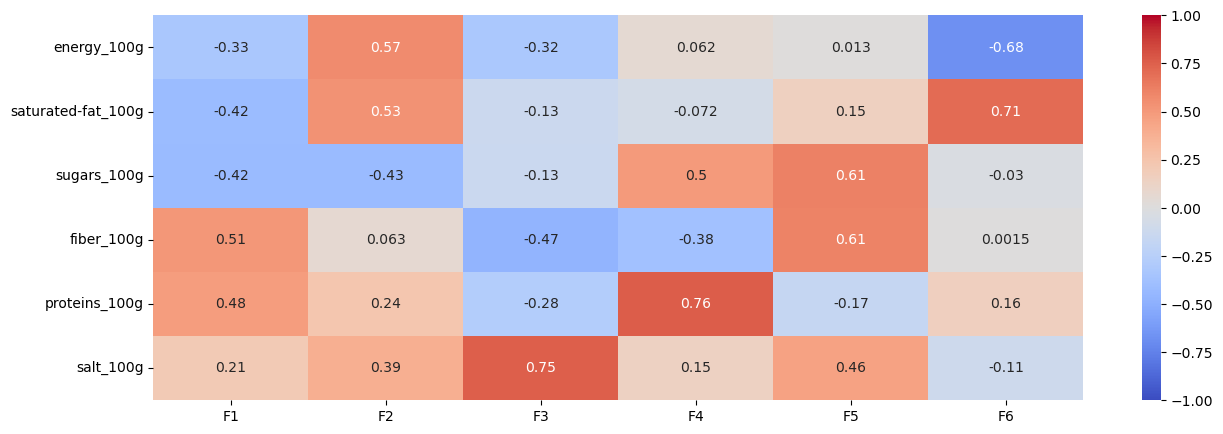

In [27]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = ['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g']
pcs.index = ['F1','F2','F3','F4','F5','F6']
pcs.round(2)
plt.figure(figsize=(15,5))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm")
plt.show()

Maintenant c'est plus clair : l'impact du nettoyage a été faible, celui de la nouvelle dimension important.
<br>Cette étude n'est pas très éclairante sur la catégorie 'biscuits', mais nous indique quand même que la majorité des produits forme un groupe assez dense autour des valeurs moyennes. En principe un autre groupe assez différent devrait avoir aussi cette caractéristique, avec des moyennes différentes, et donc on devrait pouvoir distinguer des clusters. Vérifions le avec ces trois catégories : Gâteaux, Fromages et Pâtes alimentaires.

In [29]:
data.loc[data['main_category_fr'] == 'Gâteaux', ['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']].describe()

energy_100g  saturated-fat_100g  sugars_100g  fiber_100g  \
count   977.000000          977.000000   977.000000  977.000000   
mean   1687.294941            7.323542    30.368501    2.075160   
std     352.455084            5.439466     8.836527    2.154414   
min     104.000000            0.000000     0.000000    0.000000   
25%    1600.000000            2.500000    26.000000    1.137000   
50%    1795.000000            5.800000    30.000000    1.900000   
75%    1895.000000           11.700000    35.000000    2.657000   
max    2544.000000           24.000000    64.000000   53.800000   

       proteins_100g   salt_100g  nutrition-score-fr_100g  
count     977.000000  977.000000               977.000000  
mean        5.657809    0.671946                16.862845  
std         2.294923    1.358092                 5.553911  
min         0.000000    0.000000                -5.000000  
25%         4.700000    0.330000                14.000000  
50%         5.500000    0.584200                17.000000  
75%         6.200000    0.880000                21.000000  
max        45.000000   41.000000                31.000000

In [30]:
data.loc[data['main_category_fr'] == 'Fromages', ['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']].describe()

energy_100g  saturated-fat_100g  sugars_100g   fiber_100g  \
count  1290.000000         1290.000000  1290.000000  1290.000000   
mean   1138.205495           13.889610     2.228155     1.666186   
std     421.884950            6.925297     3.524619     1.598633   
min     136.000000            0.000000     0.000000     0.000000   
25%     929.250000            8.750000     0.100000     0.000000   
50%    1199.500000           15.900000     0.900000     1.628000   
75%    1454.750000           18.700000     3.000000     2.724500   
max    3912.000000           36.000000    28.000000    24.000000   

       proteins_100g    salt_100g  nutrition-score-fr_100g  
count    1290.000000  1290.000000              1290.000000  
mean       17.042600     1.497484                11.820155  
std         7.615338     0.900610                 6.205573  
min         1.500000     0.000000                -5.000000  
25%        10.800000     0.992500                 9.000000  
50%        17.000000     1.500000                14.000000  
75%        23.000000     1.900000                16.000000  
max        49.000000     6.300000                22.000000

In [31]:
data.loc[data['main_category_fr'] == 'Pâtes alimentaires', ['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']].describe()

energy_100g  saturated-fat_100g  sugars_100g   fiber_100g  \
count  1084.000000         1084.000000  1084.000000  1084.000000   
mean   1310.153413            1.385544     3.694258     3.451833   
std     345.089207            1.896982     3.281648     1.843340   
min     140.000000            0.000000     0.000000     0.000000   
25%    1150.000000            0.300000     2.000000     2.423000   
50%    1489.000000            0.400000     3.000000     3.226105   
75%    1525.000000            1.525000     3.700000     3.988404   
max    3770.000000           14.800000    24.543223    19.700000   

       proteins_100g    salt_100g  nutrition-score-fr_100g  
count    1084.000000  1084.000000              1084.000000  
mean       10.989735     0.448948                -0.719557  
std         3.192130     0.639760                 5.915592  
min         1.100000     0.000000                -9.000000  
25%        10.000000     0.012700                -5.000000  
50%        12.000000     0.050000                -3.000000  
75%        12.900000     0.900000                 3.000000  
max        41.600000     5.638800                21.000000

In [32]:
# cherchons d'éventuels outliers :
data.loc[(data['main_category_fr'] == 'Gâteaux') & (data['energy_100g'] > 2500), fields]

brands brands_tags               labels       labels_tags  \
192861      U           u  Sans huile de palme  en:palm-oil-free   

                  labels_fr ingredients_text  pnns_groups_1  \
192861  Sans huile de palme              NaN  Sugary snacks   

             pnns_groups_2  
192861  Biscuits and cakes

In [33]:
data.iloc[192861,7]

'Brownie à partager! Pépites de chocolat'

In [35]:
data.loc[192861][['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

energy_100g                2544.0
saturated-fat_100g            2.6
sugars_100g                  13.2
fiber_100g                    1.2
proteins_100g                 2.2
salt_100g                   0.161
nutrition-score-fr_100g      10.0
Name: 192861, dtype: object

In [36]:
# c'est plausible; Pour les graisses sat. :
data.loc[(data['main_category_fr'] == 'Gâteaux') & (data['saturated-fat_100g'] > 20), fields]

brands     brands_tags  \
169448            Lidl            lidl   
170715          Sondey          sondey   
183433     Bonne Maman     bonne-maman   
191474         Serebis         serebis   
191843               U               u   
195295     Ker Cadélac     ker-cadelac   
196608        Franprix        franprix   
207193  Les Renardises  les-renardises   
213157       Carrefour       carrefour   

                                                   labels  \
169448                                                NaN   
170715                                                NaN   
183433                                                NaN   
191474                                                NaN   
191843                                                NaN   
195295            Produit en Bretagne,Sans huile de palme   
196608                                                NaN   
207193  Sans matière grasse hydrogénée,Sans conservate...   
213157                                                NaN   

                                              labels_tags  \
169448                                                NaN   
170715                                                NaN   
183433                                                NaN   
191474                                                NaN   
191843                                                NaN   
195295           en:palm-oil-free,en:produced-in-bretagne   
196608                                                NaN   
207193  en:no-preservatives,en:no-hydrogenated-fats,en...   
213157                                                NaN   

                                                labels_fr  \
169448                                                NaN   
170715                                                NaN   
183433                                                NaN   
191474                                                NaN   
191843                                                NaN   
195295            Sans huile de palme,Produit en Bretagne   
196608                                                NaN   
207193  Sans conservateurs,Sans matière grasse hydrogé...   
213157                                                NaN   

                                         ingredients_text  pnns_groups_1  \
169448  Sucre, 17% chocolat noir (pâte de cacao, sucre...  Sugary snacks   
170715  sucre, noix de coco 35%, protéines d'_oeuf_, s...  Sugary snacks   
183433  Sucre, blancs d'_oeufs_, _beurre_ frais, noix ...  Sugary snacks   
191474  34% coco, sucre, sirop de glucose-fructose, fa...  Sugary snacks   
191843  huile de palme, huile palmiste huile de coco, ...  Sugary snacks   
195295  Farine de _blé_, huile végétale de colza, _oeu...  Sugary snacks   
196608  Chocolat 41% (sucre, pâte de cacao, beurre de ...  Sugary snacks   
207193  Noix de coco 31%, sucre, sirop de glucose, bla...  Sugary snacks   
213157                                                NaN  Sugary snacks   

             pnns_groups_2  
169448  Biscuits and cakes  
170715  Biscuits and cakes  
183433  Biscuits and cakes  
191474  Biscuits and cakes  
191843  Biscuits and cakes  
195295  Biscuits and cakes  
196608  Biscuits and cakes  
207193  Biscuits and cakes  
213157  Biscuits and cakes

In [37]:
data.loc[(data['main_category_fr'] == 'Gâteaux') & (data['sugars_100g'] > 55), fields]

brands                  brands_tags      labels  \
188662                     Chabrior                     chabrior         NaN   
194192                         Cora                         cora         NaN   
195920                     Franprix                     franprix         NaN   
211821                    Carrefour                    carrefour  Point Vert   
214710  Tablier Blanc,Marque Repère  tablier-blanc,marque-repere         NaN   
231231                   Mr Kipling                   mr-kipling  Vegetarian   

          labels_tags   labels_fr  \
188662            NaN         NaN   
194192            NaN         NaN   
195920            NaN         NaN   
211821   en:green-dot  Point Vert   
214710            NaN         NaN   
231231  en:vegetarian  Végétarien   

                                         ingredients_text  pnns_groups_1  \
188662                                                NaN  Sugary snacks   
194192                                                NaN  Sugary snacks   
195920                                                NaN  Sugary snacks   
211821  Chocolat en poudre 39% (sucre, cacao en poudre...  Sugary snacks   
214710  Chocolat en poudre 64% (sucre, cacao en poudre...  Sugary snacks   
231231  Icing sugar, sugar, water, _wheat_ flour (with...  Sugary snacks   

             pnns_groups_2  
188662  Biscuits and cakes  
194192  Biscuits and cakes  
195920  Biscuits and cakes  
211821  Biscuits and cakes  
214710  Biscuits and cakes  
231231  Biscuits and cakes

In [39]:
data.loc[(data['main_category_fr'] == 'Gâteaux') & (data['fiber_100g'] > 40), fields]

brands      brands_tags labels labels_tags labels_fr  \
186522  Gayelord Hauser  gayelord-hauser    NaN         NaN       NaN   

                                         ingredients_text  pnns_groups_1  \
186522  Sirop de fructo-oligosaccharides, gomme d’acac...  Sugary snacks   

             pnns_groups_2  
186522  Biscuits and cakes

In [40]:
data.loc[(data['main_category_fr'] == 'Gâteaux') & (data['proteins_100g'] > 40), fields]

brands             brands_tags labels labels_tags  \
109306  Les gâteaux d'Honorine  les-gateaux-d-honorine    NaN         NaN   

       labels_fr                                   ingredients_text  \
109306       NaN  _Crème_ UHT (_Lait_ stabilisant : E470), prépa...   

        pnns_groups_1       pnns_groups_2  
109306  Sugary snacks  Biscuits and cakes

In [43]:
data.loc[109306]['ingredients_text']

"_Crème_ UHT (_Lait_ stabilisant : E470), préparation pour mousse (eau, graisse végétale hydrogénée d'huile de palme, sucre, émulsifiants : E471, E472b, lécithine de _soja_, stabilisants : E420(i), E401, caséinate de sodium (_Lait_), sel, arôme, correcteurs d’acidité : E340ii, E331iii), chocolat de couverture de couleur foncée 15,48% (pâte de cacao, sucre, beurre de cacao, émulsifiant : lécithine de _soja_), crème anglaise [_lait_ écrémé, sucre _crème_ (_lait_), amidon modifié, jaune d’_œuf_, colorant : E160a], pâte de _noisette_ et _amande_ 8,02% (sucre, _soja_), _œuf_ entier, sucre poudre de cacao 3,37%, huile de tournesol, beurre de cacao 2,25%, préparation gélifiante (sucre, gélatine bovine, amidon de pomme de terre, épaississants : E415, E412), biscuit finement émietté 2,14% [farine de _blé_, sucre, graisse végétale non hydrogénée de tournesol et de colza, matière grasse laitière anhydre (_lait_), sucre du _lait_, protéine de _lait_, sel, farine de malt d'orge, poudre à lever : E5

In [42]:
data.loc[(data['main_category_fr'] == 'Gâteaux') & (data['salt_100g'] > 20), fields]

brands       brands_tags  \
202989  Michel Chatillon  michel-chatillon   

                                                   labels  \
202989  Produit en Bretagne,Sans graisse végétale,Sans...   

                                              labels_tags  \
202989  en:no-gmos,en:no-preservatives,en:produced-in-...   

                                                labels_fr  \
202989  Sans OGM,Sans conservateurs,Produit en Bretagn...   

                                         ingredients_text  pnns_groups_1  \
202989  Chocolat 24% (pâte de cacao 55%, sucre, beurre...  Sugary snacks   

             pnns_groups_2  
202989  Biscuits and cakes

In [44]:
data.loc[202989]['ingredients_text']

"Chocolat 24% (pâte de cacao 55%, sucre, beurre de cacao, lait en poudre, lécithine de _soja_), _crème_ fraîche, sucre, cubes de caramel au beurre salé (écorces d'orange, saccharonse, E330), amandes effilées, miel, sirop de glucose, raisins secs, _beurre_ frais, arôme caramel"

In [45]:
# on va lui attribuer la moyenne du groupe :
data.iloc[202989,83] = 0.67
data.iloc[202989,84] = (0.67 / 2.5)

In [46]:
data.loc[(data['main_category_fr'] == 'Pâtes alimentaires') & (data['salt_100g'] > 5), fields]

brands brands_tags               labels       labels_tags  \
186613  Tien Shan   tien-shan  sans huile de palme  en:palm-oil-free   

                  labels_fr  \
186613  Sans huile de palme   

                                         ingredients_text  \
186613  nouilles 79 g (farine de blé 64%, huile de riz...   

               pnns_groups_1 pnns_groups_2  
186613  Cereals and potatoes       Cereals

In [47]:
data.loc[186613]['ingredients_text']

"nouilles 79 g (farine de blé 64%, huile de riz, amidon de tapioca, sel, carboxyméthylcellulose de sodium, polyphosphates carbonate acide de sodium), assaisonnement saveur canard 6g (sel, sucre, poudre de sauce soja (soja, farine de blé), glutamate monosodique, maltodextrine, poivre en poudre, caramel au sulfite d'ammonium, oignons déshydratés, sirop de glucose, huile de riz, oignons en poudre, arôme canard, cannelle en poudre, anis en poudre, inosinate disodique, guanylate disodique, dioxyde de silicium, caséinate de sodium, mono et dyglycéride d'acides gras, monohydrogénophosphate de potassium"

In [48]:
data.loc[(data['main_category_fr'] == 'Pâtes alimentaires') & (data['energy_100g'] > 3000), fields]

brands brands_tags      labels   labels_tags   labels_fr  \
187576  Carrefour   carrefour  Point Vert  en:green-dot  Point Vert   

                                         ingredients_text  \
187576  Semoule de _blé_ dur de qualité supérieure 37,...   

               pnns_groups_1 pnns_groups_2  
187576  Cereals and potatoes       Cereals

In [49]:
data.iloc[187576,7]

'Raviolini au Jambon et Aux Œufs Frais'

In [50]:
data.loc[187576]['ingredients_text']

"Semoule de _blé_ dur de qualité supérieure 37,8%, jambon cuit 23,6% (jambon de porc, sel, conservateurs : chlorure de potassium et nitrite de sodium, dextrose, arômes, antioxydant . érythorbate de sodium), eau, chapelure (farine de _blé_, eau, sel), ricotta (sérum de _lait_, crème, sel, acidifiant : acide citrique), _œufs_ frais 5,3% (soit 140 g d'œuf frais par kg de semoule), crème fraîche, flocons de pomme de terre (pommes de terre déshydratées, émulsifiant : mono et diglycérides d'acide gras), arômes naturels (contient _lait_), sel, muscade."

In [52]:
data.loc[(data['main_category_fr'] == 'Pâtes alimentaires') & (data['saturated-fat_100g'] > 10), fields]

brands brands_tags labels labels_tags labels_fr  \
217941  Auchan,Mmm  auchan,mmm    NaN         NaN       NaN   
234533    Delhaize    delhaize    NaN         NaN       NaN   

                                         ingredients_text  \
217941  Farce (60 %) : girolles cuisinées 16% (girolle...   
234533  Farine de blé, margarine végétale (huiles et g...   

               pnns_groups_1 pnns_groups_2  
217941  Cereals and potatoes       Cereals  
234533  Cereals and potatoes       Cereals

In [54]:
data.loc[(data['main_category_fr'] == 'Pâtes alimentaires') & (data['sugars_100g'] > 20), fields]

brands  brands_tags  \
189867      Fiorini      fiorini   
229966  Каждый День  каждый-день   

                                                   labels  \
189867                              Sélection Intermarché   
229966  EAC,Tidy man,«Система менеджмента безопасности...   

                                              labels_tags  \
189867  en:labels-of-distributors,fr:selection-interma...   
229966  en:eac,ru:tidy-man,ru:система-менеджмента-безо...   

                                                labels_fr  \
189867      Labels de distributeurs,Sélection Intermarché   
229966  EAC,ru:Tidy-man,ru:Система-менеджмента-безопас...   

                                         ingredients_text  \
189867    100% semoule de _blé_ dur de qualité supérieure   
229966  мука пшеничная о??? назначения типа М55-23, во...   

               pnns_groups_1 pnns_groups_2  
189867  Cereals and potatoes       Cereals  
229966  Cereals and potatoes       Cereals

In [55]:
data.iloc[189867,7]

'Linguine'

In [58]:
# le taux n'est pas normal -> attribution de la moyenne des pates 100% semoule :
data.iloc[202989,73] = 1.00

In [57]:
data.columns[70:90]

Index(['trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
       'sugars_100g', 'sucrose_100g', 'glucose_100g', 'fructose_100g',
       'lactose_100g', 'starch_100g', 'polyols_100g', 'fiber_100g',
       'proteins_100g', 'casein_100g', 'salt_100g', 'sodium_100g',
       'alcohol_100g', 'vitamin-a_100g', 'beta-carotene_100g',
       'vitamin-d_100g', 'vitamin-e_100g'],
      dtype='object')

In [59]:
data.loc[229966][['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

energy_100g                   1465.0
saturated-fat_100g          5.331235
sugars_100g                24.543223
fiber_100g                  3.383941
proteins_100g                    1.1
salt_100g                   1.179843
nutrition-score-fr_100g         11.0
Name: 229966, dtype: object

In [60]:
# dans le doute, on laisse.
data.loc[(data['main_category_fr'] == 'Pâtes alimentaires') & (data['proteins_100g'] > 20), fields]

brands              brands_tags  \
37014                       NaN                      NaN   
198679               Lazzaretti               lazzaretti   
198680               Lazzaretti               lazzaretti   
198688  Les Moulins de Provence  les-moulins-de-provence   
205081                 Monoprix                 monoprix   
239781                 A la eco                 a-la-eco   

                                                   labels  \
37014                                                 NaN   
198679  Bio,Végétarien,Bio européen,Végétalien,FR-BIO-...   
198680  Bio,Végétarien,Bio européen,Végétalien,AB Agri...   
198688  Bio,Végétarien,Bio européen,Sans gluten,Végéta...   
205081  Sans gluten,Riche en fibres,Riche en protéines...   
239781          Vegan,CN-BIO-154,Bio européen,Sans gluten   

                                              labels_tags  \
37014                                                 NaN   
198679  en:organic,en:vegetarian,en:eu-organic,en:vega...   
198680  en:organic,en:vegetarian,en:eu-organic,en:vega...   
198688  en:organic,en:vegetarian,en:eu-organic,en:glut...   
205081  en:gluten-free,en:green-dot,en:high-fibres,en:...   
239781  en:organic,en:vegetarian,en:eu-organic,en:glut...   

                                                labels_fr  \
37014                                                 NaN   
198679  Bio,Végétarien,Bio européen,Végétalien,FR-BIO-...   
198680  Bio,Végétarien,Bio européen,Végétalien,FR-BIO-...   
198688  Bio,Végétarien,Bio européen,Sans gluten,Végéta...   
205081  Sans gluten,Point Vert,Riche en fibres,Riche e...   
239781  Bio,Végétarien,Bio européen,Sans gluten,Végéta...   

                                         ingredients_text  \
37014                                                 NaN   
198679  100% farine de lentilles vertes* (Origine Fran...   
198680  farine de lentilles corail*. *Produits issus d...   
198688               Farine de lentille corail biologique   
205081                        Farine de pois cassés 100%.   
239781                        Fèves de _soja_ biologiques   

               pnns_groups_1 pnns_groups_2  
37014   Cereals and potatoes       Cereals  
198679  Cereals and potatoes       Cereals  
198680  Cereals and potatoes       Cereals  
198688  Cereals and potatoes       Cereals  
205081  Cereals and potatoes       Cereals  
239781  Cereals and potatoes       Cereals

In [61]:
data.iloc[37014,7]

'SPAGHETTI WITH MEAT SAUSE'

In [62]:
data.iloc[198680,7]

'Torsade Lentilles Corail'

In [63]:
data.iloc[198679,7]

'Pâtes lentilles vertes'

In [64]:
# on remarque que certains articles ne devraient pas être dans cette catégorie mais dans les plats préparés (pâtes sauce bolognaise, raviolis ...)
data.loc[(data['main_category_fr'] == 'Fromages') & (data['energy_100g'] > 3000), fields]

brands brands_tags labels labels_tags labels_fr ingredients_text  \
218345  Auchan      auchan    NaN         NaN       NaN              NaN   

                  pnns_groups_1 pnns_groups_2  
218345  Milk and dairy products        Cheese

In [69]:
data.iloc[218345,7]

'Blanc de Poulet Cuit au Four'

In [66]:
# ce produit n'est pas à sa place
data.loc[218345][['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']]

energy_100g                3912.0
saturated-fat_100g           12.0
sugars_100g                   1.0
fiber_100g                    0.0
proteins_100g                17.0
salt_100g                     0.4
nutrition-score-fr_100g      16.0
Name: 218345, dtype: object

In [70]:
# on met les catégories à NaN
data.iloc[218345,48] = np.nan
data.iloc[218345,49] = np.nan
data.iloc[218345,53] = np.nan
data.iloc[218345,54] = np.nan

In [76]:
data.columns[80:100]

Index(['fiber_100g', 'proteins_100g', 'casein_100g', 'salt_100g',
       'sodium_100g', 'alcohol_100g', 'vitamin-a_100g', 'beta-carotene_100g',
       'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g',
       'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g',
       'vitamin-b6_100g', 'vitamin-b9_100g', 'folates_100g',
       'vitamin-b12_100g', 'biotin_100g'],
      dtype='object')

In [71]:
data.loc[(data['main_category_fr'] == 'Fromages') & (data['saturated-fat_100g'] > 30), fields]

brands           brands_tags  \
223624             bio verde             bio-verde   
224519  Bavaria blu,Bergader  bavaria-blu,bergader   
224522              Bergader              bergader   
224524              Bergader              bergader   
224526              Bergader              bergader   

                                                   labels  \
223624  Bio,EU-Öko-Verordnung,Geschützte geografische ...   
224519                             laktosefrei,glutenfrei   
224522             FSC,Glutenfrei,Lactosefrei,FSC C084581   
224524                             Glutenfrei,Lactosefrei   
224526                             Glutenfrei,Lactosefrei   

                                              labels_tags  \
223624      en:organic,en:eu-organic,en:pgi,en:de-oko-007   
224519                       en:gluten-free,en:no-lactose   
224522  en:fsc,en:gluten-free,en:no-lactose,de:fsc-c08...   
224524                       en:gluten-free,en:no-lactose   
224526                       en:gluten-free,en:no-lactose   

                                          labels_fr  \
223624              Bio,Bio européen,IGP,DE-ÖKO-007   
224519                     Sans gluten,Sans lactose   
224522  FSC,Sans gluten,Sans lactose,de:Fsc-c084581   
224524                     Sans gluten,Sans lactose   
224526                     Sans gluten,Sans lactose   

                                         ingredients_text  \
223624  _Schaf_- und _Ziegenmolke_, _Schaf_- und _Zieg...   
224519                               pasteurisierte Milch   
224522        Weichkäse mit Weißschimmel, Doppelrahmstufe   
224524  pasteurisierte _Milch_, Salz, Paprika (0,4%), ...   
224526  pasteurisierte _Milch_, grüner Pfeffer (2%), S...   

                  pnns_groups_1 pnns_groups_2  
223624  Milk and dairy products        Cheese  
224519  Milk and dairy products        Cheese  
224522  Milk and dairy products        Cheese  
224524  Milk and dairy products        Cheese  
224526  Milk and dairy products        Cheese

In [73]:
data.loc[(data['main_category_fr'] == 'Fromages') & (data['sugars_100g'] > 20), fields]

brands               brands_tags  \
208973  Soreda,Fromagerie Soreda  soreda,fromagerie-soreda   
229522                       NaN                       NaN   
229584           РостАгроЭкспорт           ростагроэкспорт   
229738                  Милянино                  милянино   
229739                  Милянино                  милянино   
229740                  Милянино                  милянино   
238096                  Piatnica                  piatnica   

                                      labels  \
208973                                   NaN   
229522  EAC,Tidy man,ТУ 9226-005-52648147-09   
229584           ТУ 9222-009-50179010-02,EAC   
229738             EAC,СТО 10853040-005-2015   
229739             eac,сто-10853040-005-2015   
229740             СТО 10853040-005-2015,EAC   
238096                              ISO14001   

                                          labels_tags  \
208973                                            NaN   
229522  en:eac,ru:tidy-man,ru:ту-9226-005-52648147-09   
229584              en:eac,ru:ту-9222-009-50179010-02   
229738                en:eac,ru:сто-10853040-005-2015   
229739                en:eac,ru:сто-10853040-005-2015   
229740                en:eac,ru:сто-10853040-005-2015   
238096                                    pl:iso14001   

                                         labels_fr  \
208973                                         NaN   
229522  EAC,ru:Tidy-man,ru:Ту-9226-005-52648147-09   
229584              EAC,ru:Ту-9222-009-50179010-02   
229738                EAC,ru:Сто-10853040-005-2015   
229739                EAC,ru:Сто-10853040-005-2015   
229740                EAC,ru:Сто-10853040-005-2015   
238096                                 pl:Iso14001   

                                         ingredients_text  \
208973  fromage de _lait_ de chèvre pasteurisé, raisin...   
229522                                                NaN   
229584  творог, кондитерская глазурь (сахар, заменител...   
229738                                                NaN   
229739  продукт творожный (молоко обезжиренное, молоко...   
229740                                                NaN   
238096  pasteryzowana śmietanka, regulator kwasowości:...   

                  pnns_groups_1 pnns_groups_2  
208973  Milk and dairy products        Cheese  
229522  Milk and dairy products        Cheese  
229584  Milk and dairy products        Cheese  
229738  Milk and dairy products        Cheese  
229739  Milk and dairy products        Cheese  
229740  Milk and dairy products        Cheese  
238096  Milk and dairy products        Cheese

In [74]:
# dans le doute ...
data.loc[(data['main_category_fr'] == 'Fromages') & (data['fiber_100g'] > 20), fields]

brands brands_tags labels labels_tags labels_fr  \
184388  Etorki      etorki    NaN         NaN       NaN   

                                         ingredients_text  \
184388  _lait_ de brebis pasteurisé, sel, ferments, co...   

                  pnns_groups_1 pnns_groups_2  
184388  Milk and dairy products        Cheese

In [77]:
# pas vrai, on lui attribut la moyenne
data.iloc[184388,80] = 1.7

In [78]:
data.loc[(data['main_category_fr'] == 'Fromages') & (data['proteins_100g'] > 40), fields]

brands           brands_tags        labels  \
174695                 ITALIA                italia           NaN   
175802  Il Gusto Dell' Italia  il-gusto-dell-italia  Grüner Punkt   
219259               Bien Vu!               bien-vu           NaN   
221243           Casa azzurra          casa-azzurra           NaN   
221248           Casa azzurra          casa-azzurra           NaN   
224118                Belbino               belbino           NaN   

         labels_tags   labels_fr  \
174695           NaN         NaN   
175802  en:green-dot  Point Vert   
219259           NaN         NaN   
221243           NaN         NaN   
221248           NaN         NaN   
224118           NaN         NaN   

                                         ingredients_text  \
174695  _lait_, sel, présure, conservateur : lysozyme ...   
175802  _Milch_, Salz, Lab, Konservierungsstoff: Lysozym.   
219259  _Lait_ cru de vache (Italie), sel, présure, co...   
221243                        Lait de vache, sel, présure   
221248  Lait de vache, sel, présure, CONSERVATEUR : Ly...   
224118  Hartkäse aus pasteurisierter Milch und Rohmilc...   

                  pnns_groups_1 pnns_groups_2  
174695  Milk and dairy products        Cheese  
175802  Milk and dairy products        Cheese  
219259  Milk and dairy products        Cheese  
221243  Milk and dairy products        Cheese  
221248  Milk and dairy products        Cheese  
224118  Milk and dairy products        Cheese

In [79]:
data.loc[(data['main_category_fr'] == 'Fromages') & (data['salt_100g'] > 6), fields]

brands brands_tags labels labels_tags labels_fr  \
176968  Société     societe    NaN         NaN       NaN   

                                         ingredients_text  \
176968  58% _fromage_ de brebis au _lait_ pasteurisé, ...   

                  pnns_groups_1 pnns_groups_2  
176968  Milk and dairy products        Cheese

In [82]:
# oui, les roqueforts sont très salés ...
df_fields = ['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']
df = df = data.loc[(data['main_category_fr'] == 'Fromages') | (data['main_category_fr'] == 'Pâtes alimentaires') | (data['main_category_fr'] == 'Gâteaux') , df_fields]

In [83]:
dftab = df.values
tab_scaled = scaler.fit_transform(dftab)
pca = PCA(n_components=7)
pca.fit(tab_scaled)

PCA(n_components=7)

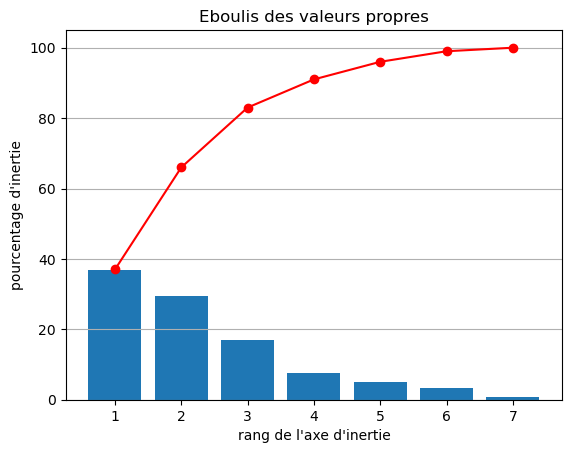

In [84]:
valp = (pca.explained_variance_ratio_*100).round(2)
valp_cum = valp.cumsum().round()
plt.bar([1, 2, 3, 4, 5, 6, 7], valp)
plt.plot([1, 2, 3, 4, 5, 6, 7], valp_cum, c="red", marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.grid(axis='y')
plt.show(block=False)

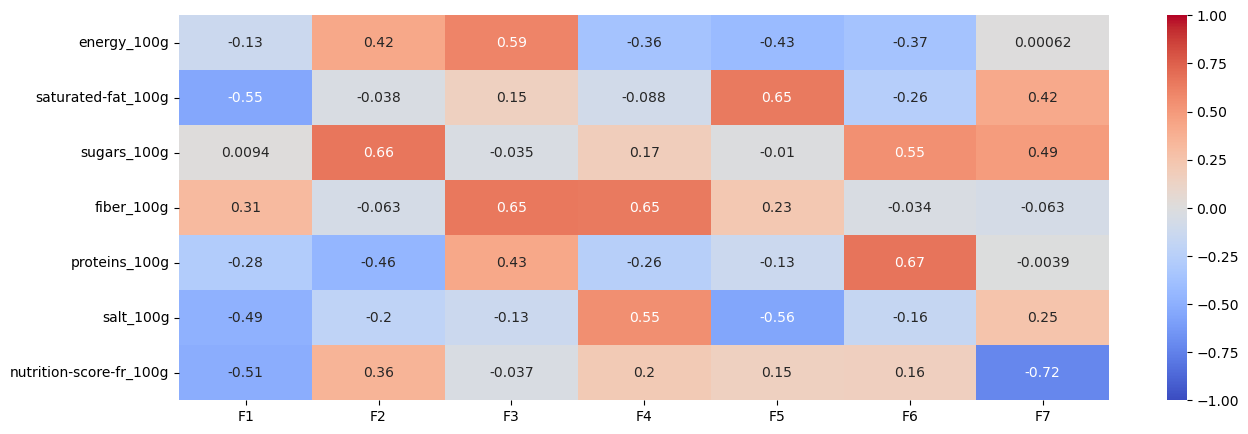

In [85]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = ['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','nutrition-score-fr_100g']
pcs.index = ['F1','F2','F3','F4','F5','F6','F7']
pcs.round(2)
plt.figure(figsize=(15,5))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm")
plt.show()

In [86]:
# cette fois on va faire comme dans le TP : créer la fonction pour afficher les graphes :
def correlation_graph(pca, x_y, features) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """
    x,y=x_y
    fig, ax = plt.subplots(figsize=(10, 9))

    for i in range(0, pca.components_.shape[1]):
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.06, head_length=0.06, width=0.02, )

        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
    plt.axis('equal')
    plt.show(block=False)


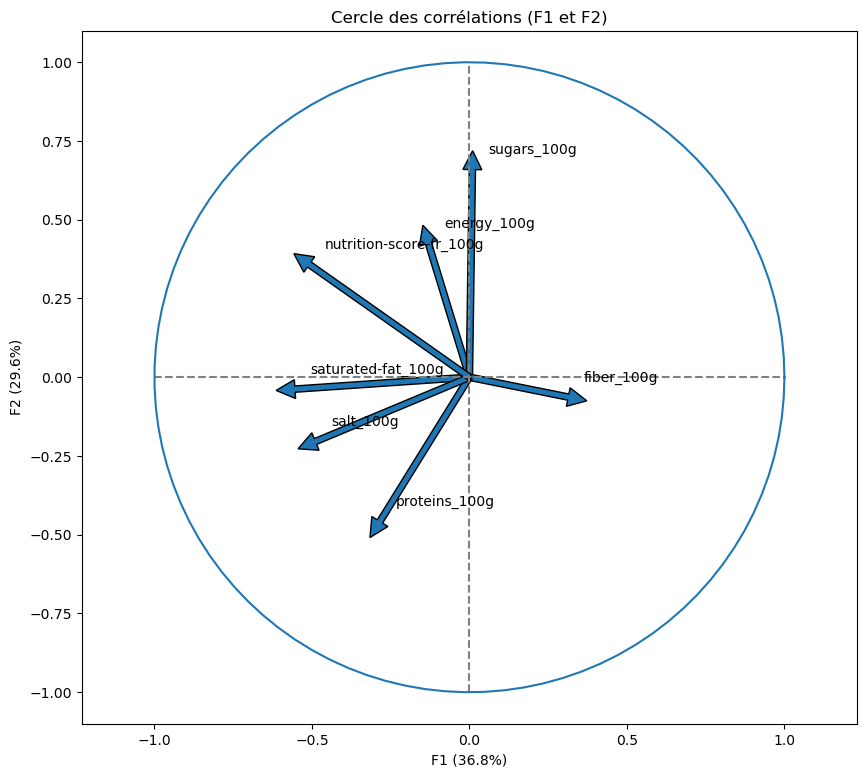

In [87]:
correlation_graph(pca, (0,1), df_fields)

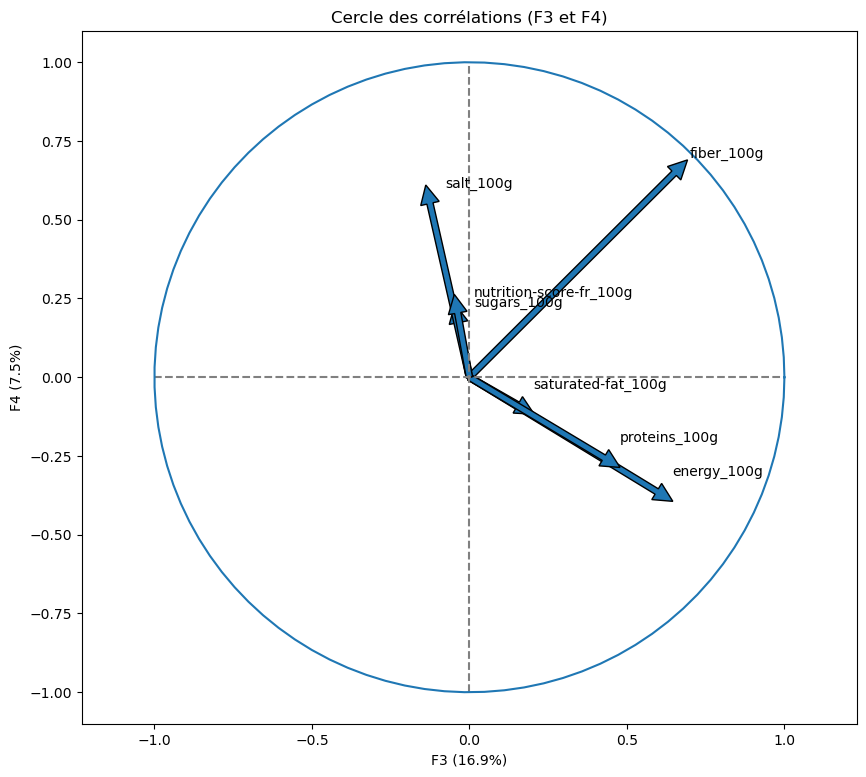

In [88]:
correlation_graph(pca, (2,3), df_fields)

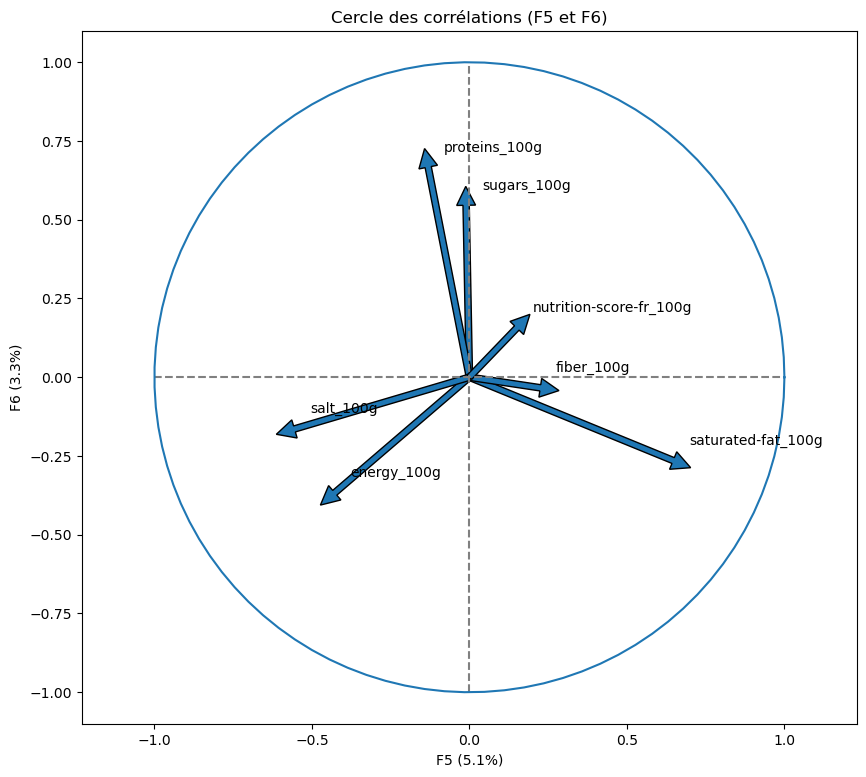

In [89]:
correlation_graph(pca, (4,5), df_fields)

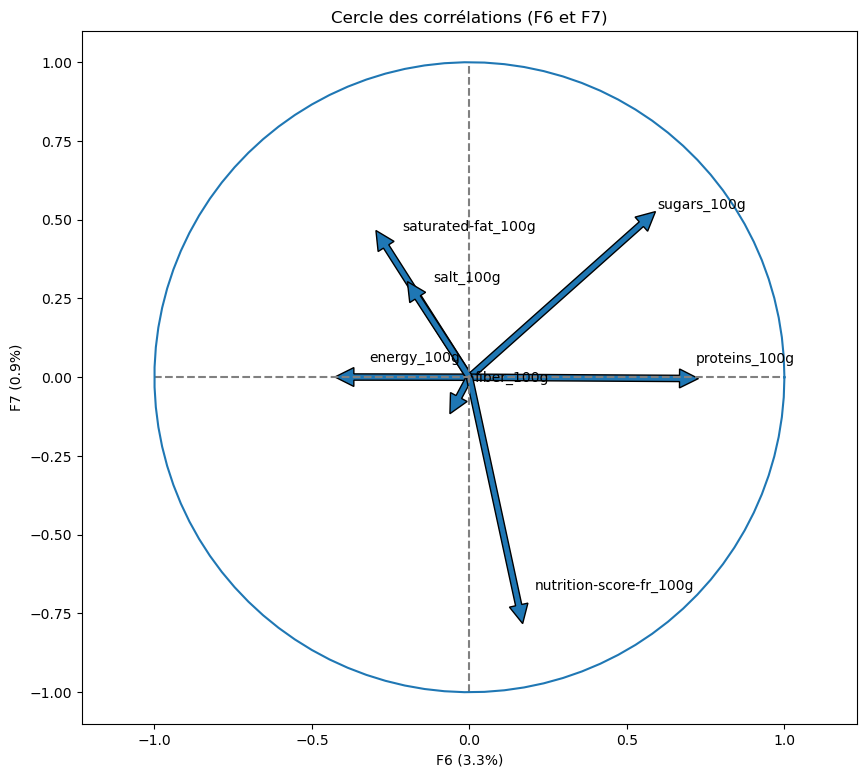

In [90]:
correlation_graph(pca, (5,6), df_fields)

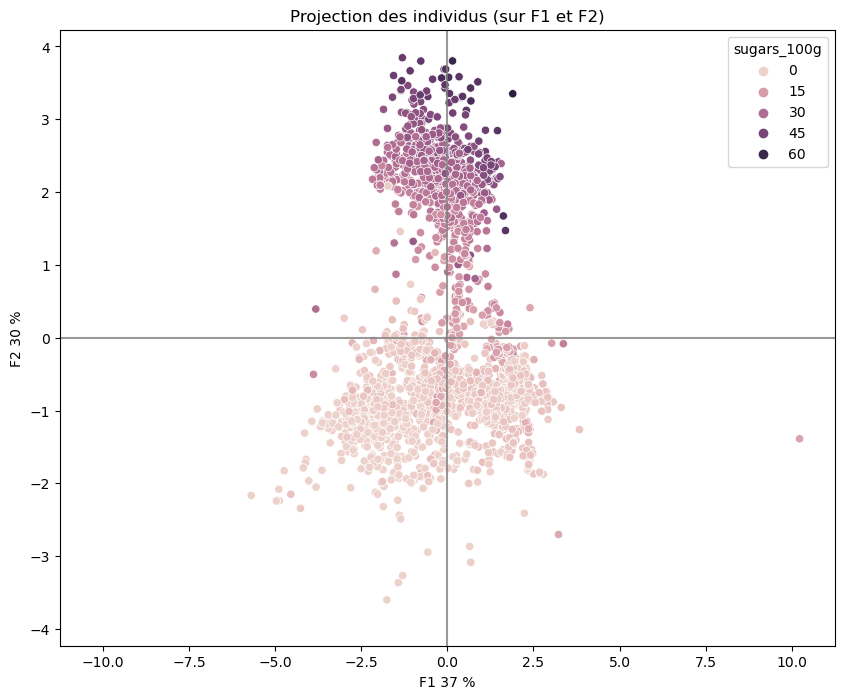

In [93]:
df_proj = pca.transform(tab_scaled)
display_factorial_planes(df_proj, [0,1], pca=pca, clusters=df['sugars_100g'])

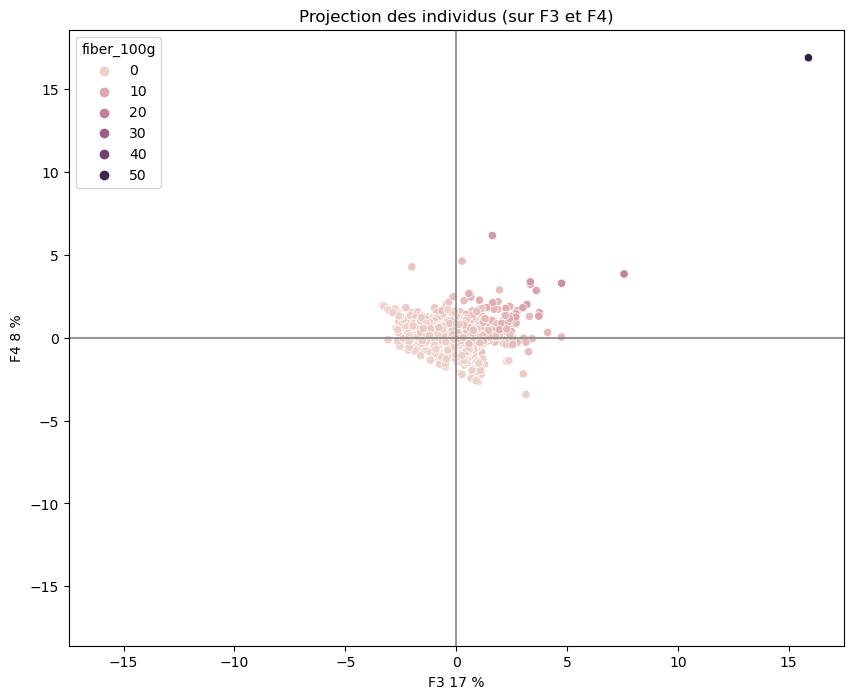

In [94]:
display_factorial_planes(df_proj, [2,3], pca=pca, clusters=df['fiber_100g'])

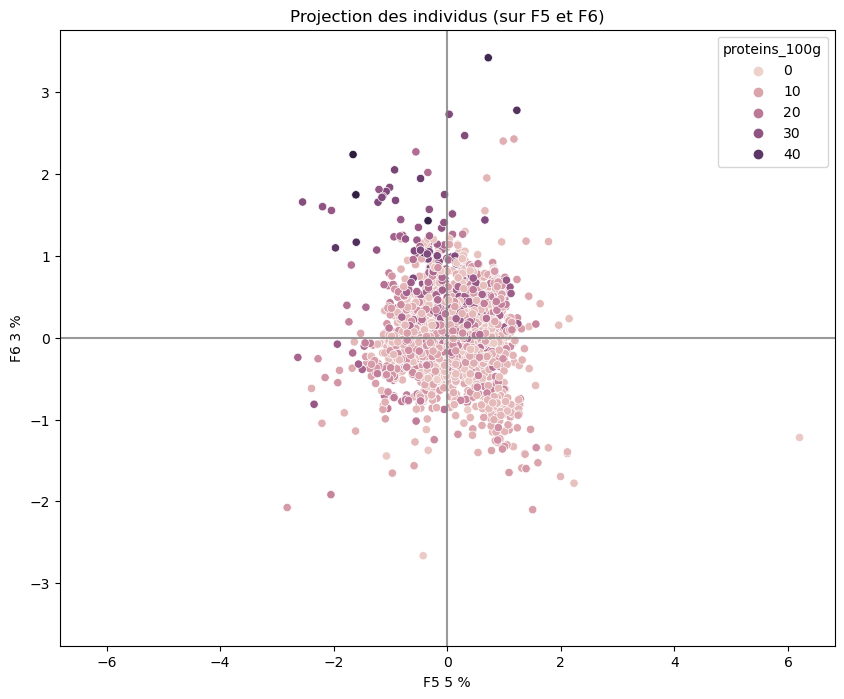

In [95]:
display_factorial_planes(df_proj, [4,5], pca=pca, clusters=df['proteins_100g'])

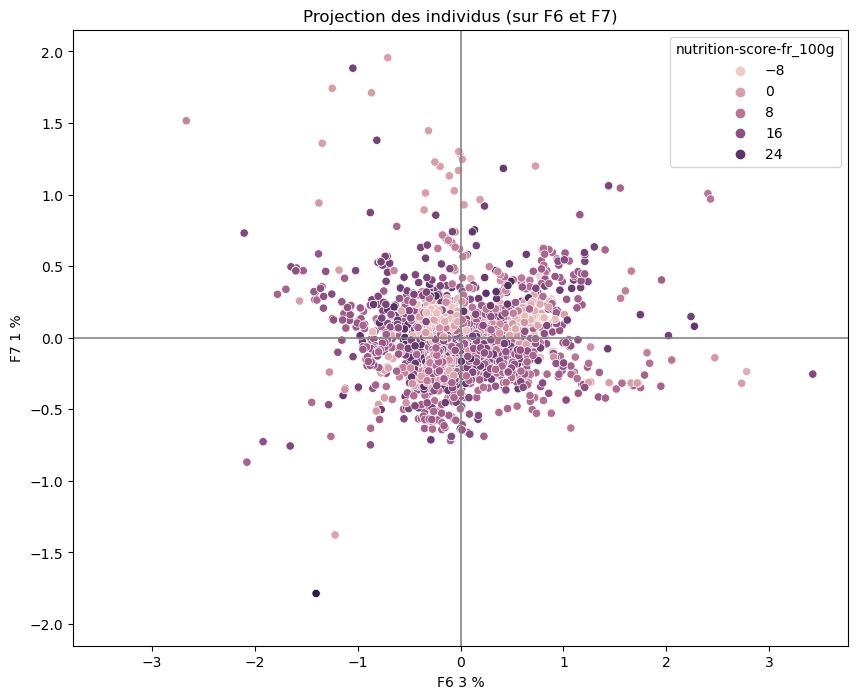

In [96]:
display_factorial_planes(df_proj, [5,6], pca=pca, clusters=df['nutrition-score-fr_100g'])

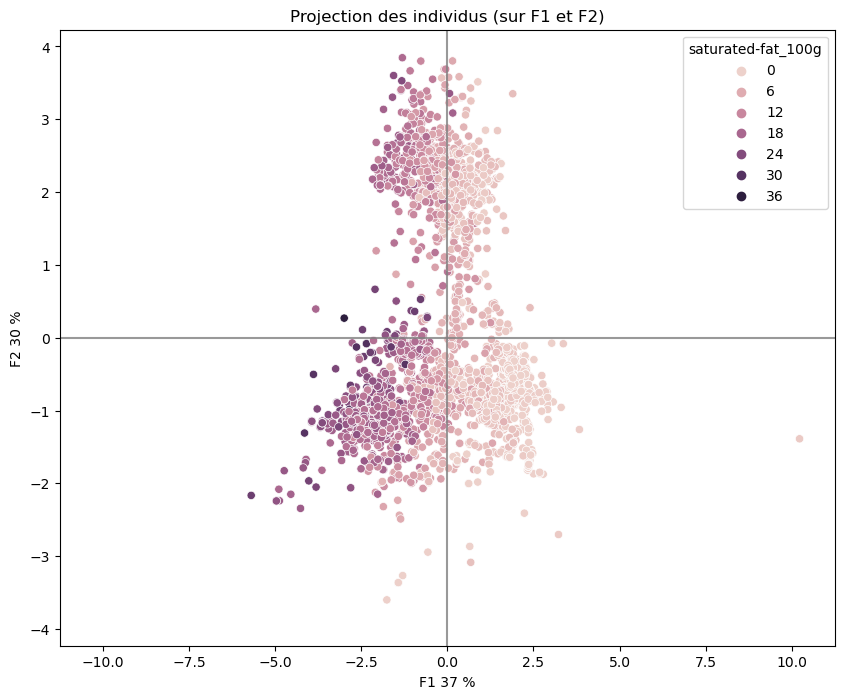

In [97]:
display_factorial_planes(df_proj, [0,1], pca=pca, clusters=df['saturated-fat_100g'])

Il n'y a que sur le premier plan qu'on distingue un peu les trois differents groupes. Et encore, ce n'est bien clair que pour un, le plus sucré : les gâteaux. Aussi, mais là vraiment que deux, sur le plan F2-F3 (deuxième ci-dessous).
<br>
<br>Nous pouvons constater que la 'heat map', et donc les graphes de corrélations et les projections associées, est significativement différente quand on change de catégorie(s) (entre celle des biscuits et celles des gâteaux + fromages + pâtes alimentaires). De plus les ratios de la représentativité de la variance ne sont pas très élevés pour la première composante principale. Cela signifie qu'on ne peut parvenir à une bonne représentation de l'ensemble des produits par les quelques premières composantes d'une ACP.

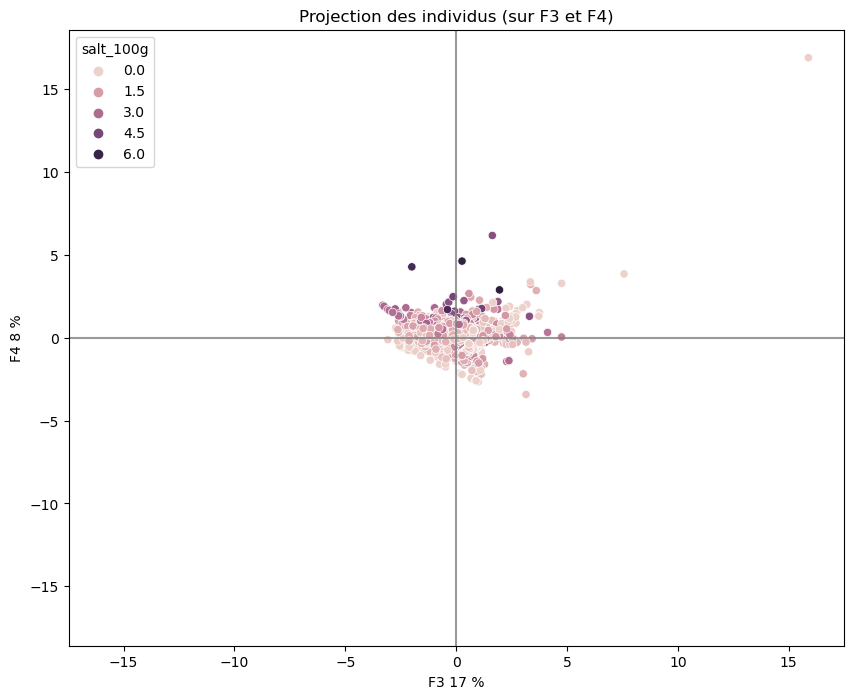

In [98]:
display_factorial_planes(df_proj, [2,3], pca=pca, clusters=df['salt_100g'])

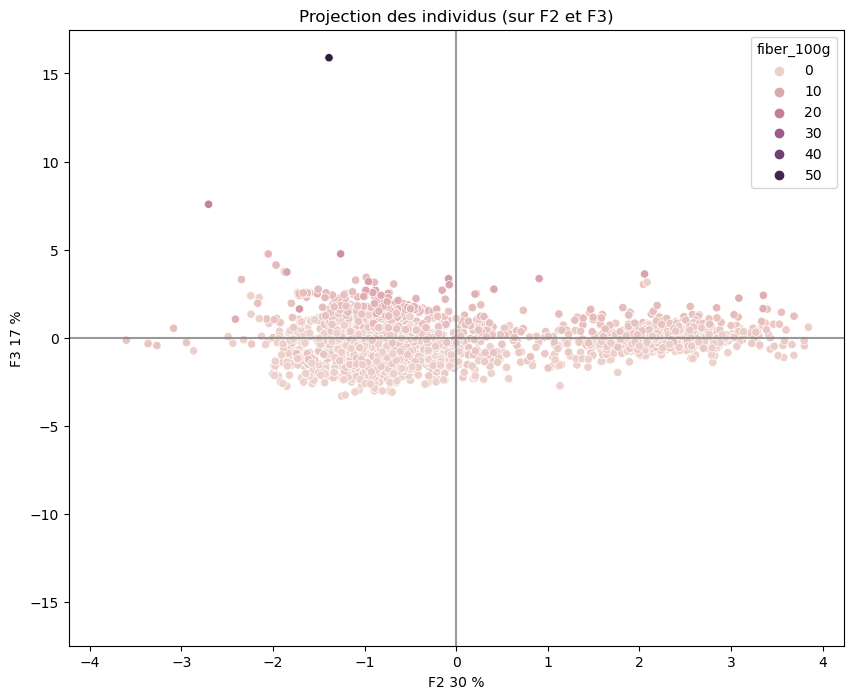

In [99]:
display_factorial_planes(df_proj, [1,2], pca=pca, clusters=df['fiber_100g'])

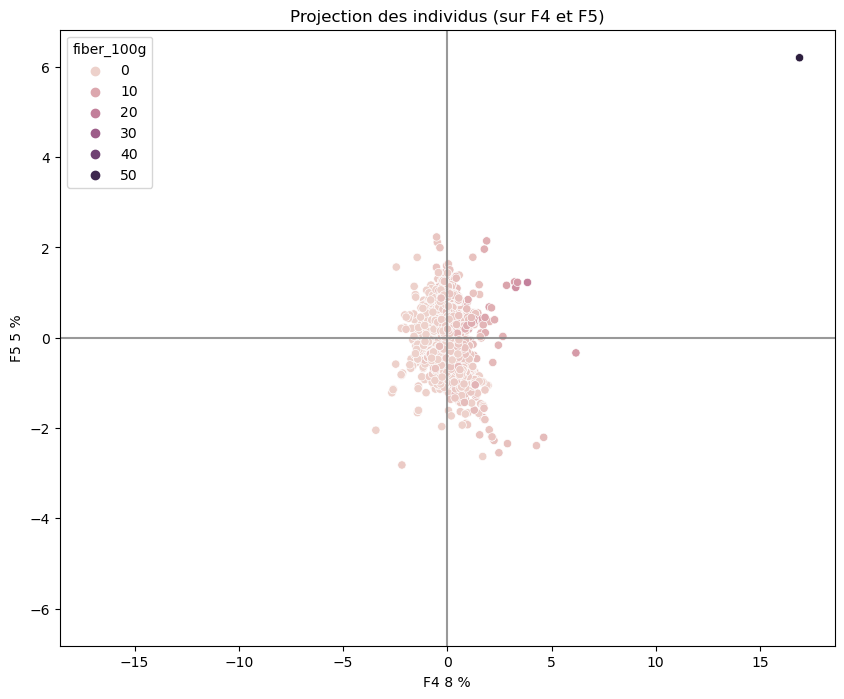

In [101]:
display_factorial_planes(df_proj, [3,4], pca=pca, clusters=df['fiber_100g'])

En l'état, il ne serait pas très judicieux de mettre en place un système de suggestion en vue d'une aide à la saisie, parce que la catégorisation des produits est amplement déficitaire et pas toujours bien claire (par ex. les 'boissons' sont un fourre-tout, des plats préparés se trouvent dans les pâtes, etc, etc.) De plus on trouve de multiples langues et de multiples alphabets !
<br>Il semble que le premier travail requis pour une amélioration de la pertinence et l'utilisabilité de cette base de donnée est d'y imposer plus de contraintes et de structure : peut-être envisager une base par langue, de rendre obligatoire la saisie de certaines catégories alimentaires simples (comme 'jus de fruits' ou 'eaux' mais pas 'boissons', trop vague) sous peine de voir le produit non pris en compte.
<br>Si ces catégories sont proches des produits, une suggestion est envisageable, par ex. si le nom du produit est 'Lait de riz sans sucre' on peut proposer les catégories 'Laits d'élevage laitier', 'Laits pour bébés' et 'Laits végétaux'. Et si le nom du produit n'est pas parlant comme 'Maccaron', on peut proposer les catégories dans lesquelles on trouve déjà ce mot, donc ici 'biscuits' notamment. Une fois les catégories bien indentifiées, il sera possible de suggérer une valeur moyenne à la saisie, et de mettre en rouge par exemple une valeur qui constituerai un outlier pour la catégorie spécifiée.
<br>Pour régler le problème du nutriscore dont le mode de calcul diffère en fonction du taux d'eau (boissons / autres) et pour lequel il me parait pertinent d'ajouter un troisième mode de calcul pour les aliments secs (poudres comme pour le lait, la purée, le café ... mais aussi les lentilles, les pâtes, couscous, boulgour, quinoa, aliments déshydratés, ...) qui peuvent difficilement être consommés directement (même les biscuits secs, dans un objectif de santé doivent être consommés avec un liquide, un yaourt, une compote ... de même pour le chocolat, les chips ...), il serait interressant de diviser la base en trois, selon le taux d'eau dans le produit, par ex. > 75 % : aliments aqueux, < 75 % et > 4 % : aliments 'standards', < 4 % : aliments secs (dont huiles : on n'en boit pas !)
